# Assignment 3: Function Approximation and Control

Welcome to Assignment 3. In this notebook you will learn how to:
- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent

As with the rest of the notebooks do not import additional libraries or adjust grading cells as this will break the grader.

MAKE SURE TO RUN ALL OF THE CELLS SO THE GRADER GETS THE OUTPUT IT NEEDS


In [1]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import tiles3 as tc
from rl_glue import RLGlue
from agent import BaseAgent
from utils import argmax
import mountaincar_env
import time

In the above cell, we import the libraries we need for this assignment. You may have noticed that we import mountaincar_env. This is the __Mountain Car Task__ introduced in [Section 10.1 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=267). The task is for an under powered car to make it to the top of a hill:
![Mountain Car](mountaincar.png "Mountain Car")
The car is under-powered so the agent needs to learn to rock back and forth to get enough momentum to reach the goal. At each time step the agent receives from the environment its current velocity (a float between -0.07 and 0.07), and it's current position (a float between -1.2 and 0.5). Because our state is continuous there are a potentially infinite number of states that our agent could be in. We need a function approximation method to help the agent deal with this. In this notebook we will use tile coding. We provide a tile coding implementation for you to use, imported above with tiles3.

## Section 0: Tile Coding Helper Function

To begin we are going to build a tile coding class for our Sarsa agent that will make it easier to make calls to our tile coder.

### Tile Coding Function

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.
![Tile Coding](tilecoding.png "Tile Coding")

To help keep our agent code clean we are going to make a function specific for tile coding for our Mountain Car environment. To help we are going to use the Tiles3 library. This is a Python 3 implementation of the tile coder. To start take a look at the documentation: [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html)
To get the tile coder working we need to implement a few pieces:
- First: create an index hash table - this is done for you in the init function using tc.IHT.
- Second is to scale the inputs for the tile coder based on the number of tiles and the range of values each input could take. The tile coder needs to take in a number in range [0, 1], or scaled to be [0, 1] * num_tiles. For more on this refer to the [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html).
- Finally we call tc.tiles to get the active tiles back.

In [2]:
# Tile Coding Function [Graded]
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # POSITION_MIN
        # POSITION_MAX
        # VELOCITY_MIN
        # VELOCITY_MAX
        ### START CODE HERE ###
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        ### END CODE HERE ###
        
        # Use the ranges above and self.num_tiles to set position_scale and velocity_scale
        # position_scale = number of tiles / position range
        # velocity_scale = number of tiles / velocity range
        
        # Scale position and velocity by multiplying the inputs of each by their scale
        
        ### START CODE HERE ###
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        ### END CODE HERE ###
        
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)

In [3]:
# [DO NOT CHANGE]
tests = [[-1.0, 0.01], [0.1, -0.01], [0.2, -0.05], [-1.0, 0.011], [0.2, -0.05]]

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

print("Your results:")
for tiles in t:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]
"""
print(expected)

np.random.seed(1)
mctc_test = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)
test = [mctc_test.get_tiles(np.random.uniform(-1.2, 0.5), np.random.uniform(-0.07, 0.07)) for _ in range(10)]
np.save("tiles_test", test)

Your results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]

Expected results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]



## Section 1: Sarsa Agent

We are now going to use the functions that we just created to implement the Sarsa algorithm. Recall from class that Sarsa stands for State, Action, Reward, State, Action.

For this case we have given you an argmax function similar to what you wrote back in Course 1 Assignment 1. Recall, this is different than the argmax function that is used by numpy, which returns the first index of a maximum value. We want our argmax function to arbitrarily break ties, which is what the imported argmax function does. The given argmax function takes in an array of values and returns an int of the chosen action: 
argmax(action values)

There are multiple ways that we can deal with actions for the tile coder. Here we are going to use one simple method - make the size of the weight vector equal to (iht_size, num_actions). This will give us one weight vector for each action and one weight for each tile.

Use the above function to help fill in select_action, agent_start, agent_step, and agent_end.

Hints:

1) The tile coder returns a list of active indexes (e.g. [1, 12, 22]). You can index a numpy array using an array of values - this will return an array of the values at each of those indices. So in order to get the value of a state we can index our weight vector using the action and the array of tiles that the tile coder returns:

```self.w[action][active_tiles]```

This will give us an array of values, one for each active tile, and we sum the result to get the value of that state-action pair.

2) In the case of a binary feature vector (such as the tile coder), the derivative is 1 at each of the active tiles, and zero otherwise.

In [4]:
# SARSA
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        ### START CODE HERE ###
        action_values = np.zeros(self.num_actions)
        for action in range(self.num_actions):
            action_values[action] = np.sum(self.w[action][tiles])
        
        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(0, self.num_actions)
        else:
            chosen_action = argmax(action_values)
        ### END CODE HERE ###
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        
        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward + self.gamma * action_value - last_action_value) * 1
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        ### START CODE HERE ###
        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward - last_action_value) * 1
        ### END CODE HERE ###
        
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

In [5]:
# Test Epsilon Greedy Function [DO NOT CHANGE]
agent = SarsaAgent()
agent.agent_init({"epsilon": 0.1})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

total = 0
for i in range(1000):
    chosen_action, action_value = agent.select_action(np.array([0,1]))
    total += action_value
print(total)
assert total < 15000, "Check that you are not always choosing the best action"

np.save("epsilon_test", total)

agent = SarsaAgent()
agent.agent_init({"epsilon": 0.0})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

chosen_action, action_value = agent.select_action(np.array([0,1]))
print("Expected value")
print("(2, 15)")

print("Your value")
print((chosen_action, action_value))

np.save("egreedy_test", (chosen_action, action_value))

14460.0
Expected value
(2, 15)
Your value
(2, 15.0)


RUN: 0
[-0.47685914  0.        ]
[-4.77208542e-01 -3.49399672e-04]
[-4.76904747e-01  3.03795626e-04]
[-0.47795001 -0.00104527]
[-0.48033657 -0.00238656]
[-0.48404669 -0.00371012]
[-0.48805276 -0.00400606]
[-0.49232491 -0.00427215]
[-0.49583127 -0.00350636]
[-0.49854565 -0.00271438]
[-0.50044775 -0.0019021 ]
[-0.50352335 -0.00307559]
[-0.50774941 -0.00422607]
[-0.51209431 -0.00434489]
[-0.51652547 -0.00443116]
[-0.52100967 -0.00448421]
[-0.5245133  -0.00350362]
[-0.52701006 -0.00249677]
[-0.53048125 -0.00347118]
[-0.53490081 -0.00441957]
[-0.54023563 -0.00533482]
[-0.54644572 -0.00621009]
[-0.5524846  -0.00603887]
[-0.5583071 -0.0058225]
[-0.56286976 -0.00456266]
[-0.56613857 -0.00326881]
[-0.56908919 -0.00295063]
[-0.5716997  -0.00261051]
[-0.57495069 -0.003251  ]
[-0.57881808 -0.00386738]
[-0.5812732  -0.00245513]
[-0.58229793 -0.00102472]
[-0.58288468 -0.00058675]
[-5.83029130e-01 -1.44449214e-04]
[-0.58373021 -0.00070108]
[-0.58498275 -0.00125254]
[-5.84777499e-01  2.05246601e-04]
[

[-0.95789492  0.01678249]
[-0.93870161  0.01919331]
[-0.91813957  0.02056204]
[-0.89626258  0.02187699]
[-0.87313753  0.02312505]
[-0.84684564  0.02629189]
[-0.81749191  0.02935373]
[-0.78620866  0.03128325]
[-0.75315334  0.03305531]
[-0.71750927  0.03564408]
[-0.67949151  0.03801776]
[-0.63934672  0.04014479]
[-0.59735116  0.04199556]
[-0.55480695  0.0425442 ]
[-0.51202903  0.04277792]
[-0.47033786  0.04169117]
[-0.42804446  0.04229341]
[-0.38545793  0.04258653]
[-0.34287806  0.04257987]
[-0.30058816  0.0422899 ]
[-0.26084883  0.03973933]
[-0.2218823   0.03896653]
[-0.18388206  0.03800024]
[-0.14901098  0.03487108]
[-0.11739424  0.03161675]
[-0.08712405  0.03027019]
[-0.05926895  0.0278551 ]
[-0.03387443  0.02539451]
[-0.01196702  0.02190741]
[0.006442   0.01840902]
[0.02135149 0.01490949]
[0.03276611 0.01141462]
[0.04169279 0.00892669]
[0.04813901 0.00644622]
[0.05111125 0.00297224]
[ 0.05061282 -0.00049843]
[ 0.04864316 -0.00196966]
[ 0.04520007 -0.00344309]
[ 0.03927993 -0.00592014

[-0.51033352  0.04910888]
[-0.4613241   0.04900942]
[-0.41277903  0.04854507]
[-0.36404988  0.04872915]
[-0.31547218  0.0485777 ]
[-0.26835596  0.04711622]
[-0.2229724   0.04538356]
[-0.18055007  0.04242233]
[-0.14126989  0.03928018]
[-0.10426853  0.03700136]
[-0.06964586  0.03462267]
[-0.03646882  0.03317704]
[-0.00477683  0.03169199]
[0.02341542 0.02819225]
[0.04811383 0.02469841]
[0.06933825 0.02122441]
[0.08711655 0.0177783 ]
[0.10247975 0.0153632 ]
[0.11546017 0.01298042]
[0.12708907 0.0116289 ]
[0.13739748 0.01030842]
[0.14441529 0.0070178 ]
[0.14816407 0.00374878]
[0.15065578 0.00249171]
[0.15189852 0.00124274]
[ 0.15089637 -0.00100215]
[ 0.14764604 -0.00325034]
[ 0.14313696 -0.00450908]
[ 0.13735485 -0.0057821 ]
[ 0.12828201 -0.00907284]
[ 0.11589203 -0.01238998]
[ 0.10015162 -0.0157404 ]
[ 0.08202322 -0.01812841]
[ 0.06147011 -0.0205531 ]
[ 0.0384594  -0.02301071]
[ 0.01196531 -0.02649409]
[-0.01602717 -0.02799248]
[-0.04651676 -0.03048959]
[-0.07948205 -0.03296529]
[-0.115876

[-0.68648402  0.03682574]
[-0.64948468  0.03699934]
[-0.61256349  0.0369212 ]
[-0.57398295  0.03858054]
[-0.53502596  0.03895698]
[-0.49598329  0.03904267]
[-0.4581475   0.03783579]
[-0.42179944  0.03634806]
[-0.38520307  0.03659637]
[-0.34861509  0.03658797]
[-0.31228005  0.03633504]
[-0.27642585  0.0358542 ]
[-0.24126017  0.03516568]
[-0.20896775  0.03229241]
[-0.17969996  0.02926779]
[-0.1515776   0.02812236]
[-0.12470118  0.02687642]
[-0.09915185  0.02554933]
[-0.07699274  0.02215912]
[-0.05726723  0.01972551]
[-0.04000492  0.01726231]
[-0.02422462  0.0157803 ]
[-0.00993773  0.01428689]
[0.00085028 0.01078801]
[0.00813829 0.00728801]
[0.01192705 0.00378876]
[0.01321741 0.00129036]
[ 0.01200973 -0.00120768]
[ 0.00930368 -0.00270605]
[ 0.0050986  -0.00420508]
[-0.00260619 -0.00770479]
[-0.0128109  -0.01020471]
[-0.02551377 -0.01270287]
[-0.04070931 -0.01519555]
[-0.05738624 -0.01667692]
[-0.0755262  -0.01813997]
[-0.09710227 -0.02157607]
[-0.12107302 -0.02397074]
[-0.14738065 -0.0263

[-0.60594117 -0.01690928]
[-0.62223914 -0.01629797]
[-0.63780806 -0.01556892]
[-0.65253707 -0.01472901]
[-0.66532298 -0.01278591]
[-0.67807769 -0.01275471]
[-0.69071485 -0.01263715]
[-0.70115048 -0.01043563]
[-0.70931655 -0.00816608]
[-0.7161607  -0.00684414]
[-0.72163963 -0.00547893]
[-0.7247191  -0.00307947]
[-7.25380040e-01 -6.60940344e-04]
[-0.72461837  0.00076167]
[-0.72243879  0.00217958]
[-0.71985479  0.002584  ]
[-0.71688244  0.00297234]
[-0.71154035  0.00534209]
[-0.70486221  0.00667815]
[-0.6968906   0.00797161]
[-0.68767706  0.00921354]
[-0.67628204  0.01139503]
[-0.66278151  0.01350053]
[-0.64926718  0.01351433]
[-0.63583251  0.01343467]
[-0.6215719   0.01426061]
[-0.60658702  0.01498487]
[-0.59198615  0.01460088]
[-0.57787596  0.01411019]
[-0.56236048  0.01551547]
[-0.54555495  0.01680553]
[-0.52858487  0.01697008]
[-0.51157739  0.01700748]
[-0.49566005  0.01591734]
[-0.48095201  0.01470804]
[-0.46556295  0.01538906]
[-0.45060696  0.01495599]
[-0.43619404  0.01441292]
[-0.

[-0.12358724 -0.04298825]
[-0.16890562 -0.04531838]
[-0.21740985 -0.04850424]
[-0.26890092 -0.05149107]
[-0.32112169 -0.05222077]
[-0.37376937 -0.05264767]
[-0.4285033  -0.05473394]
[-0.48494082 -0.05643752]
[-0.54266762 -0.0577268 ]
[-0.60125148 -0.05858386]
[-0.6602582  -0.05900672]
[-0.71826845 -0.05801025]
[-0.77390027 -0.05563182]
[-0.82682633 -0.05292606]
[-0.87677912 -0.04995279]
[-0.92455159 -0.04777246]
[-0.96999138 -0.04543979]
[-1.01199792 -0.04200655]
[-1.0505184  -0.03852047]
[-1.08653899 -0.0360206 ]
[-1.12007698 -0.03353799]
[-1.15117449 -0.0310975 ]
[-1.17989263 -0.02871815]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19252817  0.00374203]
[-1.18552001  0.00700816]
[-1.17522403  0.01029599]
[-1.16161018  0.01361384]
[-1.14464216  0.01696802]
[-1.12428021  0.02036195]
[-1.1004848   0.02379541]
[-1.07322127  0.02726353]
[-1.04246536  0.03075592]
[-1.00920969  0.03325566]
[-0.97347025  0.03573945]
[-0.9342917   0.03917854]
[-0.89175521  0.0425365 ]
[-

[-0.35493294  0.02778608]
[-0.32935855  0.02557438]
[-0.30615992  0.02319864]
[-0.28347885  0.02268107]
[-0.26144692  0.02203193]
[-0.24118462  0.02026229]
[-0.22279597  0.01838865]
[-0.20736938  0.0154266 ]
[-0.19497441  0.01239497]
[-0.18566383  0.00931058]
[-0.17847538  0.00718846]
[-0.17443705  0.00403833]
[-0.17356414  0.00087291]
[-0.17485992 -0.00129578]
[-0.17831954 -0.00345962]
[-0.18392988 -0.00561034]
[-0.19166919 -0.00773931]
[-0.20050648 -0.00883728]
[-0.21040495 -0.00989847]
[-0.2233217  -0.01291675]
[-0.23919806 -0.01587636]
[-0.2569579  -0.01775983]
[-0.27651099 -0.01955309]
[-0.29775213 -0.02124114]
[-0.31956046 -0.02180834]
[-0.3418053  -0.02224484]
[-0.364347   -0.02254169]
[-0.38903816 -0.02469116]
[-0.41571134 -0.02667318]
[-0.44417962 -0.02846828]
[-0.47323792 -0.02905831]
[-0.5026725  -0.02943458]
[-0.53126392 -0.02859142]
[-0.56079786 -0.02953394]
[-0.59105338 -0.03025552]
[-0.62080644 -0.02975306]
[-0.64984073 -0.02903429]
[-0.67795068 -0.02810995]
[-0.70494392

[-0.3037389   0.00938249]
[-0.29488837  0.00885053]
[-0.28762172  0.00726666]
[-0.28298072  0.004641  ]
[-0.28099167  0.00198905]
[-0.27966573  0.00132594]
[-0.27901031  0.00065542]
[-0.28002907 -0.00101876]
[-0.28271632 -0.00268725]
[-0.288057   -0.00534068]
[-0.29602086 -0.00796386]
[-0.30456202 -0.00854115]
[-0.31363025 -0.00906823]
[-0.32417115 -0.0105409 ]
[-0.33612011 -0.01194896]
[-0.3504022  -0.01428208]
[-0.36692559 -0.01652339]
[-0.38358125 -0.01665565]
[-0.40125642 -0.01767518]
[-0.4198287  -0.01857228]
[-0.44016675 -0.02033805]
[-0.46212402 -0.02195727]
[-0.48553975 -0.02341572]
[-0.50824029 -0.02270055]
[-0.53005599 -0.0218157 ]
[-0.55282326 -0.02276727]
[-0.57637162 -0.02354837]
[-0.60052584 -0.02415422]
[-0.62310822 -0.02258238]
[-0.64595531 -0.02284709]
[-0.6689052  -0.02294989]
[-0.69179947 -0.02289428]
[-0.7144851  -0.02268563]
[-0.73681606 -0.02233096]
[-0.75665473 -0.01983867]
[-0.77388444 -0.01722971]
[-0.78940849 -0.01552405]
[-0.80314364 -0.01373514]
[-0.81601945

[-0.6345414  -0.02571013]
[-0.65943474 -0.02489334]
[-0.68333727 -0.02390254]
[-0.7060871  -0.02274983]
[-0.72653562 -0.02044852]
[-0.7445544  -0.01801879]
[-0.76203474 -0.01748034]
[-0.77887546 -0.01684071]
[-0.79298333 -0.01410788]
[-0.80428368 -0.01130034]
[-0.81371899 -0.00943531]
[-0.82124289 -0.00752391]
[-0.82581951 -0.00457662]
[-0.82742751 -0.00160799]
[-0.82605947  0.00136804]
[-0.82172169  0.00433778]
[-0.81443437  0.00728731]
[-0.8052322   0.00920217]
[-0.79416027  0.01107193]
[-0.78227472  0.01188555]
[-0.76963804  0.01263668]
[-0.75431912  0.01531892]
[-0.73640469  0.01791443]
[-0.71700045  0.01940424]
[-0.69622573  0.02077473]
[-0.6732134   0.02301233]
[-0.64811626  0.02509714]
[-0.62110681  0.02700945]
[-0.59337643  0.02773038]
[-0.56512654  0.0282499 ]
[-0.53556599  0.02956055]
[-0.50491571  0.03065028]
[-0.47440547  0.03051023]
[-0.44326285  0.03114262]
[-0.41171693  0.03154592]
[-0.37999446  0.03172247]
[-0.34831602  0.03167845]
[-0.31689244  0.03142358]
[-0.28792169

[-0.64314846 -0.01300715]
[-0.65427809 -0.01112963]
[-0.66545254 -0.01117445]
[-0.67659491 -0.01114237]
[-0.68662968 -0.01003476]
[-0.69548988 -0.0088602 ]
[-0.70211728 -0.0066274 ]
[-0.70646888 -0.0043516 ]
[-0.71051673 -0.00404785]
[-0.71423501 -0.00371829]
[-0.71660021 -0.00236519]
[-0.71759742 -0.00099721]
[-7.17220403e-01  3.77016840e-04]
[-0.71447152  0.00274888]
[-0.71136805  0.00310347]
[-0.70792961  0.00343844]
[-0.70317809  0.00475153]
[-0.69714393  0.00603416]
[-0.68986619  0.00727774]
[-0.68239252  0.00747367]
[-0.67477243  0.00762009]
[-0.66505701  0.00971542]
[-0.65331221  0.0117448 ]
[-0.63961893  0.01369328]
[-0.62607296  0.01354597]
[-0.61277048  0.01330248]
[-0.59780716  0.01496332]
[-0.58129187  0.01651529]
[-0.56434603  0.01694583]
[-0.54609536  0.01825068]
[-0.52667608  0.01941927]
[-0.50623373  0.02044235]
[-0.48692155  0.01931218]
[-0.4668839   0.02003765]
[-0.44726956  0.01961434]
[-0.4272227   0.02004686]
[-0.40688863  0.02033407]
[-0.38641212  0.02047652]
[-0.

[-0.41483144 -0.00265334]
[-0.41828613 -0.00345469]
[-0.42351759 -0.00523146]
[-0.43048844 -0.00697084]
[-0.43914856 -0.00866013]
[-0.44943531 -0.01028675]
[-0.45927371 -0.0098384 ]
[-0.47059155 -0.01131785]
[-0.48330528 -0.01271373]
[-0.49732047 -0.01401519]
[-0.51253255 -0.01521208]
[-0.52882761 -0.01629506]
[-0.54508345 -0.01625584]
[-0.56217827 -0.01709482]
[-0.57998439 -0.01780612]
[-0.59836963 -0.01838524]
[-0.61719878 -0.01882915]
[-0.63433512 -0.01713634]
[-0.64965612 -0.01532101]
[-0.66405408 -0.01439795]
[-0.67742951 -0.01337543]
[-0.69069173 -0.01326222]
[-0.70375259 -0.01306085]
[-0.71652711 -0.01277452]
[-0.72693412 -0.01040701]
[-0.73590895 -0.00897483]
[-0.74339695 -0.007488  ]
[-0.74935335 -0.0059564 ]
[-0.75274309 -0.00338975]
[-0.75354645 -0.00080336]
[-0.75275877  0.00078768]
[-0.75038461  0.00237416]
[-0.74643777  0.00394684]
[-0.74194137  0.0044964 ]
[-0.73492202  0.00701935]
[-0.7254218   0.00950022]
[-0.71349871  0.01192309]
[-0.69922718  0.01427154]
[-0.68369853

[-0.76948956 -0.00673905]
[-0.77454719 -0.00505763]
[-0.77689552 -0.00234834]
[-7.76521752e-01  3.73769673e-04]
[-0.77342791  0.00309384]
[-0.76863091  0.004797  ]
[-0.76315726  0.00547365]
[-0.75703765  0.00611962]
[-0.74830688  0.00873077]
[-0.73801558  0.0102913 ]
[-0.72622478  0.0117908 ]
[-0.71200616  0.01421862]
[-0.69544854  0.01655763]
[-0.67865838  0.01679016]
[-0.66174677  0.01691161]
[-0.64382845  0.01791832]
[-0.62502784  0.01880061]
[-0.60547819  0.01954965]
[-0.5843206   0.02115759]
[-0.56171012  0.02261048]
[-0.53781442  0.0238957 ]
[-0.51281214  0.02500228]
[-0.48789074  0.0249214 ]
[-0.46423665  0.0236541 ]
[-0.44202541  0.02221123]
[-0.42041989  0.02160552]
[-0.39857592  0.02184398]
[-0.37664778  0.02192814]
[-0.35678642  0.01986136]
[-0.33912459  0.01766184]
[-0.32177676  0.01734783]
[-0.30485179  0.01692497]
[-0.28845218  0.01639961]
[-0.27467349  0.01377869]
[-0.26159299  0.0130805 ]
[-0.24928136  0.01231164]
[-0.23880261  0.01047874]
[-0.23020929  0.00859332]
[-0.

[-1.10876052  0.02151999]
[-1.08378305  0.02497747]
[-1.05732062  0.02646243]
[-1.02735935  0.02996127]
[-0.9939025   0.03345685]
[-0.95897754  0.03492496]
[-0.92063962  0.03833792]
[-0.87897974  0.04165988]
[-0.8341315   0.04484824]
[-0.78627683  0.04785467]
[-0.73564974  0.05062709]
[-0.68353739  0.05211236]
[-0.63027099  0.05326639]
[-0.57521814  0.05505285]
[-0.51977969  0.05543845]
[-0.46336988  0.05640981]
[-0.40640934  0.05696054]
[-0.35130972  0.05509962]
[-0.2964455   0.05486422]
[-0.2431561  0.0532894]
[-0.19173052  0.05142558]
[-0.14140266  0.05032786]
[-0.09235321  0.04904945]
[-0.04470842  0.04764479]
[-0.00054118  0.04416724]
[0.04012606 0.04066724]
[0.0793114  0.03918534]
[0.11706717 0.03775577]
[0.15247554 0.03540837]
[0.18664092 0.03416539]
[0.21868807 0.03204715]
[0.24875422 0.03006615]
[0.2779848  0.02923057]
[0.30653549 0.02855069]
[0.33457084 0.02803536]
[0.36226327 0.02769242]
[0.38979236 0.0275291 ]
[0.41734465 0.02755229]
[0.44511346 0.02776881]
[0.47329905 0.02

[-0.64806026 -0.0281465 ]
[-0.67429484 -0.02623457]
[-0.7004373  -0.02614246]
[-0.72631482 -0.02587752]
[-0.75176396 -0.02544914]
[-0.7756324  -0.02386844]
[-0.79778561 -0.02215321]
[-0.8191066  -0.02132099]
[-0.83949039 -0.02038379]
[-0.85684403 -0.01735364]
[-0.87109435 -0.01425032]
[-0.88218552 -0.01109117]
[-0.89207681 -0.00989129]
[-0.89873395 -0.00665714]
[-0.90313498 -0.00440104]
[-0.90526589 -0.00213091]
[-9.06120018e-01 -8.54129507e-04]
[-9.05694733e-01  4.25285609e-04]
[-0.90299134  0.00270339]
[-0.89801828  0.00497307]
[-0.89179142  0.00622685]
[-0.88433138  0.00746004]
[-0.87366386  0.01066752]
[-0.86082754  0.01283632]
[-0.8458719   0.01495564]
[-0.82885855  0.01701335]
[-0.80886261  0.01999594]
[-0.78597894  0.02288367]
[-0.76032443  0.02565451]
[-0.73204     0.02828443]
[-0.70229217  0.02974783]
[-0.67126741  0.03102476]
[-0.63817101  0.0330964 ]
[-0.60323214  0.03493887]
[-0.56870169  0.03453046]
[-0.53483399  0.0338677 ]
[-0.49988204  0.03495194]
[-0.46410782  0.035774

[-0.45933957  0.00207037]
[-0.45674816  0.0025914 ]
[-0.45365479  0.00309338]
[-0.45008215  0.00357264]
[-0.44605643  0.00402572]
[-0.44160704  0.00444939]
[-0.43776641  0.00384063]
[-0.43556244  0.00220398]
[-0.43501108  0.00055135]
[-0.43611634 -0.00110526]
[-0.43687022 -0.00075387]
[-4.37267238e-01 -3.97022196e-04]
[-0.43830453 -0.00103729]
[-0.43997458 -0.00167004]
[-0.44326524 -0.00329067]
[-0.44815259 -0.00488735]
[-0.45460097 -0.00644838]
[-0.46256315 -0.00796218]
[-0.47198054 -0.00941739]
[-0.48278352 -0.01080298]
[-0.49489185 -0.01210833]
[-0.50621522 -0.01132337]
[-0.5186689  -0.01245368]
[-0.53215956 -0.01349066]
[-0.54658602 -0.01442646]
[-0.56184021 -0.01525419]
[-0.57780822 -0.01596801]
[-0.59437144 -0.01656323]
[-0.61140785 -0.01703641]
[-0.62679329 -0.01538543]
[-0.64041707 -0.01362378]
[-0.65418253 -0.01376547]
[-0.66799348 -0.01381095]
[-0.67975502 -0.01176154]
[-0.68938776 -0.00963274]
[-0.69882771 -0.00943996]
[-0.70801315 -0.00918544]
[-0.71688497 -0.00887181]
[-0.

[0.04413405 0.04389447]
[0.0865504  0.04241635]
[0.12755055 0.04100015]
[0.1672315  0.03968096]
[0.20372053 0.03648903]
[0.23916211 0.03544158]
[0.27372004 0.03455793]
[0.30757453 0.03385449]
[0.3409199  0.03334537]
[0.37396274 0.03304284]
[0.40692062 0.03295788]
[0.44002117 0.03310056]
[0.47150144 0.03148027]
[-0.50657296  0.        ]
[-0.50770059 -0.00112764]
[-0.50994742 -0.00224683]
[-0.51329661 -0.00334919]
[-0.51572305 -0.00242644]
[-0.51720855 -0.0014855 ]
[-0.51874198 -0.00153343]
[-0.52031183 -0.00156985]
[-0.52090633 -0.0005945 ]
[-5.20521026e-01  3.85304503e-04]
[-0.5211588  -0.00063778]
[-0.52281488 -0.00165608]
[-0.52547684 -0.00266196]
[-0.52812471 -0.00264787]
[-0.53073864 -0.00261393]
[-0.53229902 -0.00156038]
[-5.32794161e-01 -4.95138923e-04]
[-0.53222034  0.00057382]
[-0.53058187  0.00163847]
[-0.52789103  0.00269084]
[-0.525168    0.00272303]
[-0.5224332  0.0027348]
[-0.51870714  0.00372606]
[-0.51401776  0.00468937]
[-0.50940023  0.00461753]
[-0.50388917  0.00551107

[-0.2133391   0.04154702]
[-0.17279729  0.04054181]
[-0.13542702  0.03737026]
[-0.10135325  0.03407377]
[-0.0696648   0.03168845]
[-0.04042195  0.02924285]
[-0.01266074  0.02776121]
[0.01360227 0.02626301]
[0.03836736 0.02476509]
[0.060649   0.02228164]
[0.0804719 0.0198229]
[0.0988673 0.0183954]
[0.11587187 0.01700456]
[0.13052596 0.01465409]
[0.14286929 0.01234332]
[0.15393875 0.01106946]
[0.1637701  0.00983135]
[0.17139716 0.00762706]
[0.17584749 0.00445033]
[0.17713771 0.00129022]
[ 0.1762727  -0.00086501]
[ 0.17324918 -0.00302352]
[ 0.16905579 -0.00419338]
[ 0.1636771  -0.00537869]
[ 0.15609379 -0.00758331]
[ 0.14627961 -0.00981417]
[ 0.13520233 -0.01107729]
[ 0.12282788 -0.01237445]
[ 0.10712125 -0.01570663]
[ 0.0880426  -0.01907865]
[ 0.06755065 -0.02049195]
[ 0.04560987 -0.02194079]
[ 0.02219244 -0.02341742]
[-0.00371944 -0.02591188]
[-0.03213117 -0.02841173]
[-0.06403129 -0.03190012]
[-0.09938543 -0.03535414]
[-0.13812927 -0.03874384]
[-0.17816151 -0.04003225]
[-0.21934508 -0.

[-0.11113469  0.00537742]
[-0.1071196   0.00401509]
[-0.10547653  0.00164307]
[-0.10720934 -0.00173281]
[-0.11231396 -0.00510462]
[-0.119778   -0.00746404]
[-0.12958237 -0.00980437]
[-0.1407002  -0.01111783]
[-0.15309861 -0.01239841]
[-0.16773792 -0.01463932]
[-0.18456734 -0.01682941]
[-0.20452321 -0.01995587]
[-0.22752307 -0.02299987]
[-0.25146283 -0.02393975]
[-0.27622431 -0.02476148]
[-0.30267542 -0.02645112]
[-0.33166479 -0.02898937]
[-0.36301543 -0.03135064]
[-0.3965244  -0.03350897]
[-0.43196351 -0.03543911]
[-0.46908126 -0.03711775]
[-0.50660607 -0.03752481]
[-0.54325827 -0.0366522 ]
[-0.57876311 -0.03550484]
[-0.6138561  -0.03509299]
[-0.6482804 -0.0344243]
[-0.68079125 -0.03251085]
[-0.71116636 -0.03037511]
[-0.74120779 -0.03004143]
[-0.77073064 -0.02952284]
[-0.79956518 -0.02883455]
[-0.82755845 -0.02799327]
[-0.85357508 -0.02601663]
[-0.87650174 -0.02292666]
[-0.8962491  -0.01974735]
[-0.91374844 -0.01749934]
[-0.92894546 -0.01519702]
[-0.94279816 -0.0138527 ]
[-0.95527247 -

[-0.27201977 -0.00937512]
[-0.28410763 -0.01208786]
[-0.29784108 -0.01373345]
[-0.3121412  -0.01430012]
[-0.32692301 -0.01478181]
[-0.34309577 -0.01617276]
[-0.36155711 -0.01846134]
[-0.38218646 -0.02062935]
[-0.40384487 -0.02165841]
[-0.42638224 -0.02253737]
[-0.44863844 -0.0222562 ]
[-0.47045212 -0.02181368]
[-0.4916627  -0.02121059]
[-0.51311245 -0.02144974]
[-0.53464083 -0.02152838]
[-0.55708641 -0.02244558]
[-0.58028125 -0.02319484]
[-0.60405302 -0.02377177]
[-0.62722722 -0.02317421]
[-0.64963667 -0.02240945]
[-0.67112321 -0.02148653]
[-0.69153907 -0.02041587]
[-0.711748   -0.02020893]
[-0.73161955 -0.01987155]
[-0.75003027 -0.01841071]
[-0.76687037 -0.0168401 ]
[-0.78304364 -0.01617327]
[-0.79846168 -0.01541804]
[-0.81304404 -0.01458237]
[-0.82471827 -0.01167423]
[-0.83442897 -0.0097107 ]
[-0.84213191 -0.00770294]
[-0.8467932  -0.00466129]
[-0.85039286 -0.00359966]
[-0.85291575 -0.00252289]
[-0.85435138 -0.00143564]
[-8.53693864e-01  6.57519851e-04]
[-0.85094589  0.00274798]
[-0.

[0.30678704 0.02565436]
[0.33192757 0.02514053]
[0.35670849 0.02478091]
[0.38128936 0.02458088]
[0.40583505 0.02454569]
[0.43051577 0.02468072]
[0.4555074  0.02499163]
[0.48099189 0.02548449]
[-0.4637988  0.       ]
[-0.4652449 -0.0014461]
[-0.46812642 -0.00288152]
[-0.47242206 -0.00429564]
[-0.47810003 -0.00567796]
[-0.48511817 -0.00701815]
[-0.49342428 -0.00830611]
[-0.50295639 -0.00953211]
[-0.51364322 -0.01068683]
[-0.52540471 -0.01176148]
[-0.53715265 -0.01174794]
[-0.54979896 -0.01264631]
[-0.56324898 -0.01345001]
[-0.57640231 -0.01315334]
[-0.59016128 -0.01375897]
[-0.60442434 -0.01426306]
[-0.61908713 -0.01466279]
[-0.63404351 -0.01495638]
[-0.64818663 -0.01414312]
[-0.66141695 -0.01323032]
[-0.67364282 -0.01222588]
[-0.68478099 -0.01113817]
[-0.69575685 -0.01097586]
[-0.70649817 -0.01074132]
[-0.71693554 -0.01043738]
[-0.72500284 -0.00806729]
[-0.73064985 -0.00564701]
[-0.73384192 -0.00319208]
[-0.73555966 -0.00171774]
[-7.35792685e-01 -2.33020900e-04]
[-0.73353958  0.0022531 

[0.03452185 0.0188873 ]
[0.04992254 0.01540069]
[0.06385121 0.01392868]
[0.07632562 0.0124744 ]
[0.08736527 0.01103965]
[0.09499031 0.00762503]
[0.10121616 0.00622586]
[0.10605639 0.00484023]
[0.10952209 0.0034657 ]
[0.11062153 0.00109944]
[ 0.11035738 -0.00026415]
[ 0.10872899 -0.00162839]
[ 0.10473243 -0.00399657]
[ 0.09835825 -0.00637418]
[ 0.08859212 -0.00976613]
[ 0.07541377 -0.01317835]
[ 0.05879913 -0.01661464]
[ 0.03872328 -0.02007585]
[ 0.01616428 -0.022559  ]
[-0.00789178 -0.02405606]
[-0.03344714 -0.02555536]
[-0.06248992 -0.02904278]
[-0.0949889  -0.03249898]
[-0.13088706 -0.03589816]
[-0.17009495 -0.03920789]
[-0.21248436 -0.04238941]
[-0.2578828  -0.04539844]
[-0.30606966 -0.04818686]
[-0.35577463 -0.04970497]
[-0.40768577 -0.05191114]
[-0.46144884 -0.05376308]
[-0.51667535 -0.0552265 ]
[-0.57295377 -0.05627843]
[-0.62986339 -0.05690961]
[-0.68598945 -0.05612606]
[-0.73994519 -0.05395574]
[-0.79138987 -0.05144469]
[-0.8420353  -0.05064543]
[-0.8916395 -0.0496042]
[-0.9400

[-0.11115853 -0.03823214]
[-0.15275295 -0.04159442]
[-0.19758943 -0.04483648]
[-0.2454994  -0.04790997]
[-0.29626144 -0.05076204]
[-0.34959936 -0.05333793]
[-0.40518382 -0.05558446]
[-0.46163783 -0.05645401]
[-0.51855388 -0.05691604]
[-0.57650776 -0.05795388]
[-0.63506648 -0.05855873]
[-0.6938047  -0.05873821]
[-0.75232112 -0.05851642]
[-0.8102536  -0.05793248]
[-0.86729154 -0.05703793]
[-0.92318484 -0.0558933 ]
[-0.97574916 -0.05256433]
[-1.0248707  -0.04912154]
[-1.07049785 -0.04562714]
[-1.1136311  -0.04313325]
[-1.15431383 -0.04068274]
[-1.19262454 -0.03831071]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13122662  0.01978931]
[-1.10801632  0.02321029]
[-1.08134752  0.0266688 ]
[-1.05219184  0.02915569]
[-1.01953643  0.03265541]
[-0.98338962  0.03614681]
[-0.94378848  0.03960114]
[-0.90080668  0.0429818 ]
[-0.85456212  0.04624456]
[-0.80622354  0.04833858]
[-0.75501027  0.05121327]
[-

[-0.51177729 -0.0026753 ]
[-0.51354124 -0.00176395]
[-0.51438061 -0.00083937]
[-5.14289102e-01  9.15049890e-05]
[-5.14267411e-01  2.16915144e-05]
[-5.14315695e-01 -4.82845829e-05]
[-0.51543359 -0.0011179 ]
[-0.51761273 -0.00217913]
[-0.51883675 -0.00122402]
[-5.19096488e-01 -2.59738371e-04]
[-5.19389993e-01 -2.93504501e-04]
[-5.19715062e-01 -3.25069536e-04]
[-0.52106926 -0.0013542 ]
[-0.52344243 -0.00237317]
[-0.52681677 -0.00337434]
[-0.52916697 -0.00235021]
[-0.53047542 -0.00130845]
[-0.53173229 -0.00125688]
[-0.53292817 -0.00119588]
[-0.53405409 -0.00112592]
[-0.53510161 -0.00104752]
[-0.53706287 -0.00196126]
[-0.53992318 -0.00286031]
[-0.54366111 -0.00373793]
[-0.54824865 -0.00458755]
[-0.5516515  -0.00340284]
[-0.55584419 -0.0041927 ]
[-0.56079543 -0.00495123]
[-0.56546826 -0.00467284]
[-0.5708279  -0.00535964]
[-0.57683451 -0.00600661]
[-0.58344354 -0.00660903]
[-0.58960614 -0.0061626 ]
[-0.59627692 -0.00667078]
[-0.60340692 -0.00713   ]
[-0.61094406 -0.00753714]
[-0.61883358 -0.

[-0.00255816  0.04035361]
[0.03529553 0.03785368]
[0.07166321 0.03636769]
[0.10558845 0.03392524]
[0.13813807 0.03254962]
[0.16939931 0.03126124]
[0.1994765  0.03007718]
[0.22848812 0.02901163]
[0.25656444 0.02807632]
[0.28384545 0.02728101]
[0.31047938 0.02663394]
[0.33662162 0.02614223]
[0.36243391 0.0258123 ]
[0.38808402 0.02565011]
[0.41374553 0.02566151]
[0.43959798 0.02585245]
[0.46582706 0.02622909]
[0.49262503 0.02679796]
[-0.40507716  0.        ]
[-0.40694746 -0.0018703 ]
[-0.4106749  -0.00372744]
[-0.41623316 -0.00555826]
[-0.42358281 -0.00734965]
[-0.43267137 -0.00908856]
[-0.44343346 -0.01076209]
[-0.45579102 -0.01235755]
[-0.46765363 -0.01186261]
[-0.47893386 -0.01128023]
[-0.49154808 -0.01261422]
[-0.50540231 -0.01385423]
[-0.52039295 -0.01499063]
[-0.53640762 -0.01601468]
[-0.55332626 -0.01691864]
[-0.57102223 -0.01769597]
[-0.58936373 -0.0183415 ]
[-0.60821518 -0.01885145]
[-0.62743881 -0.01922362]
[-0.64689617 -0.01945736]
[-0.66644974 -0.01955357]
[-0.68396443 -0.0175

[-0.95667734 -0.03224608]
[-0.98551504 -0.0288377 ]
[-1.01289542 -0.02738038]
[-1.03878902 -0.02589361]
[-1.06318343 -0.0243944 ]
[-1.0860807  -0.02289728]
[-1.10749497 -0.02141427]
[-1.12645003 -0.01895506]
[-1.14397541 -0.01752539]
[-1.16010543 -0.01613001]
[-1.17487749 -0.01477207]
[-1.18633072 -0.01145323]
[-1.19649859 -0.01016787]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16842551  0.01207045]
[-1.15301858  0.01540693]
[-1.13423658  0.01878201]
[-1.11203931  0.02219726]
[-1.0863892   0.02565011]
[-1.05925635  0.02713285]
[-1.02962514  0.02963122]
[-0.99749739  0.03212774]
[-0.96189739  0.03560001]
[-0.92487879  0.03701859]
[-0.88452664  0.04035215]
[-0.84096632  0.04356032]
[-0.79436941  0.04659691]
[-0.7449578   0.04941161]
[-0.69300536  0.05195244]
[-0.63883636  0.054169  ]
[-0.58482019  0.05401617]
[-0.53034744  0.05447275]
[-0.47582408  0.05452336]
[-0.4206578   0.05516628]
[-0.36525137  0.05540643]
[-0.30998838  0.05526299]
[-

[-0.87442639 -0.03884538]
[-0.91210013 -0.03767374]
[-0.9484764  -0.03637627]
[-0.98246151 -0.03398511]
[-1.01399362 -0.03153211]
[-1.04303812 -0.0290445 ]
[-1.06958282 -0.0265447 ]
[-1.09363315 -0.02405033]
[-1.1152077  -0.02157455]
[-1.13433411 -0.01912641]
[-1.15004545 -0.01571134]
[-1.16237485 -0.0123294 ]
[-1.17235201 -0.00997716]
[-1.18000332 -0.00765132]
[-1.18535045 -0.00534712]
[-1.18840924 -0.00305879]
[-1.19018902 -0.00177979]
[-1.18869533  0.00149369]
[-1.18392352  0.00477181]
[-1.17585908  0.00806444]
[-1.16447857  0.01138051]
[-1.14975121  0.01472736]
[-1.13164124  0.01810997]
[-1.11011107  0.02153018]
[-1.08512529  0.02498578]
[-1.05665568  0.02846961]
[-1.02468707  0.03196861]
[-0.98922416  0.03546291]
[-0.95029897  0.03892519]
[-0.90797866  0.0423203 ]
[-0.86337325  0.04460541]
[-0.81563846  0.04773479]
[-0.76498302  0.05065544]
[-0.71167132  0.0533117 ]
[-0.65602273  0.05564858]
[-0.59940689  0.05661584]
[-0.54122737  0.05817952]
[-0.4819157   0.05931167]
[-0.42191584

[-1.03765332  0.0152058 ]
[-1.02094855  0.01670477]
[-1.00075152  0.02019703]
[-0.97707873  0.0236728 ]
[-0.94996104  0.02711769]
[-0.91944897  0.03051207]
[-0.88561826  0.03383071]
[-0.84857555  0.0370427 ]
[-0.80846369  0.04011186]
[-0.76546607  0.04299762]
[-0.72080948  0.04465659]
[-0.6747586   0.04605088]
[-0.62661248  0.04814612]
[-0.576706    0.04990648]
[-0.5254029  0.0513031]
[-0.47308626  0.05231663]
[-0.42014702  0.05293924]
[-0.36697128  0.05317575]
[-0.31392748  0.05304379]
[-0.26135456  0.05257292]
[-0.20955176  0.0518028 ]
[-0.15877101  0.05078075]
[-0.10921199  0.04955902]
[-0.06101998  0.04819201]
[-0.0142862   0.04673378]
[0.03094988 0.04523608]
[0.07469672 0.04374684]
[0.11700608 0.04230935]
[0.15796787 0.0409618 ]
[0.19770518 0.03973731]
[0.23636949 0.0386643 ]
[0.27413643 0.03776695]
[0.31120224 0.0370658 ]
[0.34778069 0.03657846]
[0.38410081 0.03632012]
[0.42040496 0.03630415]
[0.45694747 0.03654251]
[0.49399341 0.03704594]
[-0.43657897  0.        ]
[-0.43822423 -

[-0.22678422  0.05162665]
[-0.17610094  0.05068327]
[-0.12657683  0.04952411]
[-0.07837463  0.0482022 ]
[-0.03160364  0.04677099]
[0.01367858 0.04528222]
[0.0574629  0.04378432]
[0.09978428 0.04232138]
[0.14071683 0.04093256]
[0.18036887 0.03965203]
[0.21887805 0.03850918]
[0.25640711 0.03752906]
[0.29314003 0.03673293]
[0.32927896 0.03613893]
[0.36504165 0.03576269]
[0.4006595  0.03561785]
[0.43637607 0.03571657]
[0.4724459  0.03606984]
[-0.42523389  0.        ]
[-4.24960962e-01  2.72923927e-04]
[-0.42441707  0.00054389]
[-0.42360612  0.00081095]
[-4.23533911e-01  7.22065544e-05]
[-0.42420097 -0.00066706]
[-0.42660251 -0.00240154]
[-0.43072131 -0.00411879]
[-0.4365277  -0.00580639]
[-0.44297973 -0.00645203]
[-0.45103052 -0.00805079]
[-0.46062128 -0.00959077]
[-0.47168158 -0.01106029]
[-0.48312967 -0.0114481 ]
[-0.49588054 -0.01275087]
[-0.50983906 -0.01395852]
[-0.52490075 -0.01506169]
[-0.54095267 -0.01605192]
[-0.5578745  -0.01692183]
[-0.57553971 -0.01766521]
[-0.59381694 -0.018277

[-0.48346262 -0.01538801]
[-0.50015092 -0.01668831]
[-0.51801494 -0.01786402]
[-0.53692084 -0.0189059 ]
[-0.55672685 -0.01980601]
[-0.5772848  -0.02055796]
[-0.59844185 -0.02115705]
[-0.62004228 -0.02160043]
[-0.64192944 -0.02188715]
[-0.66394764 -0.0220182 ]
[-0.68594404 -0.02199641]
[-0.70577043 -0.01982639]
[-0.72529754 -0.0195271 ]
[-0.74440254 -0.019105  ]
[-0.76296999 -0.01856745]
[-0.78089253 -0.01792254]
[-0.79707135 -0.01617883]
[-0.8124216  -0.01535025]
[-0.82686673 -0.01444513]
[-0.83933841 -0.01247167]
[-0.8497806  -0.01044219]
[-0.85914857 -0.00936797]
[-0.86740393 -0.00825536]
[-0.87451422 -0.00711029]
[-0.88045254 -0.00593833]
[-0.88419719 -0.00374465]
[-0.88673484 -0.00253764]
[-0.8880566  -0.00132176]
[-0.88715791  0.00089869]
[-0.88404187  0.00311604]
[-0.87871936  0.0053225 ]
[-0.87020945  0.00850991]
[-0.85854374  0.01166571]
[-0.84476785  0.01377589]
[-0.82793896  0.01682889]
[-0.80813169  0.01980727]
[-0.78544028  0.0226914 ]
[-0.75998089  0.02545939]
[-0.73189354

[-0.81656786 -0.02773396]
[-0.84237671 -0.02580885]
[-0.86714285 -0.02476614]
[-0.89076494 -0.02362208]
[-0.9131573  -0.02239237]
[-0.93324909 -0.02009179]
[-0.95098553 -0.01773644]
[-0.96532539 -0.01433986]
[-0.97624028 -0.01091489]
[-0.9847116  -0.00847132]
[-0.98972671 -0.00501512]
[-0.9912789  -0.00155218]
[-9.91366173e-01 -8.72768862e-05]
[-0.98998844  0.00137774]
[-0.98514743  0.00484101]
[-0.97784961  0.00729782]
[-0.9691057   0.00874391]
[-0.95893008  0.01017562]
[-0.94534161  0.01358848]
[-0.93036894  0.01497267]
[-0.91404826  0.01632068]
[-0.89542438  0.01862387]
[-0.87455521  0.02086917]
[-0.85051392  0.02404129]
[-0.82339534  0.02711857]
[-0.7933194   0.03007594]
[-0.76043419  0.03288521]
[-0.72491843  0.03551576]
[-0.68698291  0.03793552]
[-0.64687049  0.04011242]
[-0.60485446  0.04201603]
[-0.56123502  0.04361943]
[-0.51633392  0.0449011 ]
[-0.4704873   0.04584662]
[-0.42403733  0.04644997]
[-0.37732302  0.04671431]
[-0.33067091  0.04665212]
[-0.28438631  0.0462846 ]
[-0.

[-0.12884785 -0.02520569]
[-0.15736908 -0.02852124]
[-0.18911685 -0.03174777]
[-0.22397294 -0.03485609]
[-0.2607856  -0.03681266]
[-0.29937139 -0.03858579]
[-0.3395149  -0.04014351]
[-0.37996993 -0.04045502]
[-0.42046914 -0.04049921]
[-0.46172955 -0.04126041]
[-0.50345131 -0.04172177]
[-0.54632409 -0.04287278]
[-0.58902656 -0.04270247]
[-0.63124147 -0.04221491]
[-0.67266302 -0.04142155]
[-0.71400347 -0.04134046]
[-0.75499229 -0.04098882]
[-0.79538173 -0.04038943]
[-0.83495125 -0.03956952]
[-0.87251067 -0.03755942]
[-0.90790561 -0.03539494]
[-0.94101566 -0.03311005]
[-0.97175148 -0.03073582]
[-1.00005107 -0.02829959]
[-1.02587563 -0.02582455]
[-1.04920529 -0.02332967]
[-1.071035   -0.02182971]
[-1.0903711 -0.0193361]
[-1.10722814 -0.01685704]
[-1.12162561 -0.01439747]
[-1.13458515 -0.01295953]
[-1.1451301  -0.01054495]
[-1.15328218 -0.00815208]
[-1.1580598  -0.00477762]
[-1.15947442 -0.00141462]
[-1.15752951  0.0019449 ]
[-1.15222032  0.0053092 ]
[-1.14353418  0.00868614]
[-1.13145173  

[0.42156241 0.043919  ]
[0.46572803 0.04416562]
[-0.46378242  0.        ]
[-0.46322864  0.00055378]
[-0.46212516  0.00110348]
[-0.46048013  0.00164503]
[-4.60305662e-01  1.74467353e-04]
[-0.46160305 -0.00129738]
[-0.46436272 -0.00275968]
[-0.46756433 -0.00320161]
[-0.47218423 -0.00461989]
[-0.4781882  -0.00600398]
[-0.4855317 -0.0073435]
[-0.49416009 -0.00862838]
[-0.50400898 -0.00984889]
[-0.5150047  -0.01099573]
[-0.52706488 -0.01206018]
[-0.54009906 -0.01303418]
[-0.55400954 -0.01391048]
[-0.56869225 -0.01468271]
[-0.58403779 -0.01534554]
[-0.59993252 -0.01589473]
[-0.61625974 -0.01632722]
[-0.63290092 -0.01664118]
[-0.64973694 -0.01683602]
[-0.66664935 -0.0169124 ]
[-0.6835215  -0.01687215]
[-0.70023972 -0.01671822]
[-0.71469428 -0.01445455]
[-0.72879284 -0.01409856]
[-0.74244782 -0.01365498]
[-0.75557683 -0.01312902]
[-0.76710309 -0.01152626]
[-0.77796122 -0.01085813]
[-0.78609146 -0.00813024]
[-0.79345026 -0.0073588 ]
[-0.79999911 -0.00654885]
[-0.80470448 -0.00470537]
[-0.807542

[ 0.0247759  -0.01105303]
[ 0.01022977 -0.01454612]
[-0.00781517 -0.01804495]
[-0.02935943 -0.02154426]
[-0.054394   -0.02503457]
[-0.08189535 -0.02750136]
[-0.11182164 -0.02992628]
[-0.14310856 -0.03128693]
[-0.17566861 -0.03256004]
[-0.20938944 -0.03372083]
[-0.24613304 -0.0367436 ]
[-0.2857255  -0.03959247]
[-0.32795441 -0.0422289 ]
[-0.37256783 -0.04461343]
[-0.41927563 -0.0467078 ]
[-0.46775314 -0.04847751]
[-0.51764754 -0.0498944 ]
[-0.56858657 -0.05093903]
[-0.62018921 -0.05160264]
[-0.67207752 -0.05188831]
[-0.7238887  -0.05181118]
[-0.77528649 -0.05139778]
[-0.82597093 -0.05068444]
[-0.87568605 -0.04971512]
[-0.92422486 -0.04853881]
[-0.96943188 -0.04520702]
[-1.01320663 -0.04377474]
[-1.05549436 -0.04228773]
[-1.09628286 -0.04078851]
[-1.13559842 -0.03931556]
[-1.17250139 -0.03690296]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18551196  0.00775497]
[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12226613  0.02011949]
[-

[-0.40246234  0.00255017]
[-0.39980083  0.00266151]
[-0.3970466   0.00275423]
[-0.39621888  0.00082772]
[-0.39732343 -0.00110454]
[-0.39935255 -0.00202912]
[-0.40229208 -0.00293954]
[-0.40512147 -0.00282939]
[-0.40782085 -0.00269938]
[-0.41237121 -0.00455036]
[-0.41874038 -0.00636917]
[-0.42688308 -0.0081427 ]
[-0.43574101 -0.00885793]
[-0.44525027 -0.00950926]
[-0.45534176 -0.01009148]
[-0.4649416  -0.00959984]
[-0.4739791 -0.0090375]
[-0.48438737 -0.01040828]
[-0.49608906 -0.01170168]
[-0.50899683 -0.01290777]
[-0.52301408 -0.01401725]
[-0.53603572 -0.01302164]
[-0.5479641  -0.01192838]
[-0.5597099 -0.0117458]
[-0.57118541 -0.0114755 ]
[-0.58330522 -0.01211981]
[-0.59597962 -0.0126744 ]
[-0.60911543 -0.0131358 ]
[-0.62161687 -0.01250144]
[-0.63239372 -0.01077685]
[-0.64136902 -0.0089753 ]
[-0.65047931 -0.00911029]
[-0.65966081 -0.0091815 ]
[-0.66684994 -0.00718913]
[-0.67199746 -0.00514752]
[-0.67606839 -0.00407093]
[-0.67903526 -0.00296687]
[-0.68187815 -0.00284289]
[-0.68457805 -0.

[-0.19408648  0.03621564]
[-0.1599589   0.03412758]
[-0.12804895  0.03190995]
[-0.09945679  0.02859215]
[-0.07225418  0.02720261]
[-0.04649307  0.02576111]
[-0.02220767  0.02428539]
[-0.00041673  0.02179094]
[0.01787421 0.01829094]
[0.03266874 0.01479453]
[0.04597528 0.01330653]
[0.05780555 0.01183027]
[0.06717332 0.00936777]
[0.07409168 0.00691836]
[0.07757155 0.00347987]
[7.76188057e-02 4.72565619e-05]
[ 0.07523353 -0.00238527]
[ 0.07041167 -0.00482187]
[ 0.06414537 -0.0062663 ]
[ 0.05642522 -0.00772015]
[ 0.0462408  -0.01018442]
[ 0.0325804 -0.0136604]
[ 0.01543193 -0.01714847]
[-0.00321386 -0.01864579]
[-0.02335953 -0.02014567]
[-0.04499907 -0.02163954]
[-0.07011586 -0.02511679]
[-0.09867755 -0.02856169]
[-0.13063049 -0.03195294]
[-0.16489391 -0.03426341]
[-0.20135762 -0.03646371]
[-0.2388789  -0.03752129]
[-0.27728524 -0.03840633]
[-0.31837533 -0.0410901 ]
[-0.36090919 -0.04253386]
[-0.40461536 -0.04370616]
[-0.44919507 -0.04457971]
[-0.49432818 -0.04513311]
[-0.54068054 -0.046352

[-0.86382397 -0.04316141]
[-0.90485423 -0.04103026]
[-0.94260899 -0.03775476]
[-0.9769858  -0.03437681]
[-1.00991787 -0.03293207]
[-1.04136556 -0.03144769]
[-1.06931363 -0.02794807]
[-1.0937672  -0.02445357]
[-1.11474513 -0.02097793]
[-1.13227422 -0.01752908]
[-1.14738429 -0.01511007]
[-1.16110643 -0.01372214]
[-1.17347313 -0.0123667 ]
[-1.18251709 -0.00904395]
[-1.18826423 -0.00574714]
[-1.19173192 -0.00346769]
[-1.19393097 -0.00219905]
[-1.19486835e+00 -9.37383080e-04]
[-1.19454708e+00  3.21278064e-04]
[-1.1919661   0.00258097]
[-1.18711723  0.00484888]
[-1.17898538  0.00813185]
[-1.1675464   0.01143899]
[-1.15276859  0.01477781]
[-1.13561512  0.01715347]
[-1.11604909  0.01956603]
[-1.0940362   0.02201289]
[-1.06854795  0.02548825]
[-1.04056483  0.02798312]
[-1.0100822   0.03048263]
[-0.97711505  0.03296715]
[-0.94170296  0.0354121 ]
[-0.90391502  0.03778793]
[-0.86285451  0.04106051]
[-0.82066666  0.04218785]
[-0.77753424  0.04313242]
[-0.73167624  0.045858  ]
[-0.68335706  0.048319

[-0.79065663 -0.03952106]
[-0.82938226 -0.03872563]
[-0.86712291 -0.03774065]
[-0.90171957 -0.03459666]
[-0.93305057 -0.031331  ]
[-0.96302673 -0.02997616]
[-0.99158216 -0.02855544]
[-1.01767232 -0.02609015]
[-1.04127227 -0.02359995]
[-1.06237262 -0.02110035]
[-1.08097556 -0.01860294]
[-1.09609132 -0.01511576]
[-1.10973393 -0.01364261]
[-1.12192041 -0.01218648]
[-1.13166944 -0.00974903]
[-1.13899832 -0.00732888]
[-1.1429214  -0.00392309]
[-1.14344687e+00 -5.25463502e-04]
[-1.14257583e+00  8.71039378e-04]
[-1.14030643  0.00226939]
[-1.13563394  0.0046725 ]
[-1.12854891  0.00708503]
[-1.11803797  0.01051094]
[-1.10408327  0.0139547 ]
[-1.08666489  0.01741838]
[-1.06776401  0.01890088]
[-1.04736789  0.02039612]
[-1.02547177  0.02189612]
[-1.00208096  0.02339081]
[-0.97721301  0.02486795]
[-0.94989996  0.02731305]
[-0.91919266  0.0307073 ]
[-0.88516744  0.03402522]
[-0.8479318   0.03723564]
[-0.80862972  0.03930208]
[-0.76844106  0.04018866]
[-0.72657681  0.04186425]
[-0.68328258  0.043294

[-0.51326519  0.02959506]
[-0.48274762  0.03051757]
[-0.45353567  0.02921195]
[-0.42584533  0.02769034]
[-0.39887768  0.02696765]
[-0.37282377  0.02605392]
[-0.3478625   0.02496127]
[-0.32315903  0.02470346]
[-0.2988699   0.02428914]
[-0.27614142  0.02272848]
[-0.25610303  0.02003839]
[-0.23886236  0.01724067]
[-0.22350682  0.01535554]
[-0.21011002  0.01339679]
[-0.19773281  0.01237721]
[-0.18642849  0.01130432]
[-0.17824326  0.00818523]
[-0.17320904  0.00503422]
[-0.17134483  0.00186421]
[-0.17165755 -0.00031271]
[-0.17414602 -0.00248848]
[-0.17880102 -0.00465499]
[-0.18560489 -0.00680387]
[-0.19353112 -0.00792623]
[-0.20254769 -0.00901657]
[-0.21461675 -0.01206906]
[-0.22968529 -0.01506854]
[-0.24768345 -0.01799816]
[-0.26852262 -0.02083918]
[-0.29009355 -0.02157093]
[-0.31227602 -0.02218246]
[-0.33493934 -0.02266333]
[-0.35994327 -0.02500393]
[-0.3871259  -0.02718263]
[-0.41430372 -0.02717782]
[-0.44128664 -0.02698292]
[-0.46788065 -0.02659401]
[-0.4948906  -0.02700995]
[-0.5221156 

[-1.16328567 -0.01979307]
[-1.18172882 -0.01844315]
[-1.19887283 -0.01714401]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18249596  0.00776769]
[-1.1734314   0.00906457]
[-1.16304396  0.01038743]
[-1.150306    0.01273797]
[-1.13418669  0.01611931]
[-1.11465202  0.01953467]
[-1.09166837  0.02298365]
[-1.06520693  0.02646144]
[-1.03624915  0.02895779]
[-1.00479271  0.03145644]
[-0.96985647  0.03493624]
[-0.93148722  0.03836925]
[-0.8897671   0.04172013]
[-0.84482065  0.04494645]
[-0.79682098  0.04799967]
[-0.74599402  0.05082696]
[-0.69262011  0.05337391]
[-0.63703217  0.05558794]
[-0.5816098   0.05542237]
[-0.52675455  0.05485526]
[-0.47187563  0.05487892]
[-0.41638307  0.05549255]
[-0.36268084  0.05370223]
[-0.31113916  0.05154168]
[-0.26008521  0.05105395]
[-0.20980809  0.05027712]
[-0.16055189  0.0492562 ]
[-0.11351126  0.04704063]
[-0.06982707  0.04368419]
[-0.02958823  0.04023884]
[0.00916045 0.03874868]
[0.04541008 0.03624963]
[0.07918287 0.03377279]
[0.10952

[-0.54580975  0.02021125]
[-0.52543204  0.02037771]
[-0.50504058  0.02039146]
[-0.48478824  0.02025234]
[-0.46582632  0.01896192]
[-0.44629552  0.01953079]
[-0.42633932  0.0199562 ]
[-0.40610226  0.02023706]
[-0.38572828  0.02037397]
[-0.3673591   0.01836918]
[-0.35111929  0.01623982]
[-0.33611611  0.01500318]
[-0.32244607  0.01367003]
[-0.31119477  0.0112513 ]
[-0.30043087  0.01076391]
[-0.29021845  0.01021241]
[-0.28061685  0.0096016 ]
[-0.27368046  0.00693639]
[-0.26944772  0.00423274]
[-0.26794172  0.001506  ]
[-0.26917061 -0.00122889]
[-0.27212775 -0.00295714]
[-0.27679705 -0.00466929]
[-0.28415281 -0.00735576]
[-0.2941539 -0.0100011]
[-0.30474313 -0.01058923]
[-0.31585836 -0.01111523]
[-0.32743272 -0.01157436]
[-0.34039487 -0.01296214]
[-0.3546629  -0.01426804]
[-0.37114441 -0.01648151]
[-0.38972988 -0.01858547]
[-0.41029259 -0.02056271]
[-0.43168882 -0.02139624]
[-0.45376568 -0.02207686]
[-0.47636247 -0.02259679]
[-0.50031234 -0.02394987]
[-0.52543672 -0.02512438]
[-0.54954732 -

[-0.62486089  0.0533313 ]
[-0.56978175  0.05507914]
[-0.51335735  0.05642441]
[-0.45600974  0.05734761]
[-0.40016558  0.05584416]
[-0.34422616  0.05593942]
[-0.28856804  0.05565812]
[-0.23453019  0.05403786]
[-0.18139864  0.05313155]
[-0.12940595  0.05199269]
[-0.07872723  0.05067872]
[-0.0304791   0.04824813]
[0.01527947 0.04575857]
[0.05854067 0.0432612 ]
[0.09934032 0.04079965]
[0.13775018 0.03840985]
[0.17387048 0.0361203 ]
[0.20882324 0.03495276]
[0.24075075 0.0319275 ]
[0.26980245 0.02905171]
[0.29612934 0.02632689]
[0.32087957 0.02475023]
[0.34520141 0.02432184]
[0.36924823 0.02404682]
[0.39117835 0.02193012]
[0.41114124 0.01996289]
[0.4302766  0.01913536]
[0.44972115 0.01944455]
[0.46961615 0.019895  ]
[0.49010805 0.02049189]
[-0.52139566  0.        ]
[-0.52041218  0.00098348]
[-0.5184526   0.00195958]
[-0.51753162  0.00092098]
[-5.17656138e-01 -1.24518292e-04]
[-0.51882522 -0.00116909]
[-0.52003011 -0.00120489]
[-0.52126176 -0.00123165]
[-5.21510939e-01 -2.49178080e-04]
[-0.52

[-1.18151372  0.00901446]
[-1.17019949  0.01131423]
[-1.15655355  0.01364594]
[-1.13954094  0.01701261]
[-1.11912365  0.02041729]
[-1.09726433  0.02185931]
[-1.07193316  0.02533117]
[-1.04310888  0.02882429]
[-1.01078478  0.0323241 ]
[-0.97697558  0.0338092 ]
[-0.94172165  0.03525393]
[-0.90409184  0.03762981]
[-0.86318891  0.04090294]
[-0.81915731  0.0440316 ]
[-0.77218828  0.04696903]
[-0.7235229   0.04866537]
[-0.67344639  0.05007651]
[-0.6222835  0.0511629]
[-0.57139123  0.05089227]
[-0.52114175  0.05024948]
[-0.47091069  0.05023106]
[-0.42107315  0.04983754]
[-0.37199249  0.04908066]
[-0.32301008  0.04898241]
[-0.27544291  0.04756717]
[-0.2295697   0.04587322]
[-0.18462665  0.04494305]
[-0.14080983  0.04381682]
[-0.09927324  0.04153658]
[-0.06012661  0.03914664]
[-0.02343941  0.0366872 ]
[0.01075397 0.03419338]
[0.04344864 0.03269468]
[0.07466453 0.03121588]
[0.10244287 0.02777834]
[0.12683834 0.02439548]
[0.14891264 0.02207429]
[0.16973228 0.02081964]
[0.18936907 0.0196368 ]
[0.2

[0.02063128 0.01207066]
[0.03020673 0.00957545]
[0.03829243 0.0080857 ]
[0.04489461 0.00660218]
[0.04901944 0.00412482]
[0.05067124 0.00165181]
[ 0.04985188 -0.00081936]
[ 0.04756042 -0.00229146]
[ 0.04379437 -0.00376605]
[ 0.03854986 -0.00524451]
[ 0.02982205 -0.00872781]
[ 0.01760424 -0.01221781]
[ 0.00388992 -0.01371432]
[-0.01132424 -0.01521415]
[-0.02803695 -0.01671271]
[-0.04824082 -0.02020387]
[-0.07191856 -0.02367774]
[-0.09903833 -0.02711978]
[-0.12954857 -0.03051024]
[-0.16337237 -0.0338238 ]
[-0.19940186 -0.03602949]
[-0.23749721 -0.03809536]
[-0.27748441 -0.0399872 ]
[-0.31815427 -0.04066986]
[-0.35926924 -0.04111497]
[-0.40156737 -0.04229813]
[-0.44476042 -0.04319305]
[-0.48953926 -0.04477884]
[-0.53557311 -0.04603385]
[-0.58251717 -0.04694406]
[-0.63002163 -0.04750447]
[-0.67574142 -0.04571979]
[-0.72035935 -0.04461793]
[-0.76358578 -0.04322644]
[-0.80616383 -0.04257805]
[-0.84786749 -0.04170366]
[-0.88850497 -0.04063748]
[-0.92792046 -0.03941549]
[-0.9639943  -0.03607384

[-0.14727166  0.01626545]
[-0.13226615  0.01500551]
[-0.1195664   0.01269975]
[-0.10920753  0.01035887]
[-0.10221569  0.00699184]
[-0.09860722  0.00360847]
[-0.09839017  0.00021706]
[-0.10056499 -0.00217482]
[-0.1051269  -0.00456191]
[-0.1120655  -0.00693861]
[-0.12136415 -0.00929865]
[-0.13199891 -0.01063476]
[-0.14394021 -0.0119413 ]
[-0.15715202 -0.01321181]
[-0.1735911  -0.01643908]
[-0.19219876 -0.01860767]
[-0.21290223 -0.02070347]
[-0.23561288 -0.02271064]
[-0.25922456 -0.02361169]
[-0.28561762 -0.02639306]
[-0.31464773 -0.02903011]
[-0.34614433 -0.0314966 ]
[-0.37990986 -0.03376553]
[-0.41371999 -0.03381013]
[-0.44733937 -0.03361938]
[-0.48252572 -0.03518635]
[-0.51901934 -0.03649362]
[-0.5565473  -0.03752796]
[-0.59382855 -0.03728125]
[-0.63058697 -0.03675842]
[-0.66655668 -0.03596971]
[-0.70248677 -0.03593009]
[-0.73813868 -0.03565191]
[-0.77229036 -0.03415168]
[-0.80374513 -0.03145477]
[-0.83333756 -0.02959243]
[-0.86092712 -0.02758955]
[-0.88639696 -0.02546984]
[-0.90965209

[-1.00932448 -0.0075475 ]
[-1.0143881  -0.00506362]
[-1.01696382 -0.00257572]
[-1.01604981e+00  9.14005181e-04]
[-1.01364671  0.0024031 ]
[-1.00975627  0.00389045]
[-1.00238158  0.00737469]
[-0.99352945  0.00885213]
[-0.98220965  0.0113198 ]
[-0.96843721  0.01377243]
[-0.95123424  0.01720297]
[-0.93063416  0.02060008]
[-0.90868538  0.02194878]
[-0.88344934  0.02523603]
[-0.85500895  0.0284404 ]
[-0.8234727   0.03153625]
[-0.79097872  0.03249398]
[-0.75768763  0.03329109]
[-0.72278167  0.03490596]
[-0.68646916  0.03631251]
[-0.64798315  0.03848601]
[-0.60758576  0.04039739]
[-0.56756511  0.04002065]
[-0.52821567  0.03934944]
[-0.4898316   0.03838407]
[-0.45070036  0.03913125]
[-0.4111115   0.03958886]
[-0.37235038  0.03876112]
[-0.33468509  0.03766529]
[-0.29736202  0.03732307]
[-0.26060842  0.0367536 ]
[-0.22662889  0.03397953]
[-0.19559347  0.03103542]
[-0.16663988  0.0289536 ]
[-0.13988033  0.02675955]
[-0.11440387  0.02547646]
[-0.09028161  0.02412226]
[-0.06956822  0.0207134 ]
[-0.

[-0.3823444  -0.00688893]
[-0.39026131 -0.00791691]
[-0.3991518  -0.00889049]
[-0.40995411 -0.01080231]
[-0.42259234 -0.01263823]
[-0.43497658 -0.01238424]
[-0.44901768 -0.0140411 ]
[-0.46461348 -0.0155958 ]
[-0.48164937 -0.01703589]
[-0.49799905 -0.01634968]
[-0.51354054 -0.01554149]
[-0.52915745 -0.01561691]
[-0.54473268 -0.01557523]
[-0.5591495  -0.01441683]
[-0.57230021 -0.0131507 ]
[-0.58608694 -0.01378674]
[-0.59940776 -0.01332082]
[-0.6121649  -0.01275714]
[-0.62326558 -0.01110068]
[-0.63262985 -0.00936427]
[-0.64119089 -0.00856104]
[-0.64988817 -0.00869728]
[-0.65866078 -0.00877261]
[-0.66644791 -0.00778713]
[-0.67319616 -0.00674826]
[-0.67885972 -0.00566356]
[-0.68340048 -0.00454076]
[-0.68578811 -0.00238763]
[-0.68800675 -0.00221864]
[-0.69004172 -0.00203497]
[-6.89879596e-01  1.62121094e-04]
[-0.68752145  0.00235814]
[-0.68298284  0.00453861]
[-0.67629389  0.00668896]
[-0.66749935  0.00879454]
[-0.65665878  0.01084058]
[-0.64384654  0.01281223]
[-0.63015188  0.01369466]
[-0.

[-0.32293511  0.03657884]
[-0.28877198  0.03416313]
[-0.25622795  0.03254403]
[-0.22548098  0.03074697]
[-0.19568353  0.02979746]
[-0.16696752  0.02871601]
[-0.13944438  0.02752314]
[-0.11320566  0.02623872]
[-0.09032415  0.02288151]
[-0.07085141  0.01947274]
[-0.05482242  0.016029  ]
[-0.04025968  0.01456273]
[-0.02717874  0.01308094]
[-0.01558949  0.01158925]
[-0.0064975   0.00909198]
[-0.00090504  0.00559246]
[0.00118742 0.00209247]
[-0.00022009 -0.00140752]
[-0.00512761 -0.00490752]
[-0.01253483 -0.00740722]
[-0.02144028 -0.00890545]
[-0.03384056 -0.01240028]
[-0.04972797 -0.01588741]
[-0.06908761 -0.01935964]
[-0.09189375 -0.02280614]
[-0.11810549 -0.02621174]
[-0.14766193 -0.02955645]
[-0.18047707 -0.03281514]
[-0.21643463 -0.03595757]
[-0.25538346 -0.03894883]
[-0.29613375 -0.04075029]
[-0.33746068 -0.04132692]
[-0.37911221 -0.04165153]
[-0.42181377 -0.04270156]
[-0.46526691 -0.04345314]
[-0.50915531 -0.0438884 ]
[-0.55415201 -0.04499669]
[-0.59991987 -0.04576787]
[-0.64512032 -

[-0.4123192   0.02649335]
[-0.38564503  0.02667417]
[-0.35897623  0.0266688 ]
[-0.33249252  0.02648371]
[-0.30636487  0.02612765]
[-0.28075356  0.0256113 ]
[-0.2578067   0.02294686]
[-0.23564866  0.02215805]
[-0.21439149  0.02125717]
[-0.1941348   0.02025668]
[-0.17696598  0.01716883]
[-0.16195303  0.01501294]
[-0.14915077  0.01280226]
[-0.1396024   0.00954838]
[-0.13333795  0.00626444]
[-0.13037615  0.0029618 ]
[-0.12972555  0.0006506 ]
[-0.132388   -0.00266245]
[-0.13835585 -0.00596785]
[-0.14661143 -0.00825558]
[-0.15712906 -0.01051763]
[-0.16887404 -0.01174498]
[-0.181805   -0.01293095]
[-0.19787323 -0.01606823]
[-0.21701376 -0.01914054]
[-0.23914293 -0.02212917]
[-0.26415585 -0.02501292]
[-0.29192399 -0.02776814]
[-0.32029314 -0.02836915]
[-0.35009429 -0.02980115]
[-0.38113876 -0.03104446]
[-0.41321944 -0.03208068]
[-0.44611292 -0.03289348]
[-0.47958233 -0.03346941]
[-0.5143809  -0.03479857]
[-0.5502486 -0.0358677]
[-0.58591663 -0.03566804]
[-0.62212    -0.03620337]
[-0.65859518 -

[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19052817  0.00574203]
[-1.18151372  0.00901446]
[-1.16919949  0.01231423]
[-1.15355085  0.01564864]
[-1.13552839  0.01802246]
[-1.11509319  0.0204352 ]
[-1.09220967  0.02288352]
[-1.06584891  0.02636076]
[-1.03599206  0.02985685]
[-1.00263662  0.03335544]
[-0.96580349  0.03683313]
[-0.92554452  0.04025897]
[-0.88195021  0.04359431]
[-0.83615686  0.04579335]
[-0.78834804  0.04780881]
[-0.73875588  0.04959216]
[-0.68765979  0.05109609]
[-0.63538232  0.05227747]
[-0.5832821   0.05210022]
[-0.52973664  0.05354546]
[-0.47514515  0.05459149]
[-0.41991578  0.05522937]
[-0.36445156  0.05546422]
[-0.30913611  0.05531545]
[-0.25432043  0.05481568]
[-0.20031173  0.0540087 ]
[-0.14936505  0.05094668]
[-0.10167156  0.04769349]
[-0.05536267  0.04630889]
[-0.01051938  0.04484329]
[0.03182515 0.04234453]
[0.07168107 0.03985592]
[0.10909457 0.0374135 ]
[0.14514078 0.0360462 ]
[0.17992025 0.03477947]
[0.21355515 0.0336349 ]
[0.2461858  0.03263065]
[0

[-0.67216351  0.03581799]
[-0.6362678   0.03589571]
[-0.60054308  0.03572472]
[-0.56324638  0.0372967 ]
[-0.52465303  0.03859335]
[-0.48505177  0.03960126]
[-0.44473897  0.0403128 ]
[-0.40501212  0.03972685]
[-0.36615602  0.0388561 ]
[-0.32943733  0.03671869]
[-0.29509389  0.03434344]
[-0.26233312  0.03276076]
[-0.23133729  0.03099583]
[-0.20226318  0.02907412]
[-0.17524277  0.02702041]
[-0.15138476  0.02385801]
[-0.13077333  0.02061143]
[-0.11347196  0.01730137]
[-0.09752713  0.01594483]
[-0.08397606  0.01355107]
[-0.07284607  0.01112999]
[-0.06315662  0.00968945]
[-0.05592243  0.00723419]
[-0.05115314  0.00476929]
[-0.04985447  0.00129867]
[-0.05002789 -0.00017342]
[-0.05267321 -0.00264532]
[-0.05778738 -0.00511417]
[-0.06536408 -0.0075767 ]
[-0.07639286 -0.01102878]
[-0.09085628 -0.01446342]
[-0.1087274  -0.01787112]
[-0.12996671 -0.02123931]
[-0.15451838 -0.02455167]
[-0.18130623 -0.02678784]
[-0.21023329 -0.02892706]
[-0.24217939 -0.0319461 ]
[-0.27699419 -0.0348148 ]
[-0.31349436

[-0.86683052 -0.00994757]
[-0.87363523 -0.00680471]
[-0.87927125 -0.00563602]
[-0.88371785 -0.00444661]
[-0.88695914 -0.00324129]
[-0.88898377 -0.00202463]
[-8.89784764e-01 -8.00988543e-04]
[-0.88735937  0.00242539]
[-0.88171593  0.00564344]
[-0.87287429  0.00884164]
[-0.8628668   0.01000749]
[-0.85173191  0.01113488]
[-0.83851468  0.01321723]
[-0.82327157  0.01524311]
[-0.80707167  0.0161999 ]
[-0.78999288  0.01707879]
[-0.77212213  0.01787075]
[-0.7515554   0.02056673]
[-0.72840917  0.02314623]
[-0.70382171  0.02458746]
[-0.67894748  0.02487423]
[-0.65394985  0.02499763]
[-0.62699932  0.02695053]
[-0.59828566  0.02871366]
[-0.56801652  0.03026914]
[-0.53641523  0.03160128]
[-0.50471785  0.03169738]
[-0.472162    0.03255585]
[-0.43899039  0.03317161]
[-0.40544656  0.03354384]
[-0.37177042  0.03367613]
[-0.33919403  0.03257639]
[-0.30793121  0.03126283]
[-0.27917537  0.02875583]
[-0.2510928   0.02808258]
[-0.22383385  0.02725895]
[-0.19753212  0.02630173]
[-0.17230412  0.025228  ]
[-0.

[-0.48958346  0.03692741]
[-0.45191072  0.03767274]
[-0.41377151  0.03813922]
[-0.37744117  0.03633033]
[-0.34317223  0.03426894]
[-0.31119137  0.03198086]
[-0.28169793  0.02949345]
[-0.25386363  0.02783429]
[-0.22783869  0.02602495]
[-0.20375214  0.02408655]
[-0.1817129   0.02203923]
[-0.16181131  0.0199016 ]
[-0.14312089  0.01869041]
[-0.12570356  0.01741734]
[-0.10961055  0.016093  ]
[-0.0968836   0.01272695]
[-0.08755179  0.00933181]
[-0.08063424  0.00691755]
[-0.0761439   0.00449034]
[-0.07408862  0.00205528]
[-0.07447183 -0.00038322]
[-0.07729292 -0.00282108]
[-0.08154709 -0.00425417]
[-0.08722683 -0.00567974]
[-0.09532146 -0.00809463]
[-0.10681456 -0.0114931 ]
[-0.1216804  -0.01486584]
[-0.13888151 -0.01720111]
[-0.15836876 -0.01948724]
[-0.18107911 -0.02271035]
[-0.20692957 -0.02585045]
[-0.23581357 -0.028884  ]
[-0.26659764 -0.03078407]
[-0.29912385 -0.03252621]
[-0.33220923 -0.03308538]
[-0.36565245 -0.03344322]
[-0.39923644 -0.03358398]
[-0.43373165 -0.03449521]
[-0.46889273

[-0.34547998  0.06007914]
[-0.28667406  0.05880593]
[-0.22949918  0.05717487]
[-0.17325481  0.05624437]
[-0.11918028  0.05407453]
[-0.06744765  0.05173263]
[-0.01716402  0.05028363]
[0.03162293 0.04878695]
[0.07692111 0.04529819]
[0.12078557 0.04386446]
[0.16331237 0.0425268 ]
[0.20463326 0.04132089]
[0.24491063 0.04027737]
[0.28433298 0.03942235]
[0.32311101 0.03877803]
[0.36147441 0.0383634 ]
[0.39966926 0.03819485]
[0.4379559  0.03828664]
[0.47660726 0.03865136]
[-0.41709245  0.        ]
[-0.41887773 -0.00178527]
[-0.42243555 -0.00355783]
[-0.42774051 -0.00530496]
[-0.43475454 -0.00701403]
[-0.44342703 -0.0086725 ]
[-0.45369504 -0.010268  ]
[-0.46548348 -0.01178845]
[-0.47870559 -0.01322211]
[-0.49326338 -0.01455779]
[-0.50904837 -0.01578499]
[-0.52594246 -0.01689408]
[-0.54381896 -0.01787651]
[-0.56054391 -0.01672495]
[-0.57699234 -0.01644843]
[-0.59304202 -0.01604969]
[-0.60957464 -0.01653262]
[-0.62646957 -0.01689493]
[-0.64360515 -0.01713558]
[-0.65986001 -0.01625485]
[-0.675121

[-0.57550984 -0.02014127]
[-0.59426335 -0.01875351]
[-0.61149084 -0.01722749]
[-0.62906675 -0.01757591]
[-0.64686478 -0.01779803]
[-0.66475925 -0.01789447]
[-0.68162637 -0.01686712]
[-0.69735219 -0.01572582]
[-0.71283307 -0.01548088]
[-0.72796971 -0.01513664]
[-0.74266782 -0.0146981 ]
[-0.75683865 -0.01417083]
[-0.76939947 -0.01256082]
[-0.78027937 -0.01087991]
[-0.79041887 -0.01013949]
[-0.79976417 -0.0093453 ]
[-0.80726718 -0.00750301]
[-0.81389033 -0.00662315]
[-0.81960125 -0.00571092]
[-0.82437263 -0.00477138]
[-0.82618209 -0.00180946]
[-0.82502125  0.00116084]
[-0.82289548  0.00212577]
[-0.81981467  0.00308081]
[-0.81379332  0.00602136]
[-0.8048602   0.00893312]
[-0.79305917  0.01180103]
[-0.77845022  0.01460895]
[-0.76211073  0.01633949]
[-0.74513118  0.01697955]
[-0.72760978  0.0175214 ]
[-0.70965204  0.01795773]
[-0.68937025  0.0202818 ]
[-0.66689578  0.02247447]
[-0.64337938  0.0235164 ]
[-0.61898384  0.02439554]
[-0.59488264  0.02410121]
[-0.56925087  0.02563177]
[-0.54227778

[-0.07423563 -0.0169761 ]
[-0.09464998 -0.02041436]
[-0.11846423 -0.02381425]
[-0.14562225 -0.02715802]
[-0.17404548 -0.02842323]
[-0.20363559 -0.02959011]
[-0.23627353 -0.03263793]
[-0.27180929 -0.03553576]
[-0.30805894 -0.03624965]
[-0.34481482 -0.03675588]
[-0.38284821 -0.03803339]
[-0.42290614 -0.04005793]
[-0.46270783 -0.03980169]
[-0.50196367 -0.03925584]
[-0.54038166 -0.03841799]
[-0.57967383 -0.03929217]
[-0.61954741 -0.03987359]
[-0.65871128 -0.03916387]
[-0.69788933 -0.03917805]
[-0.73681895 -0.03892962]
[-0.77525626 -0.03843731]
[-0.8129804  -0.03772414]
[-0.84979671 -0.03681631]
[-0.88553874 -0.03574203]
[-0.91806906 -0.03253031]
[-0.94728462 -0.02921556]
[-0.97511165 -0.02782703]
[-1.00049691 -0.02538526]
[-1.02340667 -0.02290976]
[-1.0448228  -0.02141612]
[-1.06273898 -0.01791619]
[-1.07715788 -0.0144189 ]
[-1.09008688 -0.01292899]
[-1.10153654 -0.01144966]
[-1.11151934 -0.0099828 ]
[-1.12004855 -0.00852921]
[-1.12613722 -0.00608867]
[-1.13079568 -0.00465845]
[-1.13403234

[-0.06022484  0.05393899]
[-0.00974515  0.05047969]
[0.0392356  0.04898075]
[0.08673365 0.04749805]
[0.13181586 0.04508221]
[0.17559101 0.04377515]
[0.21820507 0.04261406]
[0.25983593 0.04163086]
[0.30068864 0.04085271]
[0.34099137 0.04030273]
[0.38099203 0.04000066]
[0.42095546 0.03996344]
[0.46116118 0.04020572]
[-0.49295059  0.        ]
[-0.49218013  0.00077046]
[-0.49064496  0.00153517]
[-4.90356538e-01  2.88420035e-04]
[-0.49131702 -0.00096048]
[-0.49251924 -0.00120222]
[-0.49395422 -0.00143498]
[-0.49561124 -0.00165702]
[-0.49647792 -0.00086668]
[-4.96547776e-01 -6.98607986e-05]
[-0.4978203  -0.00127252]
[-0.50028596 -0.00246567]
[-0.50292633 -0.00264037]
[-0.50572165 -0.00279531]
[-0.50965098 -0.00392933]
[-0.51468488 -0.00503391]
[-0.51878564 -0.00410075]
[-0.52392248 -0.00513685]
[-0.53005691 -0.00613442]
[-0.5371429  -0.00708599]
[-0.54512733 -0.00798444]
[-0.55395042 -0.00882308]
[-0.56354618 -0.00959576]
[-0.57384305 -0.01029687]
[-0.58476452 -0.01092147]
[-0.59522981 -0.01

[0.21301919 0.04090339]
[0.25291593 0.03989674]
[0.29199842 0.0390825 ]
[0.33048034 0.03848191]
[0.36859354 0.0381132 ]
[0.40658565 0.03799211]
[0.44371808 0.03713243]
[0.48025711 0.03653904]
[-0.48323027  0.        ]
[-0.48453229 -0.00130202]
[-0.48712664 -0.00259435]
[-0.49099399 -0.00386735]
[-0.49610549 -0.00511149]
[-0.50242295 -0.00631746]
[-0.50989912 -0.00747617]
[-0.51847801 -0.00857889]
[-0.5280953  -0.00961729]
[-0.53867888 -0.01058357]
[-0.55014939 -0.01147051]
[-0.56242098 -0.01227159]
[-0.57540206 -0.01298108]
[-0.58899618 -0.01359412]
[-0.60310296 -0.01410678]
[-0.61761909 -0.01451614]
[-0.63243939 -0.0148203 ]
[-0.64745781 -0.01501842]
[-0.66256851 -0.01511071]
[-0.67766688 -0.01509837]
[-0.69265044 -0.01498356]
[-0.70741977 -0.01476933]
[-0.72187926 -0.01445949]
[-0.73393781 -0.01205855]
[-0.74352145 -0.00958363]
[-0.75257275 -0.0090513 ]
[-0.76103865 -0.0084659 ]
[-0.76887057 -0.00783192]
[-0.77602452 -0.00715394]
[-0.7804611  -0.00443658]
[-0.78415628 -0.00369519]
[-

[-1.11259154 -0.03850713]
[-1.14764662 -0.03505508]
[-1.17931436 -0.03166774]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19126366  0.00549445]
[-1.1834991   0.00776456]
[-1.17444064  0.00905846]
[-1.16406213  0.01037851]
[-1.1523357   0.01172643]
[-1.1382326  0.0141031]
[-1.12172215  0.01651045]
[-1.10277392  0.01894823]
[-1.08136036  0.02141356]
[-1.05845993  0.02290044]
[-1.03406091  0.02439901]
[-1.00616384  0.02789707]
[-0.97678569  0.02937815]
[-0.9459631   0.03082258]
[-0.91175493  0.03420817]
[-0.87425031  0.03750462]
[-0.83357471  0.0406756 ]
[-0.78989516  0.04367955]
[-0.74442416  0.045471  ]
[-0.69741548  0.04700868]
[-0.64916146  0.04825402]
[-0.59898783  0.05017363]
[-0.54725359  0.05173424]
[-0.49434208  0.0529115 ]
[-0.44064973  0.05369236]
[-0.38657308  0.05407664]
[-0.33249543  0.05407765]
[-0.27877382  0.05372161]
[-0.22572771  0.05304612]
[-0.17362994  0.05209776]
[-0.12270062  0.05092932]
[-0.07310383  0.04959679]
[-0.02494715  0.04815667]
[0.02171652 0.04666367]
[0.066

[-0.87525358 -0.00207775]
[-0.87415663  0.00109696]
[-0.87088903  0.00326759]
[-0.86546307  0.00542597]
[-0.85789955  0.00756352]
[-0.84722844  0.01067111]
[-0.83349386  0.01373458]
[-0.8167557   0.01673816]
[-0.79709153  0.01966416]
[-0.77559869  0.02149284]
[-0.75139081  0.02420788]
[-0.72660438  0.02478642]
[-0.69938781  0.02721657]
[-0.66991309  0.02947472]
[-0.63837591  0.03153718]
[-0.60599481  0.0323811 ]
[-0.57300201  0.0329928 ]
[-0.53864004  0.03436197]
[-0.50316531  0.03547474]
[-0.46884373  0.03432158]
[-0.43593096  0.03291276]
[-0.40366816  0.03226281]
[-0.37228555  0.03138261]
[-0.34099921  0.03128634]
[-0.3100149   0.03098431]
[-0.27952508  0.03048982]
[-0.24970657  0.02981851]
[-0.22171879  0.02798779]
[-0.19569805  0.02602074]
[-0.1707587   0.02493935]
[-0.14699842  0.02376027]
[-0.12449897  0.02249946]
[-0.10332715  0.02117181]
[-0.08353619  0.01979097]
[-0.06516713  0.01836906]
[-0.04925044  0.01591669]
[-0.03580652  0.01344392]
[-0.02484819  0.01095833]
[-0.01638291

[-0.76029198 -0.00584047]
[-0.76350272 -0.00321073]
[-7.64065532e-01 -5.62813664e-04]
[-0.76297725  0.00108828]
[-0.76024402  0.00273323]
[-0.75488133  0.0053627 ]
[-0.74691988  0.00796145]
[-0.73640604  0.01051384]
[-0.72440238  0.01200366]
[-0.71098215  0.01342024]
[-0.69522939  0.01575275]
[-0.67724554  0.01798386]
[-0.65714971  0.02009583]
[-0.63507883  0.02207088]
[-0.61118735  0.02389148]
[-0.58564648  0.02554086]
[-0.55964295  0.02600354]
[-0.53236961  0.02727334]
[-0.50403049  0.02833912]
[-0.47483805  0.02919244]
[-0.44501002  0.02982803]
[-0.41476595  0.03024406]
[-0.38432371  0.03044224]
[-0.3538959   0.03042781]
[-0.32368659  0.03020931]
[-0.29388834  0.02979825]
[-0.26467976  0.02920858]
[-0.2362236   0.02845616]
[-0.20866552  0.02755809]
[-0.18213338  0.02653214]
[-0.15673724  0.02539614]
[-0.13256979  0.02416746]
[-0.11070721  0.02186258]
[-0.09020801  0.0204992 ]
[-0.07111783  0.01909019]
[-0.05347096  0.01764687]
[-0.03729199  0.01617897]
[-0.02259739  0.0146946 ]
[-0.

[-0.27931347  0.00774164]
[-0.27324432  0.00606915]
[-0.26988122  0.00336311]
[-0.2692425   0.00063872]
[-0.27133164 -0.00208914]
[-0.27613728 -0.00480564]
[-0.28363304 -0.00749576]
[-0.29377706 -0.01014402]
[-0.3065114  -0.01273434]
[-0.32176121 -0.01524981]
[-0.33843398 -0.01667277]
[-0.35642516 -0.01799118]
[-0.37561824 -0.01919308]
[-0.39588508 -0.02026684]
[-0.4180865  -0.02220142]
[-0.44206612 -0.02397962]
[-0.46565116 -0.02358503]
[-0.49066861 -0.02501746]
[-0.51593264 -0.02526403]
[-0.54225416 -0.02632152]
[-0.56943584 -0.02718168]
[-0.59727482 -0.02783898]
[-0.62556572 -0.0282909 ]
[-0.65410374 -0.02853802]
[-0.68068779 -0.02658405]
[-0.7071368  -0.02644901]
[-0.73327778 -0.02614098]
[-0.75894785 -0.02567007]
[-0.78199583 -0.02304799]
[-0.80429419 -0.02229836]
[-0.82572746 -0.02143327]
[-0.84519253 -0.01946507]
[-0.86360279 -0.01841026]
[-0.88088276 -0.01727997]
[-0.89696752 -0.01608475]
[-0.9118019  -0.01483439]
[-0.92333971 -0.0115378 ]
[-0.93154811 -0.00820841]
[-0.93640548

[-0.62912742  0.02502936]
[-0.60231976  0.02680767]
[-0.57392715  0.0283926 ]
[-0.54415852  0.02976863]
[-0.51523579  0.02892273]
[-0.48737577  0.02786002]
[-0.45878689  0.02858888]
[-0.42968104  0.02910585]
[-0.4002703   0.02941075]
[-0.37076355  0.02950674]
[-0.34136333  0.02940022]
[-0.3122628   0.02910053]
[-0.28364322  0.02861958]
[-0.25567185  0.02797137]
[-0.22850044  0.02717141]
[-0.20326428  0.02523615]
[-0.18007755  0.02318674]
[-0.15803478  0.02204277]
[-0.13721627  0.02081851]
[-0.11768892  0.01952735]
[-0.10150735  0.01618156]
[-0.08871077  0.01279659]
[-0.07732617  0.0113846 ]
[-0.0673746   0.00995157]
[-0.05887214  0.00850246]
[-0.05183079  0.00704135]
[-0.04625928  0.00557151]
[-0.04216373  0.00409555]
[-0.04154821  0.00061552]
[-0.0444133  -0.00286508]
[-0.05075623 -0.00634293]
[-0.06057023 -0.009814  ]
[-0.07384307 -0.01327284]
[-0.09055481 -0.01671175]
[-0.11067487 -0.02012006]
[-0.1341584  -0.02348352]
[-0.15894215 -0.02478376]
[-0.18494705 -0.0260049 ]
[-0.21407691

[-0.33119887  0.05804135]
[-0.27352172  0.05767715]
[-0.2165491   0.05697263]
[-0.16056721  0.05598188]
[-0.10580085  0.05476636]
[-0.05240961  0.05339124]
[-0.00048753  0.05192208]
[0.04993455 0.05042208]
[0.09688463 0.04695008]
[0.14243957 0.04555494]
[0.18671931 0.04427974]
[0.22988112 0.04316181]
[0.27211425 0.04223313]
[0.31363515 0.0415209 ]
[0.35468341 0.04104826]
[0.39551833 0.04083492]
[0.43641612 0.04089778]
[0.47666746 0.04025134]
[-0.53387547  0.        ]
[-0.5327984   0.00107706]
[-0.53065235  0.00214605]
[-0.5294534   0.00119895]
[-5.29210546e-01  2.42856757e-04]
[-0.5299256  -0.00071506]
[-0.53159321 -0.00166761]
[-0.53420087 -0.00260766]
[-0.53772902 -0.00352815]
[-0.54215123 -0.00442221]
[-0.54743437 -0.00528314]
[-0.55353889 -0.00610452]
[-0.56041916 -0.00688027]
[-0.56802385 -0.00760468]
[-0.57629632 -0.00827248]
[-0.58517522 -0.00887889]
[-0.59459491 -0.00941969]
[-0.60448614 -0.00989124]
[-0.61477666 -0.01029052]
[-0.62539184 -0.01061518]
[-0.63625538 -0.01086354]


[-0.26480963  0.01627831]
[-0.24928305  0.01552658]
[-0.23458935  0.0146937 ]
[-0.22280167  0.01178768]
[-0.21397602  0.00882565]
[-0.20715273  0.00682329]
[-0.20236201  0.00479072]
[-0.19962458  0.00273743]
[-0.19895208  0.0006725 ]
[-0.20134734 -0.00239526]
[-0.20580022 -0.00445288]
[-0.21229156 -0.00649134]
[-0.2217928  -0.00950124]
[-0.23426075 -0.01246795]
[-0.24863631 -0.01437556]
[-0.26484806 -0.01621174]
[-0.28381132 -0.01896327]
[-0.30542186 -0.02161053]
[-0.32855435 -0.0231325 ]
[-0.35306763 -0.02451327]
[-0.37980482 -0.02673719]
[-0.40758733 -0.02778251]
[-0.43622247 -0.02863514]
[-0.46650545 -0.03028298]
[-0.49821454 -0.03170909]
[-0.53111382 -0.03289929]
[-0.56495675 -0.03384293]
[-0.59949029 -0.03453354]
[-0.63245955 -0.03296926]
[-0.66362678 -0.03116724]
[-0.69477443 -0.03114764]
[-0.72569394 -0.03091951]
[-0.75618891 -0.03049497]
[-0.7860776  -0.02988869]
[-0.81519492 -0.02911732]
[-0.84339372 -0.0281988 ]
[-0.86854543 -0.02515171]
[-0.89054768 -0.02200226]
[-0.91132096

[-0.57367879 -0.02895794]
[-0.60326254 -0.02958375]
[-0.63325449 -0.02999194]
[-0.66343877 -0.03018428]
[-0.69360474 -0.03016597]
[-0.72155023 -0.02794549]
[-0.74809682 -0.02654659]
[-0.77408411 -0.02598729]
[-0.79936464 -0.02528053]
[-0.82380491 -0.02444027]
[-0.8472859  -0.02348099]
[-0.86970318 -0.02241728]
[-0.89096658 -0.0212634 ]
[-0.91099959 -0.02003301]
[-0.9297384  -0.01873881]
[-0.94713081 -0.01739242]
[-0.96313504 -0.01600422]
[-0.97571834 -0.0125833 ]
[-0.9868589  -0.01114056]
[-0.99654031 -0.00968141]
[-1.00475054 -0.00821022]
[-1.010481   -0.00573046]
[-1.01372662 -0.00324562]
[-1.01448482e+00 -7.58208563e-04]
[-1.01175506  0.00272976]
[-1.00653942  0.00521564]
[-0.99784235  0.00869707]
[-0.98767263  0.01016972]
[-0.97404267  0.01362996]
[-0.95697268  0.01707   ]
[-0.93649371  0.02047897]
[-0.91265134  0.02384236]
[-0.88550989  0.02714146]
[-0.85515682  0.03035307]
[-0.82170729  0.03344952]
[-0.7853083   0.03639899]
[-0.74714202  0.03816628]
[-0.70742204  0.03971998]
[-0.

[-0.69428543 -0.03585535]
[-0.72991585 -0.03563042]
[-0.76509581 -0.03517996]
[-0.79761889 -0.03252308]
[-0.82831059 -0.0306917 ]
[-0.8570222  -0.02871161]
[-0.88462977 -0.02760757]
[-0.91102882 -0.02639904]
[-0.93613357 -0.02510475]
[-0.95887582 -0.02274225]
[-0.97820531 -0.01932949]
[-0.99508816 -0.01688285]
[-1.0095015  -0.01441334]
[-1.02243081 -0.01292931]
[-1.03386701 -0.0114362 ]
[-1.04180521 -0.0079382 ]
[-1.04624374 -0.00443853]
[-1.04818228 -0.00193854]
[-1.04762083e+00  5.61449023e-04]
[-1.04555939  0.00206145]
[-1.04199797  0.00356142]
[-1.03493686  0.00706111]
[-1.02437744  0.01055942]
[-1.01032387  0.01405357]
[-0.99378558  0.01653828]
[-0.97477933  0.01900626]
[-0.95433183  0.02044749]
[-0.93248074  0.0218511 ]
[-0.90727624  0.0252045 ]
[-0.87878877  0.02848747]
[-0.84711364  0.03167513]
[-0.81237553  0.03473811]
[-0.77573252  0.03664301]
[-0.73737375  0.03835878]
[-0.69851933  0.03885442]
[-0.65941239  0.03910694]
[-0.6183148   0.04109759]
[-0.57551636  0.04279844]
[-0.

[-0.10316859  0.03389037]
[-0.07265943  0.03050916]
[-0.04559111  0.02706832]
[-0.02199945  0.02359166]
[-0.00190234  0.02009711]
[0.01569481 0.01759715]
[0.03179473 0.01609992]
[0.04640601 0.01461128]
[0.05754148 0.01113547]
[0.06521411 0.00767263]
[0.07043443 0.00522032]
[0.07321035 0.00277592]
[0.07454633 0.00133598]
[ 0.07444456 -0.00010176]
[ 0.07290489 -0.00153967]
[ 0.06792477 -0.00498012]
[ 0.06049638 -0.00742839]
[ 0.05060905 -0.00988733]
[ 0.03825048 -0.01235857]
[ 0.02240834 -0.01584213]
[ 0.00507186 -0.01733648]
[-0.01376434 -0.01883619]
[-0.0350984  -0.02133406]
[-0.05891862 -0.02382022]
[-0.08419988 -0.02528127]
[-0.11090181 -0.02670193]
[-0.13996665 -0.02906484]
[-0.17131431 -0.03134766]
[-0.204839   -0.03352469]
[-0.24040633 -0.03556732]
[-0.27785115 -0.03744483]
[-0.3169766  -0.03912545]
[-0.35655437 -0.03957777]
[-0.39633319 -0.03977882]
[-0.43604347 -0.03971029]
[-0.4764029  -0.04035943]
[-0.51711511 -0.04071221]
[-0.55687595 -0.03976084]
[-0.59738762 -0.04051167]
[-

[-0.50881312 -0.05401538]
[-0.56393936 -0.05512624]
[-0.61976378 -0.05582442]
[-0.67587693 -0.05611315]
[-0.7308873  -0.05501037]
[-0.78444129 -0.05355399]
[-0.8352326  -0.05079131]
[-0.88301256 -0.04777996]
[-0.9295897  -0.04657714]
[-0.97482083 -0.04523114]
[-1.01761067 -0.04278984]
[-1.05791034 -0.04029968]
[-1.09671131 -0.03880097]
[-1.13403981 -0.0373285 ]
[-1.16995267 -0.03591286]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19052817  0.00574203]
[-1.18151372  0.00901446]
[-1.17119949  0.01031423]
[-1.15955626  0.01164323]
[-1.14455372  0.01500254]
[-1.12615705  0.01839667]
[-1.1063302   0.01982686]
[-1.08304258  0.02328762]
[-1.0562694   0.02677318]
[-1.02699714  0.02927225]
[-0.99622948  0.03076767]
[-0.96199098  0.0342385 ]
[-0.92433371  0.03765726]
[-0.88434436  0.03998935]
[-0.84214748  0.04219688]
[-0.79890888  0.0432386 ]
[-0.75483234  0.04407654]
[-0.70815733  0.04667501]
[-0.65916778  0.04898955]
[-0.60918926  0.04997852]
[-0.55857584  0.05061342]
[-

[-0.39038308  0.01608976]
[-0.37426606  0.01611703]
[-0.35823194  0.01603412]
[-0.34338782  0.01484412]
[-0.32983039  0.01355742]
[-0.31764576  0.01218464]
[-0.30790935  0.00973641]
[-0.30068007  0.00722928]
[-0.29400081  0.00667926]
[-0.28791057  0.00609024]
[-0.28344434  0.00446623]
[-0.28062745  0.0028169 ]
[-0.2784757   0.00215175]
[-0.27900111 -0.00052541]
[-0.28220075 -0.00319964]
[-0.28805671 -0.00585597]
[-0.29453585 -0.00647914]
[-0.30160092 -0.00706506]
[-0.31021058 -0.00860966]
[-0.32031356 -0.01010298]
[-0.33284841 -0.01253485]
[-0.34773708 -0.01488867]
[-0.36488437 -0.01714729]
[-0.38217754 -0.01729318]
[-0.39949985 -0.0173223 ]
[-0.41873154 -0.01923169]
[-0.43873682 -0.02000528]
[-0.45937172 -0.0206349 ]
[-0.48048534 -0.02111362]
[-0.50092141 -0.02043607]
[-0.52052744 -0.01960602]
[-0.5411565  -0.02062906]
[-0.56265393 -0.02149744]
[-0.58385912 -0.02120519]
[-0.60461482 -0.0207557 ]
[-0.62376886 -0.01915404]
[-0.64318288 -0.01941402]
[-0.66271914 -0.01953626]
[-0.68224202

[-0.93481185  0.0142511 ]
[-0.9192015   0.01561035]
[-0.90227321  0.01692829]
[-0.8830775   0.01919571]
[-0.86167874  0.02139876]
[-0.83915729  0.02252146]
[-0.81560714  0.02355015]
[-0.79113649  0.02447065]
[-0.76386791  0.02726858]
[-0.73394934  0.02991856]
[-0.70255579  0.03139355]
[-0.66988362  0.03267217]
[-0.63714919  0.03273443]
[-0.60457951  0.03256968]
[-0.57040843  0.03417108]
[-0.53488743  0.035521  ]
[-0.49828178  0.03660565]
[-0.46086582  0.03741595]
[-0.42391759  0.03694823]
[-0.38770588  0.03621171]
[-0.35148536  0.03622052]
[-0.3154991   0.03598626]
[-0.28097416  0.03452494]
[-0.24811242  0.03286173]
[-0.21608953  0.03202289]
[-0.18505947  0.03103006]
[-0.15515392  0.02990555]
[-0.12648241  0.02867151]
[-0.10013307  0.02634934]
[-0.07617178  0.02396129]
[-0.0546455   0.02152628]
[-0.0345857  0.0200598]
[-0.01601245  0.01857325]
[0.00106368 0.01707613]
[0.01463982 0.01357614]
[0.02471838 0.01007855]
[0.0323038  0.00758542]
[0.03840096 0.00609715]
[0.04301468 0.00461373]


[-0.40573916  0.0048013 ]
[-0.4008035   0.00493566]
[-0.39676812  0.00403538]
[-0.39266118  0.00410694]
[-0.38951121  0.00314997]
[-0.38733999  0.00217122]
[-0.38616249  0.0011775 ]
[-0.38698681 -0.00082432]
[-0.38980727 -0.00282046]
[-0.39260444 -0.00279717]
[-0.39535898 -0.00275454]
[-0.40005176 -0.00469278]
[-0.40665008 -0.00659832]
[-0.41310763 -0.00645755]
[-0.42037877 -0.00727114]
[-0.42841174 -0.00803298]
[-0.43614896 -0.00773722]
[-0.44353455 -0.00738559]
[-0.45251487 -0.00898032]
[-0.46302428 -0.01050941]
[-0.47498551 -0.01196123]
[-0.48831004 -0.01332453]
[-0.50189875 -0.01358871]
[-0.51565009 -0.01375134]
[-0.52846104 -0.01281095]
[-0.54023553 -0.01177449]
[-0.55288529 -0.01264976]
[-0.56631568 -0.0134304 ]
[-0.57942658 -0.01311089]
[-0.59312072 -0.01369414]
[-0.60729722 -0.0141765 ]
[-0.62185255 -0.01455534]
[-0.63668161 -0.01482906]
[-0.65067872 -0.01399711]
[-0.66274565 -0.01206693]
[-0.67279903 -0.01005338]
[-0.68277039 -0.00997137]
[-0.69259283 -0.00982243]
[-0.70120141

[-0.29865547 -0.04206282]
[-0.3432802  -0.04462474]
[-0.39019233 -0.04691212]
[-0.4370785  -0.04688617]
[-0.48360632 -0.04652782]
[-0.53043336 -0.04682704]
[-0.57720914 -0.04677578]
[-0.62358458 -0.04637544]
[-0.66822132 -0.04463674]
[-0.7108071  -0.04258578]
[-0.75106147 -0.04025437]
[-0.78973923 -0.03867775]
[-0.82562634 -0.03588712]
[-0.86054572 -0.03491938]
[-0.89434691 -0.03380119]
[-0.92690636 -0.03255945]
[-0.95812684 -0.03122048]
[-0.98793604 -0.0298092 ]
[-1.01628464 -0.02834861]
[-1.04314399 -0.02685935]
[-1.06850353 -0.02535953]
[-1.09236816 -0.02386464]
[-1.11275572 -0.02038756]
[-1.13069148 -0.01793575]
[-1.14720525 -0.01651377]
[-1.16133069 -0.01412545]
[-1.17310126 -0.01177057]
[-1.18254805 -0.00944679]
[-1.18969812 -0.00715007]
[-1.19357318 -0.00387506]
[-1.19618543 -0.00261225]
[-1.19754327 -0.00135784]
[-1.19765112e+00 -1.07853226e-04]
[-1.19650934e+00  1.14178278e-03]
[-1.1931142   0.00339514]
[-1.18645479  0.00665941]
[-1.17651039  0.0099444 ]
[-1.16325177  0.013258

[-1.17328456 -0.00864086]
[-1.18060215 -0.00731759]
[-1.1866173  -0.00601515]
[-1.19134796 -0.00473066]
[-1.19380876 -0.0024608 ]
[-1.19400751e+00 -1.98747016e-04]
[-1.19094483  0.00306267]
[-1.18461104  0.00633379]
[-1.17498669  0.00962436]
[-1.1640438   0.01094288]
[-1.14975295  0.01429085]
[-1.13207949  0.01767346]
[-1.11098665  0.02109284]
[-1.08743945  0.0235472 ]
[-1.06141044  0.02602901]
[-1.03388371  0.02752673]
[-1.00285897  0.03102474]
[-0.96835631  0.03450266]
[-0.93042326  0.03793305]
[-0.89014205  0.04028121]
[-0.84763324  0.04250881]
[-0.80405925  0.04357399]
[-0.75962135  0.0444379 ]
[-0.71355754  0.04606382]
[-0.6671449   0.04641264]
[-0.62068863  0.04645626]
[-0.57451445  0.04617419]
[-0.52795988  0.04655457]
[-0.4813726   0.04658728]
[-0.43510117  0.04627143]
[-0.38948571  0.04561547]
[-0.34484917  0.04463654]
[-0.30148992  0.04335925]
[-0.25967593  0.04181399]
[-0.21864093  0.041035  ]
[-0.17858714  0.04005379]
[-0.14068305  0.03790409]
[-0.1060596   0.03462346]
[-0.

[-1.13636949  0.0173144 ]
[-1.11564401  0.02072548]
[-1.09347106  0.02217296]
[-1.06982215  0.02364891]
[-1.042679    0.02714315]
[-1.01303607  0.02964292]
[-0.97990627  0.0331298 ]
[-0.94332723  0.03657904]
[-0.90336859  0.03995864]
[-0.86213909  0.0412295 ]
[-0.81978507  0.04235402]
[-0.77549064  0.04429443]
[-0.72948176  0.04600888]
[-0.68102508  0.04845668]
[-0.63043111  0.05059397]
[-0.57804954  0.05238157]
[-0.5262614   0.05178814]
[-0.47545329  0.05080811]
[-0.42400502  0.05144827]
[-0.37229264  0.05171238]
[-0.32067649  0.05161615]
[-0.26948998  0.05118651]
[-0.21902998  0.05046   ]
[-0.16954941  0.04948057]
[-0.12125235  0.04829706]
[-0.07429171  0.04696064]
[-0.02876924  0.04552248]
[0.01526254 0.04403178]
[0.05679694 0.0415344 ]
[0.09486755 0.0380706 ]
[0.12953872 0.03467117]
[0.1628963  0.03335759]
[0.19504652 0.03215021]
[0.22611264 0.03106613]
[0.25423222 0.02811958]
[0.27954437 0.02531214]
[0.30218531 0.02264094]
[0.3242851  0.02209979]
[0.34597754 0.02169244]
[0.3653999

[-0.35450847  0.0099952 ]
[-0.34472776  0.00978071]
[-0.33522512  0.00950264]
[-0.32606127  0.00916385]
[-0.31729375  0.00876752]
[-0.3099766   0.00731714]
[-0.30515419  0.00482242]
[-0.30285533  0.00229886]
[-0.30109366  0.00176166]
[-0.29987959  0.00121407]
[-0.30022025 -0.00034066]
[-0.30211364 -0.00189339]
[-0.30654861 -0.00443497]
[-0.31349883 -0.00695022]
[-0.32092251 -0.00742369]
[-0.32877433 -0.00785181]
[-0.33800554 -0.00923122]
[-0.3485579  -0.01055235]
[-0.36036355 -0.01180565]
[-0.37434511 -0.01398157]
[-0.38840905 -0.01406394]
[-0.40245934 -0.01405029]
[-0.41839831 -0.01593897]
[-0.43611325 -0.01771494]
[-0.45547683 -0.01936357]
[-0.47434777 -0.01887094]
[-0.49258675 -0.01823898]
[-0.51105798 -0.01847124]
[-0.52962325 -0.01856527]
[-0.54914334 -0.01952009]
[-0.56747203 -0.01832869]
[-0.58447262 -0.01700059]
[-0.60201919 -0.01754657]
[-0.61998302 -0.01796383]
[-0.638234   -0.01825098]
[-0.65564206 -0.01740806]
[-0.67208549 -0.01644343]
[-0.68845174 -0.01636625]
[-0.70463139

[0.10754551 0.02920644]
[0.13438094 0.02683543]
[0.15891679 0.02453585]
[0.18023141 0.02131462]
[0.19840265 0.01817124]
[0.21350381 0.01510116]
[0.2256005  0.01209669]
[0.23474823 0.00914774]
[0.24099072 0.00624248]
[0.24635859 0.00536788]
[0.25087874 0.00452015]
[0.25357417 0.00269543]
[0.25445875 0.00088458]
[ 0.25253706 -0.00192168]
[ 0.24979918 -0.00273788]
[ 0.24623105 -0.00356813]
[ 0.24081454 -0.0054165 ]
[ 0.23352256 -0.00729199]
[ 0.22531938 -0.00820318]
[ 0.21616594 -0.00915345]
[ 0.20402001 -0.01214593]
[ 0.18882792 -0.01519209]
[ 0.17252635 -0.01630157]
[ 0.15505222 -0.01747412]
[ 0.13634372 -0.0187085 ]
[ 0.11434145 -0.02200227]
[ 0.09098483 -0.02335662]
[ 0.06422076 -0.02676407]
[ 0.03400295 -0.03021781]
[ 0.00029813 -0.03370482]
[-0.03690669 -0.03720482]
[-0.0775962  -0.04068951]
[-0.12171827 -0.04412208]
[-0.16917552 -0.04745725]
[-0.21981764 -0.05064212]
[-0.27243558 -0.05261794]
[-0.32776399 -0.05532841]
[-0.38547811 -0.05771412]
[-0.44519875 -0.05972064]
[-0.50650198

[0.18806937 0.0058592 ]
[0.19081604 0.00274667]
[ 0.19046126 -0.00035477]
[ 0.1880036  -0.00245766]
[ 0.18343315 -0.00457045]
[ 0.17573178 -0.00770137]
[ 0.16486985 -0.01086193]
[ 0.15280754 -0.01206231]
[ 0.13850335 -0.01430419]
[ 0.12191188 -0.01659147]
[ 0.10298577 -0.01892612]
[ 0.08067802 -0.02230775]
[ 0.05494314 -0.02573488]
[ 0.02574215 -0.02920099]
[-0.0059514  -0.03169354]
[-0.04014454 -0.03419314]
[-0.07581958 -0.03567504]
[-0.11393022 -0.03811064]
[-0.15539625 -0.04146603]
[-0.2000955  -0.04469925]
[-0.24785769 -0.04776219]
[-0.29846001 -0.05060232]
[-0.35162539 -0.05316538]
[-0.40702411 -0.05539872]
[-0.46427942 -0.05725531]
[-0.52297729 -0.05869786]
[-0.58267981 -0.05970253]
[-0.64194155 -0.05926173]
[-0.70033424 -0.05839269]
[-0.75746265 -0.05712841]
[-0.81397748 -0.05651483]
[-0.86957965 -0.05560218]
[-0.92302843 -0.05344877]
[-0.97414866 -0.05112023]
[-1.02382868 -0.04968002]
[-1.07201484 -0.04818616]
[-1.11870792 -0.04669309]
[-1.16395832 -0.0452504 ]
[-1.2  0. ]
[-1.

[-0.21494085  0.02491248]
[-0.19302639  0.02191446]
[-0.17320434  0.01982204]
[-0.15555233  0.01765202]
[-0.140133    0.01541932]
[-0.127996    0.01213701]
[-0.11717694  0.01081906]
[-0.10770499  0.00947195]
[-0.10160367  0.00610132]
[-0.09888711  0.00271656]
[-0.09956135 -0.00067424]
[-0.1016249  -0.00206355]
[-0.10507316 -0.00344826]
[-0.11089824 -0.00582508]
[-0.11908623 -0.00818799]
[-0.13061637 -0.01153014]
[-0.14545702 -0.01484065]
[-0.1635634  -0.01810638]
[-0.18487481 -0.0213114 ]
[-0.20731145 -0.02243665]
[-0.23077998 -0.02346853]
[-0.2561729  -0.02539292]
[-0.28336316 -0.02719027]
[-0.31320322 -0.02984006]
[-0.34551854 -0.03231532]
[-0.38010682 -0.03458828]
[-0.41573836 -0.03563154]
[-0.45216482 -0.03642645]
[-0.49012293 -0.03795812]
[-0.5293317  -0.03920876]
[-0.56949746 -0.04016577]
[-0.60832008 -0.03882262]
[-0.6455141  -0.03719402]
[-0.68181401 -0.03629991]
[-0.71697136 -0.03515735]
[-0.75175841 -0.03478704]
[-0.78596478 -0.03420637]
[-0.81740038 -0.0314356 ]
[-0.8469069 

[-0.08830747  0.00739866]
[-0.0823216   0.00598588]
[-0.07975986  0.00256173]
[-0.08062691 -0.00086704]
[-0.08292117 -0.00229426]
[-0.08663848 -0.00371731]
[-0.09177182 -0.00513334]
[-0.098311   -0.00653919]
[-0.10724224 -0.00893124]
[-0.11854521 -0.01130297]
[-0.13119174 -0.01264653]
[-0.14514713 -0.01395539]
[-0.16236923 -0.0172221 ]
[-0.18280056 -0.02043133]
[-0.20536528 -0.02256472]
[-0.22997035 -0.02460508]
[-0.25750369 -0.02753333]
[-0.28782742 -0.03032373]
[-0.31977564 -0.03194822]
[-0.35315903 -0.0333834 ]
[-0.38676575 -0.03360672]
[-0.42037014 -0.03360438]
[-0.45573642 -0.03536628]
[-0.49260816 -0.03687174]
[-0.530712   -0.03810384]
[-0.56976249 -0.03905049]
[-0.60946786 -0.03970537]
[-0.64953631 -0.04006845]
[-0.68968255 -0.04014623]
[-0.72963405 -0.03995151]
[-0.76713683 -0.03750277]
[-0.80297128 -0.03583446]
[-0.83694727 -0.03397599]
[-0.8699043  -0.03295703]
[-0.9017067  -0.03180239]
[-0.93224347 -0.03053677]
[-0.95942743 -0.02718397]
[-0.98519757 -0.02577013]
[-1.00751082

[0.14810247 0.00451309]
[0.15135829 0.00325582]
[0.15336744 0.00200915]
[0.15413657 0.00076913]
[ 0.15366826 -0.00046832]
[ 0.14996093 -0.00370733]
[ 0.14400235 -0.00595858]
[ 0.13577346 -0.00822889]
[ 0.1242491  -0.01152436]
[ 0.10939642 -0.01485268]
[ 0.09117716 -0.01821925]
[ 0.07155085 -0.01962631]
[ 0.05048192 -0.02106894]
[ 0.02794159 -0.02254032]
[ 0.00191005 -0.02603154]
[-0.02762145 -0.0295315 ]
[-0.05864438 -0.03102292]
[-0.09112871 -0.03248433]
[-0.1270202  -0.03589149]
[-0.16623236 -0.03921217]
[-0.20864004 -0.04240768]
[-0.25407379 -0.04543374]
[-0.30231579 -0.048242  ]
[-0.35309817 -0.05078238]
[-0.40610428 -0.0530061 ]
[-0.46097345 -0.05486918]
[-0.51730956 -0.05633611]
[-0.57469284 -0.05738328]
[-0.63269441 -0.05800157]
[-0.69089229 -0.05819788]
[-0.74788748 -0.05699519]
[-0.8033246  -0.05543712]
[-0.85690148 -0.05357688]
[-0.90937481 -0.05247333]
[-0.95955881 -0.050184  ]
[-1.00732872 -0.04776991]
[-1.05261649 -0.04528777]
[-1.09640459 -0.0437881 ]
[-1.13871988 -0.0423

[-0.72373888 -0.01402143]
[-0.73734785 -0.01360896]
[-0.75046132 -0.01311347]
[-0.76200167 -0.01154035]
[-0.77190258 -0.00990091]
[-0.78110872 -0.00920614]
[-0.78956999 -0.00846127]
[-0.79624151 -0.00667152]
[-0.8010887  -0.00484719]
[-0.80408691 -0.0029982 ]
[-0.80522106 -0.00113415]
[-0.8034855   0.00173555]
[-0.79888891  0.0045966 ]
[-0.79145447  0.00743444]
[-0.78122044  0.01023403]
[-0.77024093  0.01097951]
[-0.75657584  0.01366509]
[-0.74030225  0.01627359]
[-0.72151548  0.01878677]
[-0.70033002  0.02118546]
[-0.67688031  0.02344971]
[-0.65232108  0.02455923]
[-0.62682025  0.02550083]
[-0.60055757  0.02626268]
[-0.57372281  0.02683476]
[-0.54651354  0.02720927]
[-0.51813255  0.028381  ]
[-0.48879254  0.02934   ]
[-0.45971311  0.02907943]
[-0.4311099   0.02860321]
[-0.40219148  0.02891841]
[-0.37316363  0.02902786]
[-0.34422612  0.02893751]
[-0.31556991  0.02865621]
[-0.2873746   0.02819531]
[-0.25980635  0.02756825]
[-0.23301641  0.02678994]
[-0.2081401   0.02487631]
[-0.18529205

[-0.09999555 -0.01488977]
[-0.11827368 -0.01827812]
[-0.13989608 -0.0216224 ]
[-0.16480151 -0.02490544]
[-0.19290758 -0.02810606]
[-0.22410655 -0.03119897]
[-0.25826146 -0.03415492]
[-0.29520281 -0.03694135]
[-0.3347262  -0.03952339]
[-0.37559155 -0.04086535]
[-0.41753083 -0.04193928]
[-0.46125227 -0.04372144]
[-0.50643858 -0.04518631]
[-0.55175354 -0.04531496]
[-0.59785759 -0.04610405]
[-0.64240929 -0.0445517 ]
[-0.68708866 -0.04467937]
[-0.73159043 -0.04450177]
[-0.77463154 -0.04304111]
[-0.81696289 -0.04233135]
[-0.85836725 -0.04140436]
[-0.89866213 -0.04029488]
[-0.93770114 -0.03903901]
[-0.97537382 -0.03767268]
[-1.01160431 -0.03623049]
[-1.04534904 -0.03374473]
[-1.07659381 -0.03124477]
[-1.1043483  -0.02775449]
[-1.12863944 -0.02429114]
[-1.14950483 -0.02086539]
[-1.16698705 -0.01748222]
[-1.18112897 -0.01414192]
[-1.19296998 -0.01184102]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16842551  0.01207045]
[-1.15301858  0.01540693]
[-

[ 0.04730126 -0.00631019]
[ 0.0375162  -0.00978506]
[ 0.02424696 -0.01326925]
[ 0.00748432 -0.01676263]
[-0.01277768 -0.020262  ]
[-0.03653785 -0.02376017]
[-0.06378301 -0.02724516]
[-0.09348255 -0.02969953]
[-0.12658441 -0.03310186]
[-0.16100817 -0.03442375]
[-0.19764591 -0.03663774]
[-0.2363569 -0.038711 ]
[-0.27796532 -0.04160841]
[-0.32025372 -0.0422884 ]
[-0.36297437 -0.04272064]
[-0.40785361 -0.04487924]
[-0.4545836  -0.04672999]
[-0.50282752 -0.04824392]
[-0.55222712 -0.0493996 ]
[-0.60241227 -0.05018515]
[-0.65101182 -0.04859954]
[-0.69967886 -0.04866705]
[-0.74808587 -0.04840701]
[-0.79493364 -0.04684777]
[-0.83996381 -0.04503017]
[-0.88396175 -0.04399794]
[-0.92675352 -0.04279177]
[-0.96820672 -0.0414532 ]
[-1.00722979 -0.03902307]
[-1.0437708  -0.03654102]
[-1.07781195 -0.03404115]
[-1.10836364 -0.03055169]
[-1.13545729 -0.02709366]
[-1.16113808 -0.02568078]
[-1.18446349 -0.02332542]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19052817  0.00574203]
[-1.

[-1.11072943 -0.03288837]
[-1.14016307 -0.02943365]
[-1.16619332 -0.02603025]
[-1.19088118 -0.02468786]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13122662  0.01978931]
[-1.10801632  0.02321029]
[-1.08134752  0.0266688 ]
[-1.05219184  0.02915569]
[-1.01953643  0.03265541]
[-0.98338962  0.03614681]
[-0.94478848  0.03860114]
[-0.9038044   0.04098408]
[-0.85954809  0.04425631]
[-0.81217757  0.04737052]
[-0.76190312  0.05027445]
[-0.70898979  0.05291333]
[-0.65375661  0.05523318]
[-0.59657186  0.05718475]
[-0.53784417  0.05872768]
[-0.47800968  0.05983449]
[-0.41951604  0.05849364]
[-0.3617904   0.05772564]
[-0.30523122  0.05655918]
[-0.25019514  0.05503608]
[-0.19598728  0.05420786]
[-0.14285961  0.05312767]
[-0.09100583  0.05185378]
[-0.04055946  0.05044638]
[0.0074054  0.04796486]
[0.05387088 0.04646548]
[0.09886894 0.04499805]
[0.14247615 0.04360722]
[0.18480829 0.04233213]
[0.22401491 

[-0.42147177  0.01953244]
[-0.40169336  0.01977841]
[-0.38180899  0.01988437]
[-0.36195627  0.01985272]
[-0.3422689   0.01968736]
[-0.32287543  0.01939348]
[-0.30389803  0.0189774 ]
[-0.28745165  0.01644638]
[-0.27163189  0.01581975]
[-0.256527    0.01510489]
[-0.24321762  0.01330939]
[-0.23177174  0.01144587]
[-0.2212455   0.01052624]
[-0.2116885  0.009557 ]
[-0.20314408  0.00854442]
[-0.19564959  0.00749449]
[-0.19023669  0.0054129 ]
[-0.18692758  0.00330911]
[-0.18573557  0.00119201]
[-0.1876654  -0.00192983]
[-0.19070938 -0.00304398]
[-0.19585524 -0.00514586]
[-0.20208182 -0.00622659]
[-0.20936289 -0.00728107]
[-0.21866684 -0.00930395]
[-0.22895189 -0.01028504]
[-0.24017004 -0.01121815]
[-0.25326687 -0.01309683]
[-0.26817613 -0.01490926]
[-0.28581901 -0.01764289]
[-0.30609781 -0.02027879]
[-0.32889455 -0.02279674]
[-0.35406993 -0.02517539]
[-0.38146267 -0.02739274]
[-0.40988943 -0.02842675]
[-0.43915255 -0.02926313]
[-0.47004228 -0.03088972]
[-0.50233194 -0.03228967]
[-0.53578101 -

[-0.91505126  0.01188134]
[-0.89986381  0.01518745]
[-0.88141662  0.01844719]
[-0.85977229  0.02164433]
[-0.83601286  0.02375944]
[-0.8102386   0.02577426]
[-0.78256986  0.02766873]
[-0.75214843  0.03042144]
[-0.71914405  0.03300438]
[-0.68375577  0.03538828]
[-0.64621199  0.03754377]
[-0.60676922  0.03944278]
[-0.56670912  0.0400601 ]
[-0.52632659  0.04038253]
[-0.4849236   0.04140299]
[-0.44281003  0.04211357]
[-0.40029645  0.04251357]
[-0.3576867   0.04260975]
[-0.31527055  0.04241616]
[-0.2753171   0.03995344]
[-0.2380583  0.0372588]
[-0.20268859  0.03536972]
[-0.16837076  0.03431783]
[-0.13524073  0.03313003]
[-0.10340774  0.03183298]
[-0.07295542  0.03045232]
[-0.04394346  0.02901196]
[-0.01740981  0.02653365]
[0.00762725 0.02503706]
[0.03116497 0.02353772]
[0.0522136  0.02104864]
[0.06979284 0.01757924]
[0.08492669 0.01513384]
[0.09764123 0.01271455]
[0.10696227 0.00932104]
[0.11291091 0.00594865]
[0.11550162 0.0025907 ]
[0.11674091 0.00123929]
[ 1.16631959e-01 -1.08950084e-04]


[-0.14386753  0.00056716]
[-0.14457111 -0.00070358]
[-0.14654322 -0.00197211]
[-0.1497776  -0.00323439]
[-0.15526383 -0.00548623]
[-0.16298373 -0.00771989]
[-0.17391069 -0.01092696]
[-0.18800504 -0.01409435]
[-0.20521218 -0.01720714]
[-0.22446033 -0.01924816]
[-0.24566278 -0.02120245]
[-0.26971647 -0.02405369]
[-0.29649545 -0.02677898]
[-0.32584895 -0.0293535 ]
[-0.3576001  -0.03175115]
[-0.39154541 -0.03394531]
[-0.42645542 -0.03491001]
[-0.46208374 -0.03562832]
[-0.4991708  -0.03708706]
[-0.53644091 -0.03727011]
[-0.57361473 -0.03717382]
[-0.61041483 -0.0368001 ]
[-0.64757115 -0.03715632]
[-0.68481897 -0.03724781]
[-0.72190423 -0.03708526]
[-0.75858838 -0.03668416]
[-0.79365252 -0.03506413]
[-0.82690565 -0.03325314]
[-0.85818515 -0.0312795 ]
[-0.88635591 -0.02817076]
[-0.91131211 -0.02495619]
[-0.93497317 -0.02366106]
[-0.95727459 -0.02230142]
[-0.97716642 -0.01989183]
[-0.99461323 -0.01744681]
[-1.00959108 -0.01497785]
[-1.02308482 -0.01349374]
[-1.0350851  -0.01200028]
[-1.04558703

[-1.11313883 -0.01508232]
[-1.12576991 -0.01263108]
[-1.13597012 -0.01020021]
[-1.14375846 -0.00778835]
[-1.14915097 -0.00539251]
[-1.15215951 -0.00300854]
[-1.15179097e+00  3.68539980e-04]
[-1.1480445   0.00374647]
[-1.14091157  0.00713293]
[-1.13037679  0.01053478]
[-1.11641945  0.01395734]
[-1.09901581  0.01740363]
[-1.07814233  0.02087349]
[-1.05377961  0.02436272]
[-1.02591738  0.02786223]
[-0.99456024  0.03135714]
[-0.9597342   0.03482603]
[-0.92149374  0.03824047]
[-0.87992894  0.0415648 ]
[-0.83517235  0.04475659]
[-0.78740469  0.04776767]
[-0.73685864  0.05054604]
[-0.68382005  0.05303859]
[-0.62862554  0.05519451]
[-0.5716563   0.05696924]
[-0.51432787  0.05732843]
[-0.45706897  0.0572589 ]
[-0.39930573  0.05776324]
[-0.34345324  0.05585249]
[-0.28788702  0.05556621]
[-0.23294496  0.05494207]
[-0.17891687  0.05402809]
[-0.12603722  0.05287965]
[-0.07548097  0.05055624]
[-0.02736091  0.04812006]
[0.01926757 0.04662848]
[0.06440023 0.04513266]
[0.1080794  0.04367917]
[0.1503888

[-1.10073428 -0.02089803]
[-1.12016448 -0.01943021]
[-1.13815435 -0.01798986]
[-1.15473671 -0.01658236]
[-1.16994804 -0.01521134]
[-1.18382699 -0.01387894]
[-1.19641301 -0.01258603]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19527021  0.0034879 ]
[-1.18852494  0.00674527]
[-1.17850103  0.01002391]
[-1.16516858  0.01333245]
[-1.14849107  0.01667751]
[-1.13042811  0.01806296]
[-1.11094267  0.01948544]
[-1.08800281  0.02293986]
[-1.06158166  0.02642115]
[-1.03266283  0.02891883]
[-1.00024638  0.03241645]
[-0.96435469  0.03589169]
[-0.92503981  0.03931488]
[-0.88239094  0.04264887]
[-0.83654146  0.04584948]
[-0.78767481  0.04886665]
[-0.73602836  0.05164645]
[-0.68189437  0.05413399]
[-0.62561728  0.05627709]
[-0.56758695  0.05803034]
[-0.50822765  0.05935929]
[-0.4479836   0.06024405]
[-0.38730182  0.06068179]
[-0.32761401  0.05968781]
[-0.26931285  0.05830116]
[-0.21173917  0.05757368]
[-0.15517784  0.05656133]
[-0.09985047  0.05532737]
[-0.04591178  0.0539387 ]
[0.0065506  0.05246237]
[0.0

[-0.85592262 -0.05274812]
[-0.90757117 -0.05164855]
[-0.95593585 -0.04836468]
[-1.00089365 -0.0449578 ]
[-1.04337553 -0.04248188]
[-1.08435757 -0.04098204]
[-1.12285513 -0.03849756]
[-1.15791682 -0.03506168]
[-1.18961515 -0.03169833]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13222662  0.01878931]
[-1.1100182   0.02220841]
[-1.08435406  0.02566415]
[-1.05520543  0.02914863]
[-1.02255752  0.03264791]
[-0.98641643  0.03614108]
[-0.9468168   0.03959964]
[-0.90382966  0.04298713]
[-0.85757023  0.04625944]
[-0.80820453  0.0493657 ]
[-0.75595434  0.05225018]
[-0.70109923  0.05485511]
[-0.6449749   0.05612434]
[-0.58696022  0.05801467]
[-0.52747319  0.05948703]
[-0.46795711  0.05951609]
[-0.4088564   0.05910071]
[-0.34959936  0.05925704]
[-0.29058886  0.0590105 ]
[-0.23218704  0.05840181]
[-0.17470286  0.05748418]
[-0.11838311  0.05631976]
[-0.06340734  0.05497577]
[-0.00988647  0.05352086]
[0

[-0.65744815 -0.01126773]
[-0.66773877 -0.01029062]
[-0.67798172 -0.01024295]
[-0.68810775 -0.01012603]
[-0.69704945 -0.00894169]
[-0.70374818 -0.00669873]
[-0.70916061 -0.00541243]
[-0.7132521  -0.00409149]
[-0.7149967 -0.0017446]
[-7.14383405e-01  6.13294177e-04]
[-0.71141608  0.00296732]
[-0.70711349  0.00430259]
[-0.70050301  0.00661047]
[-0.69162717  0.00887584]
[-0.68154381  0.01008336]
[-0.6703197   0.01122411]
[-0.65703037  0.01328933]
[-0.64176681  0.01526356]
[-0.62463544  0.01713137]
[-0.60575785  0.01887759]
[-0.58627028  0.01948757]
[-0.56631545  0.01995484]
[-0.54704111  0.01927434]
[-0.5285911   0.01845001]
[-0.50910365  0.01948745]
[-0.48872488  0.02037877]
[-0.46960718  0.01911769]
[-0.44989266  0.01971453]
[-0.42972643  0.02016622]
[-0.40925498  0.02047145]
[-0.38862439  0.02063059]
[-0.36797867  0.02064572]
[-0.34745816  0.02052051]
[-0.32719808  0.02026008]
[-0.30932724  0.01787084]
[-0.29195503  0.01737221]
[-0.27518365  0.01677138]
[-0.26010765  0.015076  ]
[-0.24

[-0.37785857  0.01971185]
[-0.35820528  0.0196533 ]
[-0.33874216  0.01946312]
[-0.32059548  0.01814668]
[-0.30387894  0.01671654]
[-0.28869354  0.01518541]
[-0.27412768  0.01456586]
[-0.26026301  0.01386467]
[-0.24817423  0.01208877]
[-0.23692399  0.01125025]
[-0.22656839  0.0103556 ]
[-0.21715718  0.0094112 ]
[-0.20873396  0.00842322]
[-0.20333639  0.00539757]
[-0.20098792  0.00234847]
[-0.2016986  -0.00071068]
[-0.2044654 -0.0027668]
[-0.20927644 -0.00481104]
[-0.21611074 -0.0068343 ]
[-0.22493777 -0.00882703]
[-0.23671687 -0.01177909]
[-0.25139162 -0.01467475]
[-0.26888846 -0.01749684]
[-0.28811508 -0.01922662]
[-0.30996454 -0.02184946]
[-0.3323088  -0.02234426]
[-0.35701028 -0.02470148]
[-0.38390981 -0.02689953]
[-0.4128266 -0.0289168]
[-0.44355898 -0.03073238]
[-0.47588591 -0.03232693]
[-0.50956946 -0.03368355]
[-0.54335821 -0.03378874]
[-0.57699884 -0.03364063]
[-0.61124068 -0.03424184]
[-0.64583276 -0.03459208]
[-0.67852849 -0.03269573]
[-0.70910363 -0.03057514]
[-0.7393582  -0.

[-0.85429047  0.01614676]
[-0.83605081  0.01823966]
[-0.81479616  0.02125465]
[-0.7926249   0.02217125]
[-0.76964797  0.02297693]
[-0.74598875  0.02365923]
[-0.71978261  0.02620614]
[-0.69118858  0.02859403]
[-0.66238991  0.02879867]
[-0.63158013  0.03080978]
[-0.59897458  0.03260555]
[-0.56480851  0.03416607]
[-0.52933416  0.03547435]
[-0.49281679  0.03651736]
[-0.45552997  0.03728683]
[-0.41975011  0.03577985]
[-0.38373659  0.03601353]
[-0.34774152  0.03599507]
[-0.31200504  0.03573648]
[-0.27675107  0.03525397]
[-0.24218382  0.03456725]
[-0.21048524  0.03169858]
[-0.18080459  0.02968065]
[-0.1532651   0.02753949]
[-0.12796596  0.02529913]
[-0.10398486  0.0239811 ]
[-0.08138309  0.02260176]
[-0.06020719  0.02117591]
[-0.04049061  0.01971658]
[-0.02425561  0.016235  ]
[-0.009514    0.01474161]
[0.00372863 0.01324263]
[0.01347142 0.00974279]
[0.02171625 0.00824483]
[0.02746638 0.00575013]
[0.030725   0.00325862]
[0.03149423 0.00076923]
[ 0.0307746  -0.00071962]
[ 0.02656563 -0.00420897

[-1.16161018  0.01361384]
[-1.14464216  0.01696802]
[-1.12428021  0.02036195]
[-1.1014848   0.02279541]
[-1.07522248  0.02626233]
[-1.04646898  0.02875349]
[-1.01421549  0.03225349]
[-0.97847423  0.03574126]
[-0.93928591  0.03918832]
[-0.89672746  0.04255845]
[-0.85091943  0.04580803]
[-0.80203243  0.048887  ]
[-0.75029168  0.05174075]
[-0.69697879  0.05331289]
[-0.6424234   0.05455539]
[-0.58599558  0.05642782]
[-0.52810251  0.05789307]
[-0.46917566  0.05892685]
[-0.40965518  0.05952048]
[-0.34997273  0.05968245]
[-0.29053438  0.05943835]
[-0.23170504  0.05882935]
[-0.17379564  0.0579094 ]
[-0.11705407  0.05674157]
[-0.06165993  0.05539414]
[-0.00772314  0.05393679]
[0.04471432 0.05243746]
[0.09567424 0.05095992]
[0.14323643 0.04756219]
[0.1895259  0.04628947]
[0.23470871 0.04518281]
[0.27898607 0.04427736]
[0.32158912 0.04260305]
[0.36376815 0.04217903]
[0.40579386 0.04202571]
[0.4459543  0.04016045]
[0.48453767 0.03858337]
[-0.44840772  0.        ]
[-0.44996688 -0.00155916]
[-0.4530

[-0.95190428 -0.03372088]
[-0.98422662 -0.03232234]
[-1.01509344 -0.03086682]
[-1.04447185 -0.02937841]
[-1.07135034 -0.02687849]
[-1.09573539 -0.02438505]
[-1.11764689 -0.02191151]
[-1.13811403 -0.02046713]
[-1.15617358 -0.01805955]
[-1.17186554 -0.01569197]
[-1.18423033 -0.01236479]
[-1.19330341 -0.00907308]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18551196  0.00775497]
[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12326613  0.01911949]
[-1.10071145  0.02255468]
[-1.07468892  0.02602253]
[-1.04517489  0.02951403]
[-1.0121609   0.03301399]
[-0.97766072  0.03450019]
[-0.93971473  0.03794599]
[-0.89839759  0.04131714]
[-0.85382543  0.04457216]
[-0.80616227  0.04766316]
[-0.75562472  0.05053754]
[-0.70248415  0.05314058]
[-0.64706541  0.05541874]
[-0.5897417   0.05732371]
[-0.53092517  0.05881653]
[-0.47105369  0.05987148]
[-0.41057468  0.06047902]
[-0.34992719  0.06064749]
[-0.2915241   0.05840309]
[-0.23372433  0.05779977]
[-

[-0.69492493 -0.00781095]
[-0.70250677 -0.00758184]
[-0.7098103  -0.00730353]
[-0.71478876 -0.00497846]
[-0.71741063 -0.00262187]
[-0.71865945 -0.00124881]
[-7.18527381e-01  1.32064102e-04]
[-7.18015265e-01  5.12116107e-04]
[-0.7171263   0.00088896]
[-0.71386606  0.00326024]
[-0.70825505  0.00561101]
[-0.70132887  0.00692618]
[-0.69313199  0.00819688]
[-0.68471772  0.00841427]
[-0.67614156  0.00857616]
[-0.66546085  0.01068071]
[-0.65274801  0.01271285]
[-0.63809059  0.01465741]
[-0.62259128  0.01549932]
[-0.60636038  0.0162309 ]
[-0.59051513  0.01584525]
[-0.57517137  0.01534376]
[-0.55844236  0.01672901]
[-0.5404525   0.01798986]
[-0.52233628  0.01811621]
[-0.50422954  0.01810674]
[-0.48526799  0.01896156]
[-0.46559328  0.01967471]
[-0.44735142  0.01824186]
[-0.43067644  0.01667498]
[-0.41468939  0.01598705]
[-0.3995047   0.01518469]
[-0.38422937  0.01527533]
[-0.36896912  0.01526025]
[-0.35382744  0.01514168]
[-0.34090471  0.01292273]
[-0.33028461  0.0106201 ]
[-0.32103445  0.009250

[-1.06304028  0.02450408]
[-1.03703902  0.02600125]
[-1.00853893  0.02850009]
[-0.97755563  0.0309833 ]
[-0.94512669  0.03242894]
[-0.91131405  0.03381264]
[-0.87420627  0.03710778]
[-0.83392767  0.0402786 ]
[-0.79264355  0.04128412]
[-0.74955366  0.04308989]
[-0.70489593  0.04465772]
[-0.65794454  0.0469514 ]
[-0.60901261  0.04893193]
[-0.55944706  0.04956555]
[-0.50961317  0.04983389]
[-0.46088413  0.04872903]
[-0.41162269  0.04926144]
[-0.36218537  0.04943733]
[-0.31391188  0.04827349]
[-0.26710936  0.04680252]
[-0.22104622  0.04606314]
[-0.17595324  0.04509298]
[-0.13401998  0.04193326]
[-0.09538736  0.03863262]
[-0.05815307  0.03723428]
[-0.02238084  0.03577223]
[0.01089703 0.03327787]
[0.04167623 0.0307792 ]
[0.07097494 0.02929872]
[0.09883012 0.02785517]
[0.12329437 0.02446425]
[0.1444277  0.02113333]
[0.16329205 0.01886435]
[0.17995042 0.01665837]
[0.19546433 0.01551391]
[0.20989589 0.01443155]
[0.22330691 0.01341103]
[0.23375826 0.01045135]
[0.24129956 0.0075413 ]
[0.24596778 

[-0.10695449  0.03307991]
[-0.07724699  0.0297075 ]
[-0.04897266  0.02827433]
[-0.02217139  0.02680126]
[0.0021354  0.02430679]
[0.02394224 0.02180684]
[0.04225553 0.01831329]
[0.05708888 0.01483335]
[0.0694588  0.01236993]
[0.07938281 0.00992401]
[0.08787737 0.00849456]
[0.09495831 0.00708094]
[0.09964001 0.0046817 ]
[0.10193257 0.00229256]
[ 0.10084111 -0.00109146]
[ 0.09636318 -0.00447793]
[ 0.088489   -0.00787419]
[ 0.07720238 -0.01128661]
[ 0.06448253 -0.01271986]
[ 0.0503093  -0.01417323]
[ 0.03366449 -0.01664481]
[ 0.01453242 -0.01913207]
[-0.00609727 -0.02062969]
[-0.02822655 -0.02212927]
[-0.05284686 -0.02462032]
[-0.07993583 -0.02708896]
[-0.10945325 -0.02951742]
[-0.1413371  -0.03188385]
[-0.17549957 -0.03416247]
[-0.21282347 -0.0373239 ]
[-0.25215489 -0.03933142]
[-0.29330448 -0.04114959]
[-0.33604711 -0.04274263]
[-0.38012333 -0.04407622]
[-0.42624269 -0.04611936]
[-0.47408188 -0.0478392 ]
[-0.52329109 -0.04920921]
[-0.57350261 -0.05021152]
[-0.62434124 -0.05083863]
[-0.67

[-1.09247039  0.02461907]
[-1.06437434  0.02809605]
[-1.0327816   0.03159273]
[-0.99769121  0.03509039]
[-0.96112834  0.03656287]
[-0.92314834  0.03798   ]
[-0.88283947  0.04030887]
[-0.8403284   0.04251107]
[-0.79478352  0.04554489]
[-0.7474218   0.04736172]
[-0.69850474  0.04891706]
[-0.64733526  0.05116948]
[-0.59425892  0.05307634]
[-0.53965659  0.05460233]
[-0.48493387  0.05472272]
[-0.43050049  0.05443338]
[-0.3767563   0.05374419]
[-0.32307816  0.05367814]
[-0.26981484  0.05326332]
[-0.21927628  0.05053857]
[-0.17171602  0.04756026]
[-0.1273313   0.04438471]
[-0.0862664  0.0410649]
[-0.04761824  0.03864816]
[-0.01144462  0.03617363]
[0.02223048 0.0336751 ]
[0.05341114 0.03118066]
[0.08112382 0.02771268]
[0.10641017 0.02528635]
[0.12932283 0.02291266]
[0.15092129 0.02159846]
[0.16927165 0.01835036]
[0.18443749 0.01516584]
[0.19647635 0.01203886]
[0.20643707 0.00996072]
[0.21436209 0.00792502]
[0.21928649 0.0049244 ]
[0.22123264 0.00194614]
[0.22220948 0.00097684]
[2.22221547e-01 

[-0.82563826 -0.01783482]
[-0.84150529 -0.01586703]
[-0.85533339 -0.0138281 ]
[-0.86806431 -0.01273092]
[-0.87964763 -0.01158332]
[-0.89004017 -0.01039254]
[-0.89920547 -0.00916529]
[-0.90511313 -0.00590767]
[-0.90774449 -0.00263136]
[-9.08091464e-01 -3.46970497e-04]
[-0.90615299  0.00193848]
[-0.90193499  0.00421799]
[-0.89645065  0.00548434]
[-0.88971764  0.00673301]
[-0.87975847  0.00995917]
[-0.86660813  0.01315034]
[-0.8513158   0.01529233]
[-0.83394284  0.01737296]
[-0.8155643   0.01837855]
[-0.79426545  0.02129884]
[-0.77015245  0.024113  ]
[-0.74535435  0.0247981 ]
[-0.72001308  0.02534127]
[-0.69228248  0.0277306 ]
[-0.66234007  0.02994242]
[-0.63038687  0.03195319]
[-0.5966464   0.03374047]
[-0.56236245  0.03428396]
[-0.52778842  0.03457403]
[-0.49318297  0.03460545]
[-0.45980532  0.03337765]
[-0.42790321  0.03190211]
[-0.395709    0.03219421]
[-0.3644506  0.0312584]
[-0.33434098  0.03010962]
[-0.30457574  0.02976523]
[-0.27733751  0.02723823]
[-0.25278275  0.02455476]
[-0.23

[-0.91614174  0.03339787]
[-0.87943462  0.03670712]
[-0.83953749  0.03989713]
[-0.79661001  0.04292748]
[-0.75085631  0.0457537 ]
[-0.70252719  0.04832913]
[-0.65291962  0.04960757]
[-0.6023663   0.05055332]
[-0.5522277  0.0501386]
[-0.50087465  0.05135305]
[-0.4486919   0.05218275]
[-0.39606623  0.05262567]
[-0.3433739   0.05269234]
[-0.29096834  0.05240555]
[-0.2401693   0.05079904]
[-0.19124894  0.04892037]
[-0.14442825  0.04682068]
[-0.09987655  0.0445517 ]
[-0.05771346  0.04216309]
[-0.01801299  0.03970047]
[0.01919112 0.03720412]
[0.05389938 0.03470826]
[0.08514025 0.03124087]
[0.11396223 0.02882198]
[0.1404289  0.02646667]
[0.16461416 0.02418526]
[0.18759812 0.02298396]
[0.20946767 0.02186955]
[0.2293148  0.01984713]
[0.24723054 0.01791575]
[0.26330297 0.01607243]
[0.27661563 0.01331265]
[0.28724081 0.01062518]
[0.29523816 0.00799735]
[0.30265368 0.00741551]
[0.3095308  0.00687713]
[0.31491053 0.00537972]
[0.31882535 0.00391482]
[0.32029916 0.00147381]
[ 0.31934101 -0.00095815]


[-0.18849203 -0.00842561]
[-0.19902847 -0.01053644]
[-0.21163236 -0.01260388]
[-0.22624907 -0.01461672]
[-0.24381169 -0.01756262]
[-0.26423485 -0.02042316]
[-0.28541281 -0.02117796]
[-0.30722898 -0.02181617]
[-0.33055634 -0.02332736]
[-0.35525194 -0.0246956 ]
[-0.38115714 -0.0259052 ]
[-0.40909844 -0.0279413 ]
[-0.4388817  -0.02978326]
[-0.47029353 -0.03141182]
[-0.50110344 -0.03080991]
[-0.53108194 -0.0299785 ]
[-0.56100431 -0.02992238]
[-0.59064674 -0.02964243]
[-0.62078969 -0.03014295]
[-0.65121399 -0.0304243 ]
[-0.67970439 -0.0284904 ]
[-0.70606633 -0.02636194]
[-0.73212708 -0.02606076]
[-0.75772391 -0.02559683]
[-0.78170566 -0.02398175]
[-0.80293933 -0.02123367]
[-0.8213147  -0.01837537]
[-0.83874244 -0.01742775]
[-0.85414332 -0.01540087]
[-0.86745189 -0.01330857]
[-0.8786152  -0.01116332]
[-0.88759149 -0.00897628]
[-0.89434892 -0.00675743]
[-0.89986461 -0.00551569]
[-0.90412056 -0.00425595]
[-0.90610329 -0.00198273]
[-9.05806658e-01  2.96632852e-04]
[-0.90423158  0.00157508]
[-0.

[-0.33724526  0.00388168]
[-0.33368956  0.0035557 ]
[-0.33148237  0.00220719]
[-0.33063759  0.00084478]
[-0.33216053 -0.00152295]
[-0.33604163 -0.0038811 ]
[-0.34025634 -0.00421471]
[-0.34477784 -0.00452149]
[-0.35057707 -0.00579924]
[-0.35861648 -0.00803941]
[-0.36684335 -0.00822687]
[-0.37520304 -0.00835968]
[-0.38563928 -0.01043625]
[-0.39808094 -0.01244166]
[-0.41244189 -0.01436095]
[-0.42862115 -0.01617926]
[-0.44650315 -0.01788199]
[-0.46495822 -0.01845507]
[-0.48385083 -0.01889261]
[-0.50204084 -0.01819001]
[-0.51939243 -0.01735158]
[-0.53777556 -0.01838313]
[-0.5570524  -0.01927684]
[-0.57607875 -0.01902636]
[-0.59471313 -0.01863438]
[-0.61281819 -0.01810506]
[-0.62926207 -0.01644388]
[-0.64392667 -0.01466461]
[-0.65770829 -0.01378162]
[-0.67051101 -0.01280271]
[-0.68224721 -0.0117362 ]
[-0.69183796 -0.00959075]
[-0.70121981 -0.00938185]
[-0.70833166 -0.00711185]
[-0.71312785 -0.00479619]
[-0.71757794 -0.00445009]
[-0.72065392 -0.00307598]
[-0.72233657 -0.00168266]
[-0.72361545

[-0.48665161  0.0090176 ]
[-0.47791055  0.00874106]
[-0.47051108  0.00739947]
[-0.46450808  0.006003  ]
[-0.45794595  0.00656213]
[-0.45087303  0.00707291]
[-0.44334125  0.00753179]
[-0.43540559  0.00793566]
[-0.42712369  0.0082819 ]
[-0.4185553   0.00856839]
[-0.41076176  0.00779354]
[-0.40379842  0.00696333]
[-0.39871437  0.00508405]
[-0.3935452   0.00516918]
[-0.38832686  0.00521833]
[-0.38309545  0.00523141]
[-0.37788688  0.00520857]
[-0.37373668  0.0041502 ]
[-0.37067296  0.00306372]
[-0.36771638  0.00295659]
[-0.36588676  0.00182962]
[-3.66196340e-01 -3.09581369e-04]
[-0.36864305 -0.00244671]
[-0.37321053 -0.00456747]
[-0.37886804 -0.00565751]
[-0.38557724 -0.0067092 ]
[-0.39429228 -0.00871504]
[-0.40495298 -0.0106607 ]
[-0.41548485 -0.01053187]
[-0.42581343 -0.01032858]
[-0.43686493 -0.0110515 ]
[-0.44855961 -0.01169469]
[-0.46081235 -0.01225274]
[-0.47453321 -0.01372086]
[-0.48962073 -0.01508752]
[-0.50596264 -0.01634192]
[-0.52143677 -0.01547412]
[-0.53592711 -0.01449034]
[-0.

[-0.30602841  0.01921514]
[-0.28933163  0.01669678]
[-0.27525075  0.01408089]
[-0.26286487  0.01238588]
[-0.2512411   0.01162377]
[-0.2404402  0.0108009]
[-0.23251663  0.00792357]
[-0.2265091   0.00600752]
[-0.22244626  0.00406285]
[-0.21934709  0.00309917]
[-0.2172259   0.00212119]
[-0.21809237 -0.00086648]
[-0.22194257 -0.0038502 ]
[-0.22775879 -0.00581621]
[-0.23551377 -0.00775498]
[-0.24517028 -0.00965651]
[-0.25768051 -0.01251023]
[-0.27298022 -0.01529971]
[-0.29098742 -0.0180072 ]
[-0.31060102 -0.0196136 ]
[-0.33170558 -0.02110456]
[-0.35517116 -0.02346558]
[-0.38084687 -0.02567571]
[-0.4085608  -0.02771393]
[-0.43812048 -0.02955969]
[-0.46931426 -0.03119377]
[-0.50191336 -0.03259911]
[-0.53567499 -0.03376163]
[-0.57034608 -0.03467108]
[-0.6036677  -0.03332162]
[-0.63539457 -0.03172687]
[-0.66629859 -0.03090403]
[-0.69616477 -0.02986617]
[-0.72479373 -0.02862897]
[-0.75200371 -0.02720998]
[-0.77863159 -0.02662788]
[-0.80452794 -0.02589636]
[-0.82955805 -0.0250301 ]
[-0.85260237 -

[-0.06178851  0.02277556]
[-0.04047013  0.02131838]
[-0.02063334  0.01983679]
[-0.00229177  0.01834157]
[0.01454987 0.01684163]
[0.02789388 0.01334402]
[0.03774665 0.00985276]
[0.04511542 0.00736878]
[0.05000706 0.00489164]
[0.05142678 0.00141972]
[ 0.04937619 -0.00205059]
[ 0.04485298 -0.00452321]
[ 0.03785237 -0.00700061]
[ 0.02836786 -0.00948451]
[ 0.0163924  -0.01197546]
[ 0.00191996 -0.01447244]
[-0.01605244 -0.0179724 ]
[-0.03552193 -0.0194695 ]
[-0.05647725 -0.02095532]
[-0.08089677 -0.02441952]
[-0.10874303 -0.02784626]
[-0.13995743 -0.0312144 ]
[-0.17245468 -0.03249725]
[-0.20612475 -0.03367007]
[-0.24283187 -0.03670712]
[-0.28240444 -0.03957256]
[-0.32263219 -0.04022775]
[-0.36527752 -0.04264533]
[-0.41006612 -0.0447886 ]
[-0.45668985 -0.04662373]
[-0.50481203 -0.04812218]
[-0.55407503 -0.04926301]
[-0.60210978 -0.04803475]
[-0.64956113 -0.04745135]
[-0.69609009 -0.04652896]
[-0.74138233 -0.04529224]
[-0.78615494 -0.04477261]
[-0.83015578 -0.04400084]
[-0.87316811 -0.04301233

[-0.75040089 -0.01306621]
[-0.76089433 -0.01049344]
[-0.76875461 -0.00786028]
[-0.77393755 -0.00518295]
[-0.77841454 -0.00447699]
[-0.78016119 -0.00174664]
[-0.77916805  0.00099313]
[-0.7754405   0.00372755]
[-0.76899877  0.00644173]
[-0.76187835  0.00712042]
[-0.75411919  0.00775916]
[-0.74576568  0.00835351]
[-0.73586657  0.00989911]
[-0.72448088  0.01138568]
[-0.71167814  0.01280274]
[-0.69753847  0.01413967]
[-0.68115265  0.01638582]
[-0.66262869  0.01852396]
[-0.64309197  0.01953672]
[-0.62267813  0.02041384]
[-0.60153208  0.02114604]
[-0.57880685  0.02272523]
[-0.55466945  0.0241374 ]
[-0.52929935  0.0253701 ]
[-0.5028865   0.02641285]
[-0.47662889  0.02625761]
[-0.4507224  0.0259065]
[-0.42435813  0.02636427]
[-0.39772722  0.02663091]
[-0.37101807  0.02670915]
[-0.34441373  0.02660434]
[-0.31808948  0.02632425]
[-0.29221075  0.02587873]
[-0.26793137  0.02427937]
[-0.24538695  0.02254442]
[-0.22469515  0.02069179]
[-0.20495655  0.0197386 ]
[-0.18626008  0.01869648]
[-0.16868336  

[0.30371778 0.02094886]
[0.32413455 0.02041677]
[0.34414303 0.02000848]
[0.36386967 0.01972664]
[0.38144367 0.017574  ]
[0.39698353 0.01553986]
[0.41259645 0.01561292]
[0.42839215 0.0157957 ]
[0.44448347 0.01609132]
[0.46098698 0.01650351]
[0.47702366 0.01603668]
[0.49271216 0.0156885 ]
[-0.52677325  0.        ]
[-5.26749443e-01  2.38082088e-05]
[-5.26702005e-01  4.74378640e-05]
[-5.26631294e-01  7.07117509e-05]
[-0.52553784  0.00109346]
[-0.52342984  0.002108  ]
[-0.52232311  0.00110673]
[-5.22225945e-01  9.71637166e-05]
[-0.52313908 -0.00091313]
[-0.52405566 -0.00091658]
[-0.52496881 -0.00091315]
[-5.24871690e-01  9.71216395e-05]
[-0.52376502  0.00110667]
[-0.52165711  0.00210792]
[-0.52056375  0.00109335]
[-5.20493163e-01  7.05905225e-05]
[-5.20445864e-01  4.72987622e-05]
[-5.20422212e-01  2.36522768e-05]
[-5.20422383e-01 -1.71592722e-07]
[-0.52144638 -0.00102399]
[-0.52348651 -0.00204014]
[-0.52452749 -0.00104098]
[-5.24561507e-01 -3.40136344e-05]
[-5.24588300e-01 -2.67931585e-05]


[-0.59510199 -0.00225594]
[-0.59682577 -0.00172377]
[-0.59900474 -0.00217898]
[-0.60162299 -0.00261824]
[-0.60266138 -0.00103839]
[-6.02112344e-01  5.49033845e-04]
[-6.01979888e-01  1.32455834e-04]
[-6.02264977e-01 -2.85088211e-04]
[-0.60296553 -0.00070055]
[-6.03076441e-01 -1.10910870e-04]
[-6.02596901e-01  4.79539740e-04]
[-0.60053041  0.00206649]
[-0.59689203  0.00363837]
[-0.59170838  0.00518365]
[-0.58601745  0.00569093]
[-0.57886111  0.00715634]
[-0.5712922   0.00756891]
[-0.56336681  0.00792539]
[-0.55514387  0.00822294]
[-0.54768469  0.00745918]
[-0.54104502  0.00663967]
[-0.53327457  0.00777045]
[-0.52443155  0.00884301]
[-0.5145823   0.00984926]
[-0.50380065  0.01078164]
[-0.49316741  0.01063324]
[-0.48276208  0.01040533]
[-0.47166227  0.01109982]
[-0.4599504   0.01171187]
[-0.447713   0.0122374]
[-0.43503984  0.01267316]
[-0.42202309  0.01301675]
[-0.40975642  0.01226667]
[-0.39832706  0.01142936]
[-0.38881529  0.00951178]
[-0.38128706  0.00752822]
[-0.37379405  0.00749302]


[-0.39551281 -0.01988186]
[-0.41533185 -0.01981904]
[-0.43494869 -0.01961684]
[-0.4562226  -0.02127391]
[-0.47899839 -0.02277579]
[-0.50310769 -0.0241093 ]
[-0.52837058 -0.02526289]
[-0.55359767 -0.0252271 ]
[-0.57860008 -0.02500241]
[-0.60219185 -0.02359177]
[-0.62419962 -0.02200777]
[-0.64646429 -0.02226466]
[-0.66882818 -0.0223639 ]
[-0.69013699 -0.02130881]
[-0.71124809 -0.02111109]
[-0.73202498 -0.02077689]
[-0.75033856 -0.01831358]
[-0.76607973 -0.01574117]
[-0.7811585  -0.01507877]
[-0.79549212 -0.01433363]
[-0.80900527 -0.01351315]
[-0.81962999 -0.01062472]
[-0.82931504 -0.00968504]
[-0.8380154  -0.00870037]
[-0.84569209 -0.00767669]
[-0.85031184 -0.00461975]
[-0.85185515 -0.00154331]
[-0.8503156   0.00153955]
[-0.8466996  0.003616 ]
[-0.84102237  0.00567723]
[-0.8323083   0.00871407]
[-0.82259598  0.00971232]
[-0.80993003  0.01266595]
[-0.79437112  0.01555891]
[-0.7769975   0.01737362]
[-0.75790122  0.01909628]
[-0.73618885  0.02171238]
[-0.71198796  0.02420089]
[-0.68644817  

[-0.37233336  0.0572689 ]
[-0.31516042  0.05717295]
[-0.25845085  0.05670957]
[-0.20252672  0.05592413]
[-0.14765517  0.05487155]
[-0.09404233  0.05361284]
[-0.04183066  0.05221168]
[0.00890068 0.05073133]
[0.0581329  0.04923223]
[0.10590305 0.04777015]
[0.15029832 0.04439526]
[0.19244344 0.04214512]
[0.23249375 0.04005031]
[0.27062791 0.03813416]
[0.30804174 0.03741383]
[0.34494923 0.03690749]
[0.37958008 0.03463085]
[0.41416409 0.034584  ]
[0.44794199 0.03377791]
[0.48115734 0.03321534]
[-0.54547451  0.        ]
[-0.54431056  0.00116395]
[-0.54199137  0.00231919]
[-0.53853431  0.00345706]
[-0.53396527  0.00456904]
[-0.52831849  0.00564678]
[-0.52163631  0.00668218]
[-0.51396886  0.00766746]
[-0.50537361  0.00859524]
[-0.49591499  0.00945862]
[-0.48566376  0.01025123]
[-0.47469643  0.01096733]
[-0.46309455  0.01160188]
[-0.45094396  0.01215059]
[-0.43833398  0.01260998]
[-0.42535654  0.01297744]
[-0.41310529  0.01225125]
[-0.40166765  0.01143764]
[-0.39112424  0.01054341]
[-0.38054843

[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16842551  0.01207045]
[-1.15301858  0.01540693]
[-1.13523658  0.01778201]
[-1.11404126  0.02119532]
[-1.08939604  0.02464522]
[-1.06227083  0.02712521]
[-1.03264818  0.02962266]
[-0.9995279   0.03312027]
[-0.96293315  0.03659475]
[-0.92291785  0.0400153 ]
[-0.87957431  0.04334354]
[-0.83304026  0.04653405]
[-0.78450467  0.04853559]
[-0.73320606  0.05129861]
[-0.67943697  0.05376909]
[-0.6235412   0.05589577]
[-0.56590705  0.05763415]
[-0.50695643  0.05895061]
[-0.44713058  0.05982585]
[-0.38787323  0.05925735]
[-0.32960592  0.05826731]
[-0.2717128   0.05789311]
[-0.21653411  0.05517869]
[-0.16434623  0.05218788]
[-0.11436059  0.04998564]
[-0.06672926  0.04763133]
[-0.020548    0.04618126]
[0.02213801 0.04268601]
[0.06332952 0.04119152]
[0.10306603 0.0397365 ]
[0.14042108 0.03735506]
[0.17649471 0.03607362]
[0.21141066 0.03491596]
[0.2443128  0.03290214]
[0.27635691 0.03204411]
[0.30671211 0.0303

[-0.53605316  0.01314549]
[-0.52181429  0.01423887]
[-0.5065888   0.01522549]
[-0.49049083  0.01609797]
[-0.47364076  0.01685007]
[-0.45616398  0.01747678]
[-0.43818951  0.01797447]
[-0.42084863  0.01734088]
[-0.40326623  0.0175824 ]
[-0.38556685  0.01769938]
[-0.36787337  0.01769348]
[-0.35030581  0.01756756]
[-0.33298019  0.01732562]
[-0.31600755  0.01697264]
[-0.30049314  0.01551441]
[-0.28652985  0.01396329]
[-0.27319844  0.01333142]
[-0.26057331  0.01262512]
[-0.25072245  0.00985087]
[-0.24169711  0.00902534]
[-0.23354286  0.00815424]
[-0.22629971  0.00724315]
[-0.22000222  0.00629749]
[-0.2166797   0.00332252]
[-0.21634733  0.00033237]
[-0.21800662 -0.00165929]
[-0.22165002 -0.0036434 ]
[-0.22726079 -0.00561077]
[-0.23581269 -0.0085519 ]
[-0.24726466 -0.01145197]
[-0.26055977 -0.01329511]
[-0.27562921 -0.01506944]
[-0.29239158 -0.01676237]
[-0.31175226 -0.01936068]
[-0.33359697 -0.02184471]
[-0.35579077 -0.0221938 ]
[-0.37819064 -0.02239987]
[-0.40164682 -0.02345617]
[-0.42599736

[-0.00797386  0.04207565]
[0.03260251 0.04057637]
[0.07169082 0.03908832]
[0.10833674 0.03664591]
[0.14361353 0.03527679]
[0.17761879 0.03400526]
[0.21047065 0.03285186]
[0.24230452 0.03183387]
[0.27327032 0.0309658 ]
[0.30353022 0.0302599 ]
[0.33325692 0.0297267 ]
[0.36263238 0.02937546]
[0.39184697 0.02921459]
[0.42109896 0.02925198]
[0.45059425 0.02949529]
[0.47954637 0.02895212]
[-0.43353176  0.        ]
[-0.43519907 -0.00166731]
[-0.43852164 -0.00332257]
[-0.44347538 -0.00495374]
[-0.45002427 -0.0065489 ]
[-0.45812051 -0.00809623]
[-0.46770468 -0.00958417]
[-0.47670609 -0.00900141]
[-0.48505804 -0.00835195]
[-0.4946984  -0.00964036]
[-0.50555524 -0.01085684]
[-0.51754735 -0.0119921 ]
[-0.52958483 -0.01203749]
[-0.54257743 -0.01299259]
[-0.55642776 -0.01385033]
[-0.57103227 -0.01460451]
[-0.58428223 -0.01324996]
[-0.59607957 -0.01179734]
[-0.60633758 -0.01025801]
[-0.6169814  -0.01064382]
[-0.62793398 -0.01095258]
[-0.63911676 -0.01118278]
[-0.65045039 -0.01133363]
[-0.66185543 -0.

[-0.55007013  0.0154842 ]
[-0.53538761  0.01468253]
[-0.52061668  0.01477092]
[-0.50586813  0.01474856]
[-0.49025249  0.01561564]
[-0.47388653  0.01636596]
[-0.45689203  0.0169945 ]
[-0.4393945   0.01749753]
[-0.4215218   0.01787269]
[-0.40340277  0.01811903]
[-0.38516581  0.01823697]
[-0.3669375   0.01822831]
[-0.34884137  0.01809613]
[-0.3309967   0.01784467]
[-0.3145175  0.0164792]
[-0.30050559  0.01401191]
[-0.28804473  0.01246086]
[-0.27620712  0.01183761]
[-0.26505924  0.01114788]
[-0.25566175  0.00939749]
[-0.24706428  0.00859747]
[-0.23931097  0.00775331]
[-0.23244058  0.00687039]
[-0.2284866   0.00395398]
[-0.22546793  0.00301866]
[-0.22339884  0.00206909]
[-0.224289   -0.00089016]
[-0.22813426 -0.00384525]
[-0.23491651 -0.00678225]
[-0.24260319 -0.00768668]
[-0.25115645 -0.00855326]
[-0.26153302 -0.01037656]
[-0.27367876 -0.01214574]
[-0.28852816 -0.0148494 ]
[-0.30599805 -0.01746989]
[-0.32398647 -0.01798843]
[-0.34238411 -0.01839763]
[-0.36307488 -0.02069078]
[-0.38592359 -

[-0.09079089 -0.02667223]
[-0.12087096 -0.03008007]
[-0.15228846 -0.0314175 ]
[-0.18494956 -0.0326611 ]
[-0.21973562 -0.03478605]
[-0.25749787 -0.03776225]
[-0.29805055 -0.04055268]
[-0.34116868 -0.04311813]
[-0.38458775 -0.04341907]
[-0.42801944 -0.04343169]
[-0.4731582  -0.04513876]
[-0.51967381 -0.04651562]
[-0.56721887 -0.04754505]
[-0.61543771 -0.04821884]
[-0.66397643 -0.04853873]
[-0.71249317 -0.04851674]
[-0.76066782 -0.04817465]
[-0.80821059 -0.04754278]
[-0.85486886 -0.04665826]
[-0.90043184 -0.04556298]
[-0.94473326 -0.04430142]
[-0.98765187 -0.04291861]
[-1.02911026 -0.04145839]
[-1.06907233 -0.03996207]
[-1.10553978 -0.03646745]
[-1.13954542 -0.03400565]
[-1.1711464  -0.03160098]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16942551  0.01107045]
[-1.15502126  0.01440425]
[-1.13724667  0.0177746 ]
[-1.11706274  0.02018393]
[-1.09343353  0.02362921]
[-1.06632832  0.0271052 ]
[-1.03572724  0.03060109]
[-1.00162763  0.03409961]
[-

[-0.5752472  -0.01357088]
[-0.58843226 -0.01318506]
[-0.60113413 -0.01270187]
[-0.61425972 -0.01312559]
[-0.6277137  -0.01345398]
[-0.64139946 -0.01368576]
[-0.65521999 -0.01382053]
[-0.66907881 -0.01385882]
[-0.68088084 -0.01180203]
[-0.69254654 -0.0116657 ]
[-0.7039987  -0.01145215]
[-0.71516294 -0.01116424]
[-0.72596824 -0.0108053 ]
[-0.7363473  -0.01037906]
[-0.74623689 -0.00988959]
[-0.75457811 -0.00834122]
[-0.76232233 -0.00774422]
[-0.7694253  -0.00710297]
[-0.7758472 -0.0064219]
[-0.77955271 -0.00370551]
[-0.78152172 -0.00196901]
[-7.81743645e-01 -2.21921682e-04]
[-0.77921729  0.00252636]
[-0.77395624  0.00526104]
[-0.76598914  0.0079671 ]
[-0.75636014  0.009629  ]
[-0.74512388  0.01123626]
[-0.73234581  0.01277807]
[-0.71910248  0.01324333]
[-0.7054755   0.01362698]
[-0.68955113  0.01592437]
[-0.6724329   0.01711823]
[-0.65423514  0.01819776]
[-0.63408249  0.02015265]
[-0.61411631  0.01996618]
[-0.59447956  0.01963675]
[-0.57431519  0.02016436]
[-0.55377192  0.02054327]
[-0.53

[-0.64864093 -0.0499871 ]
[-0.69771205 -0.04907112]
[-0.7465359  -0.04882385]
[-0.79480961 -0.04827371]
[-0.84226636 -0.04745675]
[-0.88868088 -0.04641452]
[-0.93387279 -0.04519191]
[-0.9777078  -0.04383501]
[-1.01809693 -0.04038913]
[-1.05699558 -0.03889865]
[-1.09439532 -0.03739973]
[-1.13032007 -0.03592475]
[-1.16482215 -0.03450208]
[-1.19697827 -0.03215612]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19126366  0.00549445]
[-1.1824991   0.00876456]
[-1.17243767  0.01006143]
[-1.16105063  0.01138704]
[-1.14630801  0.01474262]
[-1.12817509  0.01813292]
[-1.10761557  0.02055952]
[-1.08459701  0.02301856]
[-1.05809417  0.02650284]
[-1.02809266  0.03000151]
[-0.99459526  0.0334974 ]
[-0.95762892  0.03696634]
[-0.91725229  0.04037663]
[-0.87356324  0.04368905]
[-0.82670576  0.04685748]
[-0.77687556  0.0498302 ]
[-0.72432337  0.05255219]
[-0.66935509  0.05496828]
[-0.61232814  0.05702695]
[-0.55364355  0.05868459]
[-0.49373393  0.05990962]
[-0.434048    0.05968593]
[-0.37402565  0.06002235]
[-

[-0.83542001 -0.02561778]
[-0.8600256  -0.02460559]
[-0.88251507 -0.02248947]
[-0.90380349 -0.02128842]
[-0.92381968 -0.02001619]
[-0.94250518 -0.0186855 ]
[-0.95881297 -0.01630779]
[-0.97370813 -0.01489516]
[-0.9871638  -0.01345567]
[-0.99815991 -0.01099611]
[-1.00768302 -0.00952311]
[-1.01572368 -0.00804066]
[-1.02227547 -0.00655179]
[-1.02633425 -0.00405878]
[-1.02689793e+00 -5.63673078e-04]
[-1.02396623  0.00293169]
[-1.01854061  0.00542562]
[-1.01062422  0.00791639]
[-1.00022286  0.01040136]
[-0.98734629  0.01287657]
[-0.97300991  0.01433638]
[-0.95623519  0.01677472]
[-0.93705297  0.01918221]
[-0.91550601  0.02154697]
[-0.89065162  0.02485439]
[-0.8635679   0.02708372]
[-0.83335404  0.03021387]
[-0.80013722  0.03321682]
[-0.76407623  0.036061  ]
[-0.72536408  0.03871215]
[-0.68522941  0.04013466]
[-0.64292947  0.04229994]
[-0.59875354  0.04417593]
[-0.55301871  0.04573483]
[-0.50606352  0.04695519]
[-0.45823979  0.04782374]
[-0.40990311  0.04833668]
[-0.36140271  0.0485004 ]
[-0.

[-0.00273085  0.03875254]
[0.03452178 0.03725263]
[0.0702878  0.03576602]
[0.10460919 0.03432139]
[0.13755269 0.0329435 ]
[0.16920604 0.03165335]
[0.19967463 0.03046859]
[0.22907851 0.02940387]
[0.25754987 0.02847137]
[0.28523108 0.02768121]
[0.31227305 0.02704197]
[0.33883414 0.02656109]
[0.36507936 0.02624523]
[0.39018    0.02510064]
[0.41430651 0.0241265 ]
[0.43762793 0.02332142]
[0.46031169 0.02268376]
[0.48252365 0.02221196]
[-0.53699449  0.        ]
[-0.53589405  0.00110044]
[-0.53370141  0.00219263]
[-0.53043302  0.00326839]
[-0.52611337  0.00431965]
[-0.52077487  0.00533851]
[-0.51445754  0.00631733]
[-0.50720877  0.00724878]
[-0.49908287  0.0081259 ]
[-0.49014067  0.0089422 ]
[-0.48044899  0.00969168]
[-0.47008003  0.01036896]
[-0.45911074  0.01096929]
[-0.44762209  0.01148864]
[-0.43569835  0.01192374]
[-0.42342625  0.0122721 ]
[-0.41089418  0.01253206]
[-0.39819139  0.01270279]
[-0.38540712  0.01278427]
[-0.37262985  0.01277727]
[-0.36194654  0.01068332]
[-0.35342865  0.0085

[ 0.00367528 -0.02445797]
[-0.02428254 -0.02795782]
[-0.05573373 -0.03145119]
[-0.09065005 -0.03491633]
[-0.1289745  -0.03832445]
[-0.17061413 -0.04163963]
[-0.21543338 -0.04481924]
[-0.26324841 -0.04781504]
[-0.31282352 -0.0495751 ]
[-0.36487617 -0.05205266]
[-0.41907477 -0.0541986 ]
[-0.47504452 -0.05596975]
[-0.53237714 -0.05733262]
[-0.58964392 -0.05726679]
[-0.64641861 -0.05677468]
[-0.70229284 -0.05587424]
[-0.75589015 -0.05359731]
[-0.8068829  -0.05099275]
[-0.85699768 -0.05011479]
[-0.90500853 -0.04801085]
[-0.9507434  -0.04573487]
[-0.9930822 -0.0423388]
[-1.03195388 -0.03887168]
[-1.06932817 -0.03737429]
[-1.10420796 -0.0348798 ]
[-1.13762424 -0.03341627]
[-1.16763194 -0.0300077 ]
[-1.19430105 -0.02666911]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18551196  0.00775497]
[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12126613  0.02111949]
[-1.0967081   0.02455803]
[-1.0686776  0.0280305]
[-1.03715229  0.03152531]
[-1.00

[-0.17805901  0.0224002 ]
[-0.15681054  0.02124848]
[-0.13679049  0.02002005]
[-0.11806288  0.01872761]
[-0.10168008  0.01638279]
[-0.08868187  0.01299821]
[-0.07909571  0.00958616]
[-0.0719395   0.00715621]
[-0.06722529  0.00471421]
[-0.06496041  0.00226488]
[-0.06414821  0.0008122 ]
[-0.06678985 -0.00264165]
[-0.07288148 -0.00609163]
[-0.08141359 -0.00853211]
[-0.09337151 -0.01195791]
[-0.10873198 -0.01536047]
[-0.12746062 -0.01872864]
[-0.14850871 -0.02104809]
[-0.17181276 -0.02330405]
[-0.197292   -0.02547924]
[-0.22484598 -0.02755398]
[-0.25535245 -0.03050647]
[-0.28866054 -0.03330809]
[-0.32258837 -0.03392783]
[-0.35693405 -0.03434568]
[-0.39347828 -0.03654423]
[-0.43197381 -0.03849554]
[-0.47114792 -0.0391741 ]
[-0.51071378 -0.03956586]
[-0.54937626 -0.03866248]
[-0.5868456  -0.03746934]
[-0.62384343 -0.03699783]
[-0.6611007  -0.03725728]
[-0.69835571 -0.03725501]
[-0.73535926 -0.03700355]
[-0.77187931 -0.03652004]
[-0.80570472 -0.03382541]
[-0.83765801 -0.03195329]
[-0.8675892 

[0.02374263 0.03396196]
[0.05621093 0.0324683 ]
[0.08721469 0.03100376]
[0.11680354 0.02958884]
[0.1450443  0.02824077]
[0.17201803 0.02697373]
[0.19781733 0.0257993 ]
[0.22254409 0.02472676]
[0.24630763 0.02376354]
[0.26922318 0.02291555]
[0.29141076 0.02218759]
[0.31299439 0.02158362]
[0.33310149 0.0201071 ]
[0.35185637 0.01875488]
[0.36937942 0.01752305]
[0.38578665 0.01640723]
[0.40118948 0.01540283]
[0.41569474 0.01450526]
[0.43040478 0.01471004]
[0.44542494 0.01502016]
[0.46086415 0.01543921]
[0.47583563 0.01497147]
[0.4914501  0.01561448]
[-0.52783421  0.        ]
[-0.52680244  0.00103176]
[-0.52474665  0.00205579]
[-0.52368225  0.0010644 ]
[-5.23617224e-01  6.50271605e-05]
[-0.52455206 -0.00093483]
[-0.52647974 -0.00192768]
[-0.52738582 -0.00090608]
[-5.27263497e-01  1.22324349e-04]
[-0.52611369  0.00114981]
[-0.52394502  0.00216867]
[-0.52277375  0.00117127]
[-5.22608669e-01  1.65079976e-04]
[-5.22451015e-01  1.57654187e-04]
[-5.22301969e-01  1.49045998e-04]
[-5.22162649e-01  

[-0.71564288 -0.00446177]
[-0.71774269 -0.00209981]
[-7.17467360e-01  2.75329003e-04]
[-0.71481862  0.00264874]
[-0.7098131   0.00500552]
[-0.70448249  0.00533061]
[-0.69886086  0.00562163]
[-0.6919845   0.00687636]
[-0.68389827  0.00808622]
[-0.67465561  0.00924266]
[-0.6633184   0.01133721]
[-0.64996371  0.01335469]
[-0.63468382  0.01527989]
[-0.61958613  0.01509769]
[-0.60477844  0.01480769]
[-0.58936791  0.01541054]
[-0.5734673   0.01590061]
[-0.55719407  0.01627323]
[-0.5396693   0.01752477]
[-0.52102405  0.01864525]
[-0.50339811  0.01762594]
[-0.48692358  0.01647453]
[-0.46972356  0.01720002]
[-0.45192585  0.01779771]
[-0.43466156  0.0172643 ]
[-0.4180564   0.01660515]
[-0.40122966  0.01682675]
[-0.3843002   0.01692945]
[-0.36938535  0.01491486]
[-0.35658627  0.01279908]
[-0.34398803  0.01259824]
[-0.33167263  0.0123154 ]
[-0.32071845  0.01095418]
[-0.31119365  0.0095248 ]
[-0.30415625  0.0070374 ]
[-0.29964833  0.00450791]
[-0.29569651  0.00395182]
[-0.29232386  0.00337265]
[-0.

[-1.01735706 -0.02038343]
[-1.03525051 -0.01789345]
[-1.05164556 -0.01639505]
[-1.06654083 -0.01489527]
[-1.07794032 -0.01139948]
[-1.08585042 -0.00791011]
[-1.09227732 -0.0064269 ]
[-1.09722704 -0.00494972]
[-1.09970487 -0.00247783]
[-1.09971365e+00 -8.78143122e-06]
[-1.0962534   0.00346026]
[-1.08932017  0.00693323]
[-1.07890687  0.0104133 ]
[-1.06600488  0.01290199]
[-1.05060686  0.01539802]
[-1.03270897  0.01789789]
[-1.01231345  0.02039552]
[-0.9894316   0.02288185]
[-0.9630872  0.0263444]
[-0.93332197  0.02976523]
[-0.90220121  0.03112076]
[-0.86981326  0.03238795]
[-0.83527103  0.03454224]
[-0.79771727  0.03755376]
[-0.75733163  0.04038564]
[-0.71633315  0.04099847]
[-0.67496838  0.04136477]
[-0.63350695  0.04146143]
[-0.59023607  0.04327088]
[-0.54546873  0.04476734]
[-0.50153748  0.04393125]
[-0.45877158  0.04276591]
[-0.41648881  0.04228276]
[-0.37499562  0.04149319]
[-0.3335804   0.04141522]
[-0.29251437  0.04106602]
[-0.25204596  0.04046842]
[-0.21339627  0.03864969]
[-0.17

[0.36654443 0.01870784]
[0.38511746 0.01857303]
[0.4036815  0.01856404]
[0.42136543 0.01768393]
[0.43829458 0.01692915]
[0.4535909  0.01529633]
[0.46736602 0.01377512]
[0.48172139 0.01435537]
[0.49676351 0.01504212]
[-0.49267341  0.        ]
[-0.49390502 -0.00123161]
[-0.49535904 -0.00145402]
[-0.4970246  -0.00166556]
[-0.49788925 -0.00086466]
[-4.97946541e-01 -5.72867261e-05]
[-0.49919603 -0.00124949]
[-0.50162838 -0.00243235]
[-0.50422538 -0.002597  ]
[-0.5069676  -0.00274222]
[-0.50883451 -0.00186691]
[-0.50981211 -0.0009776 ]
[-0.51189308 -0.00208097]
[-0.51506183 -0.00316875]
[-0.51929459 -0.00423277]
[-0.52355964 -0.00426505]
[-0.52782498 -0.00426534]
[-0.53105863 -0.00323364]
[-0.53323633 -0.0021777 ]
[-0.53634175 -0.00310543]
[-0.54035163 -0.00400988]
[-0.54323592 -0.00288429]
[-0.54497301 -0.00173709]
[-0.54654991 -0.0015769 ]
[-0.54795481 -0.0014049 ]
[-0.5491772  -0.00122239]
[-5.49207939e-01 -3.07406916e-05]
[-0.5480468   0.00116114]
[-5.47702465e-01  3.44334979e-04]
[-5.48

[-0.53610641  0.03739116]
[-0.49862146  0.03748495]
[-0.46132367  0.03729779]
[-0.42349022  0.03783344]
[-0.38739636  0.03609386]
[-0.35329582  0.03410054]
[-0.31941771  0.03387811]
[-0.28597698  0.03344073]
[-0.25417126  0.03180572]
[-0.22417329  0.02999797]
[-0.19513095  0.02904233]
[-0.16717236  0.0279586 ]
[-0.1404059   0.02676646]
[-0.11492091  0.02548498]
[-0.09178882  0.02313209]
[-0.07206255  0.01972628]
[-0.05577807  0.01628447]
[-0.04095868  0.01481939]
[-0.02762044  0.01333824]
[-0.01677362  0.01084682]
[-0.00842364  0.00834998]
[-0.00357286  0.00485078]
[-0.00222193  0.00135092]
[-0.00337095 -0.00114902]
[-0.00701985 -0.00364889]
[-0.01216818 -0.00514834]
[-0.01881486 -0.00664667]
[-0.02795755 -0.00914269]
[-0.03959145 -0.0116339 ]
[-0.05270774 -0.01311629]
[-0.06729284 -0.0145851 ]
[-0.08332717 -0.01603433]
[-0.10278379 -0.01945662]
[-0.1256225  -0.02283871]
[-0.14978576 -0.02416326]
[-0.17520085 -0.02541508]
[-0.20377848 -0.02857764]
[-0.23540332 -0.03162484]
[-0.26893023

[-0.60673803  0.02434081]
[-0.58078012  0.02595791]
[-0.55339545  0.02738467]
[-0.52578761  0.02760785]
[-0.49816334  0.02762426]
[-0.47172966  0.02643368]
[-0.44668343  0.02504623]
[-0.42320896  0.02347447]
[-0.39947608  0.02373288]
[-0.37565276  0.02382332]
[-0.35290295  0.0227498 ]
[-0.33137815  0.02152481]
[-0.31221641  0.01916173]
[-0.2955359   0.01668051]
[-0.28143551  0.0141004 ]
[-0.26899573  0.01243977]
[-0.25928516  0.00971058]
[-0.25235563  0.00692953]
[-0.24824323  0.00411239]
[-0.24696901  0.00127422]
[-0.24653944  0.00042958]
[-0.24695668 -0.00041724]
[-0.25021862 -0.00326194]
[-0.25630867 -0.00609005]
[-0.26419536 -0.00788669]
[-0.27383707 -0.00964171]
[-0.28518156 -0.0113445 ]
[-0.29916558 -0.01398401]
[-0.31570852 -0.01654294]
[-0.3327115  -0.01700298]
[-0.35006916 -0.01735766]
[-0.3686703  -0.01860114]
[-0.38939202 -0.02072172]
[-0.41209331 -0.02270129]
[-0.43661538 -0.02452207]
[-0.46178245 -0.02516707]
[-0.48741049 -0.02562804]
[-0.51230941 -0.02489892]
[-0.53629299

[-0.54371736  0.01287848]
[-0.53068808  0.01302928]
[-0.51660563  0.01408245]
[-0.50157562  0.01503   ]
[-0.48571067  0.01586495]
[-0.46912927  0.0165814 ]
[-0.45195458  0.01717469]
[-0.43531309  0.01664149]
[-0.41932603  0.01598706]
[-0.40410832  0.01521771]
[-0.39076771  0.0133406 ]
[-0.37939719  0.01137053]
[-0.36807475  0.01132243]
[-0.35687689  0.01119787]
[-0.34587795  0.01099894]
[-0.33614966  0.00972829]
[-0.32775431  0.00839536]
[-0.31974472  0.00800958]
[-0.31217051  0.00757421]
[-0.3070778   0.00509271]
[-0.30449719  0.00258061]
[-0.30344404  0.00105315]
[-0.3039246  -0.00048056]
[-0.30593602 -0.00201142]
[-0.31046634 -0.00453033]
[-0.31748845 -0.00702211]
[-0.32695975 -0.0094713 ]
[-0.33882177 -0.01186203]
[-0.35199973 -0.01317796]
[-0.36640859 -0.01440886]
[-0.38195317 -0.01554457]
[-0.3975284  -0.01557523]
[-0.41302678 -0.01549838]
[-0.42933932 -0.01631254]
[-0.44734942 -0.0180101 ]
[-0.46692643 -0.019577  ]
[-0.48792642 -0.021     ]
[-0.51019345 -0.02226703]
[-0.532561  

[-0.67175883 -0.0064549 ]
[-0.67813876 -0.00637993]
[-0.68440071 -0.00626196]
[-0.68850289 -0.00410218]
[-0.69041812 -0.00191523]
[-6.90133782e-01  2.84338440e-04]
[-0.68865175  0.00148204]
[-0.68598178  0.00266996]
[-0.68314155  0.00284024]
[-0.68014991  0.00299164]
[-0.67502682  0.00512308]
[-0.66880669  0.00622013]
[-0.66153162  0.00727507]
[-0.65225132  0.0092803 ]
[-0.64302991  0.00922141]
[-0.6339318  0.0090981]
[-0.62302123  0.01091057]
[-0.61037599  0.01264524]
[-0.59608726  0.01428874]
[-0.58025913  0.01582813]
[-0.56400809  0.01625104]
[-0.54745473  0.01655336]
[-0.5317226   0.01573213]
[-0.51692954  0.01479305]
[-0.5031865   0.01374304]
[-0.48959646  0.01359004]
[-0.476261    0.01333547]
[-0.46227937  0.01398163]
[-0.44775505  0.01452432]
[-0.43379466  0.01396039]
[-0.42049969  0.01329497]
[-0.40896569  0.011534  ]
[-0.39927459  0.0096911 ]
[-0.38949445  0.00978014]
[-0.37969319  0.00980127]
[-0.370938    0.00875519]
[-0.36328815  0.00764984]
[-0.35679483  0.00649333]
[-0.35

[ 0.25391002 -0.00206134]
[ 0.24903958 -0.00487044]
[ 0.24133501 -0.00770457]
[ 0.23075754 -0.01057746]
[ 0.21925559 -0.01150196]
[ 0.20677523 -0.01248036]
[ 0.19326065 -0.01351458]
[ 0.17665461 -0.01660604]
[ 0.15689151 -0.0197631 ]
[ 0.13390026 -0.02299126]
[ 0.10960801 -0.02429225]
[ 0.08394971 -0.02565831]
[ 0.05687027 -0.02707944]
[ 0.02632712 -0.03054314]
[-0.00770822 -0.03403535]
[-0.0432429  -0.03553468]
[-0.08225658 -0.03901367]
[-0.12469452 -0.04243794]
[-0.17045956 -0.04576505]
[-0.21940478 -0.04894522]
[-0.27132772 -0.05192294]
[-0.32596718 -0.05463946]
[-0.38200355 -0.05603637]
[-0.43807023 -0.05606668]
[-0.49377136 -0.05570113]
[-0.55069589 -0.05692454]
[-0.60841743 -0.05772153]
[-0.66550966 -0.05709224]
[-0.72156943 -0.05605976]
[-0.77723017 -0.05566075]
[-0.832167   -0.05493682]
[-0.88610621 -0.05393921]
[-0.93783172 -0.05172552]
[-0.9871906  -0.04935887]
[-1.03308987 -0.04589927]
[-1.07549138 -0.04240151]
[-1.11440189 -0.03891051]
[-1.15086304 -0.03646115]
[-1.18494412

[-0.71246268  0.03404968]
[-0.6780711   0.03439157]
[-0.64356201  0.03450909]
[-0.60817249  0.03538952]
[-0.57215545  0.03601704]
[-0.53577552  0.03637993]
[-0.49830429  0.03747123]
[-0.46202258  0.03628171]
[-0.42720008  0.03482251]
[-0.39309052  0.03410955]
[-0.35993497  0.03315556]
[-0.32695816  0.03297681]
[-0.29437209  0.03258607]
[-0.26437289  0.0299992 ]
[-0.23612776  0.02824513]
[-0.20978116  0.0263466 ]
[-0.1844556   0.02532556]
[-0.16025694  0.02419866]
[-0.13927487  0.02098207]
[-0.12157774  0.01769713]
[-0.10521616  0.01636158]
[-0.09023106  0.0149851 ]
[-0.07665493  0.01357613]
[-0.06551299  0.01114194]
[-0.05682291  0.00869007]
[-0.0515966   0.00522631]
[-0.0498404  0.0017562]
[-0.04955631  0.00028409]
[-0.05074463 -0.00118833]
[-0.05440405 -0.00365942]
[-0.06053024 -0.00612619]
[-0.07011533 -0.00958509]
[-0.08314531 -0.01302998]
[-0.09859792 -0.01545261]
[-0.11644196 -0.01784404]
[-0.13663501 -0.02019305]
[-0.16012095 -0.02348595]
[-0.18682397 -0.02670301]
[-0.21664449 -

[-0.83142166  0.02124598]
[-0.80718143  0.02424023]
[-0.78006177  0.02711967]
[-0.75120286  0.02885891]
[-0.72076651  0.03043635]
[-0.68993614  0.03083037]
[-0.65890937  0.03102677]
[-0.62589541  0.03301396]
[-0.59112622  0.03476919]
[-0.55485403  0.03627219]
[-0.51734776  0.03750626]
[-0.47988838  0.03745938]
[-0.44275588  0.0371325 ]
[-0.40522378  0.0375321 ]
[-0.36756095  0.03766283]
[-0.33102613  0.03653482]
[-0.29585659  0.03516954]
[-0.2612653   0.03459129]
[-0.2274446   0.03382069]
[-0.19456417  0.03288044]
[-0.16376981  0.03079435]
[-0.13517975  0.02859006]
[-0.10788691  0.02729284]
[-0.08196426  0.02592265]
[-0.05746642  0.02449784]
[-0.03643152  0.0210349 ]
[-0.01888169  0.01754982]
[-0.00282786  0.01605383]
[0.01172606 0.01455392]
[0.02278153 0.01105547]
[0.03034283 0.0075613 ]
[0.03441448 0.00407165]
[0.03499945 0.00058497]
[ 0.03309819 -0.00190126]
[ 0.02970924 -0.00338895]
[ 0.02483021 -0.00487903]
[ 0.01745811 -0.00737209]
[ 0.00658945 -0.01086867]
[-0.00777873 -0.014368

[ 0.08875638 -0.0195671 ]
[ 0.06577738 -0.022979  ]
[ 0.0393469  -0.02643048]
[ 0.00943382 -0.02991308]
[-0.02397826 -0.03341208]
[-0.05888388 -0.03490562]
[-0.09725058 -0.03836671]
[-0.13901165 -0.04176106]
[-0.18305845 -0.0440468 ]
[-0.22923763 -0.04617919]
[-0.27834857 -0.04911094]
[-0.33013736 -0.0517888 ]
[-0.38329702 -0.05315966]
[-0.43747815 -0.05418113]
[-0.49329801 -0.05581987]
[-0.55034483 -0.05704681]
[-0.60619126 -0.05584643]
[-0.66042456 -0.05423331]
[-0.71466025 -0.05423569]
[-0.76854016 -0.05387991]
[-0.82174394 -0.05320377]
[-0.87399807 -0.05225413]
[-0.92508215 -0.05108409]
[-0.97283213 -0.04774998]
[-1.01814407 -0.04531194]
[-1.06096549 -0.04282143]
[-1.10228905 -0.04132356]
[-1.14214668 -0.03985763]
[-1.18060504 -0.03845836]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18149596  0.00876769]
[-1.17042845  0.01106752]
[-1.15702983  0.01339861]
[-1.1412657   0.01576413]
[-1.12210046  0.01916524]
[-1.10149808  0.02060239]
[-1.07942879  0.02206929]
[-

[-0.15529448 -0.02407796]
[-0.18260601 -0.02731152]
[-0.21305169 -0.03044568]
[-0.24650387 -0.03345218]
[-0.28180305 -0.03529918]
[-0.31876079 -0.03695774]
[-0.35715993 -0.03839914]
[-0.39575614 -0.03859621]
[-0.43428783 -0.03853169]
[-0.47348137 -0.03919354]
[-0.51304938 -0.03956801]
[-0.55269649 -0.03964711]
[-0.59212565 -0.03942916]
[-0.63004447 -0.03791882]
[-0.66817844 -0.03813398]
[-0.70526175 -0.03708331]
[-0.74104904 -0.03578729]
[-0.77531869 -0.03426965]
[-0.80687482 -0.03155613]
[-0.83555304 -0.02867822]
[-0.86321848 -0.02766544]
[-0.88975514 -0.02653666]
[-0.91406553 -0.02431038]
[-0.93707267 -0.02300714]
[-0.95871501 -0.02164234]
[-0.97894492 -0.0202299 ]
[-0.99772705 -0.01878213]
[-1.01403666 -0.01630961]
[-1.02685863 -0.01282197]
[-1.03818525 -0.01132662]
[-1.04801279 -0.00982754]
[-1.05634033 -0.00832754]
[-1.06216882 -0.00582848]
[-1.06549982 -0.00333101]
[-1.06633460e+00 -8.34773487e-04]
[-1.06367349  0.00266111]
[-1.05751543  0.00615805]
[-1.04885858  0.00865686]
[-1.

[-0.80801085 -0.02130329]
[-0.82743061 -0.01941976]
[-0.84487432 -0.01744371]
[-0.86126458 -0.01639026]
[-0.87453378 -0.0132692 ]
[-0.88663094 -0.01209716]
[-0.89751258 -0.01088164]
[-0.90614208 -0.0086295 ]
[-0.91249209 -0.00635001]
[-0.91554348 -0.00305139]
[-9.15287343e-01  2.56139532e-04]
[-0.91272442  0.00256293]
[-0.90786218  0.00486224]
[-0.90071519  0.00714699]
[-0.89230573  0.00840946]
[-0.88266136  0.00964437]
[-0.87181542  0.01084595]
[-0.8578076   0.01400782]
[-0.84169256  0.01611504]
[-0.82353778  0.01815478]
[-0.80242497  0.02111281]
[-0.77845643  0.02396853]
[-0.75375733  0.02469911]
[-0.72846596  0.02529137]
[-0.70073301  0.02773295]
[-0.67073321  0.02999981]
[-0.63866538  0.03206783]
[-0.60475159  0.03391379]
[-0.56923515  0.03551644]
[-0.5333775   0.03585765]
[-0.49844652  0.03493098]
[-0.46470401  0.03374251]
[-0.43140091  0.0333031 ]
[-0.39878052  0.0326204 ]
[-0.36607453  0.03270598]
[-0.3335065   0.03256804]
[-0.30128812  0.03221837]
[-0.26961619  0.03167193]
[-0.

[-0.17127146 -0.01582742]
[-0.18927608 -0.01800461]
[-0.20938837 -0.02011229]
[-0.23252343 -0.02313506]
[-0.2585745  -0.02605107]
[-0.28741036 -0.02883586]
[-0.31787308 -0.03046272]
[-0.35078264 -0.03290956]
[-0.38593103 -0.03514839]
[-0.42308283 -0.0371518 ]
[-0.46097712 -0.03789429]
[-0.49933832 -0.0383612 ]
[-0.53788131 -0.03854299]
[-0.57731721 -0.0394359 ]
[-0.61735197 -0.04003476]
[-0.65769281 -0.04034084]
[-0.69805486 -0.04036204]
[-0.7371674  -0.03911254]
[-0.77478554 -0.03761814]
[-0.81169308 -0.03690754]
[-0.84569905 -0.03400597]
[-0.87664804 -0.03094899]
[-0.90441719 -0.02776915]
[-0.9289122  -0.02449501]
[-0.95206297 -0.02315077]
[-0.97381486 -0.0217519 ]
[-0.9931271  -0.01931223]
[-1.01097215 -0.01784505]
[-1.02733195 -0.0163598 ]
[-1.04219619 -0.01486424]
[-1.05456071 -0.01236452]
[-1.06442584 -0.00986513]
[-1.07279431 -0.00836847]
[-1.07967014 -0.00687584]
[-1.08505783 -0.00538769]
[-1.08896163 -0.0039038 ]
[-1.09138503 -0.00242339]
[-1.09033035e+00  1.05467124e-03]
[-1.

[-0.77581822  0.00155587]
[-0.77254611  0.00327211]
[-0.76657569  0.00597042]
[-0.75794009  0.0086356 ]
[-0.74768817  0.01025192]
[-0.73487935  0.01280883]
[-0.72058991  0.01428944]
[-0.70490755  0.01568236]
[-0.68793144  0.01697611]
[-0.66877216  0.01915928]
[-0.64755817  0.02121399]
[-0.62443577  0.0231224 ]
[-0.59956857  0.0248672 ]
[-0.57313652  0.02643205]
[-0.5453343   0.02780222]
[-0.51636918  0.02896512]
[-0.48745828  0.0289109 ]
[-0.4588179   0.02864038]
[-0.42966032  0.02915757]
[-0.400198    0.02946233]
[-0.37064018  0.02955781]
[-0.34118972  0.02945046]
[-0.31204006  0.02914966]
[-0.28337269  0.02866737]
[-0.25535506  0.02801763]
[-0.22913904  0.02621602]
[-0.20585523  0.0232838 ]
[-0.18560966  0.02024558]
[-0.16848642  0.01712324]
[-0.15355056  0.01493586]
[-0.14085411  0.01269645]
[-0.13043776  0.01041635]
[-0.12133244  0.00910533]
[-0.11356331  0.00776912]
[-0.1081505   0.00541281]
[-0.10510725  0.00304325]
[-0.10544075 -0.00033349]
[-0.10815021 -0.00270946]
[-0.11422923

[-1.0315252  -0.04345301]
[-1.07148097 -0.03995577]
[-1.10794337 -0.0364624 ]
[-1.14094717 -0.0330038 ]
[-1.17054919 -0.02960203]
[-1.19682045 -0.02627126]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18551196  0.00775497]
[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12126613  0.02111949]
[-1.0967081   0.02455803]
[-1.0686776  0.0280305]
[-1.03715229  0.03152531]
[-1.00212811  0.03502418]
[-0.96362675  0.03850136]
[-0.92170355  0.0419232 ]
[-0.87845545  0.04324811]
[-0.83402089  0.04443456]
[-0.78658038  0.0474405 ]
[-0.73636586  0.05021453]
[-0.68366175  0.05270411]
[-0.62880278  0.05485897]
[-0.57216781  0.05663497]
[-0.51416986  0.05799795]
[-0.45624262  0.05792724]
[-0.39781712  0.0584255 ]
[-0.34131275  0.05650437]
[-0.2861084   0.05520435]
[-0.23253831  0.05357009]
[-0.17988416  0.05265415]
[-0.12837473  0.05150943]
[-0.07818219  0.05019255]
[-0.02942119  0.048761  ]
[0.01784954 0.04727073]
[0.06362386 0.04577431]
[0.10794

[0.16301038 0.04216808]
[0.20397148 0.04096111]
[0.24388622 0.03991473]
[0.28294078 0.03905457]
[0.32134318 0.0384024 ]
[0.35932004 0.03797686]
[0.39711409 0.03779405]
[0.4339821  0.03686801]
[0.47018605 0.03620395]
[-0.4603877  0.       ]
[-0.46185895 -0.00147125]
[-0.4647906  -0.00293165]
[-0.46916103 -0.00437043]
[-0.47493793 -0.0057769 ]
[-0.48107849 -0.00614056]
[-0.48853709 -0.0074586 ]
[-0.49725817 -0.00872108]
[-0.50717659 -0.00991843]
[-0.51821813 -0.01104154]
[-0.53030003 -0.0120819 ]
[-0.54333167 -0.01303164]
[-0.5572154  -0.01388373]
[-0.57184743 -0.01463203]
[-0.58711886 -0.01527143]
[-0.60291677 -0.01579791]
[-0.61912539 -0.01620862]
[-0.63462733 -0.01550194]
[-0.64931186 -0.01468454]
[-0.66207574 -0.01276388]
[-0.67283066 -0.01075492]
[-0.68350336 -0.0106727 ]
[-0.69402224 -0.01051888]
[-0.70431791 -0.01029567]
[-0.71432361 -0.01000571]
[-0.72397567 -0.00965205]
[-0.73121378 -0.00723811]
[-0.73599352 -0.00477974]
[-0.73928593 -0.00329241]
[-0.74107122 -0.0017853 ]
[-7.41

[-0.18371507 -0.02792307]
[-0.21376796 -0.03005289]
[-0.24582413 -0.03205618]
[-0.27973074 -0.0339066 ]
[-0.3163075  -0.03657676]
[-0.35534066 -0.03903316]
[-0.39558284 -0.04024219]
[-0.43676172 -0.04117888]
[-0.47858453 -0.04182281]
[-0.52174393 -0.04315939]
[-0.56591723 -0.04417331]
[-0.610774   -0.04485677]
[-0.65598439 -0.04521038]
[-0.70122777 -0.04524339]
[-0.74620111 -0.04497333]
[-0.79062627 -0.04442517]
[-0.83425617 -0.04362989]
[-0.87687907 -0.0426229 ]
[-0.91832127 -0.04144221]
[-0.95844802 -0.04012674]
[-0.99716285 -0.03871483]
[-1.03240579 -0.03524294]
[-1.06415119 -0.0317454 ]
[-1.09339983 -0.02924864]
[-1.12017244 -0.02677261]
[-1.14450472 -0.02433228]
[-1.16644277 -0.02193805]
[-1.18703909 -0.02059632]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16942551  0.01107045]
[-1.15502126  0.01440425]
[-1.13724667  0.0177746 ]
[-1.11706274  0.02018393]
[-1.09343353  0.02362921]
[-1.06632832  0.0271052 ]
[-1.03672724  0.02960109]
[-

[-0.08276579 -0.04126515]
[-0.12545427 -0.04268848]
[-0.17046777 -0.0450135 ]
[-0.21766141 -0.04719365]
[-0.26584075 -0.04817933]
[-0.31476628 -0.04892554]
[-0.3641576  -0.04939131]
[-0.41469964 -0.05054204]
[-0.46704397 -0.05234433]
[-0.52081044 -0.05376646]
[-0.57459781 -0.05378738]
[-0.62900419 -0.05440637]
[-0.68363313 -0.05462894]
[-0.7361074  -0.05247427]
[-0.78609364 -0.04998624]
[-0.83330843 -0.04721479]
[-0.87852047 -0.04521204]
[-0.92154583 -0.04302536]
[-0.96224671 -0.04070088]
[-1.00052834 -0.03828163]
[-1.03533444 -0.03480609]
[-1.06664212 -0.03130768]
[-1.09645404 -0.02981193]
[-1.12379322 -0.02733917]
[-1.14869811 -0.02490489]
[-1.171218  -0.0225199]
[-1.19140895 -0.02019095]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19152817  0.00474203]
[-1.18351685  0.00801132]
[-1.1722117   0.01130516]
[-1.15758031  0.01463139]
[-1.13958475  0.01799556]
[-1.11918459  0.02040015]
[-1.09634251  0.02284208]
[-1.07002756  0.02631496]
[-1.04221846  0.0278091 ]
[-1.

[-0.41960015  0.03785708]
[-0.38151046  0.03808969]
[-0.34345446  0.038056  ]
[-0.30568473  0.03776974]
[-0.26843539  0.03724933]
[-0.23191829  0.03651711]
[-0.19632011  0.03559818]
[-0.16180072  0.03451938]
[-0.12849256  0.03330817]
[-0.09750094  0.03099162]
[-0.06890313  0.02859781]
[-0.0417521   0.02715103]
[-0.01708149  0.02467061]
[0.0050924  0.02217389]
[0.02476659 0.01967419]
[0.04094767 0.01618108]
[0.05364759 0.01269992]
[0.06287982 0.00923223]
[0.0706564  0.00777658]
[0.07598894 0.00533253]
[0.07888615 0.00289721]
[ 0.07835305 -0.0005331 ]
[ 0.0743887  -0.00396435]
[ 0.06798634 -0.00640236]
[ 0.0591358  -0.00885054]
[ 0.0478245 -0.0113113]
[ 0.03403888 -0.01378561]
[ 0.01876629 -0.01527259]
[-2.33605763e-06 -1.87686295e-02]
[-0.02227097 -0.02226863]
[-0.04803402 -0.02576305]
[-0.07727116 -0.02923714]
[-0.10994143 -0.03267027]
[-0.14597694 -0.03603552]
[-0.18427654 -0.03829959]
[-0.22470374 -0.0404272 ]
[-0.26808409 -0.04338035]
[-0.31419857 -0.04611448]
[-0.36278227 -0.048583

[-0.84048783 -0.02763958]
[-0.8660929  -0.02560507]
[-0.88955797 -0.02346507]
[-0.91079743 -0.02123946]
[-0.92974329 -0.01894586]
[-0.94634275 -0.01659946]
[-0.96055578 -0.01421302]
[-0.97135278 -0.010797  ]
[-0.97971422 -0.00836144]
[-0.98562671 -0.0059125 ]
[-0.98908174 -0.00345502]
[-0.99107466 -0.00199292]
[-9.91602935e-01 -5.28274560e-04]
[-0.9886659   0.00293703]
[-0.98326731  0.00539859]
[-0.97541456  0.00785275]
[-0.96511955  0.01029501]
[-0.95139995  0.0137196 ]
[-0.93628288  0.01511707]
[-0.91980294  0.01647994]
[-0.90000337  0.01979957]
[-0.87694361  0.02305976]
[-0.85070291  0.02624069]
[-0.82138415  0.02931876]
[-0.78911744  0.03226671]
[-0.75406335  0.03505409]
[-0.71641522  0.03764812]
[-0.67640029  0.04001494]
[-0.63627906  0.04012123]
[-0.59632873  0.03995033]
[-0.55483724  0.04149149]
[-0.51311181  0.04172543]
[-0.47046501  0.04264679]
[-0.42721504  0.04324998]
[-0.38367791  0.04353713]
[-0.34015964  0.04351827]
[-0.29694876  0.04321088]
[-0.25430977  0.04263899]
[-0.

[-1.04028701 -0.03472432]
[-1.07151187 -0.03122486]
[-1.10124338 -0.02973151]
[-1.12950768 -0.0282643 ]
[-1.15634781 -0.02684013]
[-1.18182077 -0.02547297]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16942551  0.01107045]
[-1.15502126  0.01440425]
[-1.13724667  0.0177746 ]
[-1.11806274  0.01918393]
[-1.0974351   0.02062764]
[-1.07433579  0.0230993 ]
[-1.04774477  0.02659102]
[-1.01765375  0.03009102]
[-0.98407255  0.03358121]
[-0.94703604  0.03703651]
[-0.90661154  0.04042449]
[-0.86290612  0.04370542]
[-0.81607315  0.04683297]
[-0.76631745  0.0497557 ]
[-0.71389801  0.05241944]
[-0.6591276   0.05477041]
[-0.6023685  0.0567591]
[-0.54402411  0.05834439]
[-0.48652663  0.05749748]
[-0.42930661  0.05722002]
[-0.3727844   0.05652222]
[-0.31635509  0.05642931]
[-0.26038189  0.0559732 ]
[-0.20518396  0.05519793]
[-0.15102716  0.05415679]
[-0.09811812  0.05290904]
[-0.04760156  0.05051656]
[0.00144045 0.04904201]
[0.04898249 0.04754204]
[0.09305

[-0.81816823  0.04539579]
[-0.7698397   0.04832853]
[-0.72082781  0.04901189]
[-0.66942152  0.05140629]
[-0.61595611  0.05346541]
[-0.56080685  0.05514926]
[-0.5043791   0.05642774]
[-0.44709543  0.05728368]
[-0.3893805   0.05771492]
[-0.33164523  0.05773527]
[-0.27427136  0.05737388]
[-0.21959788  0.05467347]
[-0.16590124  0.05369665]
[-0.11340129  0.05249994]
[-0.06225807  0.05114323]
[-0.01357136  0.04868671]
[0.03261742 0.04618878]
[0.07731816 0.04470074]
[0.12058585 0.04326769]
[0.16251534 0.0419295 ]
[0.20323613 0.04072079]
[0.24290738 0.03967125]
[0.28171356 0.03880618]
[0.31986068 0.03814712]
[0.35757315 0.03771246]
[0.39509127 0.03751812]
[0.43266928 0.03757801]
[0.47057375 0.03790447]
[-0.43413204  0.        ]
[-0.43579501 -0.00166297]
[-0.43910892 -0.00331391]
[-0.44404974 -0.00494082]
[-0.45058154 -0.00653179]
[-0.45865659 -0.00807505]
[-0.46821564 -0.00955904]
[-0.47918815 -0.01097251]
[-0.49149275 -0.0123046 ]
[-0.50503778 -0.01354503]
[-0.51972194 -0.01468416]
[-0.535435

[-0.03088479  0.0273536 ]
[-0.00502046  0.02586433]
[0.01934415 0.02436461]
[0.04221297 0.02286882]
[0.06360181 0.02138884]
[0.08153602 0.01793421]
[0.09604465 0.01450863]
[0.10815634 0.01211169]
[0.11789847 0.00974214]
[0.12629537 0.00839689]
[0.13336956 0.0070742 ]
[0.13714122 0.00377165]
[0.13762149 0.00048027]
[ 0.13481182 -0.00280967]
[ 0.12870384 -0.00610798]
[ 0.12127991 -0.00742393]
[ 0.11251963 -0.00876027]
[ 0.10240045 -0.01011919]
[ 0.0908983  -0.01150215]
[ 0.07698853 -0.01390977]
[ 0.06064515 -0.01634338]
[ 0.04084302 -0.01980212]
[ 0.01855965 -0.02228338]
[-0.00621986 -0.0247795 ]
[-0.03349893 -0.02727907]
[-0.06426538 -0.03076646]
[-0.09848552 -0.03422014]
[-0.13609733 -0.03761181]
[-0.17600364 -0.03990631]
[-0.21806948 -0.04206584]
[-0.26211914 -0.04404966]
[-0.30893487 -0.04681573]
[-0.35825158 -0.04931671]
[-0.40975817 -0.05150658]
[-0.46310205 -0.05334389]
[-0.51789718 -0.05479513]
[-0.57373507 -0.05583789]
[-0.63019835 -0.05646328]
[-0.68687569 -0.05667734]
[-0.7423

[0.31344379 0.04343827]
[0.35640826 0.04296447]
[0.39917072 0.04276246]
[0.44102149 0.04185077]
[0.48325925 0.04223776]
[-0.57939449  0.        ]
[-0.57997798 -0.00058348]
[-0.58114063 -0.00116265]
[-5.80873859e-01  2.66770989e-04]
[-0.57917964  0.00169422]
[-0.57707048  0.00210915]
[-0.57456201  0.00250847]
[-0.57267281  0.00188921]
[-0.57141687  0.00125594]
[-0.56980353  0.00161334]
[-0.56784476  0.00195877]
[-0.56455512  0.00328964]
[-0.55995908  0.00459604]
[-0.55409088  0.0058682 ]
[-0.5469943   0.00709657]
[-0.53972241  0.0072719 ]
[-0.53132963  0.00839278]
[-0.52187888  0.00945075]
[-0.51244102  0.00943785]
[-0.50308684  0.00935419]
[-0.49288639  0.01020044]
[-0.48191597  0.01097043]
[-0.47225735  0.00965862]
[-0.46198227  0.01027508]
[-0.45116668  0.01081558]
[-0.43989008  0.01127661]
[-0.42823471  0.01165537]
[-0.41628485  0.01194986]
[-0.40412602  0.01215883]
[-0.39184417  0.01228185]
[-0.37952494  0.01231922]
[-0.36725295  0.012272  ]
[-0.35611102  0.01114193]
[-0.34517305  

[-1.02628433 -0.01497092]
[-1.03876017 -0.01247584]
[-1.04873681 -0.00997664]
[-1.05621348 -0.00747667]
[-1.06019106 -0.00397758]
[-1.06067054e+00 -4.79481319e-04]
[-1.05765206  0.00301848]
[-1.05113482  0.00651725]
[-1.04111774  0.01001707]
[-1.02760109  0.01351666]
[-1.01058875  0.01701234]
[-0.99009147  0.02049728]
[-0.9661308   0.02396068]
[-0.93874369  0.02738711]
[-0.90798774  0.03075595]
[-0.87394666  0.03404108]
[-0.83673573  0.03721093]
[-0.79650676  0.04022896]
[-0.75345212  0.04305465]
[-0.70780698  0.04564514]
[-0.65984953  0.04795745]
[-0.60989841  0.04995111]
[-0.55830726  0.05159115]
[-0.50545627  0.052851  ]
[-0.45174127  0.05371499]
[-0.39756105  0.05418023]
[-0.34330374  0.05425731]
[-0.28933367  0.05397007]
[-0.23597948  0.05335419]
[-0.18352455  0.05245493]
[-0.13220019  0.05132437]
[-0.08218177  0.05001842]
[-0.03358775  0.04859401]
[0.01351894 0.04710669]
[0.05912769 0.04560875]
[0.10327567 0.04414798]
[0.14604268 0.04276701]
[0.18754583 0.04150314]
[0.22793434 0.

[-0.28003574  0.06076654]
[-0.21993766  0.06009808]
[-0.16081485  0.05912281]
[-0.10290669  0.05790815]
[-0.04638035  0.05652634]
[0.00867016 0.05505051]
[0.06222151 0.05355135]
[0.11431629 0.05209478]
[0.16505665 0.05074036]
[0.21359729 0.04854064]
[0.26013387 0.04653658]
[0.30489388 0.04476001]
[0.34912878 0.0442349 ]
[0.39311409 0.04398531]
[0.43714557 0.04403148]
[0.48153589 0.04439032]
[-0.47323571  0.        ]
[-0.47261199  0.00062371]
[-0.47136919  0.0012428 ]
[-4.71516513e-01 -1.47319944e-04]
[-0.47305286 -0.00153635]
[-0.47596686 -0.00291399]
[-0.48023687 -0.00427002]
[-0.48583119 -0.00559432]
[-0.49170815 -0.00587697]
[-0.49882394 -0.00711578]
[-0.50712536 -0.00830142]
[-0.51655028 -0.00942492]
[-0.52702806 -0.01047778]
[-0.53848013 -0.01145206]
[-0.55082061 -0.01234049]
[-0.56395717 -0.01313655]
[-0.57779177 -0.0138346 ]
[-0.59222172 -0.01442994]
[-0.60714062 -0.0149189 ]
[-0.62243949 -0.01529888]
[-0.63800788 -0.01556839]
[-0.65273494 -0.01472707]
[-0.66751753 -0.01478259]


[0.34126785 0.04320623]
[0.38417379 0.04290593]
[0.42706426 0.04289047]
[0.4702408  0.04317654]
[-0.4155375  0.       ]
[-0.41733384 -0.00179634]
[-0.42091374 -0.00357989]
[-0.42625164 -0.00533791]
[-0.43330932 -0.00705768]
[-0.44103592 -0.0077266 ]
[-0.44937543 -0.00833951]
[-0.45926702 -0.00989159]
[-0.47063812 -0.01137109]
[-0.48340474 -0.01276663]
[-0.4974721  -0.01406735]
[-0.5127352 -0.0152631]
[-0.52907977 -0.01634457]
[-0.54638323 -0.01730346]
[-0.56451594 -0.01813271]
[-0.58334254 -0.0188266 ]
[-0.60272346 -0.01938092]
[-0.6225165  -0.01979304]
[-0.6425785 -0.020062 ]
[-0.66276697 -0.02018848]
[-0.68294175 -0.02017478]
[-0.70296645 -0.0200247 ]
[-0.72270988 -0.01974343]
[-0.74204722 -0.01933733]
[-0.76086097 -0.01881375]
[-0.77904175 -0.01818078]
[-0.79648879 -0.01744704]
[-0.81311024 -0.01662145]
[-0.82782323 -0.01471299]
[-0.84055837 -0.01273514]
[-0.85125869 -0.01070032]
[-0.86087863 -0.00961994]
[-0.86837904 -0.00750042]
[-0.87373065 -0.0053516 ]
[-0.8769132  -0.00318255]


[-0.73193056 -0.01387106]
[-0.74533889 -0.01340833]
[-0.75620414 -0.01086525]
[-0.76646302 -0.01025888]
[-0.77605735 -0.00959433]
[-0.78493414 -0.00887679]
[-0.79304563 -0.00811148]
[-0.80034925 -0.00730363]
[-0.80580763 -0.00545838]
[-0.80939338 -0.00358575]
[-0.8120888  -0.00269542]
[-0.81388072 -0.00179192]
[-0.81276046  0.00112027]
[-0.80873343  0.00402703]
[-0.80181931  0.00691412]
[-0.79405252  0.00776679]
[-0.78347267  0.01057985]
[-0.77013529  0.01333738]
[-0.75411291  0.01602238]
[-0.73549622  0.01861669]
[-0.71439519  0.02110103]
[-0.69194005  0.02245514]
[-0.66827535  0.02366471]
[-0.64355932  0.02471603]
[-0.61696288  0.02659644]
[-0.58867532  0.02828755]
[-0.55890279  0.02977253]
[-0.52786598  0.03103682]
[-0.49579716  0.03206882]
[-0.46293661  0.03286055]
[-0.42952852  0.03340809]
[-0.39581663  0.03371189]
[-0.3620398   0.03377683]
[-0.32842779  0.03361202]
[-0.29519733  0.03323045]
[-0.26254896  0.03264837]
[-0.23066437  0.03188459]
[-0.19970473  0.03095965]
[-0.16980967

[-0.81826487  0.00295089]
[-0.81438078  0.00388409]
[-0.80858209  0.00579869]
[-0.80089705  0.00768504]
[-0.79036399  0.01053306]
[-0.77703703  0.01332696]
[-0.76298719  0.01404984]
[-0.74829234  0.01469485]
[-0.73203705  0.0162553 ]
[-0.71431837  0.01771868]
[-0.69424607  0.0200723 ]
[-0.67194909  0.02229698]
[-0.64857586  0.02337324]
[-0.6242871   0.02428876]
[-0.60025461  0.02403249]
[-0.57665226  0.02360235]
[-0.55165368  0.02499858]
[-0.52544494  0.02620874]
[-0.49822236  0.02722259]
[-0.47118991  0.02703245]
[-0.44454891  0.026641  ]
[-0.41949525  0.02505367]
[-0.39620973  0.02328552]
[-0.37385654  0.02235319]
[-0.35258902  0.02126752]
[-0.33154855  0.02104047]
[-0.31087008  0.02067847]
[-0.29068096  0.02018912]
[-0.2731      0.01758096]
[-0.25822587  0.01487413]
[-0.24513836  0.01308751]
[-0.23290473  0.01223363]
[-0.22158527  0.01131946]
[-0.21323348  0.00835179]
[-0.20788738  0.0053461 ]
[-0.20557064  0.00231674]
[-0.20429336  0.00127728]
[-0.20406107  0.00023229]
[-0.20587477

[-1.14561225  0.01497958]
[-1.12924084  0.01637141]
[-1.11044477  0.01879607]
[-1.08919357  0.0212512 ]
[-1.06446218  0.02473139]
[-1.03623415  0.02822803]
[-1.00650747  0.02972668]
[-0.97529939  0.03120808]
[-0.94264924  0.03265015]
[-0.90662105  0.03602819]
[-0.86731191  0.03930914]
[-0.82685805  0.04045386]
[-0.78543078  0.04142727]
[-0.74123557  0.04419521]
[-0.6945216   0.04671397]
[-0.64558116  0.04894044]
[-0.59674613  0.04883503]
[-0.54836689  0.04837924]
[-0.49980205  0.04856483]
[-0.45141555  0.04838651]
[-0.40356619  0.04784936]
[-0.35659775  0.04696844]
[-0.30983007  0.04676768]
[-0.263558    0.04627207]
[-0.21804435  0.04551365]
[-0.17351463  0.04452972]
[-0.13215379  0.04136084]
[-0.09409903  0.03805476]
[-0.05944531  0.03465371]
[-0.02625195  0.03319336]
[0.00544916 0.03170111]
[0.03465061 0.02920145]
[0.06136555 0.02671494]
[0.08662274 0.02525719]
[0.11046387 0.02384113]
[0.13294102 0.02247715]
[0.15211438 0.01917336]
[0.16804356 0.01592918]
[0.18278375 0.01474019]
[0.1

[-0.63083625  0.01783873]
[-0.61220704  0.0186292 ]
[-0.59192107  0.02028597]
[-0.57012627  0.0217948 ]
[-0.54898364  0.02114263]
[-0.52865081  0.02033283]
[-0.50828009  0.02037072]
[-0.48802422  0.02025587]
[-0.46703465  0.02098957]
[-0.44546728  0.02156737]
[-0.42548055  0.01998673]
[-0.40721912  0.01826143]
[-0.38981291  0.01740621]
[-0.37338338  0.01642954]
[-0.35704271  0.01634067]
[-0.34089988  0.01614283]
[-0.32505971  0.01584017]
[-0.30962208  0.01543762]
[-0.29568132  0.01394077]
[-0.28431982  0.0113615 ]
[-0.27560271  0.00871711]
[-0.26757867  0.00802404]
[-0.26029148  0.00728719]
[-0.25578004  0.00451144]
[-0.253068    0.00271204]
[-0.25116942  0.00189858]
[-0.25009407  0.00107535]
[-2.49847466e-01  2.46606611e-04]
[-0.25243086 -0.0025834 ]
[-0.257831   -0.00540014]
[-0.26601983 -0.00818883]
[-0.2769539  -0.01093407]
[-0.28857357 -0.01161967]
[-0.30081347 -0.0122399 ]
[-0.31360261 -0.01278914]
[-0.32886459 -0.01526198]
[-0.34650541 -0.01764082]
[-0.36441282 -0.01790741]
[-0.

[-1.02511364  0.02826676]
[-0.99435236  0.03076128]
[-0.96212244  0.03222992]
[-0.9284735   0.03364894]
[-0.89348146  0.03499204]
[-0.85625057  0.03723089]
[-0.81791877  0.0383318 ]
[-0.77865541  0.03926336]
[-0.7366604   0.04199501]
[-0.69317404  0.04348636]
[-0.64847002  0.04470402]
[-0.60285122  0.0456188 ]
[-0.5556436   0.04720761]
[-0.50819602  0.04744758]
[-0.46086392  0.0473321 ]
[-0.41399956  0.04686436]
[-0.36894246  0.0450571 ]
[-0.32600412  0.04293835]
[-0.28446245  0.04154167]
[-0.24556437  0.03889808]
[-0.20951803  0.03604634]
[-0.17449388  0.03502415]
[-0.14063495  0.03385894]
[-0.10805679  0.03257816]
[-0.07884841  0.02920837]
[-0.05307042  0.02577799]
[-0.02976082  0.02330961]
[-0.00894125  0.02081956]
[0.00937921 0.01832046]
[0.02620067 0.01682145]
[0.04152984 0.01532917]
[0.05437839 0.01284855]
[0.06476013 0.01038174]
[0.07168891 0.00692878]
[0.07517528 0.00348637]
[0.07722496 0.00204968]
[0.07784143 0.00061647]
[ 0.07602576 -0.00181567]
[ 0.07177483 -0.00425093]
[ 0.

[-0.94219978  0.00386809]
[-0.9349547   0.00724509]
[-0.92635001  0.00860469]
[-0.91440783  0.01194218]
[-0.90016141  0.01424642]
[-0.88365429  0.01650712]
[-0.86594209  0.01771221]
[-0.84509046  0.02085162]
[-0.82118446  0.023906  ]
[-0.79433146  0.02685301]
[-0.76566395  0.02866751]
[-0.73533636  0.03032759]
[-0.7035254   0.03181096]
[-0.67142958  0.03209583]
[-0.63926101  0.03216857]
[-0.60624228  0.03301873]
[-0.57261006  0.03363223]
[-0.53861157  0.03399849]
[-0.50350052  0.03511105]
[-0.46954012  0.0339604 ]
[-0.43598339  0.03355674]
[-0.40307623  0.03290716]
[-0.37005342  0.03302281]
[-0.3371419   0.03291151]
[-0.30555702  0.03158488]
[-0.27549331  0.03006372]
[-0.24812326  0.02737004]
[-0.223592    0.02453126]
[-0.2000191   0.02357291]
[-0.17850945  0.02150965]
[-0.15914979  0.01935965]
[-0.14201057  0.01713923]
[-0.12714787  0.0148627 ]
[-0.1146055   0.01254237]
[-0.10341681  0.01118869]
[-0.09360876  0.00980804]
[-0.08520279  0.00840598]
[-0.07921558  0.0059872 ]
[-0.07565812

[0.47425536 0.01588118]
[0.49076781 0.01651245]
[-0.55415009  0.        ]
[-0.55492128 -0.00077119]
[-0.55645789 -0.00153661]
[-0.55774846 -0.00129057]
[-0.55878335 -0.00103489]
[-5.58554849e-01  2.28501174e-04]
[-0.55706466  0.00149019]
[-0.55432389  0.00274076]
[-0.55235302  0.00197088]
[-0.55116675  0.00118627]
[-5.50773962e-01  3.92790001e-04]
[-0.55017758  0.00059638]
[-0.54938208  0.00079551]
[-0.54739339  0.00198869]
[-0.54422639  0.003167  ]
[-0.54190478  0.00232161]
[-0.54044595  0.00145883]
[-0.53886082  0.00158513]
[-0.53716126  0.00169956]
[-0.53436001  0.00280125]
[-0.53047807  0.00388194]
[-0.52554453  0.00493353]
[-0.5195964   0.00594813]
[-0.51267829  0.00691811]
[-0.50584207  0.00683622]
[-0.49913896  0.00670311]
[-0.49161914  0.00751983]
[-0.48333879  0.00828035]
[-0.47535966  0.00797913]
[-0.46874106  0.0066186 ]
[-0.46353204  0.00520902]
[-0.45977109  0.00376095]
[-0.45548592  0.00428517]
[-0.45070806  0.00477787]
[-0.44547253  0.00523553]
[-0.43981759  0.00565494]


[-0.64705393  0.04687109]
[-0.59827795  0.04877598]
[-0.54794655  0.0503314 ]
[-0.4964327   0.05151385]
[-0.44412237  0.05231033]
[-0.39240249  0.05171988]
[-0.34164137  0.05076112]
[-0.29117816  0.05046321]
[-0.24132025  0.04985791]
[-0.19233531  0.04898494]
[-0.14644562  0.04588969]
[-0.10181851  0.0446271 ]
[-0.05857568  0.04324283]
[-0.01679435  0.04178133]
[0.02249015 0.0392845 ]
[0.05928034 0.03679019]
[0.09460996 0.03532962]
[0.12853961 0.03392965]
[0.15915284 0.03061323]
[0.18654565 0.02739282]
[0.21281985 0.0262742 ]
[0.23808651 0.02526666]
[0.26246423 0.02437771]
[0.2850777  0.02261348]
[0.30605107 0.02097337]
[0.32550622 0.01945515]
[0.3445616  0.01905537]
[0.36333783 0.01877623]
[0.37995788 0.01662005]
[0.39453365 0.01457578]
[0.40916545 0.01463179]
[0.42395575 0.0147903 ]
[0.43900981 0.01505406]
[0.45443624 0.01542643]
[0.46934767 0.01491143]
[0.484854   0.01550634]
[-0.42909136  0.        ]
[-4.28790712e-01  3.00652527e-04]
[-0.42819157  0.00059914]
[-4.28298255e-01 -1.06

[-0.81749617  0.04594321]
[-0.77062341  0.04687275]
[-0.72206296  0.04856045]
[-0.67210042  0.04996254]
[-0.6210606   0.05103982]
[-0.56930019  0.05176041]
[-0.51719808  0.0521021 ]
[-0.46414398  0.0530541 ]
[-0.41053343  0.05361055]
[-0.35675471  0.05377873]
[-0.30417571  0.052579  ]
[-0.25312609  0.05104962]
[-0.20388962  0.04923646]
[-0.15669989  0.04718974]
[-0.11273896  0.04396093]
[-0.0721364   0.04060256]
[-0.03497552  0.03716087]
[0.0006991  0.03567462]
[0.03487372 0.03417463]
[0.06756202 0.0326883 ]
[0.0978015  0.03023947]
[0.12564781 0.02784631]
[0.15216963 0.02652183]
[0.17544747 0.02327783]
[0.19556368 0.02011621]
[0.21359794 0.01803427]
[0.22962815 0.01603021]
[0.24372848 0.01410032]
[0.25696784 0.01323936]
[0.269414   0.01244616]
[0.27913323 0.00971923]
[0.28617898 0.00704574]
[0.29159085 0.00541188]
[0.2953998  0.00380895]
[0.29762785 0.00222805]
[0.29828798 0.00066013]
[2.98384042e-01 9.60635227e-05]
[ 0.2979166  -0.00046744]
[ 0.29488293 -0.00303367]
[ 0.29026536 -0.00

[-0.05516216  0.04432544]
[-0.01230256  0.0428596 ]
[0.02905874 0.0413613 ]
[0.06792953 0.0388708 ]
[0.10535206 0.03742253]
[0.14139842 0.03604636]
[0.17616635 0.03476793]
[0.20977537 0.03360902]
[0.24036332 0.03058796]
[0.26807357 0.02771024]
[0.29304962 0.02497606]
[0.31543117 0.02238154]
[0.33535097 0.01991981]
[0.35393278 0.01858181]
[0.37229634 0.01836355]
[0.39056369 0.01826735]
[0.40885955 0.01829587]
[0.42731177 0.01845222]
[0.44605183 0.01874006]
[0.46521553 0.01916369]
[0.48494358 0.01972806]
[-0.43750202  0.        ]
[-4.37140594e-01  3.61430260e-04]
[-0.43642035  0.00072024]
[-4.36346524e-01  7.38303062e-05]
[-0.43691964 -0.00057311]
[-0.43913554 -0.00221591]
[-0.44297817 -0.00384262]
[-0.44741957 -0.0044414 ]
[-0.45242735 -0.00500778]
[-0.45796487 -0.00553752]
[-0.46299148 -0.0050266 ]
[-0.46747013 -0.00447866]
[-0.47336777 -0.00589763]
[-0.48064071 -0.00727294]
[-0.48923495 -0.00859424]
[-0.49908646 -0.00985151]
[-0.50812165 -0.00903519]
[-0.51627287 -0.00815122]
[-0.5254

[-0.52329415  0.02380833]
[-0.4984881   0.02480605]
[-0.47387021  0.02461789]
[-0.4486239   0.02524631]
[-0.42293517  0.02568873]
[-0.39698999  0.02594518]
[-0.37297171  0.02401828]
[-0.35104508  0.02192663]
[-0.33035557  0.02068951]
[-0.31003556  0.02032001]
[-0.29020992  0.01982564]
[-0.27099514  0.01921478]
[-0.25249869  0.01849645]
[-0.23681864  0.01568005]
[-0.22403375  0.01278489]
[-0.21220515  0.0118286 ]
[-0.20138682  0.01081832]
[-0.19162595  0.00976087]
[-0.18496323  0.00666273]
[-0.1814254   0.00353783]
[-0.18102632  0.00039907]
[-0.18376755 -0.00274123]
[-0.18863839 -0.00487084]
[-0.19561948 -0.00698108]
[-0.20468227 -0.00906279]
[-0.21678837 -0.0121061 ]
[-0.23188413 -0.01509576]
[-0.24889898 -0.01701485]
[-0.26774867 -0.01884969]
[-0.2893343  -0.02158563]
[-0.3135358 -0.0242015]
[-0.34021055 -0.02667475]
[-0.36719237 -0.02698182]
[-0.39430466 -0.02711229]
[-0.42236252 -0.02805786]
[-0.45116804 -0.02880552]
[-0.48151253 -0.03034448]
[-0.51317182 -0.03165929]
[-0.5439093  -

[ 0.00430614 -0.00507671]
[-0.00327036 -0.0075765 ]
[-0.01334673 -0.01007638]
[-0.02492111 -0.01157437]
[-0.0399885  -0.01506739]
[-0.05853792 -0.01854942]
[-0.08054889 -0.02201097]
[-0.10598723 -0.02543833]
[-0.13280025 -0.02681302]
[-0.16191748 -0.02911723]
[-0.19324552 -0.03132804]
[-0.22766507 -0.03441956]
[-0.26502384 -0.03735877]
[-0.3051332  -0.04010935]
[-0.34776623 -0.04263304]
[-0.3926577  -0.04489147]
[-0.43750617 -0.04484847]
[-0.48399318 -0.04648701]
[-0.53177652 -0.04778335]
[-0.58049855 -0.04872202]
[-0.62979589 -0.04929734]
[-0.67931016 -0.04951427]
[-0.72869861 -0.04938845]
[-0.77764405 -0.04894544]
[-0.82586332 -0.04821927]
[-0.87311376 -0.04725044]
[-0.91919745 -0.04608369]
[-0.96396321 -0.04476576]
[-1.00630651 -0.0423433 ]
[-1.04616859 -0.03986208]
[-1.08453068 -0.0383621 ]
[-1.11940844 -0.03487776]
[-1.15084463 -0.03143619]
[-1.17990071 -0.02905608]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19426692  0.00349118]
[-1.18951515  0.00475177]
[-1.1814878   0.00802735]
[-

[-0.79532434  0.02976274]
[-0.76474199  0.03058236]
[-0.73350473  0.03123726]
[-0.70079519  0.03270955]
[-0.66581838  0.03497681]
[-0.62880699  0.03701139]
[-0.59201958  0.03678741]
[-0.55572261  0.03629697]
[-0.51918508  0.03653753]
[-0.48268066  0.03650443]
[-0.44648235  0.03619831]
[-0.41185726  0.03462508]
[-0.37705464  0.03480263]
[-0.34231602  0.03473861]
[-0.30887099  0.03344503]
[-0.27692733  0.03194367]
[-0.24666941  0.03025792]
[-0.21725765  0.02941176]
[-0.18883341  0.02842424]
[-0.16351863  0.02531478]
[-0.14140903  0.0221096 ]
[-0.12157783  0.01983121]
[-0.10408217  0.01749566]
[-0.08796562  0.01611654]
[-0.07326253  0.01470309]
[-0.0609993   0.01226323]
[-0.05119432  0.00980498]
[-0.04385992  0.0073344 ]
[-0.0380039   0.00585601]
[-0.03363166  0.00437224]
[-0.0327467   0.00088496]
[-0.03534969 -0.00260299]
[-0.04143863 -0.00608894]
[-0.05100828 -0.00956965]
[-0.06304871 -0.01204044]
[-0.07754456 -0.01449585]
[-0.09347307 -0.0159285 ]
[-0.11280392 -0.01933085]
[-0.13549298

[-0.20689842  0.02736485]
[-0.18056725  0.02633117]
[-0.15537817  0.02518909]
[-0.13142236  0.02395581]
[-0.10877475  0.02264761]
[-0.08849521  0.02027954]
[-0.07062808  0.01786713]
[-0.05620504  0.01442304]
[-0.04524655  0.01095849]
[-0.03576506  0.00948149]
[-0.0277692   0.00799587]
[-0.02226466  0.00550454]
[-0.01925455  0.00301011]
[-0.01874027  0.00051428]
[-0.02172204 -0.00298177]
[-0.02619851 -0.00447646]
[-0.03216725 -0.00596875]
[-0.03962437 -0.00745711]
[-0.05056384 -0.01093947]
[-0.0639746  -0.01341076]
[-0.07983946 -0.01586486]
[-0.09913296 -0.01929349]
[-0.1198167  -0.02068375]
[-0.14184068 -0.02202397]
[-0.16714171 -0.02530103]
[-0.19563499 -0.02849328]
[-0.22520991 -0.02957492]
[-0.25573562 -0.03052571]
[-0.28906096 -0.03332534]
[-0.32500374 -0.03594278]
[-0.36334942 -0.03834568]
[-0.4038512  -0.04050178]
[-0.4462319 -0.0423807]
[-0.49018766 -0.04395575]
[-0.53539357 -0.04520592]
[-0.58151105 -0.04611748]
[-0.62619636 -0.04468532]
[-0.67112429 -0.04492793]
[-0.71598154 -

[-0.71612808  0.03021668]
[-0.68354639  0.03258169]
[-0.6488106   0.03473579]
[-0.61215765  0.03665295]
[-0.5738483   0.03830935]
[-0.5341635  0.0396848]
[-0.49339947  0.04076402]
[-0.45186164  0.04153784]
[-0.41185768  0.04000395]
[-0.37367618  0.0381815 ]
[-0.33758157  0.03609461]
[-0.3018108   0.03577077]
[-0.26758339  0.03422741]
[-0.2350928   0.03249058]
[-0.2045058   0.03058701]
[-0.17696286  0.02754294]
[-0.15257582  0.02438704]
[-0.13143143  0.02114439]
[-0.1135952   0.01783622]
[-0.09911521  0.01447999]
[-0.08602551  0.0130897 ]
[-0.07435302  0.01167249]
[-0.06511859  0.00923443]
[-0.05833661  0.00678198]
[-0.05501643  0.00332017]
[-0.05516229 -0.00014586]
[-0.05677399 -0.0016117 ]
[-0.05984952 -0.00307553]
[-0.06638485 -0.00653534]
[-0.07637078 -0.00998592]
[-0.08979137 -0.01342059]
[-0.10662181 -0.01683044]
[-0.12682544 -0.02020363]
[-0.14935029 -0.02252485]
[-0.17512838 -0.02577808]
[-0.20406929 -0.02894091]
[-0.23605615 -0.03198686]
[-0.27094191 -0.03488575]
[-0.30854628 -

[-0.28654844  0.04765461]
[-0.23952559  0.04702284]
[-0.19338461  0.04614099]
[-0.14833457  0.04505004]
[-0.10454105  0.04379352]
[-0.06412559  0.04041546]
[-0.02516401  0.03896158]
[0.01130469 0.0364687 ]
[0.04527483 0.03397014]
[0.07676799 0.03149316]
[0.10682716 0.03005917]
[0.13451362 0.02768646]
[0.15990089 0.02538727]
[0.18407033 0.02416944]
[0.20711136 0.02304102]
[0.22711962 0.02000827]
[0.24418609 0.01706647]
[0.2583939  0.01420781]
[0.27081597 0.01242207]
[0.28151874 0.01070276]
[0.29056134 0.00904261]
[0.2969951  0.00643376]
[0.30085725 0.00386214]
[0.30217041 0.00131316]
[ 0.30094233 -0.00122808]
[ 0.29916577 -0.00177656]
[ 0.29683029 -0.00233548]
[ 0.29292223 -0.00390806]
[ 0.28741891 -0.00550331]
[ 0.28128879 -0.00613013]
[ 0.27449721 -0.00679157]
[ 0.26500648 -0.00949073]
[ 0.25276507 -0.01224141]
[ 0.23970863 -0.01305643]
[ 0.22577125 -0.01393739]
[ 0.20988571 -0.01588554]
[ 0.1919796  -0.01790611]
[ 0.17197679 -0.02000281]
[ 0.14979939 -0.0221774 ]
[ 0.12437022 -0.0254

[-1.00945319  0.00691489]
[-0.99905431  0.01039888]
[-0.98518146  0.01387285]
[-0.96885174  0.01632971]
[-0.95109077  0.01776098]
[-0.93193299  0.01915778]
[-0.90942319  0.0225098 ]
[-0.88362391  0.02579928]
[-0.85461965  0.02900426]
[-0.82452113  0.03009852]
[-0.79146001  0.03306113]
[-0.75559926  0.03586075]
[-0.71713563  0.03846363]
[-0.67630066  0.04083497]
[-0.63336006  0.04294059]
[-0.58961106  0.04374901]
[-0.54537019  0.04424087]
[-0.49996615  0.04540404]
[-0.4537392   0.04622694]
[-0.40703238  0.04670682]
[-0.36118209  0.04585029]
[-0.3165023   0.04467979]
[-0.27427772  0.04222458]
[-0.23475351  0.03952421]
[-0.19713452  0.03761899]
[-0.16159093  0.03554359]
[-0.12725929  0.03433164]
[-0.09424767  0.03301163]
[-0.06263677  0.03161089]
[-0.03248187  0.0301549 ]
[-0.00381511  0.02866676]
[0.02335182 0.02716693]
[0.04702487 0.02367306]
[0.06822277 0.02119789]
[0.08797284 0.01975007]
[0.10630948 0.01833664]
[0.12327218 0.01696271]
[0.1389039  0.01563172]
[0.15324956 0.01434566]
[0

[-0.02605637  0.0094152 ]
[-0.01913353  0.00692284]
[-0.01570658  0.00342696]
[-1.57768479e-02 -7.02700118e-05]
[-0.01834432 -0.00256747]
[-0.023408   -0.00506369]
[-0.03096553 -0.00755752]
[-0.04101227 -0.01004674]
[-0.05454012 -0.01352785]
[-0.07053457 -0.01599446]
[-0.08897327 -0.01843869]
[-0.10982343 -0.02085016]
[-0.13403913 -0.0242157 ]
[-0.16155541 -0.02751628]
[-0.19228377 -0.03072836]
[-0.22510759 -0.03282382]
[-0.26088268 -0.03577508]
[-0.29843038 -0.03754771]
[-0.33754132 -0.03911093]
[-0.37897635 -0.04143503]
[-0.42246233 -0.04348598]
[-0.46569525 -0.04323292]
[-0.50836027 -0.04266502]
[-0.55113954 -0.04277927]
[-0.59471249 -0.04357295]
[-0.63875612 -0.04404363]
[-0.68295314 -0.04419703]
[-0.72700002 -0.04404688]
[-0.77061431 -0.04361429]
[-0.81354095 -0.04292664]
[-0.85455705 -0.0410161 ]
[-0.89347915 -0.0389221 ]
[-0.9291624  -0.03568325]
[-0.96150076 -0.03233836]
[-0.99242128 -0.03092052]
[-1.02187548 -0.0294542 ]
[-1.0498369  -0.02796141]
[-1.07629839 -0.02646149]
[-1.

[-0.70440534 -0.04778216]
[-0.75089698 -0.04649164]
[-0.79681296 -0.04591598]
[-0.84190168 -0.04508872]
[-0.88394975 -0.04204807]
[-0.92479168 -0.04084193]
[-0.96430029 -0.03950861]
[-1.00138581 -0.03708552]
[-1.03699491 -0.0356091 ]
[-1.07110517 -0.03411027]
[-1.10372187 -0.03261669]
[-1.13387442 -0.03015255]
[-1.16161101 -0.0277366 ]
[-1.18699344 -0.02538242]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16942551  0.01107045]
[-1.15502126  0.01440425]
[-1.13724667  0.0177746 ]
[-1.11606274  0.02118393]
[-1.09143198  0.02463076]
[-1.06332319  0.02810878]
[-1.03171734  0.03160586]
[-0.99661417  0.03510316]
[-0.96003974  0.03657443]
[-0.92205028  0.03798946]
[-0.88073496  0.04131532]
[-0.83622495  0.04451001]
[-0.78869917  0.04752577]
[-0.73838821  0.05031096]
[-0.68557552  0.05281269]
[-0.63159525  0.05398027]
[-0.5758191   0.05577615]
[-0.51865289  0.0571662 ]
[-0.46052378  0.05812911]
[-0.40186492  0.05865887]
[-0.3430989   0.05876602]
[-

[-0.50583427  0.00716361]
[-0.49780383  0.00803044]
[-0.48896666  0.00883717]
[-0.47938876  0.0095779 ]
[-0.46914147  0.01024729]
[-0.45830079  0.01084068]
[-0.44694672  0.01135407]
[-0.43516249  0.01178423]
[-0.42303377  0.01212871]
[-0.41064791  0.01238587]
[-0.39809305  0.01255485]
[-0.38545741  0.01263564]
[-0.37482842  0.01062899]
[-0.36527854  0.00954988]
[-0.35687191  0.00840663]
[-0.34966424  0.00720767]
[-0.34370269  0.00596155]
[-0.3400258   0.00367688]
[-0.33865717  0.00136863]
[-0.33960552 -0.00094835]
[-0.34186481 -0.00225929]
[-0.34642058 -0.00455576]
[-0.35324348 -0.00682291]
[-0.36228916 -0.00904567]
[-0.37349798 -0.01120883]
[-0.3867949  -0.01329692]
[-0.40208929 -0.01529439]
[-0.41927495 -0.01718566]
[-0.43823033 -0.01895538]
[-0.45881899 -0.02058866]
[-0.48089045 -0.02207146]
[-0.50428135 -0.0233909 ]
[-0.52881704 -0.0245357 ]
[-0.5543136  -0.02549656]
[-0.58058013 -0.02626653]
[-0.60742137 -0.02684124]
[-0.63464055 -0.02721918]
[-0.66004224 -0.02540168]
[-0.68344893

[-0.15862808 -0.02718892]
[-0.18903922 -0.03041114]
[-0.222559   -0.03351977]
[-0.25704193 -0.03448293]
[-0.29431767 -0.03727575]
[-0.3341806  -0.03986293]
[-0.37638893 -0.04220833]
[-0.4206658  -0.04427686]
[-0.46570245 -0.04503665]
[-0.51217114 -0.04646869]
[-0.55972552 -0.04755438]
[-0.60800949 -0.04828396]
[-0.65466712 -0.04665763]
[-0.70136687 -0.04669975]
[-0.74779566 -0.0464288 ]
[-0.79266692 -0.04487126]
[-0.83673229 -0.04406537]
[-0.87977965 -0.04304736]
[-0.91963576 -0.03985611]
[-0.9561727  -0.03653694]
[-0.99130228 -0.03512958]
[-1.02396693 -0.03266465]
[-1.05513764 -0.03117071]
[-1.08480906 -0.02967142]
[-1.11299638 -0.02818732]
[-1.13973225 -0.02673587]
[-1.16506384 -0.02533158]
[-1.18905009 -0.02398625]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18551196  0.00775497]
[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12226613  0.02011949]
[-1.09870976  0.02355636]
[-1.07168319  0.02702657]
[-1.04216337  0.02951983]
[-

[-0.29116083 -0.02649878]
[-0.31926502 -0.02810419]
[-0.34980752 -0.0305425 ]
[-0.3825952  -0.03278768]
[-0.41640915 -0.03381395]
[-0.45101323 -0.03460409]
[-0.48615742 -0.03514419]
[-0.52158182 -0.03542441]
[-0.55702136 -0.03543953]
[-0.59221064 -0.03518928]
[-0.62688896 -0.03467832]
[-0.66180494 -0.03491598]
[-0.69671382 -0.03490888]
[-0.72938192 -0.0326681 ]
[-0.75960283 -0.03022091]
[-0.78919793 -0.0295951 ]
[-0.81800523 -0.0288073 ]
[-0.84588056 -0.02787533]
[-0.87269814 -0.02681758]
[-0.89635054 -0.0236524 ]
[-0.91675459 -0.02040405]
[-0.93484763 -0.01809304]
[-0.95058133 -0.0157337 ]
[-0.96491932 -0.01433799]
[-0.97783308 -0.01291376]
[-0.98930077 -0.01146769]
[-0.99830608 -0.00900531]
[-1.00483823 -0.00653215]
[-1.00889054 -0.00405231]
[-1.01145935 -0.0025688 ]
[-1.0125425  -0.00108316]
[-1.01013916  0.00240334]
[-1.00525125  0.00488791]
[-0.99788311  0.00736814]
[-0.98804227  0.00984083]
[-0.97474071  0.01330157]
[-0.95799797  0.01674274]
[-0.93784421  0.02015376]
[-0.91632377

[-0.64260546 -0.0321522 ]
[-0.67488395 -0.03227849]
[-0.70706636 -0.0321824 ]
[-0.73894119 -0.03187483]
[-0.77031097 -0.03136978]
[-0.80099478 -0.03068381]
[-0.83083007 -0.02983529]
[-0.8596738  -0.02884373]
[-0.88640281 -0.02672901]
[-0.91091709 -0.02451428]
[-0.93213742 -0.02122033]
[-0.95200521 -0.01986779]
[-0.97047425 -0.01846904]
[-0.98750922 -0.01703497]
[-1.00308417 -0.01557495]
[-1.01618098 -0.01309681]
[-1.0267886  -0.01060762]
[-1.03490091 -0.00811231]
[-1.03951491 -0.00461401]
[-1.04062959 -0.00111467]
[-1.03824474  0.00238484]
[-1.0323608   0.00588394]
[-1.02297934  0.00938147]
[-1.01010447  0.01287487]
[-0.99374506  0.01635941]
[-0.97391773  0.01982733]
[-0.95065056  0.02326716]
[-0.92398753  0.02666303]
[-0.89399335  0.02999418]
[-0.86175861  0.03223474]
[-0.82640085  0.03535776]
[-0.78807178  0.03832907]
[-0.74696082  0.04111096]
[-0.70329723  0.04366359]
[-0.65735023  0.04594699]
[-0.60942681  0.04792343]
[-0.55986676  0.04956005]
[-0.50903524  0.05083152]
[-0.45731291

[-0.55237599 -0.00936086]
[-0.56252129 -0.0101453 ]
[-0.57137533 -0.00885404]
[-0.57887227 -0.00749694]
[-0.58595656 -0.00708429]
[-0.59357589 -0.00761933]
[-0.60167423 -0.00809835]
[-0.60919235 -0.00751812]
[-0.61607555 -0.0068832 ]
[-0.62227404 -0.00619849]
[-0.62774322 -0.00546918]
[-0.63344397 -0.00570075]
[-0.6393357  -0.00589174]
[-0.64337675 -0.00404105]
[-0.64553867 -0.00216192]
[-6.45806299e-01 -2.67631688e-04]
[-0.64417777  0.00162853]
[-0.64166449  0.00251328]
[-0.63828412  0.00338037]
[-0.63406048  0.00422364]
[-0.62802345  0.00603702]
[-0.62021599  0.00780746]
[-0.610694    0.00952199]
[-0.59952621  0.01116779]
[-0.58679387  0.01273234]
[-0.5725904   0.01420347]
[-0.55702082  0.01556958]
[-0.54020099  0.01681983]
[-0.5222567   0.01794429]
[-0.50432247  0.01793423]
[-0.48553273  0.01878974]
[-0.46602787  0.01950486]
[-0.44595265  0.02007522]
[-0.42545452  0.02049813]
[-0.40468188  0.02077264]
[-0.38578232  0.01889956]
[-0.36888719  0.01689513]
[-0.35211118  0.01677601]
[-0.

[-0.52870419  0.05691792]
[-0.47274798  0.05595621]
[-0.41617167  0.05657631]
[-0.35938719  0.05678448]
[-0.30278509  0.05660211]
[-0.24672059  0.0560645 ]
[-0.19150199  0.0552186 ]
[-0.13738205  0.05411995]
[-0.08455276  0.05282929]
[-0.03314347  0.05140929]
[0.01677816 0.04992163]
[0.06520296 0.0484248 ]
[0.11217544 0.04697248]
[0.15778814 0.04561271]
[0.20217575 0.04438761]
[0.24350928 0.04133353]
[0.28398075 0.04047147]
[0.32380592 0.03982516]
[0.36322076 0.03941484]
[0.40247864 0.03925788]
[0.44084797 0.03836934]
[0.47860303 0.03775506]
[-0.43774909  0.        ]
[-0.43938587 -0.00163678]
[-0.44264754 -0.00326168]
[-0.44751041 -0.00486286]
[-0.45393899 -0.00642858]
[-0.46188622 -0.00794724]
[-0.47129366 -0.00940744]
[-0.48109178 -0.00979812]
[-0.49220784 -0.01111606]
[-0.50455899 -0.01235114]
[-0.51805285 -0.01349386]
[-0.53258831 -0.01453546]
[-0.54805635 -0.01546804]
[-0.56434113 -0.01628478]
[-0.5813211  -0.01697997]
[-0.59887031 -0.01754921]
[-0.61585977 -0.01698946]
[-0.633166

[-0.61636649  0.05749144]
[-0.55718824  0.05917825]
[-0.49775849  0.05942974]
[-0.43752236  0.06023614]
[-0.37692464  0.06059771]
[-0.31639183  0.06053281]
[-0.2563149   0.06007693]
[-0.19703458  0.05928032]
[-0.13883007  0.0582045 ]
[-0.08191186  0.05691822]
[-0.02841854  0.05349332]
[0.02358386 0.0520024 ]
[0.07409252 0.05050866]
[0.12316268 0.04907016]
[0.17090156 0.04773888]
[0.21746189 0.04656033]
[0.26303562 0.04557373]
[0.30784815 0.04481253]
[0.3521532  0.04430504]
[0.39422835 0.04207515]
[0.43435739 0.04012905]
[0.4738251 0.0394677]
[-0.5198993  0.       ]
[-0.52092704 -0.00102775]
[-0.52297482 -0.00204778]
[-0.52602729 -0.00305246]
[-0.53006154 -0.00403425]
[-0.53504732 -0.00498578]
[-0.54094725 -0.00589993]
[-0.54771713 -0.00676988]
[-0.55530628 -0.00758915]
[-0.56365798 -0.0083517 ]
[-0.57270996 -0.00905198]
[-0.58239494 -0.00968498]
[-0.59264123 -0.01024629]
[-0.6033734  -0.01073217]
[-0.61451295 -0.01113955]
[-0.62597907 -0.01146612]
[-0.63768935 -0.01171028]
[-0.64956056

[-0.33637867  0.05908865]
[-0.27762149  0.05875717]
[-0.21954622  0.05807528]
[-0.16244801  0.05709821]
[-0.10655875  0.05588926]
[-0.05204283  0.05451592]
[0.0010035  0.05304633]
[0.05254984 0.05154634]
[0.10262718 0.05007734]
[0.15132207 0.0486949 ]
[0.19677018 0.04544811]
[0.24114137 0.04437119]
[0.2846387  0.04349733]
[0.32749344 0.04285474]
[0.36996078 0.04246734]
[0.4123162  0.04235542]
[0.45385242 0.04153622]
[0.49486935 0.04101693]
[-0.48841985  0.        ]
[-0.4896832  -0.00126335]
[-0.49220048 -0.00251728]
[-0.4959529  -0.00375242]
[-0.50091243 -0.00495953]
[-0.50704197 -0.00612954]
[-0.51429564 -0.00725367]
[-0.52261907 -0.00832343]
[-0.53194985 -0.00933078]
[-0.542218   -0.01026815]
[-0.55334658 -0.01112858]
[-0.56525235 -0.01190577]
[-0.57784653 -0.01259418]
[-0.59103565 -0.01318912]
[-0.60472243 -0.01368678]
[-0.61880677 -0.01408434]
[-0.63318672 -0.01437995]
[-0.64775949 -0.01457277]
[-0.66242244 -0.01466295]
[-0.67707405 -0.01465161]
[-0.69161483 -0.01454078]
[-0.705948

[-0.4865583  -0.04865987]
[-0.53649541 -0.04993711]
[-0.58733581 -0.0508404 ]
[-0.6387011  -0.05136528]
[-0.69022017 -0.05151907]
[-0.74054097 -0.05032081]
[-0.78934717 -0.04880619]
[-0.83636478 -0.04701761]
[-0.882366   -0.04600123]
[-0.92716671 -0.0448007 ]
[-0.96962775 -0.04246104]
[-1.00965618 -0.04002843]
[-1.04720045 -0.03754427]
[-1.08324472 -0.03604427]
[-1.1178036  -0.03455887]
[-1.15091834 -0.03311475]
[-1.18265315 -0.0317348 ]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13222662  0.01878931]
[-1.1100182   0.02220841]
[-1.08435406  0.02566415]
[-1.05520543  0.02914863]
[-1.02255752  0.03264791]
[-0.98641643  0.03614108]
[-0.9468168   0.03959964]
[-0.90382966  0.04298713]
[-0.85757023  0.04625944]
[-0.80820453  0.0493657 ]
[-0.75595434  0.05225018]
[-0.70109923  0.05485511]
[-0.6439749   0.05712434]
[-0.58496723  0.05900766]
[-0.5245019   0.06046533]
[-0.4630298  0.0614721]
[-0.

[-0.13116155 -0.0518594 ]
[-0.18632989 -0.05516834]
[-0.24261771 -0.05628782]
[-0.29977204 -0.05715433]
[-0.35948174 -0.05970969]
[-0.42137318 -0.06189144]
[-0.48501935 -0.06364617]
[-0.54995423 -0.06493487]
[-0.61569164 -0.06573741]
[-0.68074711 -0.06505547]
[-0.74466714 -0.06392003]
[-0.80604806 -0.06138092]
[-0.86555516 -0.0595071 ]
[-0.92292435 -0.05736919]
[-0.97896528 -0.05604093]
[-1.03355841 -0.05459312]
[-1.08665362 -0.05309521]
[-1.13826633 -0.05161271]
[-1.18747176 -0.04920543]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13122662  0.01978931]
[-1.10801632  0.02321029]
[-1.08134752  0.0266688 ]
[-1.05119184  0.03015569]
[-1.01753633  0.03365551]
[-0.98139071  0.03614562]
[-0.94179365  0.03959706]
[-0.89882054  0.04297311]
[-0.85259105  0.04622949]
[-0.80327565  0.0493154 ]
[-0.75110026  0.05217539]
[-0.69634802  0.05475224]
[-0.63935738  0.05699063]
[-0.5805159   0.05884148]
[-

[-0.37779418 -0.03862239]
[-0.41747556 -0.03968138]
[-0.45893949 -0.04146393]
[-0.49988533 -0.04094584]
[-0.54000887 -0.04012354]
[-0.57900939 -0.03900051]
[-0.61859623 -0.03958685]
[-0.65848021 -0.03988397]
[-0.69837995 -0.03989974]
[-0.73602808 -0.03764813]
[-0.77118866 -0.03516058]
[-0.80565842 -0.03446976]
[-0.83925629 -0.03359788]
[-0.87082504 -0.03156875]
[-0.90023566 -0.02941062]
[-0.92638534 -0.02614968]
[-0.94919743 -0.02281209]
[-0.97061679 -0.02141936]
[-0.99060184 -0.01998505]
[-1.00812283 -0.017521  ]
[-1.02316099 -0.01503815]
[-1.03470564 -0.01154465]
[-1.04275204 -0.00804641]
[-1.04729867 -0.00454663]
[-1.0493453  -0.00204663]
[-1.04889198e+00  4.53319895e-04]
[-1.04493869  0.00395329]
[-1.03748546  0.00745323]
[-1.02753329  0.00995217]
[-1.01508547  0.01244782]
[-1.00114925  0.01393623]
[-0.98373683  0.01741241]
[-0.96286959  0.02086724]
[-0.93858193  0.02428767]
[-0.91092581  0.02765612]
[-0.87997571  0.0309501 ]
[-0.84783366  0.03214205]
[-0.81462558  0.03320808]
[-0.

[ 0.05109444 -0.02602442]
[ 0.02359933 -0.0274951 ]
[-0.00738951 -0.03098884]
[-0.04187774 -0.03448823]
[-0.07784626 -0.03596852]
[-0.11524692 -0.03740066]
[-0.15499964 -0.03975272]
[-0.19798691 -0.04298727]
[-0.24404601 -0.0460591 ]
[-0.29296448 -0.04891847]
[-0.34447796 -0.05151348]
[-0.39827111 -0.05379316]
[-0.45198224 -0.05371112]
[-0.50522636 -0.05324413]
[-0.55860821 -0.05338185]
[-0.61172797 -0.05311976]
[-0.66519444 -0.05346647]
[-0.71863059 -0.05343615]
[-0.77168604 -0.05305545]
[-0.82204792 -0.05036188]
[-0.86945873 -0.04741081]
[-0.9137166  -0.04425787]
[-0.95567225 -0.04195565]
[-0.99522155 -0.0395493 ]
[-1.03230118 -0.03707963]
[-1.06788331 -0.03558213]
[-1.09997024 -0.03208694]
[-1.12858845 -0.0286182 ]
[-1.15578081 -0.02719236]
[-1.18160464 -0.02582383]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19152817  0.00474203]
[-1.18351685  0.00801132]
[-1.1722117   0.01130516]
[-1.15758031  0.01463139]
[-1.14158475  0.01599556]
[-1.12418874  0.017396  ]
[-

[-0.58529425 -0.00514803]
[-0.58898221 -0.00368796]
[-0.59118293 -0.00220072]
[-0.59388023 -0.0026973 ]
[-0.59705432 -0.00317409]
[-0.59968194 -0.00262762]
[-0.60174388 -0.00206194]
[-0.60322508 -0.0014812 ]
[-6.03114754e-01  1.10329476e-04]
[-6.03413694e-01 -2.98940699e-04]
[-0.60411973 -0.00070603]
[-0.60322771  0.00089202]
[-0.60174414  0.00148357]
[-0.59967983  0.00206431]
[-0.59604986  0.00362997]
[-0.59088077  0.00516909]
[-0.58621048  0.00467028]
[-0.58207337  0.00413712]
[-0.57649994  0.00557343]
[-0.56953141  0.00696852]
[-0.56121948  0.00831193]
[-0.551626    0.00959349]
[-0.54082255  0.01080344]
[-0.52888999  0.01193256]
[-0.51691774  0.01197225]
[-0.5039956   0.01292214]
[-0.4902204  0.0137752]
[-0.47769511  0.01252528]
[-0.46651302  0.01118209]
[-0.45475698  0.01175604]
[-0.44251359  0.01224339]
[-0.43087236  0.01164123]
[-0.41991764  0.01095472]
[-0.41072806  0.00918959]
[-0.40136892  0.00935914]
[-0.3919061   0.00946282]
[-0.38340547  0.00850062]
[-0.37592558  0.0074799 

[-1.01612411  0.02742301]
[-0.98521196  0.03091215]
[-0.95084291  0.03436905]
[-0.91307757  0.03776533]
[-0.87301189  0.04006568]
[-0.83077985  0.04223204]
[-0.78555647  0.04522338]
[-0.73956448  0.04599199]
[-0.69306371  0.04650077]
[-0.646346    0.04671771]
[-0.59872836  0.04761765]
[-0.550552    0.04817636]
[-0.50217371  0.04837829]
[-0.453956    0.04821771]
[-0.40725682  0.04669918]
[-0.3624126   0.04484422]
[-0.3197307   0.04268189]
[-0.27948426  0.04024644]
[-0.23990936  0.0395749 ]
[-0.20121442  0.03869494]
[-0.16557766  0.03563676]
[-0.13313876  0.0324389 ]
[-0.10400308  0.02913568]
[-0.0782467   0.02575638]
[-0.05592176  0.02232494]
[-0.03606172  0.01986004]
[-0.01868706  0.01737466]
[-0.00280847  0.01587859]
[0.0115702  0.01437868]
[0.02245038 0.01088018]
[0.02983623 0.00738585]
[0.03473209 0.00489586]
[0.03714151 0.00240942]
[ 3.70664258e-02 -7.50808444e-05]
[ 0.03350679 -0.00355964]
[ 0.02845977 -0.00504702]
[ 0.02192185 -0.00653791]
[ 0.01288934 -0.00903251]
[ 0.0013587  -

[-0.77974041 -0.04869388]
[-0.82669678 -0.04695637]
[-0.87268048 -0.0459837 ]
[-0.91749905 -0.04481857]
[-0.9600045  -0.04250544]
[-1.00009498 -0.04009049]
[-1.03671039 -0.0366154 ]
[-1.06982703 -0.03311664]
[-1.09944943 -0.0296224 ]
[-1.12660248 -0.02715305]
[-1.15132613 -0.02472365]
[-1.17367078 -0.02234464]
[-1.19369322 -0.02002244]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18149596  0.00876769]
[-1.17042845  0.01106752]
[-1.15702983  0.01339861]
[-1.1412657   0.01576413]
[-1.12210046  0.01916524]
[-1.09949808  0.02260239]
[-1.0754264   0.02407168]
[-1.04886369  0.02656272]
[-1.019801    0.02906269]
[-0.98824676  0.03155425]
[-0.9552315   0.03301525]
[-0.9188108  0.0364207]
[-0.87907325  0.03973755]
[-0.83614701  0.04292624]
[-0.79220535  0.04394166]
[-0.74746019  0.04474516]
[-0.70015946  0.04730072]
[-0.65059559  0.04956387]
[-0.59910212  0.05149347]
[-0.5460472   0.05305492]
[-0.49182405  0.05422315]
[-0.43683884  0.0549852 ]
[-0.38249702  0.05434183]
[-0.

[-0.08174475 -0.00480913]
[-0.08797908 -0.00623433]
[-0.09562684 -0.00764776]
[-0.10567242 -0.01004559]
[-0.11809343 -0.01242101]
[-0.13285918 -0.01476575]
[-0.14892897 -0.01606979]
[-0.16625335 -0.01732439]
[-0.18577318 -0.01951983]
[-0.20741469 -0.02164152]
[-0.23208764 -0.02467295]
[-0.2596787  -0.02759106]
[-0.29004874 -0.03037004]
[-0.32203056 -0.03198182]
[-0.35643368 -0.03440312]
[-0.39303864 -0.03660496]
[-0.43159796 -0.03855932]
[-0.46983856 -0.0382406 ]
[-0.50748061 -0.03764205]
[-0.54424351 -0.03676289]
[-0.58085166 -0.03660816]
[-0.61703253 -0.03618087]
[-0.65252179 -0.03548926]
[-0.68806805 -0.03554626]
[-0.72143023 -0.03336218]
[-0.75239426 -0.03096403]
[-0.78077393 -0.02837967]
[-0.80741052 -0.02663659]
[-0.83316655 -0.02575603]
[-0.85792046 -0.02475392]
[-0.8795667  -0.02164624]
[-0.89902247 -0.01945576]
[-0.91622119 -0.01719872]
[-0.93011044 -0.01388925]
[-0.94065233 -0.0105419 ]
[-0.94782085 -0.00716852]
[-0.95259966 -0.0047788 ]
[-0.95497846 -0.0023788 ]
[-0.95395233

[-0.70210046  0.02884895]
[-0.67097582  0.03112464]
[-0.63778152  0.0331943 ]
[-0.6037475   0.03403402]
[-0.56911813  0.03462936]
[-0.53314843  0.0359697 ]
[-0.49810712  0.03504131]
[-0.46425681  0.03385031]
[-0.42984922  0.03440759]
[-0.39513551  0.0347137 ]
[-0.36136161  0.0337739 ]
[-0.32875701  0.0326046 ]
[-0.29853192  0.03022509]
[-0.27086947  0.02766246]
[-0.24492603  0.02594344]
[-0.21983754  0.02508849]
[-0.19572478  0.02411276]
[-0.17269329  0.02303149]
[-0.15183373  0.02085956]
[-0.13321927  0.01861446]
[-0.1159078   0.01731147]
[-0.0999467   0.01596109]
[-0.08637407  0.01357264]
[-0.07521797  0.0111561 ]
[-0.06549849  0.00971948]
[-0.05723091  0.00826759]
[-0.05142657  0.00580434]
[-0.04809253  0.00333404]
[-0.04823252 -0.00013999]
[-0.05184638 -0.00361386]
[-0.05793006 -0.00608368]
[-0.06647609 -0.00854602]
[-0.07647256 -0.00999647]
[-0.08790353 -0.01143097]
[-0.10174808 -0.01384454]
[-0.11797706 -0.01622898]
[-0.13655108 -0.01857402]
[-0.15841825 -0.02186717]
[-0.18350836

[-0.24413957  0.00397208]
[-0.24202639  0.00211318]
[-0.24078267  0.00124372]
[-0.24041458  0.00036809]
[-0.24292396 -0.00250938]
[-0.24829832 -0.00537436]
[-0.25651057 -0.00821226]
[-0.26751842 -0.01100785]
[-0.27926345 -0.01174503]
[-0.29168124 -0.01241779]
[-0.30570145 -0.0140202 ]
[-0.32124195 -0.01554051]
[-0.33920862 -0.01796666]
[-0.35948875 -0.02028013]
[-0.38195058 -0.02246184]
[-0.4064431  -0.02449251]
[-0.43179629 -0.0253532 ]
[-0.45782934 -0.02603305]
[-0.48335247 -0.02552312]
[-0.5101767  -0.02682424]
[-0.53810158 -0.02792488]
[-0.56591772 -0.02781614]
[-0.59341732 -0.0274996 ]
[-0.6203971  -0.02697978]
[-0.64766105 -0.02726395]
[-0.67501588 -0.02735482]
[-0.70227372 -0.02725785]
[-0.72925476 -0.02698104]
[-0.75578939 -0.02653463]
[-0.78172004 -0.02593065]
[-0.80690253 -0.0251825 ]
[-0.83020698 -0.02330444]
[-0.85152268 -0.0213157 ]
[-0.8697569  -0.01823422]
[-0.88483704 -0.01508014]
[-0.89870793 -0.01387089]
[-0.9113228  -0.01261487]
[-0.9216425 -0.0103197]
[-0.92963746 -

[0.05503494 0.02394737]
[0.07651631 0.02148137]
[0.09556326 0.01904695]
[0.11121225 0.01564899]
[0.12549909 0.01428684]
[0.13846104 0.01296195]
[0.14813558 0.00967454]
[0.15455296 0.00641738]
[0.15873428 0.00418132]
[0.16069375 0.00195947]
[ 0.15943814 -0.00125561]
[ 0.15496309 -0.00447504]
[ 0.14725337 -0.00770972]
[ 0.13728365 -0.00996972]
[ 0.12502298 -0.01226068]
[ 0.1104361  -0.01458688]
[ 0.09448517 -0.01595093]
[ 0.07513401 -0.01935116]
[ 0.05234608 -0.02278792]
[ 0.02708892 -0.02525716]
[-0.00065999 -0.02774891]
[-0.03190889 -0.0312489 ]
[-0.06664635 -0.03473746]
[-0.104834   -0.03818766]
[-0.14439904 -0.03956503]
[-0.18523314 -0.0408341 ]
[-0.22919107 -0.04395793]
[-0.27608097 -0.0468899 ]
[-0.3236613  -0.04758033]
[-0.37165285 -0.04799155]
[-0.42074494 -0.04909209]
[-0.47159625 -0.05085131]
[-0.523836   -0.05223975]
[-0.57507396 -0.05123797]
[-0.6249274  -0.04985344]
[-0.67403252 -0.04910512]
[-0.7220473  -0.04801478]
[-0.7686601  -0.04661279]
[-0.81459608 -0.04593598]
[-0.85

[0.36799604 0.02587558]
[0.39174653 0.02375049]
[0.41453371 0.02278718]
[0.43651742 0.02198371]
[0.45785542 0.021338  ]
[0.47770354 0.01984812]
[0.49620853 0.01850499]
[-0.58788371  0.        ]
[-0.58640456  0.00147915]
[-0.58345714  0.00294742]
[-0.5790632   0.00439394]
[-0.57425519  0.00480801]
[-0.56906871  0.00518647]
[-0.56454227  0.00452644]
[-0.56070953  0.00383275]
[-0.55559903  0.0051105 ]
[-0.54924889  0.00635013]
[-0.54170657  0.00754232]
[-0.53402851  0.00767806]
[-0.52627224  0.00775627]
[-0.51749591  0.00877632]
[-0.50776536  0.00973055]
[-0.49715351  0.01061185]
[-0.48673979  0.01041372]
[-0.47660196  0.01013784]
[-0.46781543  0.00878653]
[-0.46044533  0.0073701 ]
[-0.45254604  0.00789928]
[-0.44417563  0.00837041]
[-0.43639527  0.00778036]
[-0.42826151  0.00813377]
[-0.41983306  0.00842845]
[-0.41117035  0.00866271]
[-0.40333495  0.0078354 ]
[-0.3963821   0.00695286]
[-0.39136037  0.00502173]
[-0.38830462  0.00305575]
[-0.38523594  0.00306868]
[-0.38217544  0.0030605 ]


[-0.81658361 -0.01932293]
[-0.83498135 -0.01839775]
[-0.85036887 -0.01538751]
[-0.8626797  -0.01231084]
[-0.87186389 -0.00918418]
[-0.87988602 -0.00802213]
[-0.88571651 -0.0058305 ]
[-0.88933467 -0.00361816]
[-0.89072799 -0.00139332]
[-8.90891714e-01 -1.63726407e-04]
[-0.8898253   0.00106642]
[-0.88553236  0.00429294]
[-0.87802773  0.00750463]
[-0.8693382   0.00868952]
[-0.8594962   0.00984201]
[-0.84754019  0.01195601]
[-0.83351939  0.0140208 ]
[-0.81849489  0.01502449]
[-0.8005361   0.01795879]
[-0.77973112  0.02080499]
[-0.75618867  0.02354244]
[-0.73103995  0.02514872]
[-0.70443392  0.02660603]
[-0.67753718  0.02689674]
[-0.6505265   0.02701068]
[-0.62158671  0.02893979]
[-0.59092254  0.03066417]
[-0.55875688  0.03216567]
[-0.52532801  0.03342886]
[-0.49288618  0.03244183]
[-0.46167436  0.03121182]
[-0.43092431  0.03075005]
[-0.3998604   0.03106391]
[-0.36870336  0.03115704]
[-0.33766668  0.03103668]
[-0.30795329  0.02971339]
[-0.27874676  0.02920653]
[-0.25021588  0.02853088]
[-0.

[-0.70243565 -0.00175542]
[-7.01913219e-01  5.22433901e-04]
[-0.6991163   0.00279691]
[-0.695063   0.0040533]
[-0.68977968  0.00528332]
[-0.68430099  0.00547869]
[-0.67866319  0.0056378 ]
[-0.6709039   0.00775929]
[-0.66107543  0.00982847]
[-0.65124487  0.00983056]
[-0.64148019  0.00976468]
[-0.63084971  0.01063048]
[-0.61942866  0.01142105]
[-0.60829874  0.01112992]
[-0.59654039  0.01175835]
[-0.58423933  0.01230106]
[-0.57048597  0.01375336]
[-0.55538212  0.01510385]
[-0.53904025  0.01634187]
[-0.52158261  0.01745764]
[-0.50314009  0.01844252]
[-0.48385092  0.01928917]
[-0.46385915  0.01999177]
[-0.44431303  0.01954612]
[-0.42535597  0.01895707]
[-0.4061251   0.01923087]
[-0.38675716  0.01936794]
[-0.36738695  0.01937021]
[-0.34814591  0.01924104]
[-0.32916084  0.01898507]
[-0.31155276  0.01760809]
[-0.29642991  0.01512285]
[-0.28288196  0.01354794]
[-0.27098652  0.01189544]
[-0.26080945  0.01017706]
[-0.2514054   0.00940405]
[-0.24282337  0.00858203]
[-0.23610682  0.00671655]
[-0.23

[-0.22331797  0.01750231]
[-0.20677529  0.01654268]
[-0.19126683  0.01550846]
[-0.17685798  0.01440885]
[-0.16360543  0.01325256]
[-0.15155774  0.01204768]
[-0.14275607  0.00880167]
[-0.13522861  0.00752746]
[-0.12999823  0.00523038]
[-0.12708013  0.0029181 ]
[-0.12648254  0.00059759]
[-0.12820712 -0.00172458]
[-0.13124906 -0.00304193]
[-0.13759969 -0.00635063]
[-0.14724032 -0.00964063]
[-0.159141   -0.01190068]
[-0.17326213 -0.01412113]
[-0.19055307 -0.01729094]
[-0.21094653 -0.02039346]
[-0.23435586 -0.02340933]
[-0.26067235 -0.02631649]
[-0.28976258 -0.02909022]
[-0.32146623 -0.03170365]
[-0.35559466 -0.03412843]
[-0.39193044 -0.03633579]
[-0.42822826 -0.03629782]
[-0.46423164 -0.03600338]
[-0.50067792 -0.03644628]
[-0.53729597 -0.03661805]
[-0.57481132 -0.03751535]
[-0.61294409 -0.03813277]
[-0.65041476 -0.03747067]
[-0.68695709 -0.03654233]
[-0.72332269 -0.0363656 ]
[-0.7592784 -0.0359557]
[-0.79261014 -0.03333174]
[-0.82513628 -0.03252614]
[-0.85669696 -0.03156068]
[-0.88615491 -

[-0.77383695 -0.02692847]
[-0.80006002 -0.02622307]
[-0.8244393  -0.02437928]
[-0.84685636 -0.02241705]
[-0.86721152 -0.02035516]
[-0.88642235 -0.01921083]
[-0.90441839 -0.01799604]
[-0.91914028 -0.01472189]
[-0.9315444  -0.01240412]
[-0.9415975  -0.01005309]
[-0.950275  -0.0086775]
[-0.95755744 -0.00728244]
[-0.96142974 -0.0038723 ]
[-9.61884332e-01 -4.54595855e-04]
[-0.96092036  0.00096397]
[-0.95853967  0.00238069]
[-0.95374688  0.00479279]
[-0.9465517   0.00719518]
[-0.93696962  0.00958209]
[-0.92402298  0.01294664]
[-0.90774509  0.01627789]
[-0.88918281  0.01856228]
[-0.86839621  0.0207866 ]
[-0.84446073  0.02393548]
[-0.81747356  0.02698716]
[-0.78955697  0.0279166 ]
[-0.76085069  0.02870628]
[-0.7295115   0.03133919]
[-0.69572433  0.03378717]
[-0.65970282  0.0360215 ]
[-0.62368867  0.03601416]
[-0.58793507  0.0357536 ]
[-0.55270194  0.03523313]
[-0.51625081  0.03645113]
[-0.47885479  0.03739602]
[-0.44079334  0.03806145]
[-0.40234656  0.03844678]
[-0.36578925  0.03655731]
[-0.33

[-0.15272813 -0.03264634]
[-0.18861661 -0.03588848]
[-0.22661543 -0.03799881]
[-0.26755841 -0.04094299]
[-0.31123836 -0.04367995]
[-0.35740544 -0.04616708]
[-0.40576797 -0.04836253]
[-0.45599593 -0.05022797]
[-0.50572745 -0.04973152]
[-0.55459294 -0.04886549]
[-0.60322631 -0.04863337]
[-0.65126814 -0.04804183]
[-0.69937568 -0.04810755]
[-0.74722516 -0.04784947]
[-0.79452045 -0.04729529]
[-0.84100026 -0.04647981]
[-0.88544333 -0.04444307]
[-0.92767502 -0.04223169]
[-0.9675657  -0.03989069]
[-1.00502739 -0.03746169]
[-1.04000906 -0.03498167]
[-1.07349131 -0.03348225]
[-1.10348133 -0.02999002]
[-1.13000691 -0.02652558]
[-1.15510924 -0.02510233]
[-1.17684143 -0.02173219]
[-1.19626033 -0.01941891]
[-1.2  0. ]
[-1.1977581  0.0022419]
[-1.19326692  0.00449118]
[-1.18651196  0.00675497]
[-1.17747218  0.00903978]
[-1.16512091  0.01235127]
[-1.14942446  0.01569645]
[-1.13134465  0.0180798 ]
[-1.10984408  0.02150057]
[-1.08488754  0.02495655]
[-1.05644696  0.02844058]
[-1.02450734  0.03193962]
[-

[-0.25569215  0.03400894]
[-0.22248307  0.03320908]
[-0.19023749  0.03224557]
[-0.16109571  0.02914178]
[-0.13516761  0.0259281 ]
[-0.11253676  0.02263084]
[-0.09126479  0.02127197]
[-0.0733997   0.01786509]
[-0.05897425  0.01442546]
[-0.04800976  0.01096448]
[-0.0395194   0.00849037]
[-0.03351148  0.00600792]
[-0.03099094  0.00252054]
[-0.0319596  -0.00096866]
[-0.03541678 -0.00345718]
[-0.04135987 -0.00594308]
[-0.04978373 -0.00842386]
[-0.05967976 -0.00989603]
[-0.07203583 -0.01235607]
[-0.08683375 -0.01479792]
[-0.10504732 -0.01821357]
[-0.12663778 -0.02159045]
[-0.15154997 -0.02491219]
[-0.1797082  -0.02815823]
[-0.21001183 -0.03030363]
[-0.24233547 -0.03232364]
[-0.27752704 -0.03519156]
[-0.31340102 -0.03587398]
[-0.35174906 -0.03834804]
[-0.39232964 -0.04058058]
[-0.43286949 -0.04053984]
[-0.47308143 -0.04021194]
[-0.5136708  -0.04058937]
[-0.55533463 -0.04166382]
[-0.59776079 -0.04242616]
[-0.64063532 -0.04287453]
[-0.68364999 -0.04301468]
[-0.72650988 -0.04285989]
[-0.76694019

[-0.529458    0.02801613]
[-0.50039793  0.02906007]
[-0.47051172  0.02988621]
[-0.44002198  0.03048974]
[-0.41015253  0.02986946]
[-0.38111758  0.02903494]
[-0.35311901  0.02799858]
[-0.32634401  0.026775  ]
[-0.30196358  0.02438043]
[-0.27912561  0.02283797]
[-0.25696118  0.02216443]
[-0.23558998  0.02137119]
[-0.21511995  0.02047004]
[-0.19664712  0.01847283]
[-0.18025172  0.01639539]
[-0.16499963  0.01525209]
[-0.15094746  0.01405217]
[-0.14014331  0.01080415]
[-0.13062144  0.00952187]
[-0.12241006  0.00821137]
[-0.115532    0.00687806]
[-0.11100528  0.00452672]
[-0.10884121  0.00216407]
[-0.11004504 -0.00120384]
[-0.11461388 -0.00456883]
[-0.12253638 -0.0079225 ]
[-0.13179185 -0.00925547]
[-0.14235445 -0.0105626 ]
[-0.15419252 -0.01183807]
[-0.16926785 -0.01507533]
[-0.18752772 -0.01825987]
[-0.20790228 -0.02037457]
[-0.23030615 -0.02240387]
[-0.25463667 -0.02433052]
[-0.28177253 -0.02713586]
[-0.31156712 -0.02979459]
[-0.34384686 -0.03227974]
[-0.37841035 -0.03456348]
[-0.41402864

[-0.77658624 -0.05436005]
[-0.83022587 -0.05363963]
[-0.88187667 -0.0516508 ]
[-0.9323287  -0.05045203]
[-0.9814277 -0.049099 ]
[-1.02807521 -0.04664751]
[-1.07222684 -0.04415162]
[-1.1138855  -0.04165867]
[-1.15209404 -0.03820853]
[-1.18692534 -0.0348313 ]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18049596  0.00976769]
[-1.16742551  0.01307045]
[-1.15101593  0.01640959]
[-1.13122662  0.01978931]
[-1.10801632  0.02321029]
[-1.08134752  0.0266688 ]
[-1.05119184  0.03015569]
[-1.01753633  0.03365551]
[-0.98239071  0.03514562]
[-0.94379219  0.03859852]
[-0.901813    0.04197919]
[-0.85656786  0.04524514]
[-0.80822052  0.04834734]
[-0.75698861  0.05123191]
[-0.70514583  0.05184278]
[-0.65200777  0.05313806]
[-0.59693029  0.05507748]
[-0.54030725  0.05662304]
[-0.48255895  0.0577483 ]
[-0.42411767  0.05844128]
[-0.36541147  0.0587062 ]
[-0.30784765  0.05756383]
[-0.25179132  0.05605633]
[-0.19755502  0.05423629]
[-0.14439237  0.05316266]
[-0.0924988   0.05189356]
[-0.

[-0.63636103 -0.00866966]
[-0.64420101 -0.00783998]
[-0.65215607 -0.00795507]
[-0.66017068 -0.00801461]
[-0.66718942 -0.00701874]
[-0.67316423 -0.00597481]
[-0.67805457 -0.00489033]
[-0.68182749 -0.00377292]
[-0.68545777 -0.00363028]
[-0.68892124 -0.00346348]
[-0.69019502 -0.00127377]
[-0.68927069  0.00092433]
[-0.68615435  0.00311634]
[-0.68086659  0.00528775]
[-0.67344261  0.00742399]
[-0.66393226  0.00951035]
[-0.65240023  0.01153203]
[-0.63992605  0.01247418]
[-0.62559701  0.01432903]
[-0.60951487  0.01608214]
[-0.59279547  0.0167194 ]
[-0.57556082  0.01723465]
[-0.55693802  0.01862279]
[-0.5370656   0.01987242]
[-0.51609221  0.0209734 ]
[-0.49417511  0.0219171 ]
[-0.4714784   0.02269671]
[-0.448171   0.0233074]
[-0.42442449  0.0237465 ]
[-0.40141087  0.02301362]
[-0.37929327  0.0221176 ]
[-0.35722447  0.0220688 ]
[-0.33535231  0.02187216]
[-0.31481814  0.02053417]
[-0.29574943  0.01906871]
[-0.2782596   0.01748984]
[-0.26144811  0.01681148]
[-0.24540626  0.01604186]
[-0.23121693  

[-0.74084016  0.00171971]
[-0.73760405  0.00323611]
[-0.73187092  0.00573313]
[-0.72367542  0.00819551]
[-0.71406783  0.00960759]
[-0.7031082   0.01095963]
[-0.68986639  0.01324181]
[-0.67442865  0.01543775]
[-0.65689789  0.01753076]
[-0.63739382  0.01950407]
[-0.61605277  0.02134105]
[-0.59502717  0.0210256 ]
[-0.57446994  0.02055722]
[-0.55253267  0.02193728]
[-0.52937866  0.02315401]
[-0.5051813   0.02419736]
[-0.48012201  0.02505929]
[-0.45438787  0.02573414]
[-0.42816908  0.02621878]
[-0.40365629  0.0245128 ]
[-0.38102377  0.02263252]
[-0.36042826  0.02059551]
[-0.34200824  0.01842002]
[-0.32388377  0.01812447]
[-0.30616915  0.01771462]
[-0.28997204  0.01619711]
[-0.27538716  0.01458488]
[-0.26249653  0.01289062]
[-0.25136998  0.01112656]
[-0.24206562  0.00930435]
[-0.23463053  0.00743509]
[-0.23010127  0.00452927]
[-0.22749963  0.00260164]
[-0.22583799  0.00166164]
[-0.22712419 -0.0012862 ]
[-0.23135216 -0.00422797]
[-0.23850177 -0.00714961]
[-0.24853829 -0.01003652]
[-0.26141148

[-0.50113861 -0.02348053]
[-0.52578746 -0.02464886]
[-0.55141991 -0.02563244]
[-0.57784393 -0.02642403]
[-0.60486291 -0.02701898]
[-0.63227843 -0.02741552]
[-0.65989322 -0.02761479]
[-0.68551404 -0.02562082]
[-0.71096769 -0.02545365]
[-0.73608892 -0.02512123]
[-0.76072224 -0.02463332]
[-0.78472338 -0.02400114]
[-0.80796033 -0.02323695]
[-0.829314   -0.02135367]
[-0.84968299 -0.020369  ]
[-0.86897818 -0.01929519]
[-0.88612227 -0.01714408]
[-0.9010526  -0.01493033]
[-0.91371939 -0.01266679]
[-0.92308395 -0.00936456]
[-0.92911981 -0.00603586]
[-0.93281089 -0.00369108]
[-0.93414773 -0.00133684]
[-0.93312698  0.00102075]
[-0.92975118  0.00337579]
[-0.92302897  0.00672221]
[-0.91297822  0.01005076]
[-0.9006274   0.01235081]
[-0.8850144  0.015613 ]
[-0.86619152  0.01882288]
[-0.84422826  0.02196326]
[-0.81921431  0.02501395]
[-0.79126266  0.02795165]
[-0.76051241  0.03075025]
[-0.72913118  0.03138123]
[-0.69530429  0.03382689]
[-0.65924581  0.03605848]
[-0.62219782  0.03704799]
[-0.58442108  

[-1.1876985  -0.03545194]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19052817  0.00574203]
[-1.18151372  0.00901446]
[-1.16919949  0.01231423]
[-1.15355085  0.01564864]
[-1.13652839  0.01702246]
[-1.11609516  0.02043323]
[-1.09221515  0.02388001]
[-1.0648579   0.02735725]
[-1.03400416  0.03085374]
[-0.99965238  0.03435178]
[-0.96182598  0.03782639]
[-0.92058113  0.04124485]
[-0.87601448  0.04456665]
[-0.82827032  0.04774417]
[-0.77754625  0.05072407]
[-0.72409654  0.05344971]
[-0.66823214  0.05586439]
[-0.61231672  0.05591543]
[-0.55674374  0.05557298]
[-0.49992257  0.05682116]
[-0.44227884  0.05764374]
[-0.38423897  0.05803987]
[-0.32621411  0.05802486]
[-0.26858463  0.05762948]
[-0.21368657  0.05489806]
[-0.15979216  0.05389441]
[-0.10711596  0.0526762 ]
[-0.05681179  0.05030417]
[-0.00797139  0.0488404 ]
[0.03936972 0.04734111]
[0.08522825 0.04585853]
[0.12966805 0.0444398 ]
[0.17279463 0.04312658]
[0.21474966 0.04195503]
[0.25570582 0.04095615]
[0.29586218 0.

[-0.21665812  0.03370592]
[-0.18494245  0.03171567]
[-0.15435176  0.03059069]
[-0.1249978   0.02935396]
[-0.09897011  0.02602768]
[-0.07433304  0.02463707]
[-0.05113407  0.02319898]
[-0.02940573  0.02172833]
[-0.00916768  0.02023805]
[0.00857132 0.017739  ]
[0.02381115 0.01523983]
[0.03755735 0.0137462 ]
[0.04981941 0.01226205]
[0.06060933 0.01078992]
[0.06894047 0.00833114]
[0.07482489 0.00588442]
[0.07927202 0.00444714]
[0.08228953 0.0030175 ]
[ 0.08188282 -0.0004067 ]
[ 0.08005117 -0.00183165]
[ 0.07679126 -0.00325991]
[ 0.0720974  -0.00469386]
[ 0.06496179 -0.00713561]
[ 0.0543735  -0.01058829]
[ 0.0423184 -0.0120551]
[ 0.02878343 -0.01353498]
[ 0.01375776 -0.01502566]
[-0.00476577 -0.01852353]
[-0.02678905 -0.02202328]
[-0.05230426 -0.02551521]
[-0.08128876 -0.0289845 ]
[-0.11369928 -0.03241053]
[-0.14946578 -0.0357665 ]
[-0.18748513 -0.03801935]
[-0.22761935 -0.04013422]
[-0.26969301 -0.04207365]
[-0.31349208 -0.04379907]
[-0.35876465 -0.04527258]
[-0.40522371 -0.04645906]
[-0.45

[-1.0403813   0.01153371]
[-1.02734811  0.01303319]
[-1.01181935  0.01552876]
[-0.99380466  0.01801469]
[-0.97332197  0.02048269]
[-0.95040043  0.02292154]
[-0.92508356  0.02531687]
[-0.89843257  0.02665098]
[-0.87052646  0.02790611]
[-0.84146335  0.02906311]
[-0.80936148  0.03210187]
[-0.77436944  0.03499204]
[-0.73766908  0.03670036]
[-0.6994713   0.03819778]
[-0.65901483  0.04045647]
[-0.61657044  0.04244439]
[-0.57243777  0.04413267]
[-0.52694012  0.04549765]
[-0.48041741  0.04652271]
[-0.43321766  0.04719976]
[-0.38568748  0.04753017]
[-0.33816239  0.0475251 ]
[-0.29095743  0.04720496]
[-0.24435905  0.04659839]
[-0.19861846  0.04574059]
[-0.15394704  0.04467142]
[-0.11051371  0.04343333]
[-0.06844423  0.04206948]
[-0.02782224  0.04062199]
[0.01130846 0.0391307 ]
[0.0489406  0.03763214]
[0.08509963 0.03615903]
[0.1198397  0.03474006]
[0.15323959 0.0333999 ]
[0.18539905 0.03215946]
[0.21643533 0.03103628]
[0.24648036 0.03004502]
[0.27567827 0.02919791]
[0.30418353 0.02850526]
[0.332

[-0.30681881  0.02905615]
[-0.2792763   0.02754251]
[-0.25240649  0.02686981]
[-0.22635355  0.02605294]
[-0.20124601  0.02510753]
[-0.17719652  0.02404949]
[-0.15430204  0.02289448]
[-0.13364446  0.02065758]
[-0.11428862  0.01935584]
[-0.09628726  0.01800135]
[-0.07968233  0.01660493]
[-0.06450631  0.01517602]
[-0.05078362  0.01372269]
[-0.03853198  0.01225165]
[-0.02776365  0.01076833]
[-0.01848665  0.009277  ]
[-0.01170581  0.00678084]
[-0.00642343  0.00528238]
[-0.00264058  0.00378285]
[-0.00135766  0.00128292]
[-0.00357471 -0.00221705]
[-0.00929162 -0.00571691]
[-0.01850756 -0.00921594]
[-0.03121965 -0.01271209]
[-0.04742078 -0.01620113]
[-0.06509666 -0.01767587]
[-0.08622501 -0.02112835]
[-0.11077019 -0.02454518]
[-0.13867859 -0.02790841]
[-0.16987374 -0.03119515]
[-0.20425122 -0.03437747]
[-0.24167386 -0.03742264]
[-0.28096772 -0.03929386]
[-0.32192482 -0.0409571 ]
[-0.36530387 -0.04337905]
[-0.40882601 -0.04352214]
[-0.45219204 -0.04336603]
[-0.49708953 -0.04489749]
[-0.54318564

[-0.48225254 -0.00703921]
[-0.48960105 -0.00734851]
[-0.49620411 -0.00660305]
[-0.50201239 -0.00580828]
[-0.50698246 -0.00497007]
[-0.5130771  -0.00609464]
[-0.52025064 -0.00717354]
[-0.52844929 -0.00819865]
[-0.53761156 -0.00916227]
[-0.54766876 -0.01005721]
[-0.5585456  -0.01087684]
[-0.57016082 -0.01161522]
[-0.58242796 -0.01226714]
[-0.59525616 -0.0128282 ]
[-0.60855107 -0.0132949 ]
[-0.6222157  -0.01366464]
[-0.63615146 -0.01393575]
[-0.65025901 -0.01410756]
[-0.66443931 -0.0141803 ]
[-0.67859446 -0.01415515]
[-0.69262858 -0.01403412]
[-0.70644861 -0.01382003]
[-0.71996502 -0.01351641]
[-0.73209239 -0.01212738]
[-0.74375605 -0.01166366]
[-0.75388598 -0.01012993]
[-0.76342291 -0.00953693]
[-0.77231238 -0.00888946]
[-0.77850481 -0.00619244]
[-0.78396641 -0.0054616 ]
[-0.78866786 -0.00470144]
[-0.79258428 -0.00391642]
[-0.79569524 -0.00311096]
[-0.79798467 -0.00228944]
[-7.97440868e-01  5.43805433e-04]
[-0.7940666   0.00337427]
[-0.78787919  0.00618741]
[-0.77991091  0.00796828]
[-0.

[-0.47732626  0.04331433]
[-0.43335786  0.0439684 ]
[-0.38905803  0.04429983]
[-0.34474008  0.04431795]
[-0.30070012  0.04403996]
[-0.25721007  0.04349005]
[-0.21451196  0.04269811]
[-0.17281379  0.04169817]
[-0.13228711  0.04052668]
[-0.09306612  0.03922099]
[-0.05524832  0.0378178 ]
[-0.01889626  0.03635206]
[0.01595981 0.03485607]
[0.04931875 0.03335894]
[0.081205   0.03188625]
[0.10966507 0.02846007]
[0.13675922 0.02709415]
[0.16156085 0.02480163]
[0.18415042 0.02258957]
[0.20461189 0.02046147]
[0.22402974 0.01941786]
[0.24249129 0.01846155]
[0.2600857  0.01759441]
[0.27690328 0.01681758]
[0.29303498 0.0161317 ]
[0.30857207 0.0155371 ]
[0.32360601 0.01503394]
[0.33822839 0.01462238]
[0.35253105 0.01430266]
[0.36660628 0.01407523]
[0.38054712 0.01394084]
[0.3944477  0.01390058]
[0.40840371 0.013956  ]
[0.42251284 0.01410914]
[0.4368754  0.01436256]
[0.45159485 0.01471945]
[0.46677846 0.01518361]
[0.48253797 0.01575952]
[0.49699031 0.01445234]
[-0.46116508  0.        ]
[-0.4606306   

[-0.3223022   0.04685986]
[-0.27586196  0.04644024]
[-0.23011336  0.0457486 ]
[-0.18529234  0.04482102]
[-0.14159491  0.04369743]
[-0.09917529  0.04241961]
[-0.05814585  0.04102945]
[-0.01857846  0.03956739]
[0.01949281 0.03807127]
[0.05606836 0.03657554]
[0.09117918 0.03511083]
[0.12488296 0.03370377]
[0.15726014 0.03237718]
[0.18841042 0.03115028]
[0.21844954 0.03003912]
[0.24750657 0.02905703]
[0.27572169 0.02821511]
[0.30324439 0.0275227 ]
[0.3302322  0.02698781]
[0.35684974 0.02661754]
[0.38326817 0.02641844]
[0.40966494 0.02639677]
[0.43422375 0.02455881]
[0.45712025 0.0228965 ]
[0.47852146 0.02140121]
[0.49858562 0.02006416]
[-0.44441568  0.        ]
[-4.44003984e-01  4.11696393e-04]
[-0.44518359 -0.00117961]
[-0.4479459  -0.00276231]
[-0.45127075 -0.00332485]
[-0.45513382 -0.00386306]
[-0.45850677 -0.00337295]
[-0.46136481 -0.00285804]
[-0.4656869  -0.00432209]
[-0.47144114 -0.00575425]
[-0.47758498 -0.00614383]
[-0.48407282 -0.00648784]
[-0.48985641 -0.00578359]
[-0.49489264 -

[-0.1478338  -0.01864365]
[-0.16973558 -0.02190178]
[-0.19282019 -0.02308461]
[-0.21699807 -0.02417787]
[-0.24416465 -0.02716658]
[-0.27319    -0.02902535]
[-0.30392169 -0.03073169]
[-0.33618426 -0.03226257]
[-0.36977954 -0.03359528]
[-0.40548796 -0.03570842]
[-0.44306379 -0.03757583]
[-0.48123777 -0.03817398]
[-0.5197286  -0.03849083]
[-0.55924846 -0.03951986]
[-0.59950146 -0.040253  ]
[-0.64019009 -0.04068863]
[-0.67902201 -0.03883192]
[-0.71573004 -0.03670803]
[-0.75207555 -0.03634552]
[-0.78783856 -0.035763  ]
[-0.82082089 -0.03298234]
[-0.85085794 -0.03003704]
[-0.87781626 -0.02695833]
[-0.90159046 -0.0237742 ]
[-0.92409941 -0.02250895]
[-0.94527691 -0.02117749]
[-0.96507036 -0.01979345]
[-0.9834393  -0.01836895]
[-0.99935384 -0.01591454]
[-1.01279409 -0.01344025]
[-1.02474764 -0.01195355]
[-1.03520686 -0.01045922]
[-1.0431677  -0.00796084]
[-1.04762871 -0.00446102]
[-1.04858974e+00 -9.61020636e-04]
[-1.04705078  0.00153896]
[-1.04301182  0.00403896]
[-1.03747306  0.00553876]
[-1.

[-1.03608483 -0.0144163 ]
[-1.04700252 -0.01091769]
[-1.05642022 -0.00941769]
[-1.06433886 -0.00791865]
[-1.06976082 -0.00542195]
[-1.07268849 -0.00292768]
[-1.07212348e+00  5.65015687e-04]
[-1.06806545  0.00405803]
[-1.06251232  0.00555313]
[-1.05546182  0.00705049]
[-1.0469121   0.00854973]
[-1.03486237  0.01204972]
[-1.01931436  0.01554801]
[-1.00127509  0.01803927]
[-0.9807595   0.02051558]
[-0.95879341  0.02196609]
[-0.93541473  0.02337868]
[-0.90867531  0.02673942]
[-0.87964867  0.02902664]
[-0.84843125  0.03121742]
[-0.81614528  0.03228597]
[-0.78293623  0.03320905]
[-0.74697252  0.03596371]
[-0.70845611  0.03851641]
[-0.66762325  0.04083286]
[-0.6257435   0.04187975]
[-0.5841096  0.0416339]
[-0.54302435  0.04108524]
[-0.5027935   0.04023085]
[-0.46371858  0.03907492]
[-0.42409036  0.03962823]
[-0.38619741  0.03789295]
[-0.35030604  0.03589137]
[-0.3166566   0.03364944]
[-0.28446143  0.03219517]
[-0.25390986  0.03055158]
[-0.22416739  0.02974247]
[-0.19538058  0.0287868 ]
[-0.16

[-1.18552001  0.00700816]
[-1.17622403  0.00929599]
[-1.164613    0.01161102]
[-1.15165548  0.01295752]
[-1.13731971  0.01433577]
[-1.11957475  0.01774495]
[-1.1003885   0.01918625]
[-1.07973401  0.02065449]
[-1.05559142  0.02414259]
[-1.02794962  0.0276418 ]
[-0.99681199  0.03113763]
[-0.96220286  0.03460913]
[-0.92417457  0.03802829]
[-0.88481462  0.03935995]
[-0.84424549  0.04056913]
[-0.8026256   0.04161989]
[-0.75814898  0.04447662]
[-0.71205485  0.04609413]
[-0.66462141  0.04743345]
[-0.61516156  0.04945985]
[-0.5640236   0.05113796]
[-0.51158319  0.05244041]
[-0.45923288  0.05235031]
[-0.40836232  0.05087056]
[-0.35733892  0.0510234 ]
[-0.30651141  0.05082751]
[-0.25619937  0.05031204]
[-0.20868455  0.04751482]
[-0.16419559  0.04448896]
[-0.12190942  0.04228618]
[-0.0829579   0.03895152]
[-0.04742936  0.03552854]
[-0.01337555  0.03405381]
[0.01818026 0.03155582]
[0.0472398  0.02905954]
[0.0748244 0.0275846]
[0.10097172 0.02614732]
[0.12373286 0.02276114]
[0.14416427 0.02043141]


[-0.34121739 -0.01462392]
[-0.35614194 -0.01492454]
[-0.37227024 -0.01612831]
[-0.38949492 -0.01722468]
[-0.40869847 -0.01920355]
[-0.42974681 -0.02104834]
[-0.45148977 -0.02174296]
[-0.47376935 -0.02227957]
[-0.49542125 -0.0216519 ]
[-0.51628423 -0.02086298]
[-0.53820207 -0.02191784]
[-0.56001042 -0.02180835]
[-0.58154622 -0.0215358 ]
[-0.6036496  -0.02210338]
[-0.62615836 -0.02250876]
[-0.64891    -0.02275164]
[-0.67174378 -0.02283379]
[-0.6925027  -0.02075892]
[-0.71204835 -0.01954565]
[-0.73025473 -0.01820638]
[-0.74800858 -0.01775386]
[-0.76520365 -0.01719507]
[-0.78074123 -0.01553758]
[-0.79453591 -0.01379468]
[-0.80551504 -0.01097912]
[-0.81362299 -0.00810795]
[-0.82082    -0.00719701]
[-0.82707172 -0.00625172]
[-0.83234904 -0.00527732]
[-0.83562793 -0.00327889]
[-8.35893703e-01 -2.65774691e-04]
[-0.83314519  0.00274852]
[-0.82839465  0.00475053]
[-0.82166365  0.006731  ]
[-0.81398338  0.00768027]
[-0.80539043  0.00859295]
[-0.79392694  0.0114635 ]
[-0.77965102  0.01427591]
[-0.

[-0.75076617 -0.03233686]
[-0.78052812 -0.02976196]
[-0.80954832 -0.0290202 ]
[-0.83767743 -0.02812911]
[-0.86478436 -0.02710692]
[-0.89075637 -0.02597201]
[-0.9144987  -0.02374233]
[-0.93593652 -0.02143783]
[-0.95601233 -0.0200758 ]
[-0.97468109 -0.01866876]
[-0.98990877 -0.01522769]
[-1.00167329 -0.01176452]
[-1.01196109 -0.0102878 ]
[-1.02076284 -0.00880175]
[-1.02707245 -0.00630961]
[-1.03088662 -0.00381417]
[-1.03220378 -0.00131716]
[-1.03202346e+00  1.80313501e-04]
[-1.03034574  0.00167772]
[-1.02717121  0.00317453]
[-1.02050119  0.00667002]
[-1.01133919  0.00916201]
[-0.99969163  0.01164755]
[-0.98556942  0.01412221]
[-0.96798982  0.0175796 ]
[-0.94698047  0.02100935]
[-0.92258326  0.02439721]
[-0.89485872  0.02772454]
[-0.86489075  0.02996797]
[-0.83278745  0.0321033 ]
[-0.79968375  0.0331037 ]
[-0.76573817  0.03394558]
[-0.72913209  0.03660607]
[-0.69008036  0.03905174]
[-0.64883127  0.04124908]
[-0.60566489  0.04316639]
[-0.56088921  0.04477568]
[-0.51483443  0.04605478]
[-0.

[-0.7790762  -0.00530423]
[-0.78264651 -0.00357031]
[-0.7844637  -0.00181719]
[-7.84518085e-01 -5.43874283e-05]
[-0.78180938  0.00270871]
[-0.77835204  0.00345734]
[-0.77416469  0.00418735]
[-0.76727015  0.00689455]
[-0.75770654  0.00956361]
[-0.74752795  0.01017859]
[-0.7367934   0.01073456]
[-0.72456669  0.01222671]
[-0.71092238  0.0136443 ]
[-0.69494595  0.01597644]
[-0.67874026  0.01620569]
[-0.66241256  0.0163277 ]
[-0.64607359  0.01633897]
[-0.6278366  0.018237 ]
[-0.60783049  0.0200061 ]
[-0.58719935  0.02063114]
[-0.5660941   0.02110525]
[-0.54567099  0.02042311]
[-0.52608247  0.01958853]
[-0.50547531  0.02060715]
[-0.48400401  0.0214713 ]
[-0.46182898  0.02217503]
[-0.44111458  0.02071441]
[-0.42201251  0.01910207]
[-0.4026606   0.01935191]
[-0.38319595  0.01946464]
[-0.36575347  0.01744248]
[-0.35045107  0.01530239]
[-0.33738967  0.0130614 ]
[-0.32565332  0.01173635]
[-0.31531584  0.01033748]
[-0.30744079  0.00787505]
[-0.30207567  0.00536512]
[-0.29825235  0.00382332]
[-0.29

[-0.2813173   0.03659283]
[-0.24638576  0.03493154]
[-0.21330182  0.03308395]
[-0.18222325  0.03107857]
[-0.15228033  0.02994292]
[-0.12458104  0.02769929]
[-0.10020917  0.02437187]
[-0.07922518  0.02098399]
[-0.0596709   0.01955428]
[-0.04157668  0.01809423]
[-0.02696303  0.01461365]
[-0.01584121  0.01112182]
[-0.00721656  0.00862464]
[-0.00209133  0.00512523]
[-0.00046606  0.00162528]
[-0.00234077 -0.00187472]
[-0.00671543 -0.00437466]
[-0.01358958 -0.00687415]
[-0.02296165 -0.00937207]
[-0.0358278  -0.01286614]
[-0.05217951 -0.01635172]
[-0.07000066 -0.01782115]
[-0.08926689 -0.01926622]
[-0.110944   -0.02167711]
[-0.13498391 -0.02403991]
[-0.16232163 -0.02733772]
[-0.19286874 -0.03054711]
[-0.22650892 -0.03364018]
[-0.26309377 -0.03658485]
[-0.30243951 -0.03934574]
[-0.3443249  -0.04188539]
[-0.38849096 -0.04416606]
[-0.43464281 -0.04615185]
[-0.48245393 -0.04781113]
[-0.53157286 -0.04911893]
[-0.58163199 -0.05005913]
[-0.63225807 -0.05062608]
[-0.68108356 -0.04882549]
[-0.72977136

[-0.72568822  0.03675752]
[-0.68750619  0.03818203]
[-0.6471438   0.04036239]
[-0.60487588  0.04226791]
[-0.56100441  0.04387147]
[-0.51685299  0.04415142]
[-0.47275216  0.04410083]
[-0.4280312   0.04472096]
[-0.38301721  0.04501398]
[-0.33802661  0.0449906 ]
[-0.29335702  0.0446696 ]
[-0.24928016  0.04407686]
[-0.2080362   0.04124396]
[-0.16982095  0.03821525]
[-0.13378822  0.03603273]
[-0.10005681  0.03373141]
[-0.06771362  0.03234319]
[-0.03681902  0.0308946 ]
[-0.00740918  0.02940984]
[0.01950127 0.02691045]
[0.043916   0.02441473]
[0.0668524 0.0229364]
[0.0873389  0.02048651]
[0.10541073 0.01807183]
[0.12110653 0.0156958 ]
[0.13546552 0.01435899]
[0.14852814 0.01306261]
[0.16033485 0.01180672]
[0.16992524 0.00959039]
[0.1773335  0.00740826]
[0.18158727 0.00425377]
[0.18270291 0.00111564]
[ 0.18068478 -0.00201814]
[ 0.17752501 -0.00315976]
[ 0.17321149 -0.00431352]
[ 0.16572797 -0.00748352]
[ 0.15504713 -0.01068084]
[ 0.14213189 -0.01291524]
[ 0.1269405  -0.01519139]
[ 0.1094282  -

[-0.3303449  -0.03187988]
[-0.36459434 -0.03424944]
[-0.40099161 -0.03639726]
[-0.43928783 -0.03829622]
[-0.47820966 -0.03892183]
[-0.51747086 -0.0392612 ]
[-0.55677802 -0.03930716]
[-0.59683675 -0.04005872]
[-0.6373506  -0.04051385]
[-0.67802777 -0.04067717]
[-0.71658771 -0.03855994]
[-0.75377976 -0.03719205]
[-0.78937942 -0.03559966]
[-0.82319032 -0.0338109 ]
[-0.85604481 -0.03285449]
[-0.88779923 -0.03175442]
[-0.91833407 -0.03053485]
[-0.94755342 -0.02921935]
[-0.97538364 -0.02783022]
[-1.00177166 -0.02638802]
[-1.02668285 -0.02491119]
[-1.04909878 -0.02241593]
[-1.07001475 -0.02091597]
[-1.08743657 -0.01742182]
[-1.10137659 -0.01394002]
[-1.11184955 -0.01047297]
[-1.1198694  -0.00801984]
[-1.12644842 -0.00657902]
[-1.13159776 -0.00514935]
[-1.13432682 -0.00272906]
[-1.13464080e+00 -3.13977264e-04]
[-1.13354031e+00  1.10049380e-03]
[-1.12902321  0.00451709]
[-1.12108107  0.00794215]
[-1.10970008  0.01138099]
[-1.09486292  0.01483717]
[-1.07755127  0.01731165]
[-1.05774998  0.019801

[-1.02362676  0.00951721]
[-1.0106158   0.01301096]
[-0.99411988  0.01649592]
[-0.97415559  0.01996429]
[-0.95275108  0.02140451]
[-0.92994625  0.02280483]
[-0.9047945   0.02515175]
[-0.87736743  0.02742707]
[-0.84775788  0.02960955]
[-0.81708262  0.03067526]
[-0.78547979  0.03160283]
[-0.75110876  0.03437103]
[-0.71416084  0.03694792]
[-0.67586029  0.03830055]
[-0.63645708  0.03940321]
[-0.59622351  0.04023357]
[-0.55544956  0.04077396]
[-0.51343708  0.04201247]
[-0.47050081  0.04293627]
[-0.42796109  0.04253972]
[-0.38612885  0.04183224]
[-0.34529866  0.04083019]
[-0.30474286  0.0405558 ]
[-0.26471306  0.0400298 ]
[-0.22543551  0.03927755]
[-0.18810768  0.03732783]
[-0.15289223  0.03521545]
[-0.12091838  0.03197385]
[-0.09228184  0.02863654]
[-0.0670501   0.02523174]
[-0.04426795  0.02278215]
[-0.02396379  0.02030416]
[-0.00715318  0.01681062]
[0.00615802 0.01331119]
[0.01796964 0.01181162]
[0.02828489 0.01031525]
[0.03510913 0.00682425]
[0.03944723 0.0043381 ]
[0.04130282 0.00185559

[ 0.00504767 -0.00427572]
[-0.00172777 -0.00677544]
[-0.01000317 -0.0082754 ]
[-0.01977745 -0.00977428]
[-0.03204732 -0.01226988]
[-0.04780566 -0.01575833]
[-0.06703832 -0.01923267]
[-0.0897206  -0.02268228]
[-0.11581286 -0.02609226]
[-0.14525574 -0.02944288]
[-0.17796499 -0.03270925]
[-0.21182632 -0.03386133]
[-0.24669961 -0.0348733 ]
[-0.28241891 -0.0357193 ]
[-0.31979332 -0.0373744 ]
[-0.35860279 -0.03880947]
[-0.39859982 -0.03999703]
[-0.44051252 -0.0419127 ]
[-0.48404193 -0.04352941]
[-0.52886733 -0.0448254 ]
[-0.57465321 -0.04578588]
[-0.62105768 -0.04640447]
[-0.66574158 -0.0446839 ]
[-0.71039142 -0.04464984]
[-0.7547125  -0.04432108]
[-0.7974358 -0.0427233]
[-0.83832866 -0.04089286]
[-0.87719647 -0.03886781]
[-0.91388242 -0.03668595]
[-0.94826566 -0.03438324]
[-0.98025821 -0.03199255]
[-1.009801   -0.02954279]
[-1.0378595 -0.0280585]
[-1.06441899 -0.02655949]
[-1.08848181 -0.02406282]
[-1.11006378 -0.02158197]
[-1.13019008 -0.0201263 ]
[-1.14889347 -0.01870339]
[-1.16521231 -0.

[-0.99726151  0.03055272]
[-0.96323679  0.03402472]
[-0.92579096  0.03744583]
[-0.88500912  0.04078184]
[-0.84101742  0.0439917 ]
[-0.79398891  0.04702851]
[-0.74414766  0.04984125]
[-0.69277037  0.05137729]
[-0.64117807  0.05159231]
[-0.58772209  0.05345598]
[-0.53278815  0.05493394]
[-0.4767853   0.05600285]
[-0.42013239  0.0566529 ]
[-0.36324308  0.05688931]
[-0.30651059  0.05673249]
[-0.25029358  0.05621701]
[-0.19590428  0.05438929]
[-0.14259552  0.05330876]
[-0.09056147  0.05203405]
[-0.03993572  0.05062575]
[0.00920795 0.04914367]
[0.05685257 0.04764462]
[0.10203347 0.0451809 ]
[0.14483058 0.04279711]
[0.18635997 0.0415294 ]
[0.22677001 0.04041004]
[0.26523661 0.03846659]
[0.30195376 0.03671715]
[0.33812839 0.03617463]
[0.37398266 0.03585427]
[0.40975211 0.03576945]
[0.44568422 0.03593211]
[0.48103728 0.03535305]
[-0.42239353  0.        ]
[-0.42414096 -0.00174743]
[-0.42762331 -0.00348235]
[-0.43281557 -0.00519226]
[-0.43968031 -0.00686475]
[-0.44816782 -0.00848751]
[-0.45821624

[-0.63915066  0.02000127]
[-0.6183      0.02085066]
[-0.5967486  0.0215514]
[-0.57365297  0.02309563]
[-0.54918334  0.02446963]
[-0.52352201  0.02566133]
[-0.49686126  0.02666075]
[-0.47040083  0.02646043]
[-0.44433769  0.02606314]
[-0.41786342  0.02647427]
[-0.39116894  0.02669448]
[-0.36444175  0.02672718]
[-0.33786341  0.02657835]
[-0.3126071  0.0252563]
[-0.28882966  0.02377744]
[-0.26567099  0.02315867]
[-0.24325943  0.02241156]
[-0.22171118  0.02154825]
[-0.20213001  0.01958117]
[-0.18460312  0.01752689]
[-0.17020255  0.01440057]
[-0.15898309  0.01121945]
[-0.14898464  0.00999845]
[-0.14024061  0.00874403]
[-0.13477856  0.00546205]
[-0.13261492  0.00216364]
[-0.13275603 -0.00014111]
[-0.13520147 -0.00244544]
[-0.14094407 -0.0057426 ]
[-0.1499665  -0.00902243]
[-0.16224015 -0.01227366]
[-0.17672349 -0.01448333]
[-0.19336362 -0.01664014]
[-0.21209479 -0.01873117]
[-0.23183674 -0.01974194]
[-0.25449799 -0.02266126]
[-0.27996531 -0.02546732]
[-0.30810148 -0.02813617]
[-0.33874363 -0.

[-0.82965914  0.04190511]
[-0.78476778  0.04489136]
[-0.737112    0.04765578]
[-0.68896215  0.04814985]
[-0.63962233  0.04933982]
[-0.58842979  0.05119254]
[-0.53575408  0.05267571]
[-0.48198723  0.05376685]
[-0.42753165  0.05445558]
[-0.37278664  0.05474501]
[-0.32013453  0.05265211]
[-0.26791539  0.05221914]
[-0.21643129  0.0514841 ]
[-0.16593846  0.05049283]
[-0.11664221  0.04929626]
[-0.06869445  0.04794776]
[-0.02219379  0.04650066]
[0.02181241 0.0440062 ]
[0.06432397 0.04251155]
[0.10538192 0.04105795]
[0.14306377 0.03768185]
[0.17747237 0.0344086 ]
[0.21072701 0.03325464]
[0.2429648  0.03223779]
[0.27233781 0.02937301]
[0.30099981 0.02866201]
[0.32911367 0.02811386]
[0.35585026 0.02673658]
[0.38138116 0.02553091]
[0.4058775  0.02449634]
[0.42950917 0.02363167]
[0.45244451 0.02293533]
[0.47485023 0.02240572]
[0.49689163 0.02204141]
[-0.40493002  0.        ]
[-4.04801356e-01  1.28665735e-04]
[-4.04544929e-01  2.56427051e-04]
[-0.40616254 -0.00161761]
[-0.40964282 -0.00348028]
[-0.

[-0.34439529  0.02380257]
[-0.32287293  0.02152236]
[-0.30376666  0.01910627]
[-0.28619219  0.01757447]
[-0.27025151  0.01594068]
[-0.25503321  0.0152183 ]
[-0.2406182   0.01441502]
[-0.22907964  0.01153856]
[-0.22047357  0.00860606]
[-0.21484031  0.00563326]
[-0.21020552  0.00463479]
[-0.20658989  0.00361563]
[-0.20400929  0.0025806 ]
[-0.2034749   0.00053439]
[-0.20598903 -0.00251412]
[-0.21154079 -0.00555177]
[-0.2191058  -0.00756501]
[-0.22864989 -0.00954409]
[-0.24112853 -0.01247864]
[-0.25648109 -0.01535256]
[-0.27262939 -0.0161483 ]
[-0.28948711 -0.01685771]
[-0.30795983 -0.01847272]
[-0.32893937 -0.02097954]
[-0.35129728 -0.02235791]
[-0.37489067 -0.02359339]
[-0.39956273 -0.02467207]
[-0.42414375 -0.02458102]
[-0.44845967 -0.02431591]
[-0.47433436 -0.0258747 ]
[-0.5015772  -0.02724284]
[-0.52898508 -0.02740788]
[-0.55635256 -0.02736748]
[-0.58447479 -0.02812222]
[-0.61314297 -0.02866819]
[-0.64214763 -0.02900465]
[-0.67128179 -0.02913416]
[-0.70034422 -0.02906242]
[-0.7281423 

[-0.75789    -0.00498988]
[-0.76026384 -0.00237384]
[-0.76200811 -0.00174427]
[-0.76311291 -0.00110479]
[-7.62571979e-01  5.40926247e-04]
[-0.76038839  0.00218359]
[-0.75657451  0.00381387]
[-0.75015215  0.00642237]
[-0.74215846  0.00799369]
[-0.73264053  0.00951793]
[-0.72265555  0.00998498]
[-0.71226481  0.01039074]
[-0.69953342  0.01273139]
[-0.68554293  0.01399048]
[-0.67038509  0.01515784]
[-0.65316159  0.0172235 ]
[-0.63399064  0.01917094]
[-0.61400682  0.01998383]
[-0.59335321  0.02065361]
[-0.57318025  0.02017296]
[-0.55363681  0.01954345]
[-0.53486838  0.01876843]
[-0.51501545  0.01985293]
[-0.49422688  0.02078857]
[-0.47265832  0.02156856]
[-0.45147033  0.02118799]
[-0.43081909  0.02065124]
[-0.40985474  0.02096434]
[-0.39072702  0.01912772]
[-0.37356966  0.01715737]
[-0.3584999   0.01506976]
[-0.34361838  0.01488152]
[-0.32902207  0.01459631]
[-0.31580361  0.01321846]
[-0.30404461  0.01175899]
[-0.29381577  0.01022884]
[-0.28617702  0.00763875]
[-0.28117214  0.00500488]
[-0.

[-0.53511202 -0.01210981]
[-0.5461355  -0.01102348]
[-0.55799008 -0.01185458]
[-0.57058718 -0.0125971 ]
[-0.58383304 -0.01324586]
[-0.59562959 -0.01179655]
[-0.60789011 -0.01226052]
[-0.62052516 -0.01263505]
[-0.63244346 -0.0119183 ]
[-0.64355986 -0.0111164 ]
[-0.65479584 -0.01123598]
[-0.66607306 -0.01127722]
[-0.67631396 -0.0102409 ]
[-0.68544914 -0.00913518]
[-0.69441758 -0.00896844]
[-0.70316023 -0.00874265]
[-0.71162036 -0.00846013]
[-0.71974392 -0.00812356]
[-0.72547983 -0.00573591]
[-0.72879252 -0.00331269]
[-0.73066162 -0.0018691 ]
[-7.31075720e-01 -4.14097372e-04]
[-0.72903229  0.00204343]
[-0.7245438   0.00448848]
[-0.71763787  0.00690593]
[-0.70835745  0.00928042]
[-0.69676122  0.01159624]
[-0.68492389  0.01183733]
[-0.67292331  0.01200058]
[-0.65883988  0.01408343]
[-0.64276975  0.01607014]
[-0.62582474  0.016945  ]
[-0.60712501  0.01869973]
[-0.58680536  0.02031965]
[-0.5650145   0.02179086]
[-0.54191382  0.02310068]
[-0.51967585  0.02223797]
[-0.4984673   0.02120855]
[-0.

[-0.55508399 -0.00972098]
[-0.56556918 -0.01048519]
[-0.57474043 -0.00917125]
[-0.58252962 -0.00778919]
[-0.58987913 -0.00734951]
[-0.5967348  -0.00685567]
[-0.60404634 -0.00731154]
[-0.61176037 -0.00771403]
[-0.61782086 -0.0060605 ]
[-0.62418407 -0.0063632 ]
[-0.63080428 -0.00662021]
[-0.63763424 -0.00682996]
[-0.64462552 -0.00699128]
[-0.65172891 -0.00710339]
[-0.65789481 -0.00616591]
[-0.66308052 -0.00518571]
[-0.66625039 -0.00316986]
[-0.66738272 -0.00113233]
[-0.66646981  0.00091291]
[-0.66351787  0.00295194]
[-0.65854709  0.00497078]
[-0.65359161  0.00495548]
[-0.64668572  0.0069059 ]
[-0.6378775   0.00880821]
[-0.62722889  0.01064861]
[-0.61481552  0.01241338]
[-0.60072652  0.014089  ]
[-0.58506421  0.01566231]
[-0.56794352  0.01712069]
[-0.54949123  0.01845229]
[-0.53184494  0.01764629]
[-0.5151368   0.01670813]
[-0.49749213  0.01764467]
[-0.47904305  0.01844907]
[-0.45992715  0.0191159 ]
[-0.44128589  0.01864126]
[-0.42325572  0.01803017]
[-0.40596681  0.01728891]
[-0.38954194

[-1.17446914  0.01104281]
[-1.16010635  0.01436279]
[-1.14238562  0.01772074]
[-1.12226613  0.02011949]
[-1.09870976  0.02355636]
[-1.07168319  0.02702657]
[-1.04216337  0.02951983]
[-1.00914382  0.03301954]
[-0.97264055  0.03650327]
[-0.93269956  0.03994099]
[-0.8904046   0.04229495]
[-0.84488116  0.04552345]
[-0.79630423  0.04857692]
[-0.74490266  0.05140157]
[-0.69096058  0.05394208]
[-0.63481537  0.05614522]
[-0.57685142  0.05796395]
[-0.51748977  0.05936165]
[-0.45817393  0.05931583]
[-0.39834564  0.05982829]
[-0.3384348   0.05991084]
[-0.27884236  0.05959244]
[-0.21992503  0.05891733]
[-0.16198303  0.057942  ]
[-0.1062516   0.05573142]
[-0.05189425  0.05435736]
[0.00099335 0.05288759]
[0.05238095 0.0513876 ]
[0.10129936 0.04891841]
[0.14783232 0.04653296]
[0.19310714 0.04527482]
[0.23728988 0.04418274]
[0.27857976 0.04128988]
[0.31719307 0.03861331]
[0.35535538 0.03816231]
[0.39230877 0.03695339]
[0.42830274 0.03599397]
[0.46359169 0.03528895]
[0.49843301 0.03484132]
[-0.52360263

[-0.50379163  0.01269457]
[-0.49024553  0.0135461 ]
[-0.47694916  0.01329637]
[-0.46300152  0.01394764]
[-0.44850587  0.01449566]
[-0.43356865  0.01493721]
[-0.41829849  0.01527017]
[-0.404805    0.01349348]
[-0.39318373  0.01162127]
[-0.38151581  0.01166792]
[-0.36988153  0.01163428]
[-0.35935971  0.01052183]
[-0.34902043  0.01033927]
[-0.33893145  0.01008898]
[-0.32915771  0.00977374]
[-0.32076098  0.00839674]
[-0.31379336  0.00696762]
[-0.30929742  0.00449594]
[-0.30630029  0.00299713]
[-0.3048199   0.00148039]
[-3.04865049e-01 -4.51522832e-05]
[-0.30743548 -0.00257043]
[-0.31251587 -0.00508039]
[-0.32007568 -0.00755981]
[-0.33006882 -0.00999314]
[-0.34043325 -0.01036443]
[-0.35310333 -0.01267008]
[-0.3679971  -0.01489376]
[-0.38501595 -0.01701885]
[-0.40404449 -0.01902854]
[-0.42295058 -0.0189061 ]
[-0.44160012 -0.01864954]
[-0.46085847 -0.01925835]
[-0.48158459 -0.02072612]
[-0.50362499 -0.0220404 ]
[-0.5268151  -0.02319011]
[-0.55098109 -0.02416599]
[-0.57594194 -0.02496085]
[-0.

[-0.6199079   0.00510773]
[-0.61308785  0.00682004]
[-0.60460468  0.00848318]
[-0.59551992  0.00908476]
[-0.58589993  0.00961999]
[-0.57581539  0.01008453]
[-0.56434084  0.01147456]
[-0.55156147  0.01277936]
[-0.53757263  0.01398884]
[-0.52247902  0.01509361]
[-0.50639381  0.01608521]
[-0.48943757  0.01695623]
[-0.4717371   0.01770047]
[-0.45342402  0.01831308]
[-0.43463338  0.01879065]
[-0.41550208  0.0191313 ]
[-0.39716737  0.01833471]
[-0.37975832  0.01740905]
[-0.36339491  0.01636341]
[-0.3471873   0.01620761]
[-0.33124187  0.01594543]
[-0.31766037  0.0135815 ]
[-0.30652701  0.01113336]
[-0.29590903  0.01061798]
[-0.28686899  0.00904004]
[-0.2794589   0.00741009]
[-0.27372049  0.00573842]
[-0.2686855   0.00503499]
[-0.26438139  0.00430411]
[-0.26283129  0.00155009]
[-0.26404349 -0.00121219]
[-0.26801151 -0.00396802]
[-0.27371404 -0.00570254]
[-0.28112004 -0.007406  ]
[-0.29018844 -0.00906839]
[-0.30086782 -0.01067938]
[-0.31309612 -0.0122283 ]
[-0.32780032 -0.01470421]
[-0.34489002

[-0.96186591  0.01158699]
[-0.94686039  0.01500552]
[-0.92846728  0.01839311]
[-0.90873109  0.01973619]
[-0.88770751  0.02102358]
[-0.86346468  0.02424283]
[-0.8360921   0.02737257]
[-0.80570436  0.03038775]
[-0.7734445   0.03225986]
[-0.73848139  0.03496311]
[-0.70101599  0.0374654 ]
[-0.6612819   0.03973409]
[-0.6195443  0.0417376]
[-0.57609701  0.04344729]
[-0.5332576   0.04283941]
[-0.49134576  0.04191184]
[-0.44967545  0.04167032]
[-0.40755502  0.04212042]
[-0.36528745  0.04226757]
[-0.32316308  0.04212437]
[-0.28145301  0.04171007]
[-0.24040347  0.04104954]
[-0.20023144  0.04017203]
[-0.16112178  0.03910967]
[-0.1232257   0.03789608]
[-0.08666073  0.03656497]
[-0.05151175  0.03514898]
[-0.01783298  0.03367877]
[0.01434937 0.03218235]
[0.04403403 0.02968467]
[0.07124048 0.02720645]
[0.09700381 0.02576333]
[0.12137225 0.02436844]
[0.14340459 0.02203234]
[0.16416475 0.02076015]
[0.18372201 0.01955726]
[0.20114949 0.01742748]
[0.2165185  0.01536902]
[0.22889664 0.01237814]
[0.2383414

[-0.23242297  0.05721014]
[-0.17612933  0.05629365]
[-0.12199473  0.05413459]
[-0.07019457  0.05180016]
[-0.01983918  0.05035539]
[0.02902064 0.04885982]
[0.07638993 0.04736929]
[0.12232458 0.04593465]
[0.16692568 0.0446011 ]
[0.20933376 0.04240808]
[0.25071883 0.04138507]
[0.29127836 0.04055953]
[0.33123316 0.0399548 ]
[0.37082398 0.03959082]
[0.41030869 0.0394847 ]
[0.44995998 0.03965129]
[0.49006346 0.04010348]
[-0.539454  0.      ]
[-0.53833513  0.00111887]
[-0.53610577  0.00222936]
[-0.53278263  0.00332314]
[-0.52839063  0.00439201]
[-0.52296268  0.00542794]
[-0.51653951  0.00642317]
[-0.50916928  0.00737023]
[-0.50290723  0.00626205]
[-0.49580027  0.00710696]
[-0.48790156  0.00789871]
[-0.47927007  0.00863149]
[-0.46997006  0.00930001]
[-0.46007053  0.00989953]
[-0.44964459  0.01042594]
[-0.43876877  0.01087583]
[-0.42752232  0.01124645]
[-0.41598651  0.01153581]
[-0.40524385  0.01074266]
[-0.39537032  0.00987353]
[-0.38543495  0.00993537]
[-0.37550639  0.00992855]
[-0.36565235  

[-0.52396136 -0.04156582]
[-0.56652446 -0.0425631 ]
[-0.60976651 -0.04324205]
[-0.65136947 -0.04160296]
[-0.69103745 -0.03966798]
[-0.72850179 -0.03746434]
[-0.76452432 -0.03602253]
[-0.79889319 -0.03436886]
[-0.83142418 -0.03253099]
[-0.86096092 -0.02953674]
[-0.8893778  -0.02841689]
[-0.9165697 -0.0271919]
[-0.94145112 -0.02488142]
[-0.96395729 -0.02250617]
[-0.984041   -0.02008371]
[-1.00166945 -0.01762845]
[-1.01682119 -0.01515174]
[-1.0284833  -0.01166211]
[-1.03664935 -0.00816605]
[-1.04331665 -0.0066673 ]
[-1.04848412 -0.00516747]
[-1.05015161 -0.00166749]
[-1.0483192   0.00183241]
[-1.0439868  0.0043324]
[-1.03615451  0.00783228]
[-1.0248236   0.01133091]
[-1.00999832  0.01482528]
[-0.99168859  0.01830973]
[-0.96991344  0.02177515]
[-0.94470519  0.02520825]
[-0.91611419  0.028591  ]
[-0.88421401  0.03190017]
[-0.84910677  0.03510724]
[-0.81092814  0.03817863]
[-0.76985167  0.04107648]
[-0.72609177  0.0437599 ]
[-0.67990487  0.0461869 ]
[-0.63158816  0.0483167 ]
[-0.58147563  0.

[-0.71551534 -0.02721982]
[-0.741374   -0.02585866]
[-0.76571309 -0.02433908]
[-0.78839182 -0.02267873]
[-0.80928698 -0.02089516]
[-0.82729234 -0.01800535]
[-0.84432227 -0.01702994]
[-0.86030112 -0.01597885]
[-0.87316275 -0.01286163]
[-0.88485745 -0.0116947 ]
[-0.89534282 -0.01048537]
[-0.90458315 -0.00924034]
[-0.91154883 -0.00696568]
[-0.91621868 -0.00466985]
[-0.91757906 -0.00136037]
[-0.91562607  0.00195298]
[-0.91036532  0.00526075]
[-0.90181226  0.00855306]
[-0.88999325  0.01181901]
[-0.87594715  0.0140461 ]
[-0.85872378  0.01722337]
[-0.8383895   0.02033428]
[-0.81502989  0.0233596 ]
[-0.78875257  0.02627733]
[-0.75968977  0.02906279]
[-0.72900067  0.0306891 ]
[-0.69686671  0.03213396]
[-0.66349097  0.03337573]
[-0.63009658  0.0333944 ]
[-0.59691697  0.03317961]
[-0.56219189  0.03472507]
[-0.52617802  0.03601388]
[-0.48914479  0.03703322]
[-0.45136952  0.03777528]
[-0.41313173  0.03823779]
[-0.37470737  0.03842436]
[-0.33836292  0.03634444]
[-0.30433734  0.03402558]
[-0.27084017

[-0.14225219 -0.00212394]
[-0.14765191 -0.00539972]
[-0.15631036 -0.00865844]
[-0.16819893 -0.01188857]
[-0.18327593 -0.015077  ]
[-0.20148446 -0.01820853]
[-0.22275002 -0.02126556]
[-0.24497786 -0.02222783]
[-0.26806038 -0.02308252]
[-0.29287715 -0.02481677]
[-0.31928944 -0.02641229]
[-0.34713989 -0.02785045]
[-0.37625283 -0.02911294]
[-0.40743522 -0.03118239]
[-0.44047131 -0.03303609]
[-0.47512442 -0.03465311]
[-0.51113981 -0.03601538]
[-0.54824861 -0.03710881]
[-0.58617271 -0.0379241 ]
[-0.62463026 -0.03845755]
[-0.66334162 -0.03871136]
[-0.70203534 -0.03869372]
[-0.73945379 -0.03741845]
[-0.77636412 -0.03691034]
[-0.81255524 -0.03619112]
[-0.8478406  -0.03528536]
[-0.8820599 -0.0342193]
[-0.91307976 -0.03101987]
[-0.94079927 -0.02771951]
[-0.96714506 -0.02634579]
[-0.9920626  -0.02491754]
[-1.01351426 -0.02145166]
[-1.03147868 -0.01796441]
[-1.04694587 -0.01546719]
[-1.06091306 -0.01396719]
[-1.07238237 -0.01146931]
[-1.08135881 -0.00897644]
[-1.08784837 -0.00648956]
[-1.09185649 -

[-0.69494825 -0.03753887]
[-0.73225786 -0.0373096 ]
[-0.76910274 -0.03684488]
[-0.80326835 -0.03416561]
[-0.83657401 -0.03330566]
[-0.86886236 -0.03228835]
[-0.90000004 -0.03113768]
[-0.92987755 -0.0298775 ]
[-0.9564083  -0.02653076]
[-0.98153122 -0.02512291]
[-1.00420249 -0.02267127]
[-1.02339452 -0.01919204]
[-1.03909293 -0.01569841]
[-1.05329208 -0.01419915]
[-1.06399164 -0.01069956]
[-1.07219438 -0.00820274]
[-1.07790414 -0.00570976]
[-1.08112451 -0.00322036]
[-1.08185781e+00 -7.33301212e-04]
[-1.08110461e+00  7.53195961e-04]
[-1.07886434  0.00224027]
[-1.07413534  0.004729  ]
[-1.0659145   0.00822084]
[-1.05519759  0.0107169 ]
[-1.04098141  0.01421618]
[-1.02326567  0.01771575]
[-1.00205636  0.02120931]
[-0.97736994  0.02468642]
[-0.95023818  0.02713176]
[-0.92071144  0.02952674]
[-0.88786253  0.03284891]
[-0.85179384  0.03606869]
[-0.81264254  0.0391513 ]
[-0.77058505  0.04205749]
[-0.72584007  0.04474498]
[-0.67866964  0.04717043]
[-0.62937768  0.04929196]
[-0.57830563  0.051072

[-0.26807331  0.02315333]
[-0.24765416  0.02041915]
[-0.22807618  0.01957798]
[-0.20943547  0.01864071]
[-0.19281731  0.01661815]
[-0.17829243  0.01452488]
[-0.16491838  0.01337405]
[-0.15374454  0.01117384]
[-0.14480947  0.00893508]
[-0.13814217  0.0066673 ]
[-0.13376323  0.00437893]
[-0.13168569  0.00207754]
[-0.13291559 -0.0012299 ]
[-0.13644936 -0.00353377]
[-0.14227658 -0.00582722]
[-0.15037951 -0.00810293]
[-0.16073232 -0.01035281]
[-0.17230007 -0.01156775]
[-0.18504121 -0.01274114]
[-0.19890694 -0.01386573]
[-0.21584062 -0.01693368]
[-0.23476826 -0.01892764]
[-0.25560105 -0.02083279]
[-0.27823417 -0.02263312]
[-0.30254579 -0.02431162]
[-0.32939643 -0.02685064]
[-0.35662258 -0.02722615]
[-0.38404933 -0.02742675]
[-0.4134924  -0.02944306]
[-0.44474632 -0.03125393]
[-0.47758614 -0.03283982]
[-0.51176996 -0.03418382]
[-0.54704248 -0.03527252]
[-0.58213931 -0.03509683]
[-0.61779935 -0.03566003]
[-0.65376224 -0.0359629 ]
[-0.68877353 -0.03501129]
[-0.72259609 -0.03382256]
[-0.75401326

[-0.71382669 -0.01575057]
[-0.72922674 -0.01540005]
[-0.74418055 -0.01495381]
[-0.75859813 -0.01441757]
[-0.77139562 -0.01279749]
[-0.78250115 -0.01110552]
[-0.79185433 -0.00935319]
[-0.79840585 -0.00655152]
[-0.80212198 -0.00371613]
[-0.80298391 -0.00086193]
[-0.80098731  0.0019966 ]
[-0.79614224  0.00484507]
[-0.78847335  0.00766889]
[-0.77902046  0.00945289]
[-0.76683395  0.01218651]
[-0.75198081  0.01485314]
[-0.7345457  0.0174351]
[-0.714632   0.0199137]
[-0.69336271  0.0212693 ]
[-0.66987451  0.02348819]
[-0.64432412  0.02555039]
[-0.61688796  0.02743616]
[-0.58776122  0.02912674]
[-0.55715624  0.03060499]
[-0.52529999  0.03185624]
[-0.49243099  0.032869  ]
[-0.45879541  0.03363558]
[-0.42464279  0.03415262]
[-0.39022149  0.0344213 ]
[-0.35577404  0.03444745]
[-0.32153277  0.03424127]
[-0.28771587  0.0338169 ]
[-0.25452409  0.03319178]
[-0.22213823  0.03238585]
[-0.19071749  0.03142075]
[-0.16039858  0.0303189 ]
[-0.13129579  0.0291028 ]
[-0.10350155  0.02779424]
[-0.07708776  0.

[-0.58824347 -0.0214338 ]
[-0.61019547 -0.021952  ]
[-0.63250527 -0.0223098 ]
[-0.65501273 -0.02250746]
[-0.67755991 -0.02254719]
[-0.69799301 -0.0204331 ]
[-0.71617702 -0.018184  ]
[-0.7329957  -0.01681868]
[-0.74834517 -0.01534948]
[-0.76313389 -0.01478872]
[-0.77627677 -0.01314288]
[-0.78770092 -0.01142414]
[-0.79734512 -0.00964421]
[-0.80415935 -0.00681423]
[-0.80810917 -0.00394982]
[-0.81017497 -0.0020658 ]
[-0.81134661 -0.00117164]
[-8.11618361e-01 -2.71751754e-04]
[-0.8089889   0.00262946]
[-0.8034711   0.00551781]
[-0.79709232  0.00637877]
[-0.78788486  0.00920746]
[-0.7768965   0.01098836]
[-0.76318603  0.01371047]
[-0.74682942  0.01635661]
[-0.72792095  0.01890847]
[-0.70657425  0.02134671]
[-0.68292311  0.02365114]
[-0.65712202  0.02580109]
[-0.62934607  0.02777595]
[-0.59979026  0.02955581]
[-0.56866797  0.03112229]
[-0.53620869  0.03245928]
[-0.50265486  0.03355383]
[-0.46925801  0.03339685]
[-0.43626691  0.0329911 ]
[-0.40292333  0.03334358]
[-0.37046518  0.03245815]
[-0.

[-0.23505239  0.00630317]
[-0.231653    0.00339939]
[-0.23017381  0.00147919]
[-0.2306219  -0.00044809]
[-0.23199513 -0.00137323]
[-0.23428692 -0.00229179]
[-0.2394862  -0.00519928]
[-0.24756753 -0.00808133]
[-0.25849048 -0.01092294]
[-0.27119865 -0.01270817]
[-0.28562404 -0.01442539]
[-0.30268644 -0.0170624 ]
[-0.32228704 -0.0196006 ]
[-0.34330735 -0.02102031]
[-0.36461488 -0.02130753]
[-0.38607009 -0.02145521]
[-0.40952775 -0.02345766]
[-0.43482434 -0.02529659]
[-0.46077889 -0.02595456]
[-0.48720181 -0.02642292]
[-0.51289717 -0.02569536]
[-0.53967277 -0.0267756 ]
[-0.56732787 -0.0276551 ]
[-0.59465593 -0.02732807]
[-0.6214551  -0.02679917]
[-0.64653084 -0.02507574]
[-0.66970535 -0.02317451]
[-0.69281881 -0.02311346]
[-0.71571694 -0.02289813]
[-0.73725263 -0.0215357 ]
[-0.75629342 -0.01904078]
[-0.77272732 -0.01643391]
[-0.78646192 -0.0137346 ]
[-0.79842312 -0.0119612 ]
[-0.80854884 -0.01012572]
[-0.81678838 -0.00823954]
[-0.82310176 -0.00631338]
[-0.82645914 -0.00335738]
[-8.26844947

[ 0.14536094 -0.00297676]
[ 0.14011815 -0.00524279]
[ 0.132593   -0.00752515]
[ 0.12376304 -0.00882996]
[ 0.11360342 -0.01015961]
[ 0.1000876  -0.01351582]
[ 0.08418363 -0.01590397]
[ 0.06585896 -0.01832467]
[ 0.04408294 -0.02177603]
[ 0.01882874 -0.0252542 ]
[-0.00792147 -0.02675021]
[-0.03617098 -0.0282495 ]
[-0.06590578 -0.0297348 ]
[-0.09809187 -0.03218609]
[-0.1326705  -0.03457863]
[-0.16855371 -0.03588321]
[-0.20562405 -0.03707035]
[-0.24373363 -0.03810958]
[-0.28470414 -0.04097051]
[-0.32831687 -0.04361273]
[-0.37431185 -0.04599499]
[-0.42238944 -0.04807758]
[-0.47121448 -0.04882504]
[-0.52043079 -0.04921631]
[-0.56967087 -0.04924007]
[-0.6185665  -0.04889563]
[-0.66775946 -0.04919297]
[-0.71690462 -0.04914515]
[-0.76367988 -0.04677527]
[-0.80780623 -0.04412635]
[-0.85005006 -0.04224383]
[-0.89021854 -0.04016848]
[-0.92915917 -0.03894062]
[-0.96675491 -0.03759574]
[-1.00292309 -0.03616819]
[-1.0376133  -0.03469021]
[-1.06980454 -0.03219124]
[-1.09850153 -0.02869699]
[-1.12372807

[-0.34698946  0.04363046]
[-0.30562246  0.041367  ]
[-0.26677624  0.03884622]
[-0.23067119  0.03610505]
[-0.19749105  0.03318014]
[-0.16738482  0.03010623]
[-0.13946995  0.02791487]
[-0.11383943  0.02563052]
[-0.09056452  0.02327491]
[-0.07069791  0.01986661]
[-0.05327528  0.01742263]
[-0.03732079  0.01595449]
[-0.02285064  0.01447015]
[-0.01187462  0.01097602]
[-0.00439701  0.00747761]
[-0.00041919  0.00397782]
[5.86327410e-05 4.77824602e-04]
[-0.00296354 -0.00302218]
[-0.00748562 -0.00452208]
[-0.01350707 -0.00602145]
[-0.02202646 -0.00851939]
[-0.0330404  -0.01101394]
[-0.04654206 -0.01350167]
[-0.0625194  -0.01597734]
[-0.08195289 -0.01943349]
[-0.10481121 -0.02285831]
[-0.13104695 -0.02623574]
[-0.16059197 -0.02954502]
[-0.19135243 -0.03076045]
[-0.22321214 -0.03185972]
[-0.25603198 -0.03281983]
[-0.2896499  -0.03361792]
[-0.32388189 -0.03423199]
[-0.35852374 -0.03464185]
[-0.39335366 -0.03482992]
[-0.42813575 -0.03478209]
[-0.46262407 -0.03448832]
[-0.49656715 -0.03394308]
[-0.53

[-0.37358251 -0.01604746]
[-0.3917175  -0.01813499]
[-0.41181599 -0.02009849]
[-0.43273723 -0.02092124]
[-0.45433152 -0.02159429]
[-0.47744159 -0.02311007]
[-0.50189673 -0.02445514]
[-0.52751452 -0.02561779]
[-0.55310294 -0.02558842]
[-0.57847037 -0.02536743]
[-0.60442812 -0.02595775]
[-0.63078558 -0.02635745]
[-0.65535291 -0.02456733]
[-0.67795762 -0.02260471]
[-0.69944557 -0.02148795]
[-0.719675   -0.02022943]
[-0.73951721 -0.01984221]
[-0.75885092 -0.01933371]
[-0.77656311 -0.01771219]
[-0.792555   -0.01599189]
[-0.80574158 -0.01318658]
[-0.81805586 -0.01231428]
[-0.82943794 -0.01138208]
[-0.83783478 -0.00839684]
[-0.84320874 -0.00537396]
[-0.8465364  -0.00332766]
[-0.84780352 -0.00126712]
[-8.48004744e-01 -2.01222052e-04]
[-0.84713921  0.00086553]
[-0.84321059  0.00392862]
[-0.83623566  0.00697493]
[-0.82624493  0.00999074]
[-0.81528359  0.01096133]
[-0.80240332  0.01288028]
[-0.78766743  0.01473589]
[-0.77015178  0.01751565]
[-0.74995104  0.02020074]
[-0.72718015  0.02277089]
[-0.

[-0.96158713 -0.03882209]
[-0.99799122 -0.03640409]
[-1.0329225  -0.03493128]
[-1.06435607 -0.03143357]
[-1.09229296 -0.02793689]
[-1.11675269 -0.02445973]
[-1.13876664 -0.02201396]
[-1.15837434 -0.0196077 ]
[-1.1746198  -0.01624546]
[-1.18954572 -0.01492591]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18149596  0.00876769]
[-1.17142845  0.01006752]
[-1.16003255  0.01139589]
[-1.14627853  0.01375402]
[-1.13013413  0.01614439]
[-1.11156672  0.01856741]
[-1.09154578  0.02002094]
[-1.07004693  0.02149885]
[-1.04705396  0.02299298]
[-1.02156098  0.02549298]
[-0.9935754   0.02798559]
[-0.96412209  0.02945331]
[-0.93324602  0.03087607]
[-0.90101462  0.0322314 ]
[-0.86651979  0.03449483]
[-0.82988331  0.03663648]
[-0.79025957  0.03962375]
[-0.74784246  0.04241711]
[-0.70486755  0.04297492]
[-0.66159914  0.04326841]
[-0.61632504  0.0452741 ]
[-0.57036443  0.04596061]
[-0.52405423  0.0463102 ]
[-0.47774061  0.04631362]
[-0.43276985  0.04497077]
[-0.3894719   0.04329795]
[-

[-0.70586346 -0.01906788]
[-0.72263146 -0.016768  ]
[-0.73699384 -0.01436239]
[-0.74886287 -0.01186903]
[-0.7581681  -0.00930524]
[-0.76585572 -0.00768761]
[-0.77188218 -0.00602646]
[-0.77621399 -0.00433181]
[-0.7798274  -0.00361341]
[-0.78270284 -0.00287544]
[-0.78382486 -0.00112202]
[-7.83187474e-01  6.37383600e-04]
[-0.77979409  0.00339339]
[-0.7756629   0.00413119]
[-0.77081632  0.00484658]
[-0.76428098  0.00653535]
[-0.75609333  0.00818765]
[-0.74529995  0.01079338]
[-0.73396372  0.01133623]
[-0.72215241  0.0118113 ]
[-0.70893847  0.01321394]
[-0.69440501  0.01453347]
[-0.67764582  0.01675918]
[-0.65877198  0.01887385]
[-0.63991189  0.01886009]
[-0.62119705  0.01871484]
[-0.60276064  0.01843641]
[-0.58373607  0.01902456]
[-0.56426293  0.01947315]
[-0.54348555  0.02077737]
[-0.52155911  0.02192644]
[-0.49864797  0.02291114]
[-0.47592379  0.02272418]
[-0.45455595  0.02136784]
[-0.43470224  0.01985371]
[-0.41450738  0.02019486]
[-0.39411617  0.02039121]
[-0.37367185  0.02044432]
[-0.

[-1.0306272   0.02963004]
[-0.99750025  0.03312695]
[-0.96090103  0.03659922]
[-0.92188512  0.03901591]
[-0.88054381  0.04134132]
[-0.83600849  0.04453532]
[-0.78845837  0.04755012]
[-0.73812432  0.05033404]
[-0.68629013  0.05183419]
[-0.63328362  0.05300651]
[-0.57946924  0.05381438]
[-0.5252378   0.05423145]
[-0.46999405  0.05524374]
[-0.41415062  0.05584344]
[-0.35811337  0.05603724]
[-0.30426691  0.05384646]
[-0.25294928  0.05131763]
[-0.20244572  0.05050356]
[-0.15299508  0.04945063]
[-0.10478571  0.04820938]
[-0.05795382  0.04683189]
[-0.01358424  0.04436958]
[0.02828742 0.04187165]
[0.06766807 0.03938065]
[0.10360005 0.03593199]
[0.13815182 0.03455176]
[0.17141524 0.03326343]
[0.20350201 0.03208677]
[0.23254038 0.02903837]
[0.25866282 0.02612244]
[0.28200093 0.02333812]
[0.3036816  0.02168066]
[0.32382996 0.02014836]
[0.34256815 0.01873819]
[0.36101437 0.01844622]
[0.37928899 0.01827462]
[0.39551478 0.01622579]
[0.40980341 0.01428862]
[0.42425505 0.01445164]
[0.43897259 0.014717

[-0.1209023  -0.02869695]
[-0.1529366 -0.0320343]
[-0.18821236 -0.03527575]
[-0.22660007 -0.03838771]
[-0.26793202 -0.04133196]
[-0.31199893 -0.0440669 ]
[-0.35754837 -0.04554944]
[-0.40429232 -0.04674395]
[-0.45091209 -0.04661977]
[-0.49707269 -0.04616061]
[-0.54443203 -0.04735934]
[-0.59163523 -0.04720319]
[-0.63833168 -0.04669646]
[-0.68518453 -0.04685285]
[-0.7318724  -0.04668787]
[-0.77609788 -0.04422549]
[-0.8186056  -0.04250772]
[-0.86017851 -0.0415729 ]
[-0.90063468 -0.04045617]
[-0.93782863 -0.03719396]
[-0.97265596 -0.03482732]
[-1.00504553 -0.03238957]
[-1.03495507 -0.02990954]
[-1.06136629 -0.02641122]
[-1.08427977 -0.02291348]
[-1.1057087  -0.02142893]
[-1.12567605 -0.01996735]
[-1.14421237 -0.01853632]
[-1.16135383 -0.01714146]
[-1.17714046 -0.01578663]
[-1.19161466 -0.0144742 ]
[-1.2  0. ]
[-1.1987581  0.0012419]
[-1.19627021  0.0024879 ]
[-1.19252817  0.00374203]
[-1.18552001  0.00700816]
[-1.17522403  0.01029599]
[-1.16161018  0.01361384]
[-1.14464216  0.01696802]
[-1.

[-0.57871736  0.03064557]
[-0.54866027  0.03005708]
[-0.51741541  0.03124487]
[-0.48621691  0.03119849]
[-0.4552982   0.03091872]
[-0.42388816  0.03141004]
[-0.39221484  0.03167331]
[-0.36150159  0.03071325]
[-0.33195672  0.02954487]
[-0.30377128  0.02818544]
[-0.2781176   0.02565367]
[-0.25314307  0.02497453]
[-0.22898162  0.02416146]
[-0.20575313  0.02322849]
[-0.18556331  0.02018982]
[-0.16849601  0.0170673 ]
[-0.15361606  0.01487995]
[-0.1399753   0.01364076]
[-0.12761734  0.01235796]
[-0.11657838  0.01103896]
[-0.10688808  0.0096903 ]
[-0.09857035  0.00831773]
[-0.0926441   0.00592624]
[-0.08912192  0.00352218]
[-0.08701092  0.00211101]
[-0.08631522  0.0006957 ]
[-0.08903617 -0.00272095]
[-0.09416847 -0.0051323 ]
[-0.10170167 -0.0075332 ]
[-0.11161941 -0.00991774]
[-0.12489829 -0.01327888]
[-0.14150372 -0.01660543]
[-0.16138725 -0.01988353]
[-0.18348344 -0.02209619]
[-0.20771035 -0.02422692]
[-0.23396741 -0.02625705]
[-0.2621335  -0.02816609]
[-0.29106559 -0.02893209]
[-0.32060362

[-0.77933755  0.0261521 ]
[-0.75145012  0.02788743]
[-0.7209838   0.03046632]
[-0.68812211  0.03286169]
[-0.65307599  0.03504612]
[-0.61608302  0.03699297]
[-0.57740528  0.03867773]
[-0.53732575  0.04007953]
[-0.49814329  0.03918246]
[-0.45915157  0.03899173]
[-0.42064019  0.03851138]
[-0.38188878  0.03875141]
[-0.34316847  0.03872031]
[-0.30673627  0.0364322 ]
[-0.2728182   0.03391807]
[-0.23960851  0.03320969]
[-0.20728027  0.03232824]
[-0.17598404  0.03129622]
[-0.14584742  0.03013662]
[-0.11797528  0.02787213]
[-0.0924482   0.02552709]
[-0.06932558  0.02312262]
[-0.04764908  0.02167649]
[-0.02744709  0.02020199]
[-0.01073663  0.01671046]
[0.00247513 0.01321176]
[0.01218696 0.00971183]
[0.01840046 0.0062135 ]
[0.02111777 0.00271731]
[0.02134009 0.00022232]
[ 0.01906754 -0.00227256]
[ 0.01529907 -0.00376847]
[ 0.01003324 -0.00526583]
[ 0.00126853 -0.0087647 ]
[-0.00999615 -0.01126468]
[-0.02375971 -0.01376356]
[-0.04101692 -0.01725721]
[-0.06075523 -0.01973831]
[-0.08295212 -0.022196

[-0.9561737  -0.02100586]
[-0.97477219 -0.01859849]
[-0.99192946 -0.01715727]
[-1.00762101 -0.01569155]
[-1.01983016 -0.01220915]
[-1.02854774 -0.00871757]
[-1.03376922 -0.00522149]
[-1.03749274 -0.00372351]
[-1.03971731 -0.00222457]
[-1.03944251e+00  2.74797401e-04]
[-1.03666839  0.00277412]
[-1.03139552  0.00527287]
[-1.02462545  0.00677007]
[-1.01636112  0.00826434]
[-1.00660747  0.00975365]
[-0.99337234  0.01323513]
[-0.97866973  0.01470261]
[-0.96051976  0.01814997]
[-0.93895384  0.02156592]
[-0.91501858  0.02393526]
[-0.88777731  0.02724127]
[-0.85731654  0.03046076]
[-0.82575055  0.031566  ]
[-0.79121624  0.03453431]
[-0.75588358  0.03533266]
[-0.71894641  0.03693718]
[-0.68062656  0.03831985]
[-0.64217208  0.03845448]
[-0.60384694  0.03832514]
[-0.56392573  0.03992121]
[-0.52270281  0.04122292]
[-0.48048661  0.0422162 ]
[-0.43759285  0.04289376]
[-0.394337    0.04325585]
[-0.35102649  0.0433105 ]
[-0.30995323  0.04107326]
[-0.27037484  0.03957839]
[-0.23151816  0.03885668]
[-0.

[-0.90768877  0.01717969]
[-0.88822485  0.01946391]
[-0.86653991  0.02168495]
[-0.84171323  0.02482668]
[-0.81384672  0.02786651]
[-0.78306818  0.03077853]
[-0.75053428  0.0325339 ]
[-0.71642683  0.03410745]
[-0.68195249  0.03447434]
[-0.64533467  0.03661782]
[-0.60682399  0.03851068]
[-0.56769558  0.0391284 ]
[-0.52823742  0.03945817]
[-0.48874446  0.03949296]
[-0.44951244  0.03923202]
[-0.4108315   0.03868094]
[-0.37198027  0.03885123]
[-0.33322738  0.03875289]
[-0.29582591  0.03740147]
[-0.26000286  0.03582305]
[-0.22595709  0.03404578]
[-0.19285858  0.0330985 ]
[-0.16085319  0.0320054 ]
[-0.13006232  0.03079087]
[-0.10058354  0.02947878]
[-0.07349181  0.02709173]
[-0.04983956  0.02365225]
[-0.02965942  0.02018014]
[-0.01296939  0.01669003]
[0.00122254 0.01419192]
[0.01291448 0.01169194]
[0.02210829 0.00919382]
[0.02980761 0.00769931]
[0.03401691 0.0042093 ]
[0.03473922 0.00072231]
[ 0.03197509 -0.00276413]
[ 0.02672246 -0.00525263]
[ 0.01897785 -0.0077446 ]
[ 0.0077373  -0.01124055

[-0.75601724  0.02395181]
[-0.73146014  0.0245571 ]
[-0.70644317  0.02501697]
[-0.67912262  0.02732056]
[-0.64967749  0.02944512]
[-0.61830916  0.03136833]
[-0.58724002  0.03106914]
[-0.55669647  0.03054355]
[-0.52490509  0.03179138]
[-0.49210392  0.03280118]
[-0.4585386   0.03356532]
[-0.42445814  0.03408046]
[-0.39211033  0.03234782]
[-0.3597233   0.03238703]
[-0.32751642  0.03220688]
[-0.2966968   0.03081962]
[-0.26745054  0.02924626]
[-0.23894182  0.02850872]
[-0.21131783  0.02762398]
[-0.18670808  0.02460975]
[-0.1642163   0.02249178]
[-0.14392723  0.02028907]
[-0.12490871  0.01901852]
[-0.10721671  0.017692  ]
[-0.0928965   0.01432021]
[-0.08197983  0.01091667]
[-0.07448794  0.0074919 ]
[-0.06843388  0.00605406]
[-0.06482732  0.00360656]
[-0.06367364  0.00115369]
[-0.06597448 -0.00230084]
[-0.07172651 -0.00575203]
[-0.08092088 -0.00919438]
[-0.09154195 -0.01062107]
[-0.10356934 -0.01202739]
[-0.11797702 -0.01440768]
[-0.13472975 -0.01675272]
[-0.15378103 -0.01905128]
[-0.17607094

[-6.65447217e-01  4.11173305e-04]
[-0.663004    0.00244322]
[-0.65854546  0.00445854]
[-0.65310223  0.00544322]
[-0.64571199  0.00739025]
[-0.63642624  0.00928575]
[-0.62531035  0.01111589]
[-0.6124434   0.01286694]
[-0.59791799  0.01452542]
[-0.58183978  0.0160782 ]
[-0.56432699  0.01751279]
[-0.5475095   0.01681749]
[-0.53151282  0.01599667]
[-0.5154568   0.01605602]
[-0.49946184  0.01599496]
[-0.48464775  0.01481409]
[-0.46912512  0.01552263]
[-0.45300923  0.01611589]
[-0.43641882  0.01659042]
[-0.41947482  0.01694399]
[-0.40429912  0.0151757 ]
[-0.39099918  0.01329994]
[-0.37866772  0.01233146]
[-0.36638932  0.0122784 ]
[-0.35424676  0.01214256]
[-0.3423204   0.01192636]
[-0.33268759  0.00963281]
[-0.32540961  0.00727798]
[-0.31853201  0.0068776 ]
[-0.31209722  0.0064348 ]
[-0.30614437  0.00595285]
[-0.30070918  0.00543518]
[-0.29682385  0.00388533]
[-0.29451114  0.00231272]
[-0.29278448  0.00172666]
[-0.29165387  0.00113061]
[-0.29312583 -0.00147196]
[-0.29719187 -0.00406604]
[-0.

[0.15030919 0.03747869]
[0.18653777 0.03622858]
[0.2216477  0.03510993]
[0.25579025 0.03414255]
[0.28913345 0.0333432 ]
[0.32085963 0.03172617]
[0.35215729 0.03129766]
[0.38322508 0.03106779]
[0.41427092 0.03104583]
[0.44551142 0.0312405 ]
[0.4771716  0.03166018]
[-0.47317778  0.        ]
[-0.47255449  0.00062328]
[-0.47131255  0.00124195]
[-0.46946114  0.0018514 ]
[-4.69013988e-01  4.47155139e-04]
[-0.46997439 -0.0009604 ]
[-0.47233525 -0.00236085]
[-0.47507906 -0.00274382]
[-0.47818549 -0.00310643]
[-0.48263147 -0.00444598]
[-0.48838393 -0.00575246]
[-0.49540001 -0.00701608]
[-0.50362733 -0.00822732]
[-0.51300434 -0.00937701]
[-0.5234608  -0.01045646]
[-0.5349183  -0.01145749]
[-0.54629091 -0.01137261]
[-0.55849347 -0.01220255]
[-0.57143479 -0.01294132]
[-0.58501857 -0.01358378]
[-0.59914431 -0.01412574]
[-0.61370829 -0.01456398]
[-0.62760465 -0.01389636]
[-0.64073357 -0.01312891]
[-0.65300194 -0.01226837]
[-0.66432398 -0.01132204]
[-0.67562166 -0.01129768]
[-0.68681828 -0.01119662]


[-0.09167359  0.01529499]
[-0.07778465  0.01388894]
[-0.06532795  0.0124567 ]
[-0.05432339  0.01100456]
[-0.04678571  0.00753768]
[-0.04272344  0.00406227]
[-0.04214066  0.00058277]
[-0.04303794 -0.00089727]
[-0.0454144  -0.00237646]
[-0.0502677 -0.0048533]
[-0.05759263 -0.00732492]
[-0.06638033 -0.0087877 ]
[-0.07661862 -0.01023829]
[-0.09029116 -0.01367254]
[-0.10737255 -0.01708139]
[-0.12782535 -0.0204528 ]
[-0.15059658 -0.02277123]
[-0.17561698 -0.0250204 ]
[-0.20379836 -0.02818138]
[-0.23502687 -0.0312285 ]
[-0.26915927 -0.0341324 ]
[-0.30601998 -0.03686071]
[-0.34539909 -0.03937912]
[-0.38705195 -0.04165286]
[-0.4307005  -0.04364855]
[-0.47403681 -0.04333631]
[-0.51674346 -0.04270665]
[-0.55850153 -0.04175807]
[-0.6009983  -0.04249677]
[-0.64291978 -0.04192148]
[-0.68396534 -0.04104556]
[-0.72285402 -0.03888867]
[-0.7613357  -0.03848168]
[-0.79918172 -0.03784602]
[-0.8361884  -0.03700669]
[-0.87217949 -0.03599109]
[-0.90500733 -0.03282784]
[-0.9345592  -0.02955187]
[-0.96075245 -

[-0.51985929 -0.04046778]
[-0.56135512 -0.04149583]
[-0.60356838 -0.04221326]
[-0.64518761 -0.04161923]
[-0.68691501 -0.0417274 ]
[-0.72846596 -0.04155095]
[-0.76957532 -0.04110936]
[-0.81000279 -0.04042747]
[-0.84953694 -0.03953415]
[-0.88799789 -0.03846095]
[-0.9242386 -0.0362407]
[-0.95914747 -0.03490887]
[-0.99064305 -0.03149558]
[-1.01867453 -0.02803148]
[-1.04321515 -0.02454063]
[-1.06625596 -0.0230408 ]
[-1.08780085 -0.02154489]
[-1.10786426 -0.02006341]
[-1.12446896 -0.0166047 ]
[-1.13964054 -0.01517158]
[-1.15340764 -0.0137671 ]
[-1.16380058 -0.01039294]
[-1.17084492 -0.00704434]
[-1.1765593  -0.00571438]
[-1.18095958 -0.00440029]
[-1.18305847 -0.00209889]
[-1.18286216e+00  1.96314683e-04]
[-1.17937006  0.0034921 ]
[-1.17357193  0.00579813]
[-1.16545132  0.0081206 ]
[-1.15498639  0.01046493]
[-1.14215104  0.01283536]
[-1.12591643  0.01623461]
[-1.10625121  0.01966522]
[-1.08512512  0.02112609]
[-1.0625152   0.02260992]
[-1.03640791  0.02610728]
[-1.00680194  0.02960597]
[-0.97

[-0.19881092 -0.00890358]
[-0.20878286 -0.00997194]
[-0.21978023 -0.01099737]
[-0.2337536  -0.01397336]
[-0.25063704 -0.01688344]
[-0.27034644 -0.0197094 ]
[-0.2927777  -0.02243126]
[-0.31780505 -0.02502735]
[-0.34327966 -0.02547461]
[-0.37104165 -0.027762  ]
[-0.4009083  -0.02986665]
[-0.43167449 -0.03076619]
[-0.46412141 -0.03244692]
[-0.49801204 -0.03389063]
[-0.53209439 -0.03408235]
[-0.56611303 -0.03401864]
[-0.59981367 -0.03370064]
[-0.63394767 -0.034134  ]
[-0.66826908 -0.03432142]
[-0.70053922 -0.03227013]
[-0.73054374 -0.03000453]
[-0.75809399 -0.02755024]
[-0.78302703 -0.02493304]
[-0.80720492 -0.0241779 ]
[-0.83050327 -0.02329834]
[-0.85281153 -0.02230826]
[-0.87403297 -0.02122144]
[-0.89408423 -0.02005126]
[-0.91089464 -0.0168104 ]
[-0.92441115 -0.01351651]
[-0.93559536 -0.01118421]
[-0.94441839 -0.00882303]
[-0.95185932 -0.00744093]
[-0.95790181 -0.00604249]
[-0.96053347 -0.00263166]
[-9.59749155e-01  7.84319343e-04]
[-0.95655037  0.00319878]
[-0.95094347  0.00560691]
[-0.

[-0.78669175 -0.01230247]
[-0.7982196  -0.01152786]
[-0.80891302 -0.01069342]
[-0.81871846 -0.00980544]
[-0.82558855 -0.00687009]
[-0.82949108 -0.00390253]
[-0.83040813 -0.00091705]
[-0.82833553  0.0020726 ]
[-0.82528272  0.00305281]
[-0.82126377  0.00401895]
[-0.81429744  0.00696633]
[-0.80441691  0.00988053]
[-0.79167069  0.01274623]
[-0.77812374  0.01354694]
[-0.76384803  0.01427571]
[-0.74892245  0.01492558]
[-0.73243273  0.01648972]
[-0.71447723  0.0179555 ]
[-0.6951671   0.01931013]
[-0.67362628  0.02154082]
[-0.64999786  0.02362842]
[-0.625444    0.02455386]
[-0.60013813  0.02530587]
[-0.57426325  0.02587488]
[-0.54800984  0.02625341]
[-0.52257352  0.02543632]
[-0.49814488  0.02442864]
[-0.47290696  0.02523792]
[-0.44704777  0.02585919]
[-0.42075768  0.02629009]
[-0.39422672  0.02653096]
[-0.36764187  0.02658485]
[-0.34118449  0.02645738]
[-0.31502794  0.02615655]
[-0.28933558  0.02569236]
[-0.2642591   0.02507649]
[-0.23993729  0.02432181]
[-0.2164953   0.02344199]
[-0.1940443 

[-0.06267797  0.00223666]
[-0.06189724  0.00078073]
[-0.06457354 -0.00267629]
[-0.07070307 -0.00612953]
[-0.08027657 -0.0095735 ]
[-0.09227793 -0.01200136]
[-0.1066841  -0.01440617]
[-0.12346331 -0.01677922]
[-0.142573   -0.01910968]
[-0.16495746 -0.02238447]
[-0.19054201 -0.02558454]
[-0.2182291 -0.0276871]
[-0.2478993  -0.02967019]
[-0.27940941 -0.03151012]
[-0.31359149 -0.03418207]
[-0.35024646 -0.03665498]
[-0.38914376 -0.0388973 ]
[-0.42902235 -0.03987859]
[-0.47060079 -0.04157843]
[-0.51357503 -0.04297425]
[-0.55762445 -0.04404941]
[-0.60141911 -0.04379466]
[-0.64463541 -0.0432163 ]
[-0.68796375 -0.04332834]
[-0.73110871 -0.04314496]
[-0.77379593 -0.04268722]
[-0.81577798 -0.04198205]
[-0.8558387  -0.04006073]
[-0.89480019 -0.03896149]
[-0.93151844 -0.03671825]
[-0.96488573 -0.03336729]
[-0.99682886 -0.03194312]
[-1.02730047 -0.03047161]
[-1.05427653 -0.02697606]
[-1.07775316 -0.02347663]
[-1.09874029 -0.02098712]
[-1.11825724 -0.01951695]
[-1.13633078 -0.01807354]
[-1.15299317 -

[-0.57610868 -0.01959963]
[-0.59631611 -0.02020744]
[-0.61698249 -0.02066637]
[-0.63795761 -0.02097512]
[-0.65909176 -0.02113415]
[-0.68023747 -0.02114571]
[-0.70125115 -0.02101368]
[-0.72199463 -0.02074348]
[-0.74233644 -0.02034182]
[-0.76215296 -0.01981651]
[-0.78132918 -0.01917622]
[-0.79975934 -0.01843016]
[-0.81634724 -0.0165879 ]
[-0.83201109 -0.01566385]
[-0.84667803 -0.01466694]
[-0.86028383 -0.0136058 ]
[-0.87277248 -0.01248865]
[-0.88409566 -0.01132318]
[-0.8932122  -0.00911653]
[-0.89909078 -0.00587858]
[-0.9017121  -0.00262132]
[-0.90306778 -0.00135568]
[-9.03153546e-01 -8.57648991e-05]
[-0.89996912  0.00318442]
[-0.89352462  0.0064445 ]
[-0.88584112  0.0076835 ]
[-0.87694484  0.00889627]
[-0.86686763  0.01007721]
[-0.85564742  0.01122021]
[-0.84232876  0.01331866]
[-0.8269676   0.01536117]
[-0.80963251  0.01733509]
[-0.79040591  0.01922659]
[-0.7683852   0.02202072]
[-0.7436892  0.024696 ]
[-0.71645987  0.02722933]
[-0.68686345  0.02959642]
[-0.65509092  0.03177253]
[-0.62

[-0.45411339  0.01191223]
[-0.44371853  0.01039486]
[-0.43291706  0.01080147]
[-0.42178734  0.01112972]
[-0.41040939  0.01137795]
[-0.39886414  0.01154525]
[-0.38723271  0.01163142]
[-0.37559575  0.01163697]
[-0.36403269  0.01156306]
[-0.35262119  0.0114115 ]
[-0.34143653  0.01118466]
[-0.33255109  0.00888544]
[-0.32602134  0.00652975]
[-0.32188816  0.00413318]
[-0.31917716  0.002711  ]
[-0.31790501  0.00127215]
[-0.3190795  -0.00117449]
[-0.32169344 -0.00261394]
[-0.32573076 -0.00403732]
[-0.33116646 -0.0054357 ]
[-0.33896657 -0.0078001 ]
[-0.34808168 -0.00911512]
[-0.35845319 -0.0103715 ]
[-0.37001323 -0.01156004]
[-0.38368483 -0.01367161]
[-0.39937525 -0.01569042]
[-0.41497593 -0.01560068]
[-0.43037694 -0.01540101]
[-0.44746804 -0.01709109]
[-0.46612516 -0.01865712]
[-0.4862112  -0.02008604]
[-0.50757706 -0.02136586]
[-0.53006304 -0.02248598]
[-0.55350054 -0.0234375 ]
[-0.57771408 -0.02421354]
[-0.60052353 -0.02280945]
[-0.62376116 -0.02323762]
[-0.64725882 -0.02349766]
[-0.67085015

[-0.99262406  0.00188022]
[-0.98727727  0.00534679]
[-0.97847076  0.00880651]
[-0.9662172   0.01225356]
[-0.95253706  0.01368014]
[-0.93545705  0.01708001]
[-0.91501619  0.02044086]
[-0.89226933  0.02274686]
[-0.86728768  0.02498165]
[-0.8391614   0.02812627]
[-0.80800642  0.03115499]
[-0.77396792  0.03403849]
[-0.73722331  0.03674462]
[-0.69998395  0.03723936]
[-0.66248259  0.03750137]
[-0.62296947  0.03951312]
[-0.58172206  0.04124741]
[-0.54004093  0.04168113]
[-0.49823654  0.04180439]
[-0.45662218  0.04161436]
[-0.41450677  0.04211541]
[-0.37219502  0.04231175]
[-0.32998016  0.04221486]
[-0.28913714  0.04084301]
[-0.24891114  0.04022601]
[-0.20951991  0.03939123]
[-0.17115087  0.03836904]
[-0.13395947  0.0371914 ]
[-0.09806888  0.03589059]
[-0.06357088  0.034498  ]
[-0.03152755  0.03204333]
[-0.00197304  0.0295545 ]
[0.02508151 0.02705455]
[0.04864313 0.02356162]
[0.06973132 0.02108819]
[0.08837402 0.0186427 ]
[0.10360407 0.01523005]
[0.1154539  0.01184983]
[0.1259522 0.0104983]
[0

[-0.12113292  0.05433605]
[-0.0681336   0.05299931]
[-0.01658225  0.05155136]
[0.0334722  0.05005445]
[0.08203924 0.04856704]
[0.12918162 0.04714238]
[0.1750094  0.04582778]
[0.21967391 0.0446645 ]
[0.26336193 0.04368803]
[0.3062905  0.04292856]
[0.34870227 0.04241177]
[0.38986168 0.04115941]
[0.43104475 0.04118308]
[0.47254256 0.04149781]
[-0.57836143  0.        ]
[-0.57695255  0.00140887]
[-0.57414523  0.00280732]
[-0.56996026  0.00418497]
[-0.5644287   0.00553156]
[-0.55759168  0.00683702]
[-0.54950016  0.00809152]
[-0.54021457  0.00928559]
[-0.52980441  0.01041016]
[-0.51834772  0.0114567 ]
[-0.5059304   0.01241731]
[-0.49264554  0.01328486]
[-0.47859249  0.01405305]
[-0.46387596  0.01471653]
[-0.44860497  0.015271  ]
[-0.43289169  0.01571328]
[-0.41685035  0.01604134]
[-0.40059601  0.01625434]
[-0.3842434   0.01635261]
[-0.36790577  0.01633763]
[-0.35169384  0.01621193]
[-0.33571481  0.01597904]
[-0.32107146  0.01464334]
[-0.30785533  0.01321613]
[-0.29714664  0.01070869]
[-0.2880

[-0.82823194  0.02597491]
[-0.79927731  0.02895464]
[-0.76748285  0.03179446]
[-0.73301814  0.03446471]
[-0.6970841   0.03593405]
[-0.65990686  0.03717724]
[-0.62173557  0.03817129]
[-0.58183884  0.03989673]
[-0.54150752  0.04033131]
[-0.50204196  0.03946556]
[-0.46373796  0.038304  ]
[-0.4248805   0.03885745]
[-0.38575266  0.03912784]
[-0.34662945  0.03912321]
[-0.30877203  0.03785742]
[-0.27241656  0.03635546]
[-0.23777167  0.03464489]
[-0.20501728  0.0327544 ]
[-0.17430474  0.03071254]
[-0.14475812  0.02954662]
[-0.11647944  0.02827868]
[-0.08954967  0.02692977]
[-0.06503023  0.02451944]
[-0.04196336  0.02306687]
[-0.02037671  0.02158665]
[-0.00228539  0.01809132]
[0.01230599 0.01459138]
[0.02539908 0.01309308]
[0.03699941 0.01160034]
[0.04611514 0.00911572]
[0.05375474 0.00763961]
[0.05792679 0.00417205]
[0.06063649 0.0027097 ]
[0.06188744 0.00125095]
[ 0.05968136 -0.00220609]
[ 0.05401523 -0.00566612]
[ 0.04488186 -0.00913337]
[ 0.03227112 -0.01261074]
[ 0.01617209 -0.01609904]
[-

[-0.4828772  -0.00879226]
[-0.49297411 -0.01009691]
[-0.50330038 -0.01032627]
[-0.5137788  -0.01047842]
[-0.52333085 -0.00955206]
[-0.53188492 -0.00855407]
[-0.53937684 -0.00749193]
[-0.54775048 -0.00837363]
[-0.55694313 -0.00919266]
[-0.56588612 -0.00894299]
[-0.57351281 -0.00762668]
[-0.57976653 -0.00625373]
[-0.58660099 -0.00683446]
[-0.59396574 -0.00736475]
[-0.60180665 -0.00784091]
[-0.61006637 -0.00825972]
[-0.61768483 -0.00761846]
[-0.62460697 -0.00692215]
[-0.6307831  -0.00617612]
[-0.63616912 -0.00538602]
[-0.63972683 -0.0035577 ]
[-0.64143108 -0.00170425]
[-6.41269884e-01  1.61196834e-04]
[-0.63924437  0.00202551]
[-0.63536881  0.00387556]
[-0.62967059  0.00569822]
[-0.6221902  0.0074804]
[-0.6129811  0.0092091]
[-0.60210964  0.01087146]
[-0.58965478  0.01245486]
[-0.57670773  0.01294705]
[-0.56236405  0.01434368]
[-0.54673029  0.01563377]
[-0.52992317  0.01680711]
[-0.51206863  0.01785454]
[-0.49330055  0.01876808]
[-0.47375939  0.01954116]
[-0.45359063  0.02016876]
[-0.4349

[-0.00021476  0.03303455]
[0.03131979 0.03153455]
[0.06136537 0.03004558]
[0.08995319 0.02858782]
[0.11713149 0.0271783 ]
[0.14296255 0.02583107]
[0.16752005 0.02455749]
[0.19088666 0.02336661]
[0.21315211 0.02226546]
[0.23441152 0.02125941]
[0.25276404 0.01835252]
[0.26830153 0.01553749]
[0.28310607 0.01480454]
[0.29725937 0.0141533 ]
[0.3088426  0.01158323]
[0.31792429 0.00908169]
[0.32555946 0.00763517]
[0.33279519 0.00723572]
[0.33967676 0.00688157]
[0.34524786 0.00557109]
[0.34954423 0.00429638]
[0.35359372 0.00404949]
[0.35742273 0.00382901]
[0.36005641 0.00263368]
[0.36151214 0.00145573]
[ 0.36079956 -0.00071258]
[ 0.35791395 -0.00288561]
[ 0.35283625 -0.0050777 ]
[ 0.34553312 -0.00730313]
[ 0.33695711 -0.00857601]
[ 0.32705329 -0.00990382]
[ 0.31475933 -0.01229396]
[ 0.29999955 -0.01475978]
[ 0.28468574 -0.01531381]
[ 0.2667296  -0.01795613]
[ 0.24703204 -0.01969756]
[ 0.22449016 -0.02254188]
[ 0.19899412 -0.02549604]
[ 0.17143049 -0.02756363]
[ 0.14169025 -0.02974023]
[ 0.1096

[-0.73639941  0.01941127]
[-0.71449836  0.02190105]
[-0.69124255  0.02325581]
[-0.66578176  0.0254608 ]
[-0.63828663  0.02749513]
[-0.60994822  0.02833841]
[-0.5799694   0.02997882]
[-0.54856982  0.03139958]
[-0.51598313  0.03258669]
[-0.48245355  0.03352958]
[-0.45023178  0.03222177]
[-0.41755583  0.03267595]
[-0.38466185  0.03289398]
[-0.35177999  0.03288186]
[-0.31913046  0.03264953]
[-0.28692006  0.03221039]
[-0.25733932  0.02958074]
[-0.22854984  0.02878948]
[-0.20069538  0.02785446]
[-0.17390131  0.02679407]
[-0.14827467  0.02562664]
[-0.12390475  0.02436993]
[-0.10086408  0.02304066]
[-0.07920984  0.02165424]
[-0.05898535  0.0202245 ]
[-0.04022181  0.01876354]
[-0.0229401   0.01728171]
[-0.00815246  0.01478763]
[0.00413592 0.01228838]
[0.01492449 0.01078857]
[0.02421556 0.00929108]
[0.03001324 0.00579767]
[0.03232103 0.0023078 ]
[ 0.03114058 -0.00118046]
[ 0.02747102 -0.00366956]
[ 0.02130995 -0.00616107]
[ 0.01165398 -0.00965596]
[-0.00150045 -0.01315444]
[-0.01815487 -0.016654

[-0.07602797  0.0554042 ]
[-0.02205902  0.05396894]
[0.03041539 0.05247442]
[0.08140021 0.05098482]
[0.1309592  0.04955899]
[0.17920866 0.04824946]
[0.22531081 0.04610214]
[0.26946264 0.04415183]
[0.31088781 0.04142517]
[0.35182374 0.04093593]
[0.39252763 0.04070389]
[0.43327362 0.04074599]
[0.47435043 0.04107681]
[-0.51039322  0.        ]
[-0.50949223  0.00090098]
[-0.50769701  0.00179522]
[-0.50502102  0.002676  ]
[-0.50148428  0.00353674]
[-0.49711328  0.004371  ]
[-0.49194071  0.00517257]
[-0.48600522  0.00593549]
[-0.47935108  0.00665414]
[-0.47202783  0.00732325]
[-0.46408982  0.00793801]
[-0.45559576  0.00849406]
[-0.44660819  0.00898757]
[-0.43719294  0.00941526]
[-0.42741849  0.00977445]
[-0.41735542  0.01006306]
[-0.40907576  0.00827966]
[-0.40263822  0.00643754]
[-0.39608811  0.00655011]
[-0.38947117  0.00661694]
[-0.38283326  0.00663791]
[-0.37622     0.00661327]
[-0.36967641  0.00654359]
[-0.36424665  0.00542976]
[-0.35896702  0.00527963]
[-0.35387255  0.00509448]
[-0.3489

[-0.94017032  0.02330002]
[-0.91349807  0.02667225]
[-0.88352423  0.02997384]
[-0.85134576  0.03217847]
[-0.81708655  0.03425921]
[-0.77989975  0.0371868 ]
[-0.73997459  0.03992517]
[-0.6975382   0.04243639]
[-0.65285566  0.04468254]
[-0.60622781  0.04662785]
[-0.55798657  0.04824124]
[-0.50848787  0.04949869]
[-0.45810247  0.0503854 ]
[-0.40720514  0.05089733]
[-0.35616313  0.05104201]
[-0.30532474  0.05083839]
[-0.2550089   0.05031584]
[-0.20549646  0.04951243]
[-0.15702381  0.04847265]
[-0.10977886  0.04724495]
[-0.06389956  0.0458793 ]
[-0.01947446  0.0444251 ]
[0.0234549  0.04292936]
[0.06489045 0.04143555]
[0.10487322 0.03998277]
[0.1434787  0.03860549]
[0.18081223 0.03733353]
[0.21700462 0.03619239]
[0.25220834 0.03520372]
[0.28659417 0.03438583]
[0.32034849 0.03375432]
[0.35367115 0.03332266]
[0.38677384 0.03310269]
[0.41987892 0.03310508]
[0.45321859 0.03333967]
[0.48703433 0.03381574]
[-0.41554851  0.        ]
[-4.15344767e-01  2.03740176e-04]
[-4.14938735e-01  4.06032028e-04

[-0.42779524  0.01980813]
[-0.40769579  0.02009945]
[-0.3874482   0.02024759]
[-0.36719358  0.02025462]
[-0.34706943  0.02012415]
[-0.32720822  0.01986121]
[-0.3087362   0.01847202]
[-0.29076634  0.01796985]
[-0.27440416  0.01636218]
[-0.25874165  0.01566251]
[-0.24386305  0.0148786 ]
[-0.22984473  0.01401832]
[-0.21675527  0.01308946]
[-0.20465561  0.01209966]
[-0.19559938  0.00905623]
[-0.18762494  0.00797444]
[-0.18076481  0.00686013]
[-0.17604601  0.00471881]
[-0.17348656  0.00255944]
[-0.1740961  -0.00060953]
[-0.17787233 -0.00377623]
[-0.184801   -0.00692867]
[-0.1938552 -0.0090542]
[-0.20499841 -0.01114321]
[-0.21918357 -0.01418515]
[-0.23634745 -0.01716388]
[-0.2544088  -0.01806135]
[-0.27527667 -0.02086787]
[-0.2988394  -0.02356274]
[-0.32496298 -0.02612357]
[-0.3534897  -0.02852672]
[-0.38423758 -0.03074788]
[-0.41700048 -0.0327629 ]
[-0.45054931 -0.03354883]
[-0.48464164 -0.03409233]
[-0.51902548 -0.03438384]
[-0.55344363 -0.03441814]
[-0.58663823 -0.0331946 ]
[-0.62036285 -

[-0.4377021   0.02865255]
[-0.40868667  0.02901543]
[-0.37951611  0.02917056]
[-0.35039283  0.02912328]
[-0.32151092  0.02888191]
[-0.29505352  0.0264574 ]
[-0.27117902  0.02387449]
[-0.24902186  0.02215716]
[-0.22869892  0.02032295]
[-0.20931028  0.01938863]
[-0.19094476  0.01836552]
[-0.17468016  0.0162646 ]
[-0.16058007  0.01410009]
[-0.14969545  0.01088462]
[-0.14206294  0.00763251]
[-0.13670681  0.00535614]
[-0.13364335  0.00306345]
[-0.13188165  0.00176171]
[-0.13142681  0.00045484]
[-0.13428016 -0.00285335]
[-0.14043338 -0.00615322]
[-0.149868   -0.00943462]
[-0.16055416 -0.01068617]
[-0.1724559  -0.01190173]
[-0.18653044 -0.01407454]
[-0.20272366 -0.01619322]
[-0.22196862 -0.01924496]
[-0.24417947 -0.02221085]
[-0.26724902 -0.02306955]
[-0.2920572  -0.02480818]
[-0.31946563 -0.02740842]
[-0.34931113 -0.02984551]
[-0.38040504 -0.03109391]
[-0.41154018 -0.03113514]
[-0.44250002 -0.03095984]
[-0.47506211 -0.03256209]
[-0.50798694 -0.03292483]
[-0.54102882 -0.03304188]
[-0.57394004

[-0.12327262 -0.03509296]
[-0.16169657 -0.03842394]
[-0.20333209 -0.04163553]
[-0.24701675 -0.04368465]
[-0.2925458  -0.04552905]
[-0.33967228 -0.04712648]
[-0.38810926 -0.04843699]
[-0.43753467 -0.04942541]
[-0.48759841 -0.05006374]
[-0.53793163 -0.05033322]
[-0.58915738 -0.05122575]
[-0.64089461 -0.05173723]
[-0.69177016 -0.05087555]
[-0.74043726 -0.0486671 ]
[-0.78659036 -0.04615311]
[-0.82996939 -0.04337903]
[-0.87036076 -0.04039137]
[-0.90759576 -0.037235  ]
[-0.94154682 -0.03395106]
[-0.9721224  -0.03057558]
[-1.00026113 -0.02813872]
[-1.02592459 -0.02566347]
[-1.05009315 -0.02416856]
[-1.0727618  -0.02266865]
[-1.0939378 -0.021176 ]
[-1.11163834 -0.01770054]
[-1.12588545 -0.01424711]
[-1.13870189 -0.01281644]
[-1.14911194 -0.01041005]
[-1.15713793 -0.00802599]
[-1.16179867 -0.00466074]
[-1.16310572 -0.00130704]
[-1.16106238  0.00204333]
[-1.15766349  0.00339889]
[-1.15290063  0.00476286]
[-1.14576242  0.00713821]
[-1.13623271  0.00952971]
[-1.12329165  0.01294106]
[-1.10691545  

[-0.74367625  0.04775082]
[-0.69339218  0.05028407]
[-0.64288903  0.05050316]
[-0.59251017  0.05037886]
[-0.54161814  0.05089202]
[-0.49159104  0.0500271 ]
[-0.44280363  0.04878741]
[-0.39361627  0.04918736]
[-0.34437925  0.04923701]
[-0.29542255  0.0489567 ]
[-0.24804662  0.04737593]
[-0.20250987  0.04553675]
[-0.15802577  0.0444841 ]
[-0.11476596  0.04325981]
[-0.07385942  0.04090653]
[-0.03539177  0.03846765]
[0.00158996 0.03698173]
[0.03707172 0.03548176]
[0.07106893 0.03399721]
[0.10362274 0.03255381]
[0.13479638 0.03117364]
[0.16267166 0.02787528]
[0.18833878 0.02566712]
[0.21189446 0.02355567]
[0.23443846 0.02254401]
[0.25607571 0.02163725]
[0.2749151  0.01883939]
[0.29105763 0.01614253]
[0.30459417 0.01353654]
[0.31760381 0.01300965]
[0.33016498 0.01256116]
[0.34135545 0.01119047]
[0.35124618 0.00989073]
[0.3609011  0.00965492]
[0.37038366 0.00948256]
[0.37775715 0.00737349]
[0.38307139 0.00531424]
[0.38636262 0.00329123]
[0.38865341 0.00229079]
[0.38995953 0.00130612]
[0.39128

[-0.7103186  -0.00310193]
[-0.71109223 -0.00077363]
[-0.70953264  0.00155958]
[-0.70664975  0.00288289]
[-0.70246195  0.0041878 ]
[-0.69699613  0.00546582]
[-0.69128769  0.00570844]
[-0.68537397  0.00591372]
[-0.677294    0.00807997]
[-0.66710174  0.01019227]
[-0.65486613  0.0122356 ]
[-0.64067128  0.01419486]
[-0.62661632  0.01405496]
[-0.61280097  0.01381535]
[-0.59832456  0.01447641]
[-0.58329239  0.01503217]
[-0.5678149   0.01547748]
[-0.55100677  0.01680813]
[-0.53399331  0.01701346]
[-0.5169019   0.01709141]
[-0.50086072  0.01604118]
[-0.48398993  0.01687078]
[-0.46641552  0.01757441]
[-0.44926788  0.01714764]
[-0.43167311  0.01759477]
[-0.41375908  0.01791403]
[-0.39565402  0.01810506]
[-0.37948516  0.01616886]
[-0.36536379  0.01412137]
[-0.35138511  0.01397868]
[-0.33764133  0.01374377]
[-0.32522101  0.01242032]
[-0.31420224  0.01101877]
[-0.30365267  0.01054957]
[-0.29363558  0.0100171 ]
[-0.28620961  0.00742597]
[-0.28141734  0.00479228]
[-0.27828579  0.00313155]
[-0.27683245

[-0.95934351 -0.00491173]
[-0.96084157 -0.00149806]
[-0.95892306  0.00191851]
[-0.9555917   0.00333136]
[-0.95085415  0.00473755]
[-0.9437203   0.00713385]
[-0.93320595  0.01051435]
[-0.91933636  0.01386959]
[-0.90214845  0.01718791]
[-0.88269352  0.01945493]
[-0.8620369   0.02065662]
[-0.84025617  0.02178073]
[-0.81544194  0.02481423]
[-0.787708    0.02773394]
[-0.75919409  0.02851391]
[-0.73005669  0.0291374 ]
[-0.69846798  0.03158871]
[-0.66462709  0.03384089]
[-0.62975976  0.03486733]
[-0.59410961  0.03565015]
[-0.55793457  0.03617504]
[-0.52050246  0.03743211]
[-0.48209358  0.03840888]
[-0.44299518  0.0390984 ]
[-0.40549544  0.03749975]
[-0.36986305  0.03563239]
[-0.33534323  0.03451981]
[-0.30216147  0.03318177]
[-0.26952099  0.03264047]
[-0.23960687  0.02991413]
[-0.2125742   0.02703267]
[-0.18755016  0.02502404]
[-0.16464074  0.02290942]
[-0.14293251  0.02170822]
[-0.12249795  0.02043456]
[-0.10339647  0.01910148]
[-0.08667568  0.01672079]
[-0.07337085  0.01330483]
[-0.06350569

[-0.71297252 -0.00579566]
[-0.71842306 -0.00545054]
[-0.7234942  -0.00507114]
[-0.72815438 -0.00466018]
[-0.73037489 -0.00222051]
[-0.73114214 -0.00076725]
[-7.30451460e-01  6.90681741e-04]
[-0.72930705  0.0011444 ]
[-0.72771592  0.00159114]
[-0.7236878   0.00402812]
[-0.71724752  0.00644028]
[-0.70843521  0.00881231]
[-0.69930658  0.00912863]
[-0.68992032  0.00938625]
[-0.67933778  0.01058255]
[-0.66762922  0.01170855]
[-0.65387374  0.01375548]
[-0.63816588  0.01570786]
[-0.62161559  0.01655029]
[-0.60434072  0.01727487]
[-0.58746619  0.01687453]
[-0.57111557  0.01635061]
[-0.55340979  0.01770578]
[-0.53448072  0.01892907]
[-0.51447005  0.02001067]
[-0.49352784  0.02094221]
[-0.47381086  0.01971698]
[-0.4554659   0.01834496]
[-0.43762838  0.01783752]
[-0.42042852  0.01719986]
[-0.40299014  0.01743838]
[-0.38543671  0.01755342]
[-0.36789009  0.01754663]
[-0.35046927  0.01742082]
[-0.33428932  0.01617995]
[-0.31945409  0.01483523]
[-0.30705601  0.01239808]
[-0.29717016  0.00988585]
[-0.

[-0.50405165 -0.00272242]
[-0.5069206  -0.00286894]
[-0.51091457 -0.00399398]
[-0.51600366 -0.00508908]
[-0.5201497  -0.00414604]
[-0.52332161 -0.00317191]
[-0.5274956  -0.00417399]
[-0.53264036 -0.00514476]
[-0.53771732 -0.00507696]
[-0.54268842 -0.0049711 ]
[-0.54851643 -0.00582801]
[-0.55515773 -0.0066413 ]
[-0.56256269 -0.00740496]
[-0.57067609 -0.0081134 ]
[-0.57843758 -0.00776149]
[-0.58578963 -0.00735205]
[-0.59167795 -0.00588832]
[-0.59605922 -0.00438127]
[-0.60090131 -0.00484209]
[-0.60616881 -0.0052675 ]
[-0.61182335 -0.00565454]
[-0.6168239  -0.00500055]
[-0.62213434 -0.00531044]
[-0.62771649 -0.00558214]
[-0.63153038 -0.0038139 ]
[-0.63354886 -0.00201848]
[-6.33757589e-01 -2.08726656e-04]
[-6.34155081e-01 -3.97492348e-04]
[-6.34738520e-01 -5.83438745e-04]
[-6.34503769e-01  2.34750921e-04]
[-0.63345249  0.00105128]
[-0.63159215  0.00186035]
[-0.62793594  0.0036562 ]
[-0.62450993  0.00342601]
[-0.62133859  0.00317134]
[-0.61644466  0.00489393]
[-0.60986335  0.00658131]
[-0.60

[-0.30036106  0.05778417]
[-0.24512879  0.05523227]
[-0.19075045  0.05437834]
[-0.13747382  0.05327663]
[-0.08548757  0.05198625]
[-0.03491955  0.05056802]
[0.01416217 0.04908172]
[0.06074615 0.04658398]
[0.10487153 0.04412538]
[0.14661961 0.04174809]
[0.18510567 0.03848606]
[0.2204674  0.03536172]
[0.25485629 0.0343889 ]
[0.28844098 0.03358469]
[0.32040469 0.03196371]
[0.35093709 0.03053239]
[0.38123166 0.03029457]
[0.41149064 0.03025898]
[0.44192457 0.03043393]
[0.47075206 0.02882749]
[0.49918486 0.0284328 ]
[-0.47103579  0.        ]
[-4.71428384e-01 -3.92590619e-04]
[-4.71210657e-01  2.17726932e-04]
[-0.47038423  0.00082643]
[-0.47095521 -0.00057098]
[-0.47291938 -0.00196417]
[-0.47526219 -0.0023428 ]
[-0.47796625 -0.00270406]
[-0.48001148 -0.00204524]
[-0.48138269 -0.00137121]
[-0.48406968 -0.00268698]
[-0.48805244 -0.00398276]
[-0.49330129 -0.00524885]
[-0.49877706 -0.00547577]
[-0.50443882 -0.00566176]
[-0.5112442  -0.00680538]
[-0.51914222 -0.00789802]
[-0.52807366 -0.00893144]


[-1.14238562  0.01772074]
[-1.12126613  0.02111949]
[-1.0967081   0.02455803]
[-1.0706776  0.0260305]
[-1.0431533  0.0275243]
[-1.01212918  0.03102412]
[-0.97861889  0.03351029]
[-0.94366132  0.03495757]
[-0.90732338  0.03633794]
[-0.86870233  0.03862105]
[-0.82793123  0.0407711 ]
[-0.78618178  0.04174945]
[-0.74166041  0.04452137]
[-0.69661776  0.04504265]
[-0.65133496  0.0452828 ]
[-0.60511741  0.04621755]
[-0.55829455  0.04682286]
[-0.51221194  0.04608261]
[-0.46521472  0.04699723]
[-0.41865313  0.04656158]
[-0.37386571  0.04478743]
[-0.33116389  0.04270182]
[-0.28882649  0.0423374 ]
[-0.24710788  0.04171861]
[-0.2062332   0.04087468]
[-0.16639511  0.03983809]
[-0.12875195  0.03764316]
[-0.0934246   0.03532735]
[-0.05949971  0.0339249 ]
[-0.02703509  0.03246462]
[0.00393775 0.03097284]
[0.03341076 0.02947301]
[0.06139632 0.02798556]
[0.08692416 0.02552785]
[0.10903653 0.02211237]
[0.12778146 0.01874493]
[0.14520784 0.01742638]
[0.16136771 0.01615986]
[0.17631484 0.01494713]
[0.19010

[-0.51561495 -0.00211231]
[-0.51678713 -0.00117218]
[-5.17010398e-01 -2.23267389e-04]
[-0.51828307 -0.00127268]
[-0.52059562 -0.00231254]
[-0.52293068 -0.00233507]
[-0.52527076 -0.00234008]
[-0.5285983  -0.00332754]
[-0.53288834 -0.00429004]
[-0.53610872 -0.00322038]
[-0.5382353  -0.00212658]
[-0.54025214 -0.00201684]
[-0.54214413 -0.00189199]
[-0.5428971  -0.00075297]
[-5.42505413e-01  3.91684863e-04]
[-5.41972004e-01  5.33408622e-04]
[-0.54130087  0.00067114]
[-5.41497025e-01 -1.96158647e-04]
[-0.54255901 -0.00106199]
[-5.42478872e-01  8.01388254e-05]
[-0.54125721  0.00122166]
[-0.53890317  0.00235404]
[-0.53643439  0.00246878]
[-0.53286936  0.00356503]
[-0.52823481  0.00463455]
[-0.5235655   0.00466932]
[-0.51789643  0.00566907]
[-0.51127013  0.0066263 ]
[-0.50373627  0.00753386]
[-0.4953513   0.00838498]
[-0.48617792  0.00917337]
[-0.47728462  0.00889331]
[-0.46873755  0.00854707]
[-0.45960009  0.00913746]
[-0.44993967  0.00966042]
[-0.44182721  0.00811246]
[-0.43332191  0.0085053 

[-0.02425981 -0.02826184]
[-0.05501503 -0.03075522]
[-0.08923628 -0.03422124]
[-0.12486847 -0.03563219]
[-0.16382729 -0.03895882]
[-0.2059902  -0.04216291]
[-0.25119075 -0.04520055]
[-0.29921443 -0.04802367]
[-0.34979673 -0.05058231]
[-0.40262429 -0.05282756]
[-0.45733937 -0.05471508]
[-0.51254813 -0.05520876]
[-0.56683976 -0.05429162]
[-0.62180798 -0.05496823]
[-0.67705025 -0.05524227]
[-0.73218185 -0.0551316 ]
[-0.78684919 -0.05466734]
[-0.83974109 -0.0528919 ]
[-0.89060173 -0.05086065]
[-0.93923322 -0.04863149]
[-0.9844947  -0.04526148]
[-1.02630027 -0.04180558]
[-1.06661076 -0.04031049]
[-1.10542549 -0.03881473]
[-1.14277826 -0.03735277]
[-1.17873311 -0.03595485]
[-1.2  0. ]
[-1.1967581  0.0032419]
[-1.19026366  0.00649445]
[-1.18149596  0.00876769]
[-1.17042845  0.01106752]
[-1.15702983  0.01339861]
[-1.1412657   0.01576413]
[-1.12210046  0.01916524]
[-1.10149808  0.02060239]
[-1.07942879  0.02206929]
[-1.05587118  0.02355761]
[-1.02881442  0.02705676]
[-0.99826146  0.03055296]
[-

[-0.12962223 -0.00403645]
[-0.13697203 -0.0073498 ]
[-0.14561372 -0.00864169]
[-0.15552064 -0.00990692]
[-0.16766036 -0.01213972]
[-0.18299046 -0.01533009]
[-0.2014532  -0.01846275]
[-0.22297312 -0.02151991]
[-0.24745426 -0.02448114]
[-0.27477759 -0.02732333]
[-0.30479854 -0.03002095]
[-0.33634516 -0.03154662]
[-0.36922347 -0.03287831]
[-0.40321865 -0.03399518]
[-0.43709718 -0.03387853]
[-0.47061722 -0.03352004]
[-0.50553295 -0.03491573]
[-0.5405841  -0.03505116]
[-0.57550792 -0.03492382]
[-0.610044   -0.03453607]
[-0.64293897 -0.03289498]
[-0.6739579  -0.03101893]
[-0.70288699 -0.02892909]
[-0.73153531 -0.02864833]
[-0.75972331 -0.028188  ]
[-0.78728481 -0.0275615 ]
[-0.81206857 -0.02478376]
[-0.83394893 -0.02188035]
[-0.85382366 -0.01987474]
[-0.87160741 -0.01778375]
[-0.88723007 -0.01562266]
[-0.89963512 -0.01240506]
[-0.90878117 -0.00914605]
[-0.91463968 -0.00585851]
[-0.91719328 -0.0025536 ]
[-9.17434618e-01 -2.41337621e-04]
[-0.91636301  0.00107161]
[-0.91398151  0.0023815 ]
[-0.

[-0.56493399 -0.00868013]
[-0.5743049  -0.00937091]
[-0.58429698 -0.00999208]
[-0.59483634 -0.01053935]
[-0.60584547 -0.01100913]
[-0.61624399 -0.01039852]
[-0.62695658 -0.01071259]
[-0.63790635 -0.01094977]
[-0.64801552 -0.01010917]
[-0.65721308 -0.00919756]
[-0.66643515 -0.00922207]
[-0.67561844 -0.00918328]
[-0.68470069 -0.00908225]
[-0.69162117 -0.00692048]
[-0.69633417 -0.004713  ]
[-0.69880886 -0.0024747 ]
[-0.70002916 -0.0012203 ]
[-6.99987160e-01  4.20040464e-05]
[-0.69868312  0.00130404]
[-0.69512551  0.00355762]
[-0.68933747  0.00578804]
[-0.68335698  0.00598049]
[-0.67722365  0.00613333]
[-0.66997849  0.00724516]
[-0.66167043  0.00830806]
[-0.65135619  0.01031424]
[-0.63910706  0.01224913]
[-0.62700885  0.01209821]
[-0.61314744  0.0138614 ]
[-0.59762247  0.01552497]
[-0.58054687  0.0170756 ]
[-0.56304624  0.01750063]
[-0.54525044  0.0177958 ]
[-0.52829237  0.01695807]
[-0.5122991   0.01599327]
[-0.49739056  0.01490854]
[-0.48167838  0.01571218]
[-0.46527977  0.01639861]
[-0.

[-0.46895821 -0.01644286]
[-0.48480904 -0.01585083]
[-0.50195014 -0.0171411 ]
[-0.52025349 -0.01830335]
[-0.53958193 -0.01932844]
[-0.55979053 -0.02020861]
[-0.57972824 -0.0199377 ]
[-0.60024696 -0.02051872]
[-0.62119587 -0.02094891]
[-0.64242321 -0.02122735]
[-0.66177813 -0.01935492]
[-0.67912613 -0.017348  ]
[-0.69634954 -0.01722341]
[-0.71333454 -0.016985  ]
[-0.72897213 -0.01563759]
[-0.74316504 -0.01419291]
[-0.75582773 -0.01266269]
[-0.76688622 -0.01105849]
[-0.77627778 -0.00939157]
[-0.78495061 -0.00867283]
[-0.79085805 -0.00590743]
[-0.793969   -0.00311095]
[-0.79526731 -0.00129832]
[-7.9474631e-01  5.2100461e-04]
[-0.79340866  0.00133765]
[-0.79126128  0.00214738]
[-0.78631532  0.00494597]
[-0.77859673  0.00771859]
[-0.7681468   0.01044992]
[-0.75502293  0.01312387]
[-0.74029949  0.01472344]
[-0.72406288  0.01623661]
[-0.7054118   0.01865109]
[-0.68446372  0.02094807]
[-0.66135546  0.02310827]
[-0.63724317  0.02411228]
[-0.61229497  0.0249482 ]
[-0.58668937  0.0256056 ]
[-0.55

[-0.61483868 -0.01669568]
[-0.63185857 -0.01701989]
[-0.64908071 -0.01722214]
[-0.66638381 -0.0173031 ]
[-0.68264847 -0.01626466]
[-0.69776501 -0.01511654]
[-0.71263393 -0.01486892]
[-0.72715987 -0.01452594]
[-0.73925224 -0.01209237]
[-0.7488377  -0.00958546]
[-0.75685952 -0.00802182]
[-0.76327121 -0.00641169]
[-0.76903629 -0.00576508]
[-0.77412247 -0.00508618]
[-0.77650168 -0.00237921]
[-0.77816092 -0.00165925]
[-0.7790912  -0.00093027]
[-0.77728747  0.00180373]
[-0.7727595   0.00452797]
[-0.76653205  0.00622745]
[-0.75863966  0.00789239]
[-0.75012696  0.00851271]
[-0.74104308  0.00908388]
[-0.73144159  0.00960149]
[-0.72038035  0.01106124]
[-0.70792748  0.01245286]
[-0.69416155  0.01376594]
[-0.67817148  0.01599006]
[-0.66006323  0.01810826]
[-0.63995984  0.02010339]
[-0.61800136  0.02195848]
[-0.59434429  0.02365707]
[-0.5701606   0.02418369]
[-0.54562883  0.02453177]
[-0.52093196  0.02469687]
[-0.49625509  0.02467687]
[-0.47078306  0.02547202]
[-0.4447055   0.02607756]
[-0.41821413

[-0.66240033 -0.02751884]
[-0.68990799 -0.02750766]
[-0.71521943 -0.02531145]
[-0.73917158 -0.02395215]
[-0.7626173  -0.02344572]
[-0.7854201 -0.0228028]
[-0.80745502 -0.02203492]
[-0.82860915 -0.02115413]
[-0.84878183 -0.02017268]
[-0.86788448 -0.01910265]
[-0.88484022 -0.01695574]
[-0.90058669 -0.01574647]
[-0.9150711  -0.01448441]
[-0.92624935 -0.01117825]
[-0.93409037 -0.00784102]
[-0.94057394 -0.00648357]
[-0.94568432 -0.00511038]
[-0.94740973 -0.00172542]
[-9.46746339e-01  6.63394236e-04]
[-0.94369561  0.00305073]
[-0.93826442  0.00543118]
[-0.93146556  0.00679887]
[-0.92331586  0.00814969]
[-0.91183684  0.01147902]
[-0.89806113  0.01377571]
[-0.88103149  0.01702964]
[-0.8608061   0.02022539]
[-0.83846148  0.02234463]
[-0.81409121  0.02437026]
[-0.78680774  0.02728347]
[-0.75774905  0.02905869]
[-0.72707513  0.03067392]
[-0.69596817  0.03110697]
[-0.66462528  0.03134289]
[-0.63125597  0.03336931]
[-0.59609319  0.03516278]
[-0.56139098  0.03470221]
[-0.52740593  0.03398504]
[-0.49

[0.00401464 0.05013578]
[0.05065061 0.04663596]
[0.09381537 0.04316477]
[0.13357851 0.03976313]
[0.1700397 0.0364612]
[0.20531918 0.03527948]
[0.23955811 0.03423893]
[0.27291534 0.03335723]
[0.30556473 0.03264939]
[0.337693   0.03212827]
[0.36949814 0.03180514]
[0.40118826 0.03169012]
[0.43298079 0.03179254]
[0.46510203 0.03212124]
[0.4977868  0.03268476]
[-0.52874169  0.        ]
[-0.52970312 -0.00096143]
[-0.53161877 -0.00191565]
[-0.53247428 -0.00085551]
[-5.32263225e-01  2.11052983e-04]
[-5.31987196e-01  2.76029038e-04]
[-5.31648261e-01  3.38935553e-04]
[-0.53024896  0.0013993 ]
[-5.29799786e-01  4.49173897e-04]
[-5.30304107e-01 -5.04321208e-04]
[-0.53175814 -0.00145403]
[-0.53315099 -0.00139285]
[-0.5344722  -0.00132121]
[-0.53671188 -0.00223968]
[-0.53985323 -0.00314135]
[-0.54387273 -0.00401949]
[-0.54674026 -0.00286753]
[-0.54843437 -0.00169411]
[-5.48942390e-01 -5.08017089e-04]
[-5.49260513e-01 -3.18123059e-04]
[-5.49386363e-01 -1.25850086e-04]
[-5.49318999e-01  6.73639540e-05

[-0.81080248 -0.01182446]
[-0.81972971 -0.00892723]
[-0.82771679 -0.00798708]
[-0.83472651 -0.00700972]
[-0.84072713 -0.00600062]
[-0.8446922  -0.00396507]
[-0.84660459 -0.0019124 ]
[-8.46456169e-01  1.48425813e-04]
[-0.84524755  0.00120862]
[-0.84298388  0.00226367]
[-0.83767489  0.005309  ]
[-0.82934371  0.00833117]
[-0.81802773  0.01131598]
[-0.80577968  0.01224805]
[-0.79265914  0.01312054]
[-0.77873275  0.01392639]
[-0.76307429  0.01565846]
[-0.74477033  0.01830396]
[-0.72392665  0.02084368]
[-0.70066933  0.02325732]
[-0.67514557  0.02552376]
[-0.64752395  0.02762161]
[-0.61899416  0.02852979]
[-0.58975864  0.02923553]
[-0.56003016  0.02972848]
[-0.52902899  0.03100117]
[-0.4969871   0.03204189]
[-0.46414459  0.03284252]
[-0.43274562  0.03139897]
[-0.40101964  0.03172598]
[-0.36919243  0.03182721]
[-0.33748229  0.03171014]
[-0.30709662  0.03038567]
[-0.27822293  0.02887369]
[-0.2510278   0.02719513]
[-0.22565663  0.02537117]
[-0.20223414  0.02342248]
[-0.17986549  0.02236865]
[-0.

[-0.66320453  0.03669359]
[-0.62549424  0.03771029]
[-0.58603158  0.03946266]
[-0.5471034   0.03892817]
[-0.50699909  0.04010431]
[-0.46701922  0.03997987]
[-0.42746167  0.03955756]
[-0.38761518  0.03984648]
[-0.34976053  0.03785466]
[-0.31415135  0.03560917]
[-0.27901169  0.03513966]
[-0.2445462   0.03446549]
[-0.21193756  0.03260864]
[-0.1813404   0.03059716]
[-0.15188232  0.02945808]
[-0.12366919  0.02821314]
[-0.09878596  0.02488323]
[-0.07729375  0.02149221]
[-0.05823462  0.01905912]
[-0.04163745  0.01659718]
[-0.02752079  0.01411666]
[-0.01589562  0.01162517]
[-0.0067676   0.00912801]
[-0.00013907  0.00662853]
[0.00298946 0.00312853]
[ 0.00261809 -0.00037137]
[-0.00125321 -0.00387129]
[-0.00662448 -0.00537127]
[-0.01349526 -0.00687078]
[-0.02286399 -0.00936873]
[-0.03472685 -0.01186285]
[-0.04907615 -0.0143493 ]
[-0.0668984  -0.01782225]
[-0.08817047 -0.02127207]
[-0.1128556  -0.02468512]
[-0.1408988 -0.0280432]
[-0.17222197 -0.03132317]
[-0.20671882 -0.03449685]
[-0.24425013 -0.

[-0.78333249  0.00184147]
[-0.77973425  0.00359825]
[-0.77439852  0.00533572]
[-0.76635432  0.0080442 ]
[-0.75564618  0.01070814]
[-0.74333488  0.0123113 ]
[-0.72849235  0.01484253]
[-0.71120808  0.01728427]
[-0.69158986  0.01961822]
[-0.66976436  0.02182549]
[-0.64587742  0.02388694]
[-0.62009382  0.0257836 ]
[-0.59259657  0.02749725]
[-0.56358553  0.02901104]
[-0.53327531  0.03031023]
[-0.50189252  0.03138279]
[-0.46967241  0.03222011]
[-0.43685499  0.03281742]
[-0.40368083  0.03317416]
[-0.37038678  0.03329405]
[-0.33920178  0.031185  ]
[-0.3103303   0.02887148]
[-0.28195141  0.02837889]
[-0.25423025  0.02772116]
[-0.22831655  0.02591371]
[-0.20433897  0.02397758]
[-0.18240618  0.02193279]
[-0.16360833  0.01879785]
[-0.14701534  0.01659299]
[-0.13268311  0.01433223]
[-0.12065543  0.01202768]
[-0.10996576  0.01068967]
[-0.10064127  0.00932448]
[-0.0947037   0.00593757]
[-0.09016591  0.00453779]
[-0.08703722  0.0031287 ]
[-0.08532378  0.00171344]
[-0.08502889  0.00029489]
[-0.0871531 

[-0.60807735 -0.03936478]
[-0.64581529 -0.03773795]
[-0.68365702 -0.03784172]
[-0.7193439  -0.03568689]
[-0.75264564 -0.03330173]
[-0.78536155 -0.03271591]
[-0.81730988 -0.03194834]
[-0.84632957 -0.02901969]
[-0.8722896  -0.02596003]
[-0.89608597 -0.02379637]
[-0.91763487 -0.02154889]
[-0.93787025 -0.02023538]
[-0.95673889 -0.01886864]
[-0.97419902 -0.01746013]
[-0.99021886 -0.01601984]
[-1.00377514 -0.01355628]
[-1.0138526  -0.01007746]
[-1.02044256 -0.00658996]
[-1.02354057 -0.00309801]
[-1.02314487e+00  3.95698858e-04]
[-1.02025568  0.00288919]
[-1.01487465  0.00538103]
[-1.00700536  0.00786929]
[-0.99565422  0.01135114]
[-0.98083292  0.01482131]
[-0.96456099  0.01627192]
[-0.9458655   0.01869549]
[-0.92478464  0.02108086]
[-0.90037047  0.02441417]
[-0.87269494  0.02767553]
[-0.84185423  0.03084071]
[-0.80797307  0.03388116]
[-0.77120857  0.0367645 ]
[-0.73175313  0.03945544]
[-0.68983604  0.04191709]
[-0.64572321  0.04411283]
[-0.5997148   0.04600841]
[-0.55214047  0.04757433]
[-0.

[-0.33892406 -0.01176885]
[-0.3510082  -0.01208414]
[-0.3653297 -0.0143215]
[-0.38179412 -0.01646442]
[-0.40029028 -0.01849616]
[-0.42069031 -0.02040003]
[-0.44284995 -0.02215964]
[-0.4666093  -0.02375935]
[-0.49179399 -0.02518469]
[-0.51621685 -0.02442287]
[-0.54069508 -0.02447823]
[-0.56504514 -0.02435006]
[-0.58908515 -0.02404001]
[-0.61163717 -0.02255202]
[-0.63453655 -0.02289938]
[-0.65761917 -0.02308262]
[-0.6787235  -0.02110433]
[-0.69970594 -0.02098244]
[-0.72042816 -0.02072223]
[-0.74075847 -0.02033031]
[-0.76057288 -0.0198144 ]
[-0.77875595 -0.01818307]
[-0.79620682 -0.01745088]
[-0.81283355 -0.01662673]
[-0.82755316 -0.01471961]
[-0.84129616 -0.013743  ]
[-0.85400113 -0.01270497]
[-0.86461438 -0.01061325]
[-0.87309339 -0.00847901]
[-0.87940573 -0.00631234]
[-0.88252816 -0.00312244]
[-0.8834495  -0.00092134]
[-0.88216648  0.00128303]
[-0.87868364  0.00348284]
[-0.87401352  0.00467012]
[-0.86817329  0.00584022]
[-0.86018505  0.00798825]
[-0.85008004  0.01010501]
[-0.83689956  

[0.23595907 0.03927763]
[0.27433734 0.03837827]
[0.31201557 0.03767823]
[0.34921136 0.03719579]
[0.3861581  0.03694674]
[0.42310299 0.03694489]
[0.46030553 0.03720254]
[0.49803621 0.03773069]
[-0.41546019  0.        ]
[-4.15257081e-01  2.03112342e-04]
[-4.14852300e-01  4.04780952e-04]
[-0.41624873 -0.00139643]
[-0.41943643 -0.00318771]
[-0.42439271 -0.00495627]
[-0.43108209 -0.00668938]
[-0.43945647 -0.00837438]
[-0.44945524 -0.00999877]
[-0.46100551 -0.01155027]
[-0.47402248 -0.01301697]
[-0.4884099  -0.01438742]
[-0.50406075 -0.01565085]
[-0.51985805 -0.0157973 ]
[-0.5366834  -0.01682535]
[-0.55441064 -0.01772724]
[-0.57290713 -0.01849648]
[-0.59203514 -0.01912802]
[-0.61165349 -0.01961834]
[-0.63161908 -0.01996559]
[-0.65178862 -0.02016954]
[-0.67202026 -0.02023164]
[-0.69217516 -0.0201549 ]
[-0.71211894 -0.01994379]
[-0.731723   -0.01960406]
[-0.7488656  -0.01714259]
[-0.76344438 -0.01457879]
[-0.77737558 -0.0139312 ]
[-0.79058206 -0.01320648]
[-0.8029935  -0.01241144]
[-0.81454636

[-0.00948794  0.03217834]
[0.02119141 0.03067935]
[0.05037581 0.0291844 ]
[0.07808871 0.0277129 ]
[0.10436989 0.02628118]
[0.12927263 0.02490273]
[0.15286102 0.02358839]
[0.17320771 0.02034669]
[0.19138438 0.01817667]
[0.20646193 0.01507754]
[0.21850388 0.01204196]
[0.229564   0.01106011]
[0.23769392 0.00812992]
[0.24293296 0.00523905]
[0.24530707 0.00237411]
[ 0.24482815 -0.00047892]
[ 0.24349378 -0.00133436]
[ 0.24129729 -0.0021965 ]
[ 0.23822771 -0.00306958]
[ 0.23226987 -0.00595783]
[ 0.2233948  -0.00887507]
[ 0.21156047 -0.01183434]
[ 0.19671298 -0.01484749]
[ 0.17878833 -0.01792465]
[ 0.15771476 -0.02107358]
[ 0.13341583 -0.02429893]
[ 0.1078145  -0.02560134]
[ 0.07884279 -0.0289717 ]
[ 0.0474407 -0.0314021]
[ 0.01356388 -0.03387682]
[-0.02281087 -0.03637475]
[-0.06067977 -0.0378689 ]
[-0.10000736 -0.03932759]
[-0.14172328 -0.04171592]
[-0.18671661 -0.04499334]
[-0.23482789 -0.04811128]
[-0.28384403 -0.04901614]
[-0.33350725 -0.04966322]
[-0.38352013 -0.05001288]
[-0.43555294 -0.

[-0.51836275  0.03072051]
[-0.48668151  0.03168124]
[-0.45427658  0.03240493]
[-0.42238783  0.03188875]
[-0.39124655  0.03114128]
[-0.36107203  0.03017452]
[-0.33106874  0.03000329]
[-0.30143047  0.02963828]
[-0.2723378   0.02909267]
[-0.24395613  0.02838166]
[-0.21643429  0.02752185]
[-0.1899037   0.02653058]
[-0.16447826  0.02542544]
[-0.1402546   0.02422366]
[-0.11931288  0.02094172]
[-0.10171271  0.01760017]
[-0.08649706  0.01521565]
[-0.07369771  0.01279935]
[-0.0623375   0.01136021]
[-0.0524337  0.0099038]
[-0.04599904  0.00643466]
[-0.04104061  0.00495843]
[-0.03756326  0.00347735]
[-0.03557005  0.00199321]
[-0.03606262 -0.00049257]
[-0.03804057 -0.00197795]
[-0.04150227 -0.00346169]
[-0.0474446  -0.00594234]
[-0.05586166 -0.00841706]
[-0.0667437  -0.01088203]
[-0.08107578 -0.01433209]
[-0.09883428 -0.0177585 ]
[-0.11998369 -0.02114941]
[-0.14447289 -0.0244892 ]
[-0.17023092 -0.02575803]
[-0.19716997 -0.02693905]
[-0.22718427 -0.0300143 ]
[-0.26014006 -0.03295579]
[-0.29587239 -

[-1.19226366  0.00449445]
[-1.18450225  0.00776141]
[-1.17344995  0.0110523 ]
[-1.16007483  0.01337511]
[-1.14334169  0.01673314]
[-1.12421182  0.01912987]
[-1.10164839  0.02256344]
[-1.07561823  0.02603016]
[-1.04609716  0.02952107]
[-1.0130761   0.03302106]
[-0.97656812  0.03650797]
[-0.93661606  0.03995206]
[-0.89430031  0.04231575]
[-0.84974297  0.04455733]
[-0.80411158  0.04563139]
[-0.75761602  0.04649556]
[-0.70950599  0.04811003]
[-0.66107282  0.04843316]
[-0.61063759  0.05043524]
[-0.55855695  0.05208064]
[-0.50521461  0.05334234]
[-0.45101008  0.05420453]
[-0.39634567  0.05466441]
[-0.34161264  0.05473302]
[-0.28717771  0.05443493]
[-0.23337097  0.05380674]
[-0.18047615  0.05289482]
[-0.12872376  0.05175239]
[-0.07828727  0.05043649]
[-0.02928214  0.04900513]
[0.01823262 0.04751477]
[0.06425113 0.0460185 ]
[0.10881593 0.0445648 ]
[0.15201276 0.04319683]
[0.19396509 0.04195232]
[0.23482886 0.04086377]
[0.27478776 0.03995891]
[0.31404911 0.03926135]
[0.35284032 0.03879121]
[0.3

[-0.43511258  0.01375932]
[-0.42100914  0.01410344]
[-0.40666303  0.0143461 ]
[-0.39217607  0.01448697]
[-0.37764943  0.01452663]
[-0.36318278  0.01446665]
[-0.34887334  0.01430944]
[-0.33481515  0.01405819]
[-0.32309835  0.0117168 ]
[-0.31379625  0.0093021 ]
[-0.30696582  0.00683043]
[-0.30264815  0.00431767]
[-0.3008689   0.00177925]
[-3.00638568e-01  2.30334578e-04]
[-0.3019585  -0.00131994]
[-0.30482093 -0.00286243]
[-0.3092089  -0.00438797]
[-0.31509621 -0.00588731]
[-0.32244728 -0.00735108]
[-0.33121709 -0.0087698 ]
[-0.34035097 -0.00913389]
[-0.34979103 -0.00944006]
[-0.36147638 -0.01168535]
[-0.37533027 -0.01385389]
[-0.39125986 -0.01592959]
[-0.40815613 -0.01689627]
[-0.42690101 -0.01874488]
[-0.447361   -0.02045999]
[-0.4693878 -0.0220268]
[-0.49281939 -0.02343159]
[-0.51748149 -0.02466211]
[-0.54318948 -0.02570798]
[-0.56975062 -0.02656114]
[-0.59596672 -0.0262161 ]
[-0.62264432 -0.0266776 ]
[-0.64958996 -0.02694564]
[-0.67661301 -0.02702305]
[-0.70352833 -0.02691532]
[-0.73

[-0.88485347  0.0169665 ]
[-0.86567765  0.01917582]
[-0.84436345  0.02131421]
[-0.81999798  0.02436547]
[-0.79269109  0.02730689]
[-0.76257819  0.0301129 ]
[-0.72982259  0.0327556 ]
[-0.6966171   0.03320549]
[-0.66117147  0.03544563]
[-0.62572308  0.03544839]
[-0.59052069  0.03520239]
[-0.55581975  0.03470094]
[-0.51987752  0.03594222]
[-0.48296321  0.03691431]
[-0.44535291  0.0376103 ]
[-0.40732407  0.03802883]
[-0.36914972  0.03817435]
[-0.33109274  0.03805699]
[-0.29340061  0.03769212]
[-0.25830098  0.03509963]
[-0.22598757  0.03231341]
[-0.19462129  0.03136628]
[-0.16434086  0.03028043]
[-0.13626269  0.02807817]
[-0.11047853  0.02578416]
[-0.08705831  0.02342022]
[-0.06505331  0.022005  ]
[-0.04450085  0.02055246]
[-0.02542615  0.0190747 ]
[-0.00784417  0.01758197]
[0.0082385  0.01608267]
[0.02282193 0.01458343]
[0.03591121 0.01308929]
[0.04551499 0.00960378]
[0.05364204 0.00812705]
[0.0603014  0.00665935]
[0.06550155 0.00520015]
[0.06724981 0.00174826]
[ 0.06554877 -0.00170103]
[ 

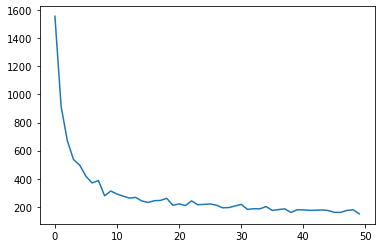

In [6]:
# Test Sarsa Agent [DO NOT CHANGE]
num_runs = 10
num_episodes = 50
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []

agent = SarsaAgent
env = mountaincar_env.Environment
start = time.time()

for run in range(num_runs):
    if run % 5 == 0:
        print("RUN: {}".format(run))

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    steps_per_episode = []

    for episode in range(num_episodes):
        rl_glue.rl_episode(15000)
        steps_per_episode.append(rl_glue.num_steps)

    all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

plt.plot(np.mean(np.array(all_steps), axis=0))
np.save("sarsa_test", np.array(all_steps))

The learning rate of your agent should look similar to ours, though it will not look exactly the same.If there are some spikey points that is okay. Due to stochasticity,  a few episodes may have taken much longer, causing some spikes in the plot. The trend of the line should be similar, though, generally decreasing to about 200 steps per run.
![alt text](sarsa_agent_initial.png "Logo Title Text 1")

This result was using 8 tilings with 8x8 tiles on each. Let's see if we can do better, and what different tilings look like. We will also text 2 tilings of 16x16 and 4 tilings of 32x32. These three choices produce the same number of features (512), but distributed quite differently. 

RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.25
Run Time: 52.46225571632385
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.015625
Run Time: 30.930733919143677
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.0625
Run Time: 31.441166400909424


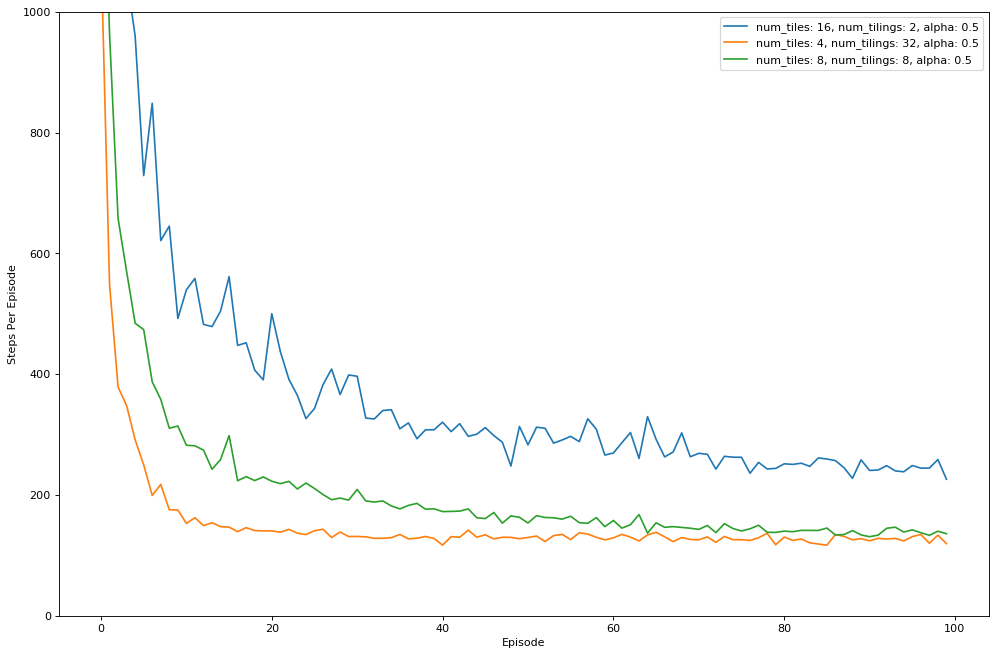

In [7]:
# Compare the three
num_runs = 20
num_episodes = 100
env_info = {}

agent_runs = []
# alphas = [0.2, 0.4, 0.5, 1.0]
alphas = [0.5]
agent_info_options = [{"num_tiles": 16, "num_tilings": 2, "alpha": 0.5},
                      {"num_tiles": 4, "num_tilings": 32, "alpha": 0.5},
                      {"num_tiles": 8, "num_tilings": 8, "alpha": 0.5}]
agent_info_options = [{"num_tiles" : agent["num_tiles"], 
                       "num_tilings": agent["num_tilings"],
                       "alpha" : alpha} for agent in agent_info_options for alpha in alphas]

agent = SarsaAgent
env = mountaincar_env.Environment
for agent_info in agent_info_options:
    all_steps = []
    start = time.time()
    for run in range(num_runs):
        if run % 5 == 0:
            print("RUN: {}".format(run))
        env = mountaincar_env.Environment
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)
        all_steps.append(np.array(steps_per_episode))
    
    agent_runs.append(np.mean(np.array(all_steps), axis=0))
    print(rl_glue.agent.alpha)
    print("Run Time: {}".format(time.time() - start))

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.array(agent_runs).T)
plt.xlabel("Episode")
plt.ylabel("Steps Per Episode")
plt.yscale("linear")
plt.ylim(0, 1000)
plt.legend(["num_tiles: {}, num_tilings: {}, alpha: {}".format(agent_info["num_tiles"], 
                                                               agent_info["num_tilings"],
                                                               agent_info["alpha"])
            for agent_info in agent_info_options])

Here we can see that using 32 tilings and 4 x 4 tiles does a little better than 8 tilings with 8x8 tiles. Both seem to do much better than using 2 tilings, with 16 x 16 tiles.

## Section 3: Conclusion

Congratulations! You have learned how to implement a control agent using function approximation. In this notebook you learned how to:

- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent